# Preliminary Analysis of Statement Sentiment by Lexicon
Analyse statement by Loughran and McDonald word list to see if the relationship between economy and net sentiment 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime as dt
import os
import pickle
import codecs
import re
from tqdm import tqdm_notebook as tqdm

#For tokenizing sentences
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/akalodzitsa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
plt.style.use('seaborn-whitegrid')

### Reading the data in (FOMC Statements)

In [3]:
file = open("../data/FOMC/statement.pickle", "rb")
Data = pd.read_pickle(file)

In [4]:
Data.tail(2)

date                                           contents  \
192 2021-11-03  The Federal Reserve, the central bank of the U...   
193 2021-12-15  The Federal Reserve, the central bank of the U...   

           speaker           title  
192  Jerome Powell  FOMC Statement  
193  Jerome Powell  FOMC Statement

In [5]:
Data['text'] = Data['contents'].apply(lambda x: x.replace('\n\n[SECTION]\n\n', '').replace('\n', ' ').replace('\r', ' ').strip())
Data.drop(columns=['title'], axis=1, inplace=True)

In [6]:
print('Date: ', Data.iloc[-1]['date'].strftime('%Y-%m-%d'))
print('Speaker: ', Data.iloc[-1]['speaker'])
print('Text: \n\n', Data.iloc[-1]['contents'].replace('\n[SECTION]\n', '')[1192:])

Date:  2021-12-15
Speaker:  Jerome Powell
Text: 

 The Federal Reserve is committed to using its full range of tools to support the U.S. economy in this challenging time, thereby promoting its maximum employment and price stability goals.

With progress on vaccinations and strong policy support, indicators of economic activity and employment have continued to strengthen. The sectors most adversely affected by the pandemic have improved in recent months but continue to be affected by COVID-19. Job gains have been solid in recent months, and the unemployment rate has declined substantially. Supply and demand imbalances related to the pandemic and the reopening of the economy have continued to contribute to elevated levels of inflation. Overall financial conditions remain accommodative, in part reflecting policy measures to support the economy and the flow of credit to U.S. households and businesses.

The path of the economy continues to depend on the course of the virus. Progress on vacc

### Creating a Financial Dictionary based on Loughran and McDonald

In [7]:
#Dictionary tone assessment will compare them by Index (need the numbers back) 
Data['Index'] = range(0, len(Data))

# Make 'date' column as the index of Data
Data.set_index(['date'], inplace=True)
Data.head()

contents         speaker  \
date                                                                            
1994-02-04  \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1994-03-22  \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1994-04-18  \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1994-05-17  \n\n[SECTION]\n\nThe Federal Reserve today ann...  Alan Greenspan   
1994-08-16  \n\n[SECTION]\n\nThe Federal Reserve announced...  Alan Greenspan   

                                                         text  Index  
date                                                                  
1994-02-04  Chairman Alan Greenspan announced today that t...      0  
1994-03-22  Chairman Alan Greenspan announced today that t...      1  
1994-04-18  Chairman Alan Greenspan announced today that t...      2  
1994-05-17  The Federal Reserve today announced two action...      3  
1994-08-16  The Federal Reserve announced today the follow...      4

In [8]:
import re

# Loughran and McDonald Sentiment Word Lists (https://sraf.nd.edu/textual-analysis/resources/)
lmdict = {'Negative': ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments', 'abandons', 'abdicated',
                       'abdicates', 'abdicating', 'abdication', 'abdications', 'aberrant', 'aberration', 'aberrational',
                       'aberrations', 'abetting', 'abnormal', 'abnormalities', 'abnormality', 'abnormally', 'abolish',
                       'abolished', 'abolishes', 'abolishing', 'abrogate', 'abrogated', 'abrogates', 'abrogating',
                       'abrogation', 'abrogations', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absences',
                       'absenteeism', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'abusively', 'abusiveness',
                       'accident', 'accidental', 'accidentally', 'accidents', 'accusation', 'accusations', 'accuse',
                       'accused', 'accuses', 'accusing', 'acquiesce', 'acquiesced', 'acquiesces', 'acquiescing',
                       'acquit', 'acquits', 'acquittal', 'acquittals', 'acquitted', 'acquitting', 'adulterate',
                       'adulterated', 'adulterating', 'adulteration', 'adulterations', 'adversarial', 'adversaries',
                       'adversary', 'adverse', 'adversely', 'adversities', 'adversity', 'aftermath', 'aftermaths',
                       'against', 'aggravate', 'aggravated', 'aggravates', 'aggravating', 'aggravation', 'aggravations',
                       'alerted', 'alerting', 'alienate', 'alienated', 'alienates', 'alienating', 'alienation',
                       'alienations', 'allegation', 'allegations', 'allege', 'alleged', 'allegedly', 'alleges',
                       'alleging', 'annoy', 'annoyance', 'annoyances', 'annoyed', 'annoying', 'annoys', 'annul',
                       'annulled', 'annulling', 'annulment', 'annulments', 'annuls', 'anomalies', 'anomalous',
                       'anomalously', 'anomaly', 'anticompetitive', 'antitrust', 'argue', 'argued', 'arguing',
                       'argument', 'argumentative', 'arguments', 'arrearage', 'arrearages', 'arrears', 'arrest',
                       'arrested', 'arrests', 'artificially', 'assault', 'assaulted', 'assaulting', 'assaults',
                       'assertions', 'attrition', 'aversely', 'backdating', 'bad', 'bail', 'bailout', 'balk', 'balked',
                       'bankrupt', 'bankruptcies', 'bankruptcy', 'bankrupted', 'bankrupting', 'bankrupts', 'bans',
                       'barred', 'barrier', 'barriers', 'bottleneck', 'bottlenecks', 'boycott', 'boycotted',
                       'boycotting', 'boycotts', 'breach', 'breached', 'breaches', 'breaching', 'break', 'breakage',
                       'breakages', 'breakdown', 'breakdowns', 'breaking', 'breaks', 'bribe', 'bribed', 'briberies',
                       'bribery', 'bribes', 'bribing', 'bridge', 'broken', 'burden', 'burdened', 'burdening', 'burdens',
                       'burdensome', 'burned', 'calamities', 'calamitous', 'calamity', 'cancel', 'canceled',
                       'canceling', 'cancellation', 'cancellations', 'cancelled', 'cancelling', 'cancels', 'careless',
                       'carelessly', 'carelessness', 'catastrophe', 'catastrophes', 'catastrophic', 'catastrophically',
                       'caution', 'cautionary', 'cautioned', 'cautioning', 'cautions', 'cease', 'ceased', 'ceases',
                       'ceasing', 'censure', 'censured', 'censures', 'censuring', 'challenge', 'challenged',
                       'challenges', 'challenging', 'chargeoffs', 'circumvent', 'circumvented', 'circumventing',
                       'circumvention', 'circumventions', 'circumvents', 'claiming', 'claims', 'clawback', 'closed',
                       'closeout', 'closeouts', 'closing', 'closings', 'closure', 'closures', 'coerce', 'coerced',
                       'coerces', 'coercing', 'coercion', 'coercive', 'collapse', 'collapsed', 'collapses',
                       'collapsing', 'collision', 'collisions', 'collude', 'colluded', 'colludes', 'colluding',
                       'collusion', 'collusions', 'collusive', 'complain', 'complained', 'complaining', 'complains',
                       'complaint', 'complaints', 'complicate', 'complicated', 'complicates', 'complicating',
                       'complication', 'complications', 'compulsion', 'concealed', 'concealing', 'concede', 'conceded',
                       'concedes', 'conceding', 'concern', 'concerned', 'concerns', 'conciliating', 'conciliation',
                       'conciliations', 'condemn', 'condemnation', 'condemnations', 'condemned', 'condemning',
                       'condemns', 'condone', 'condoned', 'confess', 'confessed', 'confesses', 'confessing',
                       'confession', 'confine', 'confined', 'confinement', 'confinements', 'confines', 'confining',
                       'confiscate', 'confiscated', 'confiscates', 'confiscating', 'confiscation', 'confiscations',
                       'conflict', 'conflicted', 'conflicting', 'conflicts', 'confront', 'confrontation',
                       'confrontational', 'confrontations', 'confronted', 'confronting', 'confronts', 'confuse',
                       'confused', 'confuses', 'confusing', 'confusingly', 'confusion', 'conspiracies', 'conspiracy',
                       'conspirator', 'conspiratorial', 'conspirators', 'conspire', 'conspired', 'conspires',
                       'conspiring', 'contempt', 'contend', 'contended', 'contending', 'contends', 'contention',
                       'contentions', 'contentious', 'contentiously', 'contested', 'contesting', 'contraction',
                       'contractions', 'contradict', 'contradicted', 'contradicting', 'contradiction', 'contradictions',
                       'contradictory', 'contradicts', 'contrary', 'controversial', 'controversies', 'controversy',
                       'convict', 'convicted', 'convicting', 'conviction', 'convictions', 'corrected', 'correcting',
                       'correction', 'corrections', 'corrects', 'corrupt', 'corrupted', 'corrupting', 'corruption',
                       'corruptions', 'corruptly', 'corruptness', 'costly', 'counterclaim', 'counterclaimed',
                       'counterclaiming', 'counterclaims', 'counterfeit', 'counterfeited', 'counterfeiter',
                       'counterfeiters', 'counterfeiting', 'counterfeits', 'countermeasure', 'countermeasures', 'crime',
                       'crimes', 'criminal', 'criminally', 'criminals', 'crises', 'crisis', 'critical', 'critically',
                       'criticism', 'criticisms', 'criticize', 'criticized', 'criticizes', 'criticizing', 'crucial',
                       'crucially', 'culpability', 'culpable', 'culpably', 'cumbersome', 'curtail', 'curtailed',
                       'curtailing', 'curtailment', 'curtailments', 'curtails', 'cut', 'cutback', 'cutbacks',
                       'cyberattack', 'cyberattacks', 'cyberbullying', 'cybercrime', 'cybercrimes', 'cybercriminal',
                       'cybercriminals', 'damage', 'damaged', 'damages', 'damaging', 'dampen', 'dampened', 'danger',
                       'dangerous', 'dangerously', 'dangers', 'deadlock', 'deadlocked', 'deadlocking', 'deadlocks',
                       'deadweight', 'deadweights', 'debarment', 'debarments', 'debarred', 'deceased', 'deceit',
                       'deceitful', 'deceitfulness', 'deceive', 'deceived', 'deceives', 'deceiving', 'deception',
                       'deceptions', 'deceptive', 'deceptively', 'decline', 'declined', 'declines', 'declining',
                       'deface', 'defaced', 'defacement', 'defamation', 'defamations', 'defamatory', 'defame',
                       'defamed', 'defames', 'defaming', 'default', 'defaulted', 'defaulting', 'defaults', 'defeat',
                       'defeated', 'defeating', 'defeats', 'defect', 'defective', 'defects', 'defend', 'defendant',
                       'defendants', 'defended', 'defending', 'defends', 'defensive', 'defer', 'deficiencies',
                       'deficiency', 'deficient', 'deficit', 'deficits', 'defraud', 'defrauded', 'defrauding',
                       'defrauds', 'defunct', 'degradation', 'degradations', 'degrade', 'degraded', 'degrades',
                       'degrading', 'delay', 'delayed', 'delaying', 'delays', 'deleterious', 'deliberate',
                       'deliberated', 'deliberately', 'delinquencies', 'delinquency', 'delinquent', 'delinquently',
                       'delinquents', 'delist', 'delisted', 'delisting', 'delists', 'demise', 'demised', 'demises',
                       'demising', 'demolish', 'demolished', 'demolishes', 'demolishing', 'demolition', 'demolitions',
                       'demote', 'demoted', 'demotes', 'demoting', 'demotion', 'demotions', 'denial', 'denials',
                       'denied', 'denies', 'denigrate', 'denigrated', 'denigrates', 'denigrating', 'denigration',
                       'deny', 'denying', 'deplete', 'depleted', 'depletes', 'depleting', 'depletion', 'depletions',
                       'deprecation', 'depress', 'depressed', 'depresses', 'depressing', 'deprivation', 'deprive',
                       'deprived', 'deprives', 'depriving', 'derelict', 'dereliction', 'derogatory', 'destabilization',
                       'destabilize', 'destabilized', 'destabilizing', 'destroy', 'destroyed', 'destroying', 'destroys',
                       'destruction', 'destructive', 'detain', 'detained', 'detention', 'detentions', 'deter',
                       'deteriorate', 'deteriorated', 'deteriorates', 'deteriorating', 'deterioration',
                       'deteriorations', 'deterred', 'deterrence', 'deterrences', 'deterrent', 'deterrents',
                       'deterring', 'deters', 'detract', 'detracted', 'detracting', 'detriment', 'detrimental',
                       'detrimentally', 'detriments', 'devalue', 'devalued', 'devalues', 'devaluing', 'devastate',
                       'devastated', 'devastating', 'devastation', 'deviate', 'deviated', 'deviates', 'deviating',
                       'deviation', 'deviations', 'devolve', 'devolved', 'devolves', 'devolving', 'difficult',
                       'difficulties', 'difficultly', 'difficulty', 'diminish', 'diminished', 'diminishes',
                       'diminishing', 'diminution', 'disadvantage', 'disadvantaged', 'disadvantageous', 'disadvantages',
                       'disaffiliation', 'disagree', 'disagreeable', 'disagreed', 'disagreeing', 'disagreement',
                       'disagreements', 'disagrees', 'disallow', 'disallowance', 'disallowances', 'disallowed',
                       'disallowing', 'disallows', 'disappear', 'disappearance', 'disappearances', 'disappeared',
                       'disappearing', 'disappears', 'disappoint', 'disappointed', 'disappointing', 'disappointingly',
                       'disappointment', 'disappointments', 'disappoints', 'disapproval', 'disapprovals', 'disapprove',
                       'disapproved', 'disapproves', 'disapproving', 'disassociates', 'disassociating',
                       'disassociation', 'disassociations', 'disaster', 'disasters', 'disastrous', 'disastrously',
                       'disavow', 'disavowal', 'disavowed', 'disavowing', 'disavows', 'disciplinary', 'disclaim',
                       'disclaimed', 'disclaimer', 'disclaimers', 'disclaiming', 'disclaims', 'disclose', 'disclosed',
                       'discloses', 'disclosing', 'discontinuance', 'discontinuances', 'discontinuation',
                       'discontinuations', 'discontinue', 'discontinued', 'discontinues', 'discontinuing', 'discourage',
                       'discouraged', 'discourages', 'discouraging', 'discredit', 'discredited', 'discrediting',
                       'discredits', 'discrepancies', 'discrepancy', 'disfavor', 'disfavored', 'disfavoring',
                       'disfavors', 'disgorge', 'disgorged', 'disgorgement', 'disgorgements', 'disgorges', 'disgorging',
                       'disgrace', 'disgraceful', 'disgracefully', 'dishonest', 'dishonestly', 'dishonesty', 'dishonor',
                       'dishonorable', 'dishonorably', 'dishonored', 'dishonoring', 'dishonors', 'disincentives',
                       'disinterested', 'disinterestedly', 'disinterestedness', 'disloyal', 'disloyally', 'disloyalty',
                       'dismal', 'dismally', 'dismiss', 'dismissal', 'dismissals', 'dismissed', 'dismisses',
                       'dismissing', 'disorderly', 'disparage', 'disparaged', 'disparagement', 'disparagements',
                       'disparages', 'disparaging', 'disparagingly', 'disparities', 'disparity', 'displace',
                       'displaced', 'displacement', 'displacements', 'displaces', 'displacing', 'dispose', 'dispossess',
                       'dispossessed', 'dispossesses', 'dispossessing', 'disproportion', 'disproportional',
                       'disproportionate', 'disproportionately', 'dispute', 'disputed', 'disputes', 'disputing',
                       'disqualification', 'disqualifications', 'disqualified', 'disqualifies', 'disqualify',
                       'disqualifying', 'disregard', 'disregarded', 'disregarding', 'disregards', 'disreputable',
                       'disrepute', 'disrupt', 'disrupted', 'disrupting', 'disruption', 'disruptions', 'disruptive',
                       'disrupts', 'dissatisfaction', 'dissatisfied', 'dissent', 'dissented', 'dissenter', 'dissenters',
                       'dissenting', 'dissents', 'dissident', 'dissidents', 'dissolution', 'dissolutions', 'distort',
                       'distorted', 'distorting', 'distortion', 'distortions', 'distorts', 'distract', 'distracted',
                       'distracting', 'distraction', 'distractions', 'distracts', 'distress', 'distressed', 'disturb',
                       'disturbance', 'disturbances', 'disturbed', 'disturbing', 'disturbs', 'diversion', 'divert',
                       'diverted', 'diverting', 'diverts', 'divest', 'divested', 'divesting', 'divestiture',
                       'divestitures', 'divestment', 'divestments', 'divests', 'divorce', 'divorced', 'divulge',
                       'divulged', 'divulges', 'divulging', 'doubt', 'doubted', 'doubtful', 'doubts', 'downgrade',
                       'downgraded', 'downgrades', 'downgrading', 'downsize', 'downsized', 'downsizes', 'downsizing',
                       'downsizings', 'downtime', 'downtimes', 'downturn', 'downturns', 'downward', 'downwards', 'drag',
                       'drastic', 'drastically', 'drawback', 'drawbacks', 'drop', 'dropped', 'drought', 'droughts', 'duress',
                       'dysfunction', 'dysfunctional', 'dysfunctions', 'easing', 'egregious', 'egregiously', 'embargo',
                       'embargoed', 'embargoes', 'embargoing', 'embarrass', 'embarrassed', 'embarrasses',
                       'embarrassing', 'embarrassment', 'embarrassments', 'embezzle', 'embezzled', 'embezzlement',
                       'embezzlements', 'embezzler', 'embezzles', 'embezzling', 'encroach', 'encroached', 'encroaches',
                       'encroaching', 'encroachment', 'encroachments', 'encumber', 'encumbered', 'encumbering',
                       'encumbers', 'encumbrance', 'encumbrances', 'endanger', 'endangered', 'endangering',
                       'endangerment', 'endangers', 'enjoin', 'enjoined', 'enjoining', 'enjoins', 'erode', 'eroded',
                       'erodes', 'eroding', 'erosion', 'erratic', 'erratically', 'erred', 'erring', 'erroneous',
                       'erroneously', 'error', 'errors', 'errs', 'escalate', 'escalated', 'escalates', 'escalating',
                       'evade', 'evaded', 'evades', 'evading', 'evasion', 'evasions', 'evasive', 'evict', 'evicted',
                       'evicting', 'eviction', 'evictions', 'evicts', 'exacerbate', 'exacerbated', 'exacerbates',
                       'exacerbating', 'exacerbation', 'exacerbations', 'exaggerate', 'exaggerated', 'exaggerates',
                       'exaggerating', 'exaggeration', 'excessive', 'excessively', 'exculpate', 'exculpated',
                       'exculpates', 'exculpating', 'exculpation', 'exculpations', 'exculpatory', 'exonerate',
                       'exonerated', 'exonerates', 'exonerating', 'exoneration', 'exonerations', 'exploit',
                       'exploitation', 'exploitations', 'exploitative', 'exploited', 'exploiting', 'exploits', 'expose',
                       'exposed', 'exposes', 'exposing', 'expropriate', 'expropriated', 'expropriates', 'expropriating',
                       'expropriation', 'expropriations', 'expulsion', 'expulsions', 'extenuating', 'fail', 'failed',
                       'failing', 'failings', 'fails', 'failure', 'failures', 'fallout', 'false', 'falsely',
                       'falsification', 'falsifications', 'falsified', 'falsifies', 'falsify', 'falsifying', 'falsity',
                       'fatalities', 'fatality', 'fatally', 'fault', 'faulted', 'faults', 'faulty', 'fear', 'fears',
                       'felonies', 'felonious', 'felony', 'fictitious', 'fined', 'fines', 'fired', 'firing', 'flaw',
                       'flawed', 'flaws', 'forbid', 'forbidden', 'forbidding', 'forbids', 'force', 'forced', 'forcing',
                       'foreclose', 'foreclosed', 'forecloses', 'foreclosing', 'foreclosure', 'foreclosures', 'forego',
                       'foregoes', 'foregone', 'forestall', 'forestalled', 'forestalling', 'forestalls', 'forfeit',
                       'forfeited', 'forfeiting', 'forfeits', 'forfeiture', 'forfeitures', 'forgers', 'forgery',
                       'fraud', 'frauds', 'fraudulence', 'fraudulent', 'fraudulently', 'frivolous', 'frivolously',
                       'frustrate', 'frustrated', 'frustrates', 'frustrating', 'frustratingly', 'frustration',
                       'frustrations', 'fugitive', 'fugitives', 'gratuitous', 'gratuitously', 'grievance', 'grievances',
                       'grossly', 'groundless', 'guilty', 'halt', 'halted', 'hamper', 'hampered', 'hampering',
                       'hampers', 'harass', 'harassed', 'harassing', 'harassment', 'hardship', 'hardships', 'harm',
                       'harmed', 'harmful', 'harmfully', 'harming', 'harms', 'harsh', 'harsher', 'harshest', 'harshly',
                       'harshness', 'hazard', 'hazardous', 'hazards', 'hinder', 'hindered', 'hindering', 'hinders',
                       'hindrance', 'hindrances', 'hostile', 'hostility', 'hurt', 'hurting', 'idle', 'idled', 'idling',
                       'ignore', 'ignored', 'ignores', 'ignoring', 'ill', 'illegal', 'illegalities', 'illegality',
                       'illegally', 'illegible', 'illicit', 'illicitly', 'illiquid', 'illiquidity', 'imbalance',
                       'imbalances', 'immature', 'immoral', 'impair', 'impaired', 'impairing', 'impairment',
                       'impairments', 'impairs', 'impasse', 'impasses', 'impede', 'impeded', 'impedes', 'impediment',
                       'impediments', 'impeding', 'impending', 'imperative', 'imperfection', 'imperfections', 'imperil',
                       'impermissible', 'implicate', 'implicated', 'implicates', 'implicating', 'impossibility',
                       'impossible', 'impound', 'impounded', 'impounding', 'impounds', 'impracticable', 'impractical',
                       'impracticalities', 'impracticality', 'imprisonment', 'improper', 'improperly', 'improprieties',
                       'impropriety', 'imprudent', 'imprudently', 'inability', 'inaccessible', 'inaccuracies',
                       'inaccuracy', 'inaccurate', 'inaccurately', 'inaction', 'inactions', 'inactivate', 'inactivated',
                       'inactivates', 'inactivating', 'inactivation', 'inactivations', 'inactivity', 'inadequacies',
                       'inadequacy', 'inadequate', 'inadequately', 'inadvertent', 'inadvertently', 'inadvisability',
                       'inadvisable', 'inappropriate', 'inappropriately', 'inattention', 'incapable', 'incapacitated',
                       'incapacity', 'incarcerate', 'incarcerated', 'incarcerates', 'incarcerating', 'incarceration',
                       'incarcerations', 'incidence', 'incidences', 'incident', 'incidents', 'incompatibilities',
                       'incompatibility', 'incompatible', 'incompetence', 'incompetency', 'incompetent',
                       'incompetently', 'incompetents', 'incomplete', 'incompletely', 'incompleteness', 'inconclusive',
                       'inconsistencies', 'inconsistency', 'inconsistent', 'inconsistently', 'inconvenience',
                       'inconveniences', 'inconvenient', 'incorrect', 'incorrectly', 'incorrectness', 'indecency',
                       'indecent', 'indefeasible', 'indefeasibly', 'indict', 'indictable', 'indicted', 'indicting',
                       'indictment', 'indictments', 'ineffective', 'ineffectively', 'ineffectiveness', 'inefficiencies',
                       'inefficiency', 'inefficient', 'inefficiently', 'ineligibility', 'ineligible', 'inequitable',
                       'inequitably', 'inequities', 'inequity', 'inevitable', 'inexperience', 'inexperienced',
                       'inferior', 'inflicted', 'infraction', 'infractions', 'infringe', 'infringed', 'infringement',
                       'infringements', 'infringes', 'infringing', 'inhibited', 'inimical', 'injunction', 'injunctions',
                       'injure', 'injured', 'injures', 'injuries', 'injuring', 'injurious', 'injury', 'inordinate',
                       'inordinately', 'inquiry', 'insecure', 'insensitive', 'insolvencies', 'insolvency', 'insolvent',
                       'instability', 'insubordination', 'insufficiency', 'insufficient', 'insufficiently',
                       'insurrection', 'insurrections', 'intentional', 'interfere', 'interfered', 'interference',
                       'interferences', 'interferes', 'interfering', 'intermittent', 'intermittently', 'interrupt',
                       'interrupted', 'interrupting', 'interruption', 'interruptions', 'interrupts', 'intimidation',
                       'intrusion', 'invalid', 'invalidate', 'invalidated', 'invalidates', 'invalidating',
                       'invalidation', 'invalidity', 'investigate', 'investigated', 'investigates', 'investigating',
                       'investigation', 'investigations', 'involuntarily', 'involuntary', 'irreconcilable',
                       'irreconcilably', 'irrecoverable', 'irrecoverably', 'irregular', 'irregularities',
                       'irregularity', 'irregularly', 'irreparable', 'irreparably', 'irreversible', 'jeopardize',
                       'jeopardized', 'justifiable', 'kickback', 'kickbacks', 'knowingly', 'lack', 'lacked', 'lacking',
                       'lackluster', 'lacks', 'lag', 'lagged', 'lagging', 'lags', 'lapse', 'lapsed', 'lapses',
                       'lapsing', 'late', 'laundering', 'layoff', 'layoffs', 'lie', 'limitation', 'limitations',
                       'lingering', 'liquidate', 'liquidated', 'liquidates', 'liquidating', 'liquidation',
                       'liquidations', 'liquidator', 'liquidators', 'litigant', 'litigants', 'litigate', 'litigated',
                       'litigates', 'litigating', 'litigation', 'litigations', 'lockout', 'lockouts', 'lose', 'loses',
                       'losing', 'loss', 'losses', 'lost', 'lying', 'malfeasance', 'malfunction', 'malfunctioned',
                       'malfunctioning', 'malfunctions', 'malice', 'malicious', 'maliciously', 'malpractice',
                       'manipulate', 'manipulated', 'manipulates', 'manipulating', 'manipulation', 'manipulations',
                       'manipulative', 'markdown', 'markdowns', 'misapplication', 'misapplications', 'misapplied',
                       'misapplies', 'misapply', 'misapplying', 'misappropriate', 'misappropriated', 'misappropriates',
                       'misappropriating', 'misappropriation', 'misappropriations', 'misbranded', 'miscalculate',
                       'miscalculated', 'miscalculates', 'miscalculating', 'miscalculation', 'miscalculations',
                       'mischaracterization', 'mischief', 'misclassification', 'misclassifications', 'misclassified',
                       'misclassify', 'miscommunication', 'misconduct', 'misdated', 'misdemeanor', 'misdemeanors',
                       'misdirected', 'mishandle', 'mishandled', 'mishandles', 'mishandling', 'misinform',
                       'misinformation', 'misinformed', 'misinforming', 'misinforms', 'misinterpret',
                       'misinterpretation', 'misinterpretations', 'misinterpreted', 'misinterpreting', 'misinterprets',
                       'misjudge', 'misjudged', 'misjudges', 'misjudging', 'misjudgment', 'misjudgments', 'mislabel',
                       'mislabeled', 'mislabeling', 'mislabelled', 'mislabels', 'mislead', 'misleading', 'misleadingly',
                       'misleads', 'misled', 'mismanage', 'mismanaged', 'mismanagement', 'mismanages', 'mismanaging',
                       'mismatch', 'mismatched', 'mismatches', 'mismatching', 'misplaced', 'misprice', 'mispricing',
                       'mispricings', 'misrepresent', 'misrepresentation', 'misrepresentations', 'misrepresented',
                       'misrepresenting', 'misrepresents', 'miss', 'missed', 'misses', 'misstate', 'misstated',
                       'misstatement', 'misstatements', 'misstates', 'misstating', 'misstep', 'missteps', 'mistake',
                       'mistaken', 'mistakenly', 'mistakes', 'mistaking', 'mistrial', 'mistrials', 'misunderstand',
                       'misunderstanding', 'misunderstandings', 'misunderstood', 'misuse', 'misused', 'misuses',
                       'misusing', 'monopolistic', 'monopolists', 'monopolization', 'monopolize', 'monopolized',
                       'monopolizes', 'monopolizing', 'monopoly', 'moratoria', 'moratorium', 'moratoriums',
                       'mothballed', 'mothballing', 'negative', 'negatively', 'negatives', 'neglect', 'neglected',
                       'neglectful', 'neglecting', 'neglects', 'negligence', 'negligences', 'negligent', 'negligently',
                       'nonattainment', 'noncompetitive', 'noncompliance', 'noncompliances', 'noncompliant',
                       'noncomplying', 'nonconforming', 'nonconformities', 'nonconformity', 'nondisclosure',
                       'nonfunctional', 'nonpayment', 'nonpayments', 'nonperformance', 'nonperformances',
                       'nonperforming', 'nonproducing', 'nonproductive', 'nonrecoverable', 'nonrenewal', 'nuisance',
                       'nuisances', 'nullification', 'nullifications', 'nullified', 'nullifies', 'nullify',
                       'nullifying', 'objected', 'objecting', 'objection', 'objectionable', 'objectionably',
                       'objections', 'obscene', 'obscenity', 'obsolescence', 'obsolete', 'obstacle', 'obstacles',
                       'obstruct', 'obstructed', 'obstructing', 'obstruction', 'obstructions', 'offence', 'offences',
                       'offend', 'offended', 'offender', 'offenders', 'offending', 'offends', 'omission', 'omissions',
                       'omit', 'omits', 'omitted', 'omitting', 'onerous', 'opportunistic', 'opportunistically',
                       'oppose', 'opposed', 'opposes', 'opposing', 'opposition', 'oppositions', 'outage', 'outages',
                       'outdated', 'outmoded', 'overage', 'overages', 'overbuild', 'overbuilding', 'overbuilds',
                       'overbuilt', 'overburden', 'overburdened', 'overburdening', 'overcapacities', 'overcapacity',
                       'overcharge', 'overcharged', 'overcharges', 'overcharging', 'overcome', 'overcomes',
                       'overcoming', 'overdue', 'overestimate', 'overestimated', 'overestimates', 'overestimating',
                       'overestimation', 'overestimations', 'overload', 'overloaded', 'overloading', 'overloads',
                       'overlook', 'overlooked', 'overlooking', 'overlooks', 'overpaid', 'overpayment', 'overpayments',
                       'overproduced', 'overproduces', 'overproducing', 'overproduction', 'overrun', 'overrunning',
                       'overruns', 'overshadow', 'overshadowed', 'overshadowing', 'overshadows', 'overstate',
                       'overstated', 'overstatement', 'overstatements', 'overstates', 'overstating', 'oversupplied',
                       'oversupplies', 'oversupply', 'oversupplying', 'overtly', 'overturn', 'overturned',
                       'overturning', 'overturns', 'overvalue', 'overvalued', 'overvaluing', 'panic', 'panics',
                       'penalize', 'penalized', 'penalizes', 'penalizing', 'penalties', 'penalty', 'peril', 'perils',
                       'perjury', 'perpetrate', 'perpetrated', 'perpetrates', 'perpetrating', 'perpetration', 'persist',
                       'persisted', 'persistence', 'persistent', 'persistently', 'persisting', 'persists', 'pervasive',
                       'pervasively', 'pervasiveness', 'petty', 'picket', 'picketed', 'picketing', 'plaintiff',
                       'plaintiffs', 'plea', 'plead', 'pleaded', 'pleading', 'pleadings', 'pleads', 'pleas', 'pled',
                       'poor', 'poorly', 'poses', 'posing', 'postpone', 'postponed', 'postponement', 'postponements',
                       'postpones', 'postponing', 'precipitated', 'precipitous', 'precipitously', 'preclude',
                       'precluded', 'precludes', 'precluding', 'predatory', 'prejudice', 'prejudiced', 'prejudices',
                       'prejudicial', 'prejudicing', 'premature', 'prematurely', 'pressing', 'pretrial', 'preventing',
                       'prevention', 'prevents', 'problem', 'problematic', 'problematical', 'problems', 'prolong',
                       'prolongation', 'prolongations', 'prolonged', 'prolonging', 'prolongs', 'prone', 'prosecute',
                       'prosecuted', 'prosecutes', 'prosecuting', 'prosecution', 'prosecutions', 'protest', 'protested',
                       'protester', 'protesters', 'protesting', 'protestor', 'protestors', 'protests', 'protracted',
                       'protraction', 'provoke', 'provoked', 'provokes', 'provoking', 'punished', 'punishes',
                       'punishing', 'punishment', 'punishments', 'punitive', 'purport', 'purported', 'purportedly',
                       'purporting', 'purports', 'question', 'questionable', 'questionably', 'questioned',
                       'questioning', 'questions', 'quit', 'quitting', 'racketeer', 'racketeering', 'rationalization',
                       'rationalizations', 'rationalize', 'rationalized', 'rationalizes', 'rationalizing',
                       'reassessment', 'reassessments', 'reassign', 'reassigned', 'reassigning', 'reassignment',
                       'reassignments', 'reassigns', 'recall', 'recalled', 'recalling', 'recalls', 'recession',
                       'recessionary', 'recessions', 'reckless', 'recklessly', 'recklessness', 'redact', 'redacted',
                       'redacting', 'redaction', 'redactions', 'redefault', 'redefaulted', 'redefaults', 'redress',
                       'redressed', 'redresses', 'redressing', 'refusal', 'refusals', 'refuse', 'refused', 'refuses',
                       'refusing', 'reject', 'rejected', 'rejecting', 'rejection', 'rejections', 'rejects',
                       'relinquish', 'relinquished', 'relinquishes', 'relinquishing', 'relinquishment',
                       'relinquishments', 'reluctance', 'reluctant', 'renegotiate', 'renegotiated', 'renegotiates',
                       'renegotiating', 'renegotiation', 'renegotiations', 'renounce', 'renounced', 'renouncement',
                       'renouncements', 'renounces', 'renouncing', 'reparation', 'reparations', 'repossessed',
                       'repossesses', 'repossessing', 'repossession', 'repossessions', 'repudiate', 'repudiated',
                       'repudiates', 'repudiating', 'repudiation', 'repudiations', 'resign', 'resignation',
                       'resignations', 'resigned', 'resigning', 'resigns', 'restate', 'restated', 'restatement',
                       'restatements', 'restates', 'restating', 'restructure', 'restructured', 'restructures',
                       'restructuring', 'restructurings', 'retaliate', 'retaliated', 'retaliates', 'retaliating',
                       'retaliation', 'retaliations', 'retaliatory', 'retribution', 'retributions', 'revocation',
                       'revocations', 'revoke', 'revoked', 'revokes', 'revoking', 'ridicule', 'ridiculed', 'ridicules',
                       'ridiculing', 'riskier', 'riskiest', 'risky', 'sabotage', 'sacrifice', 'sacrificed',
                       'sacrifices', 'sacrificial', 'sacrificing', 'scandalous', 'scandals', 'scrutinize',
                       'scrutinized', 'scrutinizes', 'scrutinizing', 'scrutiny', 'secrecy', 'seize', 'seized', 'seizes',
                       'seizing', 'sentenced', 'sentencing', 'serious', 'seriously', 'seriousness', 'setback',
                       'setbacks', 'sever', 'severe', 'severed', 'severely', 'severities', 'severity', 'sharply',
                       'shocked', 'shortage', 'shortages', 'shortfall', 'shortfalls', 'shrinkage', 'shrinkages', 'shut',
                       'shutdown', 'shutdowns', 'shuts', 'shutting', 'slander', 'slandered', 'slanderous', 'slanders',
                       'slippage', 'slippages', 'slow', 'slowdown', 'slowdowns', 'slowed', 'slower', 'slowest',
                       'slowing', 'slowly', 'slowness', 'sluggish', 'sluggishly', 'sluggishness', 'solvencies',
                       'solvency', 'spam', 'spammers', 'spamming', 'staggering', 'stagnant', 'stagnate', 'stagnated',
                       'stagnates', 'stagnating', 'stagnation', 'standstill', 'standstills', 'stolen', 'stoppage',
                       'stoppages', 'stopped', 'stopping', 'stops', 'strain', 'strained', 'straining', 'strains',
                       'stress', 'stressed', 'stresses', 'stressful', 'stressing', 'stringent', 'strong', 'subjected',
                       'subjecting', 'subjection', 'subpoena', 'subpoenaed', 'subpoenas', 'substandard', 'sue', 'sued',
                       'sues', 'suffer', 'suffered', 'suffering', 'suffers', 'suing', 'summoned', 'summoning',
                       'summons', 'summonses', 'susceptibility', 'susceptible', 'suspect', 'suspected', 'suspects',
                       'suspend', 'suspended', 'suspending', 'suspends', 'suspension', 'suspensions', 'suspicion',
                       'suspicions', 'suspicious', 'suspiciously', 'taint', 'tainted', 'tainting', 'taints', 'tampered',
                       'tense', 'terminate', 'terminated', 'terminates', 'terminating', 'termination', 'terminations',
                       'testify', 'testifying', 'threat', 'threaten', 'threatened', 'threatening', 'threatens',
                       'threats', 'tightening', 'tolerate', 'tolerated', 'tolerates', 'tolerating', 'toleration',
                       'tortuous', 'tortuously', 'tragedies', 'tragedy', 'tragic', 'tragically', 'traumatic', 'trouble',
                       'troubled', 'troubles', 'turbulence', 'turmoil', 'unable', 'unacceptable', 'unacceptably',
                       'unaccounted', 'unannounced', 'unanticipated', 'unapproved', 'unattractive', 'unauthorized',
                       'unavailability', 'unavailable', 'unavoidable', 'unavoidably', 'unaware', 'uncollectable',
                       'uncollected', 'uncollectibility', 'uncollectible', 'uncollectibles', 'uncompetitive',
                       'uncompleted', 'unconscionable', 'unconscionably', 'uncontrollable', 'uncontrollably',
                       'uncontrolled', 'uncorrected', 'uncover', 'uncovered', 'uncovering', 'uncovers', 'undeliverable',
                       'undelivered', 'undercapitalized', 'undercut', 'undercuts', 'undercutting', 'underestimate',
                       'underestimated', 'underestimates', 'underestimating', 'underestimation', 'underfunded',
                       'underinsured', 'undermine', 'undermined', 'undermines', 'undermining', 'underpaid',
                       'underpayment', 'underpayments', 'underpays', 'underperform', 'underperformance',
                       'underperformed', 'underperforming', 'underperforms', 'underproduced', 'underproduction',
                       'underreporting', 'understate', 'understated', 'understatement', 'understatements',
                       'understates', 'understating', 'underutilization', 'underutilized', 'undesirable', 'undesired',
                       'undetected', 'undetermined', 'undisclosed', 'undocumented', 'undue', 'unduly', 'uneconomic',
                       'uneconomical', 'uneconomically', 'unemployed', 'unemployment', 'unethical', 'unethically',
                       'unexcused', 'unexpected', 'unexpectedly', 'unfair', 'unfairly', 'unfavorability', 'unfavorable',
                       'unfavorably', 'unfavourable', 'unfeasible', 'unfit', 'unfitness', 'unforeseeable', 'unforeseen',
                       'unforseen', 'unfortunate', 'unfortunately', 'unfounded', 'unfriendly', 'unfulfilled',
                       'unfunded', 'uninsured', 'unintended', 'unintentional', 'unintentionally', 'unjust',
                       'unjustifiable', 'unjustifiably', 'unjustified', 'unjustly', 'unknowing', 'unknowingly',
                       'unlawful', 'unlawfully', 'unlicensed', 'unliquidated', 'unmarketable', 'unmerchantable',
                       'unmeritorious', 'unnecessarily', 'unnecessary', 'unneeded', 'unobtainable', 'unoccupied',
                       'unpaid', 'unperformed', 'unplanned', 'unpopular', 'unpredictability', 'unpredictable',
                       'unpredictably', 'unpredicted', 'unproductive', 'unprofitability', 'unprofitable', 'unqualified',
                       'unrealistic', 'unreasonable', 'unreasonableness', 'unreasonably', 'unreceptive',
                       'unrecoverable', 'unrecovered', 'unreimbursed', 'unreliable', 'unremedied', 'unreported',
                       'unresolved', 'unrest', 'unsafe', 'unsalable', 'unsaleable', 'unsatisfactory', 'unsatisfied',
                       'unsavory', 'unscheduled', 'unsellable', 'unsold', 'unsound', 'unstabilized', 'unstable',
                       'unsubstantiated', 'unsuccessful', 'unsuccessfully', 'unsuitability', 'unsuitable', 'unsuitably',
                       'unsuited', 'unsure', 'unsuspected', 'unsuspecting', 'unsustainable', 'untenable', 'untimely',
                       'untrusted', 'untruth', 'untruthful', 'untruthfully', 'untruthfulness', 'untruths', 'unusable',
                       'unwanted', 'unwarranted', 'unwelcome', 'unwilling', 'unwillingness', 'upset', 'urgency',
                       'urgent', 'usurious', 'usurp', 'usurped', 'usurping', 'usurps', 'usury', 'vandalism', 'verdict',
                       'verdicts', 'vetoed', 'victims', 'violate', 'violated', 'violates', 'violating', 'violation',
                       'violations', 'violative', 'violator', 'violators', 'violence', 'violent', 'violently',
                       'vitiate', 'vitiated', 'vitiates', 'vitiating', 'vitiation', 'voided', 'voiding', 'volatile',
                       'volatility', 'vulnerabilities', 'vulnerability', 'vulnerable', 'vulnerably', 'warn', 'warned',
                       'warning', 'warnings', 'warns', 'wasted', 'wasteful', 'wasting', 'weak', 'weaken', 'weakened',
                       'weakening', 'weakens', 'weaker', 'weakest', 'weakly', 'weakness', 'weaknesses', 'willfully',
                       'worries', 'worry', 'worrying', 'worse', 'worsen', 'worsened', 'worsening', 'worsens', 'worst',
                       'worthless', 'writedown', 'writedowns', 'writeoff', 'writeoffs', 'wrong', 'wrongdoing',
                       'wrongdoings', 'wrongful', 'wrongfully', 'wrongly',
                       'negative', 'negatives', 'fail', 'fails', 'failing', 'failure', 'weak', 'weakness', 'weaknesses',
                       'difficult', 'difficulty', 'hurdle', 'hurdles', 'obstacle', 'obstacles', 'slump', 'slumps',
                       'slumping', 'slumped', 'uncertain', 'uncertainty', 'unsettled', 'unfavorable', 'downturn',
                       'depressed', 'disappoint', 'disappoints', 'disappointing', 'disappointed', 'disappointment',
                       'risk', 'risks', 'risky', 'threat', 'threats', 'penalty', 'penalties', 'down', 'decrease',
                       'decreases', 'decreasing', 'decreased', 'decline', 'declines', 'declining', 'declined', 'fall',
                       'falls', 'falling', 'fell', 'fallen', 'drop', 'drops', 'dropping', 'dropped', 'deteriorate',
                       'deteriorates', 'deteriorating', 'deteriorated', 'worsen', 'worsens', 'worsening', 'weaken',
                       'weakens', 'weakening', 'weakened', 'worse', 'worst', 'low', 'lower', 'lowest', 'less', 'least',
                       'smaller', 'smallest', 'shrink', 'shrinks', 'shrinking', 'shrunk', 'below', 'under', 'challenge',
                       'challenges', 'challenging', 'challenged'
                      ],
          'Positive': ['able', 'abundance', 'abundant', 'acclaimed', 'accomplish', 'accomplished', 'accomplishes',
                       'accomplishing', 'accomplishment', 'accomplishments', 'achieve', 'achieved', 'achievement',
                       'achievements', 'achieves', 'achieving', 'adequately', 'advancement', 'advancements', 'advances',
                       'advancing', 'advantage', 'advantaged', 'advantageous', 'advantageously', 'advantages',
                       'alliance', 'alliances', 'assure', 'assured', 'assures', 'assuring', 'attain', 'attained',
                       'attaining', 'attainment', 'attainments', 'attains', 'attractive', 'attractiveness', 'beautiful',
                       'beautifully', 'beneficial', 'beneficially', 'benefit', 'benefited', 'benefiting', 'benefitted',
                       'benefitting', 'best', 'better', 'bolstered', 'bolstering', 'bolsters', 'boom', 'booming',
                       'boost', 'boosted', 'breakthrough', 'breakthroughs', 'brilliant', 'charitable', 'collaborate',
                       'collaborated', 'collaborates', 'collaborating', 'collaboration', 'collaborations',
                       'collaborative', 'collaborator', 'collaborators', 'compliment', 'complimentary', 'complimented',
                       'complimenting', 'compliments', 'conclusive', 'conclusively', 'conducive', 'confident',
                       'constructive', 'constructively', 'courteous', 'creative', 'creatively', 'creativeness',
                       'creativity', 'delight', 'delighted', 'delightful', 'delightfully', 'delighting', 'delights',
                       'dependability', 'dependable', 'desirable', 'desired', 'despite', 'destined', 'diligent',
                       'diligently', 'distinction', 'distinctions', 'distinctive', 'distinctively', 'distinctiveness',
                       'dream', 'easier', 'easily', 'easy', 'effective', 'efficiencies', 'efficiency', 'efficient',
                       'efficiently', 'empower', 'empowered', 'empowering', 'empowers', 'enable', 'enabled', 'enables',
                       'enabling', 'encouraged', 'encouragement', 'encourages', 'encouraging', 'enhance', 'enhanced',
                       'enhancement', 'enhancements', 'enhances', 'enhancing', 'enjoy', 'enjoyable', 'enjoyably',
                       'enjoyed', 'enjoying', 'enjoyment', 'enjoys', 'enthusiasm', 'enthusiastic', 'enthusiastically',
                       'excellence', 'excellent', 'excelling', 'excels', 'exceptional', 'exceptionally', 'excited',
                       'excitement', 'exciting', 'exclusive', 'exclusively', 'exclusiveness', 'exclusives',
                       'exclusivity', 'exemplary', 'fantastic', 'favorable', 'favorably', 'favored', 'favoring',
                       'favorite', 'favorites', 'friendly', 'gain', 'gained', 'gaining', 'gains', 'good', 'great',
                       'greater', 'greatest', 'greatly', 'greatness', 'happiest', 'happily', 'happiness', 'happy',
                       'highest', 'honor', 'honorable', 'honored', 'honoring', 'honors', 'ideal', 'impress',
                       'impressed', 'impresses', 'impressing', 'impressive', 'impressively', 'improve', 'improved',
                       'improvement', 'improvements', 'improves', 'improving', 'incredible', 'incredibly',
                       'influential', 'informative', 'ingenuity', 'innovate', 'innovated', 'innovates', 'innovating',
                       'innovation', 'innovations', 'innovative', 'innovativeness', 'innovator', 'innovators',
                       'insightful', 'inspiration', 'inspirational', 'integrity', 'invent', 'invented', 'inventing',
                       'invention', 'inventions', 'inventive', 'inventiveness', 'inventor', 'inventors', 'leadership',
                       'leading', 'loyal', 'lucrative', 'meritorious', 'opportunities', 'opportunity', 'optimistic',
                       'outperform', 'outperformed', 'outperforming', 'outperforms', 'perfect', 'perfected',
                       'perfectly', 'perfects', 'pleasant', 'pleasantly', 'pleased', 'pleasure', 'plentiful', 'popular',
                       'popularity', 'positive', 'positively', 'preeminence', 'preeminent', 'premier', 'premiere',
                       'prestige', 'prestigious', 'proactive', 'proactively', 'proficiency', 'proficient',
                       'proficiently', 'profitability', 'profitable', 'profitably', 'progress', 'progressed',
                       'progresses', 'progressing', 'prospered', 'prospering', 'prosperity', 'prosperous', 'prospers',
                       'rebound', 'rebounded', 'rebounding', 'receptive', 'regain', 'regained', 'regaining', 'resolve',
                       'revolutionize', 'revolutionized', 'revolutionizes', 'revolutionizing', 'reward', 'rewarded',
                       'rewarding', 'rewards', 'satisfaction', 'satisfactorily', 'satisfactory', 'satisfied',
                       'satisfies', 'satisfy', 'satisfying', 'smooth', 'smoothing', 'smoothly', 'smooths', 'solves',
                       'solving', 'spectacular', 'spectacularly', 'stability', 'stabilization', 'stabilizations',
                       'stabilize', 'stabilized', 'stabilizes', 'stabilizing', 'stable', 'strength', 'strengthen',
                       'strengthened', 'strengthening', 'strengthens', 'strengths', 'strong', 'stronger', 'strongest',
                       'succeed', 'succeeded', 'succeeding', 'succeeds', 'success', 'successes', 'successful',
                       'successfully', 'superior', 'surpass', 'surpassed', 'surpasses', 'surpassing', "sustainable", 'transparency',
                       'tremendous', 'tremendously', 'unmatched', 'unparalleled', 'unsurpassed', 'upturn', 'upturns',
                       'valuable', 'versatile', 'versatility', 'vibrancy', 'vibrant', 'win', 'winner', 'winners', 'winning', 'worthy',
                       'positive', 'positives', 'success', 'successes', 'successful', 'succeed', 'succeeds',
                       'succeeding', 'succeeded', 'accomplish', 'accomplishes', 'accomplishing', 'accomplished',
                       'accomplishment', 'accomplishments', 'strong', 'strength', 'strengths', 'certain', 'certainty',
                       'definite', 'solid', 'excellent', 'good', 'leading', 'achieve', 'achieves', 'achieved',
                       'achieving', 'achievement', 'achievements', 'progress', 'progressing', 'deliver', 'delivers',
                       'delivered', 'delivering', 'leader', 'leading', 'pleased', 'reward', 'rewards', 'rewarding',
                       'rewarded', 'opportunity', 'opportunities', 'enjoy', 'enjoys', 'enjoying', 'enjoyed',
                       'encouraged', 'encouraging', 'up', 'increase', 'increases', 'increasing', 'increased', 'rise',
                       'rises', 'rising', 'rose', 'risen', 'improve', 'improves', 'improving', 'improved', 'improvement',
                       'improvements', 'strengthen', 'strengthens', 'strengthening', 'strengthened', 'stronger',
                       'strongest', 'better', 'best', 'more', 'most', 'above', 'record', 'high', 'higher', 'highest',
                       'greater', 'greatest', 'larger', 'largest', 'grow', 'grows', 'growing', 'grew', 'grown', 'growth',
                       'expand', 'expands', 'expanding', 'expanded', 'expansion', 'exceed', 'exceeds', 'exceeded',
                       'exceeding', 'beat', 'beats', 'beating']
         }

negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

In [9]:
def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

In [10]:
def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
 
    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
 
    word_count = len(input_words)
 
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3: # if one of the last three words is a negation word, the word will be assigned as negative 
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    results = [word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

In [11]:
print(len(Data))
temp = [tone_count_with_negation_check(lmdict,x) for x in Data.text]
temp = pd.DataFrame(temp)

Data['wordcount'] = temp.iloc[:,0].values
Data['NPositiveWords'] = temp.iloc[:,1].values
Data['NNegativeWords'] = temp.iloc[:,2].values

#Sentiment Score normalized by the number of words
Data['sentiment'] = (Data['NPositiveWords'] - Data['NNegativeWords']) / Data['wordcount'] * 100

Data['Poswords'] = temp.iloc[:,3].values
Data['Negwords'] = temp.iloc[:,4].values


194


In [12]:
temp.head()

0  1  2                                                  3  \
0   99  4  2           [increase, increase, enhance, expansion]   
1   40  2  0                               [increase, increase]   
2   37  2  0                               [increase, increase]   
3  160  5  0  [favorable, expansion, increase, effective, in...   
4  137  6  2  [strength, expansion, high, sustainable, growt...   

                          4  
0  [less, misunderstanding]  
1                        []  
2                        []  
3                        []  
4          [against, least]

In [13]:
Data.head()

contents         speaker  \
date                                                                            
1994-02-04  \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1994-03-22  \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1994-04-18  \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1994-05-17  \n\n[SECTION]\n\nThe Federal Reserve today ann...  Alan Greenspan   
1994-08-16  \n\n[SECTION]\n\nThe Federal Reserve announced...  Alan Greenspan   

                                                         text  Index  \
date                                                                   
1994-02-04  Chairman Alan Greenspan announced today that t...      0   
1994-03-22  Chairman Alan Greenspan announced today that t...      1   
1994-04-18  Chairman Alan Greenspan announced today that t...      2   
1994-05-17  The Federal Reserve today announced two action...      3   
1994-08-16  The Federal Reserve announced today the follow...      4   

            wordcount  NPositiveWords  NNegativeWords  sentiment  \
date                                                               
1994-02-04         99               4               2   2.020202   
1994-03-22         40               2               0   5.000000   
1994-04-18         37               2               0   5.405405   
1994-05-17        160               5               0   3.125000   
1994-08-16        137               6               2   2.919708   

                                                     Poswords  \
date                                                            
1994-02-04           [increase, increase, enhance, expansion]   
1994-03-22                               [increase, increase]   
1994-04-18                               [increase, increase]   
1994-05-17  [favorable, expansion, increase, effective, in...   
1994-08-16  [strength, expansion, high, sustainable, growt...   

                            Negwords  
date                                  
1994-02-04  [less, misunderstanding]  
1994-03-22                        []  
1994-04-18                        []  
1994-05-17                        []  
1994-08-16          [against, least]

### Plots of the sentiment analysis

Plot positive and negative word counts

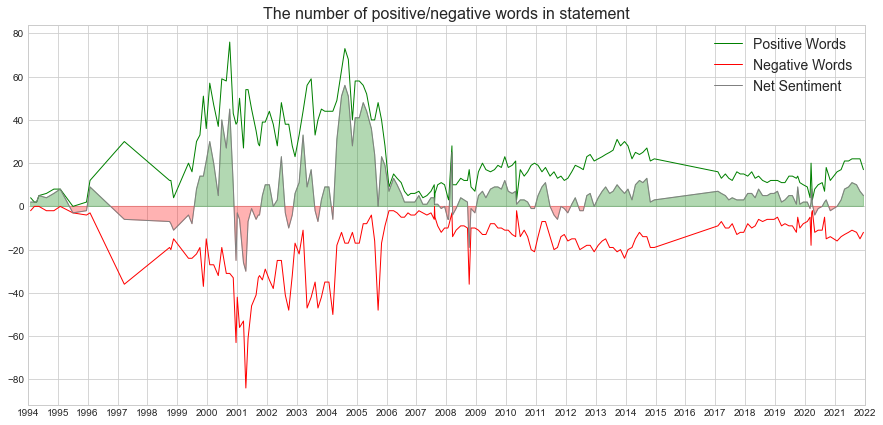

In [14]:
NetSentiment = Data['NPositiveWords'] - Data['NNegativeWords']

plt.figure(figsize=(15,7))
ax = plt.subplot()

plt.plot(Data.index, Data['NPositiveWords'], c='green', linewidth= 1.0)
plt.plot(Data.index, Data['NNegativeWords']*-1, c='red', linewidth=1.0)
plt.plot(Data.index, NetSentiment, c='grey', linewidth=1.0)

plt.title('The number of positive/negative words in statement', fontsize=16)
plt.legend(['Positive Words', 'Negative Words', 'Net Sentiment'], prop={'size': 14}, loc=1)

ax.fill_between(Data.index, NetSentiment, where=(NetSentiment > 0), color='green', alpha=0.3, interpolate=True)
ax.fill_between(Data.index, NetSentiment, where=(NetSentiment <= 0), color='red', alpha=0.3, interpolate=True)

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

ax.grid(True)

plt.show()

Positive and negative word counts highly correlate... probably because of the total number of words varies. Take the positive - negative as Net Sentiment.

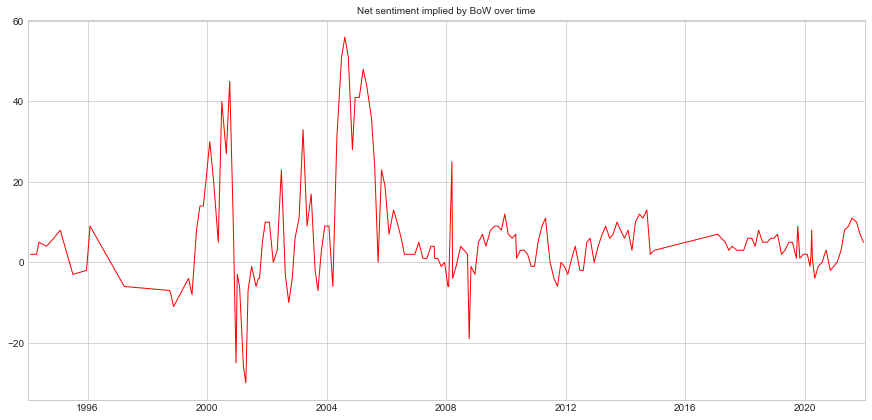

In [15]:
NetSentiment = Data['NPositiveWords'] - Data['NNegativeWords']

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(Data.index, NetSentiment, 
         c = 'red',
         linewidth= 1.0)

plt.title('Net sentiment implied by BoW over time',size = 'medium')

# format the ticks
# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

Plot derivative to see the changes in net sentiment

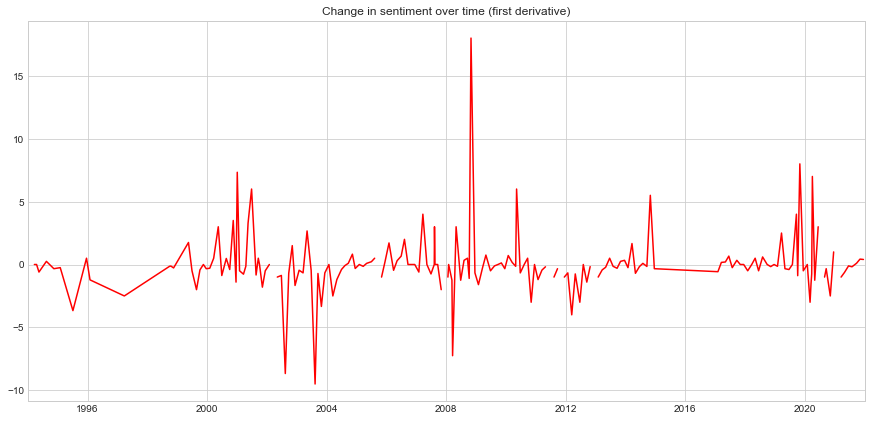

In [16]:
firstderivative = (NetSentiment.shift(1) - NetSentiment) / NetSentiment

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(Data.index, firstderivative, 
         c = 'red')

plt.title('Change in sentiment over time (first derivative)')

# format the ticks
# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

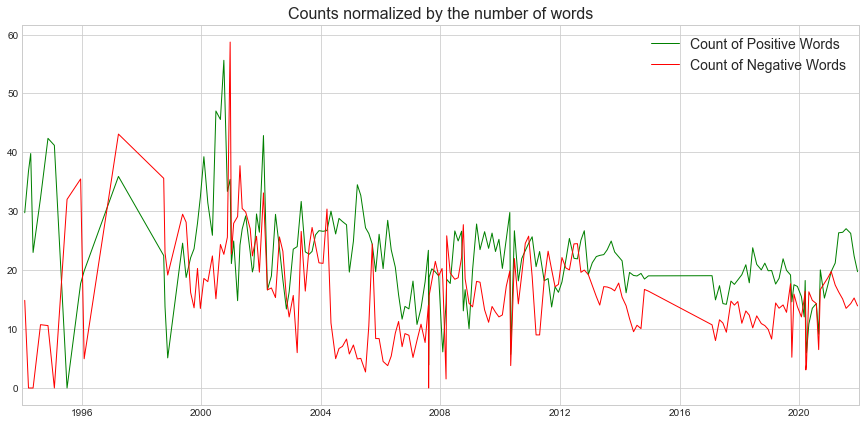

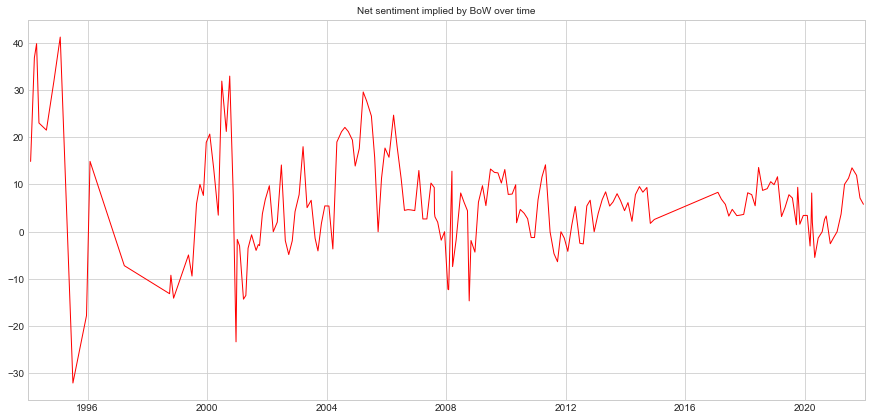

In [17]:
# Normalize data
NPositiveWordsNorm = Data['NPositiveWords'] / Data['wordcount'] * np.mean(Data['wordcount'])
NNegativeWordsNorm = Data['NNegativeWords'] / Data['wordcount'] * np.mean(Data['wordcount'])
NetSentimentNorm = (NPositiveWordsNorm - NNegativeWordsNorm)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(Data.index, NPositiveWordsNorm, c='green', linewidth= 1.0)
plt.plot(Data.index, NNegativeWordsNorm, c='red', linewidth=1.0)

plt.title('Counts normalized by the number of words', fontsize=16)
plt.legend(['Count of Positive Words', 'Count of Negative Words'],
           prop={'size': 14},
           loc = 1
           )

# format the ticks
# round to nearest years.
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.show()


fig, ax = plt.subplots(figsize=(15,7))
ax.plot(Data.index, NetSentimentNorm, c='red', linewidth=1.0)

plt.title('Net sentiment implied by BoW over time',size = 'medium')

# format the ticks
# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

### Function for extracting the direction of the rate change (hike, keep, lower)

Gets Basis Points Move and End Rate Value for Fed Rate and Discount Rate as well as Preferred Fed Rate Move from Statement Text

$\color{red}{Note:}$ The below functions could not be used in the analysis.  

In [18]:
import nltk.data
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def ExtractKeyValues(text):
    
    '''
    First, the text is tokenized in to sentences and the fed funds target rate sentence is extracted 
    Secondly, the decision whether the fed target rate was hiked, kept or lowered is retreived to RateHike variable
    Third, the target rate range is extracted and saved in TargetRange (The max is extracted as it conveys most info)
    '''
    
    Potentials = [] #For storing the potential decision sentences
        
    #Remove the \n and replace them with dots 
    text = text.replace('\\n','. ')
       
    #Split the text in to a list of sentences
    #Note: a sentence can have several sentences 
    paragraph_sentence_list = tokenizer.tokenize(text)
    #print('paragraph_sentence_list: ', paragraph_sentence_list)
        
    #Finds the sentences with the decisions 
    for Sentence in paragraph_sentence_list:
        
        #print('Sentence: ', Sentence)
        #Make the text lower case
        Sentence = Sentence.lower()

        if 'federal funds ' in Sentence and  'target'  in Sentence:
            
            #Check if it contains a number
            if bool(re.search(r'\d', Sentence)):
                
                Potentials.append(Sentence)
        
    Potentials = ''.join(Potentials)  # join potencial sentences with fed funds target rate 
    #print('Potentials: ', Potentials)

    
    #Look for decision words related to raising rates
    r = Potentials.find('rais')
    i = Potentials.find('increas')
    upscore = max([r,i])
    
    #Look for decision words related to keeping rates
    k = Potentials.find('keep')
    m = Potentials.find('maintain')
    r = Potentials.find('remain')
    c = Potentials.find('current')
    keepscore = max([r,k,m,c])
    
    #Look for decision words related to decreasing rates
    l = Potentials.find('lower')
    d = Potentials.find('decreas')
    lowerscore = max([l,d])
    
    Summary = {1:upscore,
              0: keepscore,
              -1:lowerscore
              }
        
    #take the key that was mentioned first in the text
    RateHike = max(Summary.keys(), key=(lambda x: Summary[x]))

    #For extracting the target range 
    def RangeReader(Nums):
        
        def FractionReader(Fraction):
            
            '''
            Converts the fraction to a float
            ''' 
            i = 0
            if '/' in Fraction:
                if ' ' in Fraction:
                    i, Fraction = Fraction.split(' ')
                if '-' in Fraction:
                    i, Fraction = Fraction.split('-')
                if '‑' in Fraction:
                    i, Fraction = Fraction.split('‑')
                N, D = Fraction.split('/')
                return float(i) + float(N) / float(D)
            
            else:
                return float(i)+float(Fraction)
        
        #Splits the range based on to or -
        Splitters = [' to ','-']
        
        for Splitter in Splitters:
            if Splitter in Nums:
                TargetRange = Nums.split(Splitter)
                return FractionReader(TargetRange[0]), FractionReader(TargetRange[1])
        
        #If there was no splitter in the range (no range)
        return FractionReader(Nums)
        
        
    #Find the percentage change and take the closest digits
    Rate = Potentials[ : Potentials.find('percent') -1 ]
    Rate = Rate[-16:]
    # print(Rate)
    if re.search("\d", Rate):
        Rate = Rate[ re.search("\d", Rate).start() : ]
        TargetRange = np.max(RangeReader(Rate))
    else:
        Rate = None
        TargetRange = None
      
    return RateHike, TargetRange

Appends decision, dummy and Moves and End Rate Values for Fed and Disc Rate also appends preferred fed rate Move while measuring the speed of the extraction

In [19]:
Data.tail()
#Data.drop(index=[pd.to_datetime("2020-03-03")], inplace=True)

contents        speaker  \
date                                                                           
2021-06-16  The Federal Reserve, the central bank of the U...  Jerome Powell   
2021-07-28  The Federal Reserve, the central bank of the U...  Jerome Powell   
2021-09-22  The Federal Reserve, the central bank of the U...  Jerome Powell   
2021-11-03  The Federal Reserve, the central bank of the U...  Jerome Powell   
2021-12-15  The Federal Reserve, the central bank of the U...  Jerome Powell   

                                                         text  Index  \
date                                                                   
2021-06-16  The Federal Reserve, the central bank of the U...    189   
2021-07-28  The Federal Reserve, the central bank of the U...    190   
2021-09-22  The Federal Reserve, the central bank of the U...    191   
2021-11-03  The Federal Reserve, the central bank of the U...    192   
2021-12-15  The Federal Reserve, the central bank of the U...    193   

            wordcount  NPositiveWords  NNegativeWords  sentiment  \
date                                                               
2021-06-16        585              21              12   1.538462   
2021-07-28        599              22              11   1.836394   
2021-09-22        617              22              12   1.620746   
2021-11-03        723              22              15   0.968188   
2021-12-15        634              17              12   0.788644   

                                                     Poswords  \
date                                                            
2021-06-16  [stable, stability, progress, progress, strong...   
2021-07-28  [stable, stability, progress, strong, strength...   
2021-09-22  [stable, stability, progress, strong, strength...   
2021-11-03  [stable, stability, progress, strong, strength...   
2021-12-15  [stable, stability, progress, strong, strength...   

                                                     Negwords  
date                                                           
2021-06-16  [challenging, strong, adversely, weak, crisis,...  
2021-07-28  [challenging, strong, adversely, crisis, risks...  
2021-09-22  [challenging, strong, adversely, slowed, crisi...  
2021-11-03  [challenging, strong, adversely, slowed, imbal...  
2021-12-15  [challenging, strong, adversely, unemployment,...

Tried to take rate and decision from the statement text but it sometimes fails. Debugging takes time, so switch to use data instead of reading from text.

In [20]:
# import timeit

# start = timeit.timeit()

# #Append fed funds rates and decisions to dataframe
# Hikes = []
# TargetRate = []

# for i in range(len(Data)):
#     if Data.iloc[i,1] == True:
#         Hikes.append(np.nan)
#         TargetRate.append(np.nan)
#     else:
#         Hikes.append( ExtractKeyValues( Data.iloc[i,0] )[0] )
#         TargetRate.append( ExtractKeyValues( Data.iloc[i,0] )[1] )        
        
# Data['RateDecision'] = Hikes
# Data['FedFundRateEndValue'] = TargetRate

# end = timeit.timeit()

# print (str ( end - start ) + ' seconds elapsed for ' + str(i) + ' statements')

# Data.tail()

$\color{red}{Note: }$ After 2008, upper bound of fed rate range is used.  

In [21]:
# FRB changed to range from 2008. So use Upper side from 2008.
filename_till08 = '../data/MarketData/Quandl/FRED_DFEDTAR.csv'
filename_from08u = '../data/MarketData/Quandl/FRED_DFEDTARU.csv'
filename_from08l = '../data/MarketData/Quandl/FRED_DFEDTARL.csv'

fedtar = pd.read_csv(filename_till08, names=['Date', 'Rate'], header=0)
fedtaru = pd.read_csv(filename_from08u, names=['Date', 'Rate'], header=0)
fedtarl = pd.read_csv(filename_from08l, names=['Date', 'Rate'], header=0) # not used 
fedrate_df = pd.concat([fedtar, fedtaru], axis=0)
fedrate_df.index = pd.to_datetime(fedrate_df.Date, format="%Y-%m-%d")
fedrate_df.drop(columns=['Date'], inplace=True)
fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))
fedrate_df


/var/folders/mb/399h735x1zs3yswdfj_tqm68jcd560/T/ipykernel_8728/4178926917.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))


Rate
Date             
1982-09-27  10.25
1982-09-28  10.25
1982-09-29  10.25
1982-09-30  10.25
1982-10-01  10.00
...           ...
2022-01-15   0.25
2022-01-16   0.25
2022-01-17   0.25
2022-01-18   0.25
2022-01-19   0.25

[14360 rows x 1 columns]

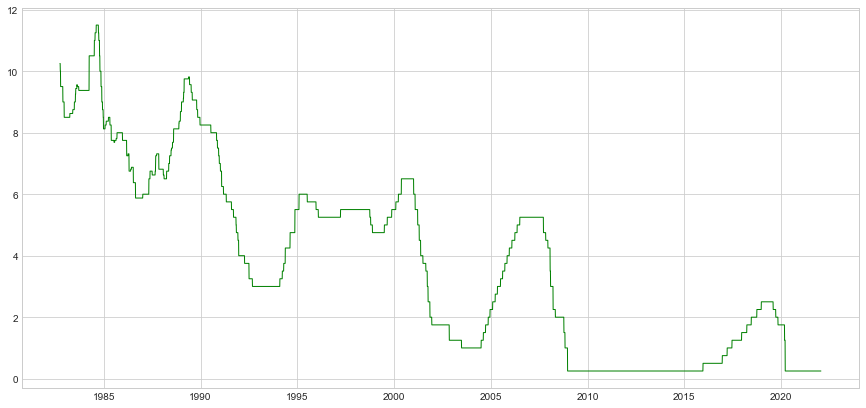

In [22]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(fedrate_df.index, fedrate_df['Rate'].values, c = 'green', linewidth= 1.0)
ax.grid(True)
plt.show()

In [23]:
Data.shape

(194, 10)

In [24]:
Data.head()

contents         speaker  \
date                                                                            
1994-02-04  \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1994-03-22  \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1994-04-18  \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1994-05-17  \n\n[SECTION]\n\nThe Federal Reserve today ann...  Alan Greenspan   
1994-08-16  \n\n[SECTION]\n\nThe Federal Reserve announced...  Alan Greenspan   

                                                         text  Index  \
date                                                                   
1994-02-04  Chairman Alan Greenspan announced today that t...      0   
1994-03-22  Chairman Alan Greenspan announced today that t...      1   
1994-04-18  Chairman Alan Greenspan announced today that t...      2   
1994-05-17  The Federal Reserve today announced two action...      3   
1994-08-16  The Federal Reserve announced today the follow...      4   

            wordcount  NPositiveWords  NNegativeWords  sentiment  \
date                                                               
1994-02-04         99               4               2   2.020202   
1994-03-22         40               2               0   5.000000   
1994-04-18         37               2               0   5.405405   
1994-05-17        160               5               0   3.125000   
1994-08-16        137               6               2   2.919708   

                                                     Poswords  \
date                                                            
1994-02-04           [increase, increase, enhance, expansion]   
1994-03-22                               [increase, increase]   
1994-04-18                               [increase, increase]   
1994-05-17  [favorable, expansion, increase, effective, in...   
1994-08-16  [strength, expansion, high, sustainable, growt...   

                            Negwords  
date                                  
1994-02-04  [less, misunderstanding]  
1994-03-22                        []  
1994-04-18                        []  
1994-05-17                        []  
1994-08-16          [against, least]

$\color {red}{Questions:}$ See comments below:

In [25]:
Data['RateDecision'] = None
Data['Rate'] = None

for i in range(len(Data)):
    for j in range(len(fedrate_df)):
        if Data.index[i] == fedrate_df.index[j]:
            Data['Rate'][i] = float(fedrate_df['Rate'][j+1])  #AK not sure why its; done this way -- j+1 is taken instead of j 
            if fedrate_df['Rate'][j-1] == fedrate_df['Rate'][j+1]:
                Data['RateDecision'][i] = 0
            elif fedrate_df['Rate'][j-1] < fedrate_df['Rate'][j+1]:
                Data['RateDecision'][i] = 1
            elif fedrate_df['Rate'][j-1] > fedrate_df['Rate'][j+1]:
                Data['RateDecision'][i] = -1  # AK Is my interpretation correct?  0 --> keep rate , 1 --> increase rate,and -1 --> decrease rate 

Data.head(10)

/var/folders/mb/399h735x1zs3yswdfj_tqm68jcd560/T/ipykernel_8728/2703188405.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Rate'][i] = float(fedrate_df['Rate'][j+1])  #AK not sure why its; done this way -- j+1 is taken instead of j
/var/folders/mb/399h735x1zs3yswdfj_tqm68jcd560/T/ipykernel_8728/2703188405.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['RateDecision'][i] = 1
/var/folders/mb/399h735x1zs3yswdfj_tqm68jcd560/T/ipykernel_8728/2703188405.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

contents         speaker  \
date                                                                            
1994-02-04  \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1994-03-22  \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1994-04-18  \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1994-05-17  \n\n[SECTION]\n\nThe Federal Reserve today ann...  Alan Greenspan   
1994-08-16  \n\n[SECTION]\n\nThe Federal Reserve announced...  Alan Greenspan   
1994-11-15  \n\n[SECTION]\n\nThe Federal Reserve Board tod...  Alan Greenspan   
1995-02-01  \n\n[SECTION]\n\nFor immediate release\n\n[SEC...  Alan Greenspan   
1995-07-06  \n\n[SECTION]\n\nFor immediate release\n\n[SEC...  Alan Greenspan   
1995-12-19  \n\n[SECTION]\n\nFor immediate release\n\n[SEC...  Alan Greenspan   
1996-01-31  For immediate release\n\n\n\n\n\n\r\n\r\nThe F...  Alan Greenspan   

                                                         text  Index  \
date                                                                   
1994-02-04  Chairman Alan Greenspan announced today that t...      0   
1994-03-22  Chairman Alan Greenspan announced today that t...      1   
1994-04-18  Chairman Alan Greenspan announced today that t...      2   
1994-05-17  The Federal Reserve today announced two action...      3   
1994-08-16  The Federal Reserve announced today the follow...      4   
1994-11-15  The Federal Reserve Board today approved an in...      5   
1995-02-01  For immediate releaseThe Federal Reserve Board...      6   
1995-07-06  For immediate releaseChairman Alan Greenspan a...      7   
1995-12-19  For immediate releaseChairman Alan Greenspan a...      8   
1996-01-31  For immediate release          The Federal Res...      9   

            wordcount  NPositiveWords  NNegativeWords  sentiment  \
date                                                               
1994-02-04         99               4               2   2.020202   
1994-03-22         40               2               0   5.000000   
1994-04-18         37               2               0   5.405405   
1994-05-17        160               5               0   3.125000   
1994-08-16        137               6               2   2.919708   
1994-11-15        139               8               2   4.316547   
1995-02-01        143               8               0   5.594406   
1995-07-06         69               0               3  -4.347826   
1995-12-19         83               2               4  -2.409639   
1996-01-31        445              12               3   2.022472   

                                                     Poswords  \
date                                                            
1994-02-04           [increase, increase, enhance, expansion]   
1994-03-22                               [increase, increase]   
1994-04-18                               [increase, increase]   
1994-05-17  [favorable, expansion, increase, effective, in...   
1994-08-16  [strength, expansion, high, sustainable, growt...   
1994-11-15  [increase, effective, increase, strength, high...   
1995-02-01  [increase, effective, increase, despite, growt...   
1995-07-06                                                 []   
1995-12-19                                  [more, favorable]   
1996-01-31  [effective, expansion, sustainable, growth, ef...   

                                       Negwords RateDecision  Rate  
date                                                                
1994-02-04             [less, misunderstanding]            1  3.25  
1994-03-22                                   []            1   3.5  
1994-04-18                                   []            1  3.75  
1994-05-17                                   []            1  4.25  
1994-08-16                     [against, least]            1  4.75  
1994-11-15                [against, persistent]            1   5.5  
1995-02-01                                   []            1   6.

In [26]:
def pickle_dump(df, filename='no-filename.pickle'):
    if filename:
        with open(filename, "wb") as output_file:
            pickle.dump(df, output_file)

### Plot the results and compare to the economical uncertainty / systemic risk periods

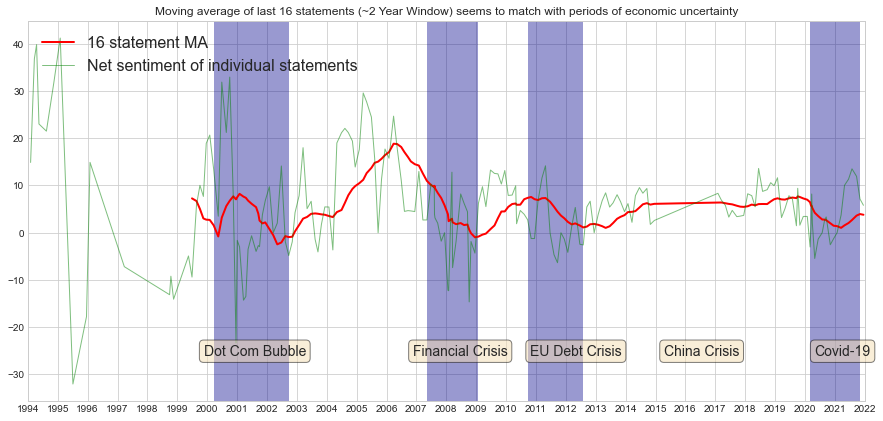

In [27]:
#Dot-com bubble
#https://en.wikipedia.org/wiki/Dot-com_bubble
DotCom = np.logical_and(Data.index > '2000-03', Data.index < '2002-10')

#Financial crisis of 2007–2008
#https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008
FinCrisis = np.logical_and(Data.index > '2007-04', Data.index < '2009-03')

#European debt crisis
#https://en.wikipedia.org/wiki/European_debt_crisis
EuroDebt = np.logical_and(Data.index > '2010-09', Data.index < '2012-09')

#2015–16 Chinese stock market turbulence
#https://en.wikipedia.org/wiki/2015%E2%80%9316_Chinese_stock_market_turbulence
Asian = np.logical_and(Data.index > '2015-01', Data.index < '2016-06')

#2020- Covid-19 Pandemic
#https://en.wikipedia.org/wiki/COVID-19_pandemic
Covid = np.logical_and(Data.index > '2020-02', Data.index < '2021-12')

Recessions = np.logical_or.reduce((DotCom, FinCrisis, EuroDebt, Asian, Covid))

Window = 16
CompToMA = NetSentimentNorm.rolling(Window).mean()

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(Data.index, CompToMA, c = 'r', linewidth= 2)
ax.plot(Data.index, NetSentimentNorm, c = 'green', linewidth= 1, alpha = 0.5)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.title( str('Moving average of last ' + str(Window) + ' statements (~2 Year Window) seems to match with periods of economic uncertainty'))

ax.legend([str(str(Window) + ' statement MA'), 'Net sentiment of individual statements'],
           prop={'size': 16},
           loc = 2
          )

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(Data.index, 0, 10, where = Recessions,
                facecolor='darkblue', alpha=0.4, transform=trans)

# Add text
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.21, 0.15, "Dot Com Bubble", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.46, 0.15, "Financial Crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.60, 0.15, "EU Debt Crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.76, 0.15, "China Crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.94, 0.15, "Covid-19", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.show()

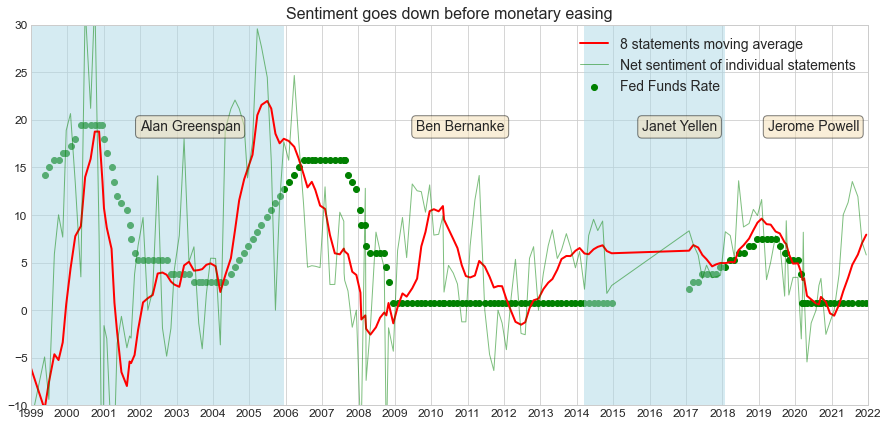

In [28]:
# Speaker window
Greenspan = np.logical_and(Data.index > '1987-08-11', Data.index < '2006-01-31')
Bernanke = np.logical_and(Data.index > '2006-02-01', Data.index < '2014-01-31')
Yellen = np.logical_and(Data.index > '2014-02-03', Data.index < '2018-02-03')
Powell = np.logical_and(Data.index > '2018-02-05', Data.index < '2022-02-05')
Speaker = np.logical_or.reduce((Greenspan, Yellen))

# Moving Average
Window = 8
CompToMA = NetSentimentNorm.rolling(Window).mean()

# Plotting Data
fig, ax = plt.subplots(figsize=(15,7))
plt.title('Sentiment goes down before monetary easing', fontsize=16)

ax.scatter(Data.index, Data['Rate']*3, c = 'g')
ax.plot(Data.index, CompToMA, c = 'r', linewidth= 2.0)
ax.plot(Data.index, NetSentimentNorm,  c = 'green', linewidth= 1, alpha = 0.5)
ax.legend([str(str(Window) + ' statements moving average'),
           'Net sentiment of individual statements',
           'Fed Funds Rate'], prop={'size': 14}, loc = 1)

# Format X-axis
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# Set X-axis and Y-axis range
datemin = np.datetime64(Data.index[18], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)
ax.set_ylim(-10,30)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=12)

# Fill speaker
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(Data.index, 0, 10, where = Speaker, facecolor='lightblue', alpha=0.5, transform=trans)

# Add text
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.13, 0.75, "Alan Greenspan", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.46, 0.75, "Ben Bernanke", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.73, 0.75, "Janet Yellen", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.88, 0.75, "Jerome Powell", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

# # Add annotations
# arrow_style = dict(facecolor='black', edgecolor='white', shrink=0.05)
# ax.annotate('QE1', xy=('2008-11-25', 0), xytext=('2008-11-25', -4), size=12, ha='right', arrowprops=arrow_style)
# ax.annotate('QE1+', xy=('2009-03-18', 0), xytext=('2009-03-18', -6), size=12, ha='center', arrowprops=arrow_style)
# ax.annotate('QE2', xy=('2010-11-03', 0), xytext=('2010-11-03', -4), size=12, ha='center', arrowprops=arrow_style)
# ax.annotate('QE2+', xy=('2011-09-21', 0), xytext=('2011-09-21', -4.5), size=12, ha='center', arrowprops=arrow_style)
# ax.annotate('QE2+', xy=('2012-06-20', 0), xytext=('2012-06-20', -6.5), size=12, ha='right', arrowprops=arrow_style)
# ax.annotate('QE3', xy=('2012-09-13', 0), xytext=('2012-09-13', -8), size=12, ha='center', arrowprops=arrow_style)
# ax.annotate('Tapering', xy=('2013-12-18', 0), xytext=('2013-12-18', -8), size=12, ha='center', arrowprops=arrow_style)

plt.show()

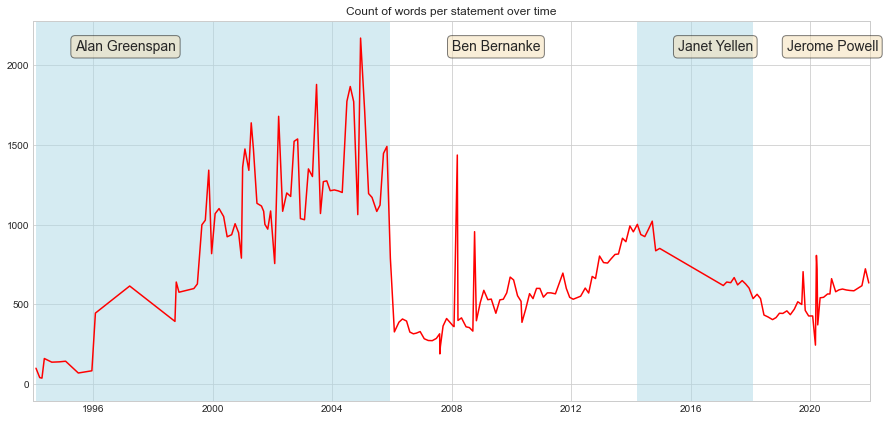

In [29]:
fig, ax = plt.subplots(figsize=(15,7))

Count = Data['wordcount']

ax.plot(Data.index, Count, 
         c = 'red',
         linewidth= 1.5)



plt.title('Count of words per statement over time')

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(Data.index, 0, 10, where = Speaker,
                facecolor='lightblue', alpha=0.5, transform=trans)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, "Alan Greenspan", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(0.50, 0.95, "Ben Bernanke", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(0.77, 0.95, "Janet Yellen", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(0.90, 0.95, "Jerome Powell", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

# Preprocess Non-textual Data

In [30]:
# # Check module locations if required
# import sys
# import pprint
# pprint.pprint(sys.path)

In [31]:
import numpy as np
import pandas as pd
import datetime 
import os
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pickle
from tqdm.notebook import tqdm
import re

In [32]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')
sns.set(style='white', context='notebook', palette='deep')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

## Load FOMC Meeting
### Chairpersons

In [33]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2022,2,5)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

Surname FirstName   FromDate     ToDate
0    Volcker      Paul 1979-08-06 1987-08-10
1  Greenspan      Alan 1987-08-11 2006-01-31
2   Bernanke       Ben 2006-02-01 2014-01-31
3     Yellen     Janet 2014-02-03 2018-02-03
4     Powell    Jerome 2018-02-05 2022-02-05

In [34]:
# def get_chairperson(x):
#     '''
#     Return a tuple of chairperson's Fullname for the given date x.
#     '''
#     # If x is string, convert to datetime
#     if type(x) is str:
#         try:
#             x = dt.datetime.strftime(x, '%Y-%m-%d')
#         except:
#             return None
    
#     chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
#     return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

$\color {red}{Note:}$ Fixed the big in the `get_chairperson` function 

In [35]:
def get_chairperson(x):
    '''
    Return a tuple of chairperson's Fullname for the given date x.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try: 
            x = datetime.datetime.strptime(x, '%Y-%m-%d')
        except: 
            return None
    
    chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

In [36]:
print(get_chairperson('2021-01-05'))

Jerome Powell


### Load Calendar

In [37]:
file = open('../data/FOMC/fomc_calendar.pickle', 'rb')

fomc_calendar = pd.read_pickle(file)
file.close()

print(fomc_calendar.shape)
fomc_calendar

(446, 4)


date  unscheduled  forecast  confcall
0   1980-01-09        False     False     False
1   1980-02-05        False     False     False
2   1980-02-22        False     False      True
3   1980-03-07        False     False      True
4   1980-03-18        False     False     False
..         ...          ...       ...       ...
441 2022-06-15        False      True     False
442 2022-07-27        False     False     False
443 2022-09-21        False      True     False
444 2022-11-02        False     False     False
445 2022-12-14        False      True     False

[446 rows x 4 columns]

In [38]:
# Take data after 1982/09/27
fomc_calendar = fomc_calendar.loc[fomc_calendar['date'] >= datetime.datetime(1982, 9, 27)]

# Use date as index
fomc_calendar.set_index('date', inplace=True)
fomc_calendar.head()

unscheduled  forecast  confcall
date                                       
1982-10-05        False     False     False
1982-11-16        False     False     False
1982-12-21        False     False     False
1983-01-14        False     False      True
1983-01-21        False     False      True

### Add Chairperson to Calendar

In [39]:
fomc_calendar.index

DatetimeIndex(['1982-10-05', '1982-11-16', '1982-12-21', '1983-01-14',
               '1983-01-21', '1983-01-28', '1983-02-09', '1983-03-29',
               '1983-04-29', '1983-05-24',
               ...
               '2021-11-03', '2021-12-15', '2022-01-26', '2022-03-16',
               '2022-05-04', '2022-06-15', '2022-07-27', '2022-09-21',
               '2022-11-02', '2022-12-14'],
              dtype='datetime64[ns]', name='date', length=403, freq=None)

In [40]:
# fomc_calendar['ChairPerson'] = fomc_calendar.index.map(get_chairperson)
# fomc_calendar

## Load Market Data

#### Download from Quandl
Quandl provide APIs and library for each data access to multiple sources.
Created a python function to download data, so please execute it first. api_key can be found on your Quandl Account.

` python QuandlGetData.py [api_key] 1980-01-01 `

Also, it can be accessed via Web API.
```
import quandl
import getpass

# Enter Quandle API Key
quandl.ApiConfig.api_key = getpass.getpass('Enter your API Key for Quandl')

data = quandl.get("FRED/DFEDTAR", start_date="1980-01-01")
```

In [41]:
# FRB changed to range from 2008. So use lower side from 2008 as facing lower bound of zero.
filename_till08 = '../data/MarketData/Quandl/FRED_DFEDTAR.csv'
filename_from08u = '../data/MarketData/Quandl/FRED_DFEDTARU.csv'
filename_from08l = '../data/MarketData/Quandl/FRED_DFEDTARL.csv'

fedtar = pd.read_csv(filename_till08, names=['Date', 'Rate'], header=0)
fedtaru = pd.read_csv(filename_from08u, names=['Date', 'Rate'], header=0)
fedtarl = pd.read_csv(filename_from08l, names=['Date', 'Rate'], header=0)
fedrate_df = pd.concat([fedtar, fedtarl], axis=0)
fedrate_df.index = pd.to_datetime(fedrate_df.Date, format="%Y-%m-%d")
fedrate_df.drop(columns=['Date'], inplace=True)
fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))
# Add difference from previous value
fedrate_df['diff'] = fedrate_df['Rate'].diff()

fedrate_df

/var/folders/mb/399h735x1zs3yswdfj_tqm68jcd560/T/ipykernel_8728/1461422323.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))


Rate  diff
Date                   
1982-09-27  10.25   NaN
1982-09-28  10.25  0.00
1982-09-29  10.25  0.00
1982-09-30  10.25  0.00
1982-10-01  10.00 -0.25
...           ...   ...
2022-01-15   0.00  0.00
2022-01-16   0.00  0.00
2022-01-17   0.00  0.00
2022-01-18   0.00  0.00
2022-01-19   0.00  0.00

[14360 rows x 2 columns]

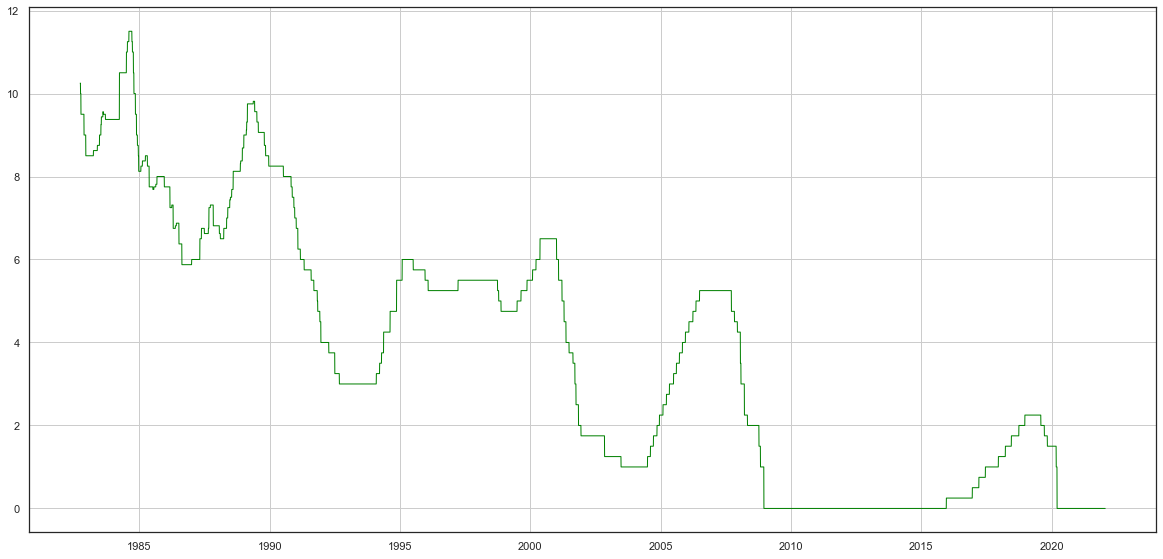

In [42]:
fig, ax = plt.subplots()
ax.plot(fedrate_df.index, fedrate_df['Rate'].values, 
         c = 'green',
         linewidth= 1.0)
ax.grid(True)
plt.show()

### Effective FED Rate

In [43]:
# Load FED Effective

filename = '../data/MarketData/Quandl/FRED_DFF.csv'

dff = pd.read_csv(filename, names=['DATE', 'DFF'], header=0)
dff = dff.set_index(pd.to_datetime(dff['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
dff['diff'] = dff['DFF'].diff()
dff

DFF  diff
DATE                   
1980-01-01  14.77   NaN
1980-01-02  14.00 -0.77
1980-01-03  13.89 -0.11
1980-01-04  14.00  0.11
1980-01-05  14.00  0.00
...           ...   ...
2022-01-15   0.08  0.00
2022-01-16   0.08  0.00
2022-01-17   0.08  0.00
2022-01-18   0.08  0.00
2022-01-19   0.08  0.00

[15360 rows x 2 columns]

(512, 2)


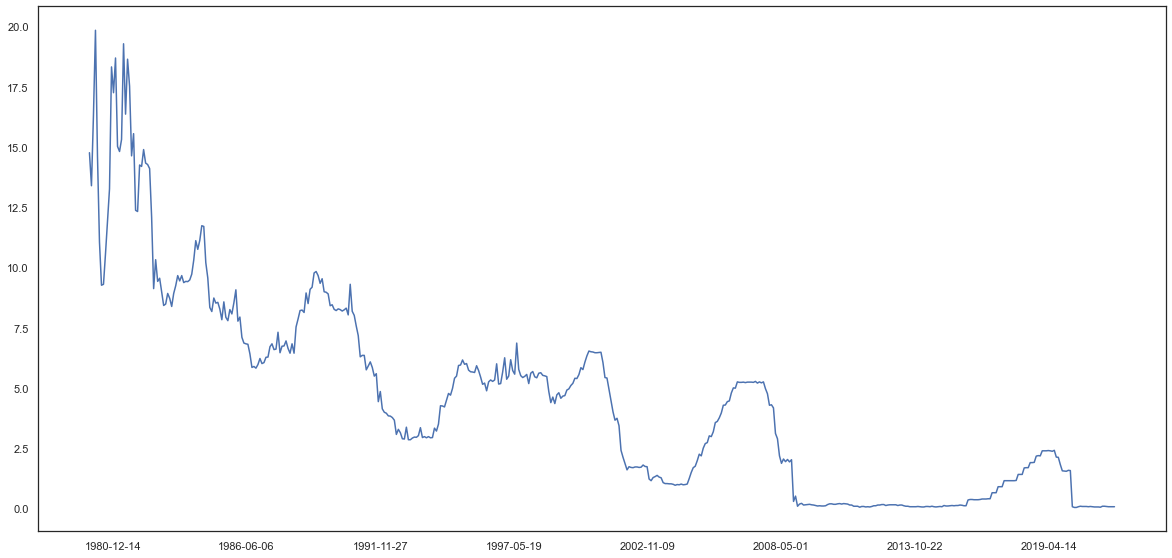

In [44]:
# Use every 30th row as it has too many data points
dff_30 = dff.iloc[::30, :]
print(dff_30.shape)

fig, ax = plt.subplots()
ax.plot(dff_30.index.values, dff_30['DFF'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

## Load Economic Indices

### GDP

Real GDP, Quarterly announced

In [45]:
# Load Real GDP
# Billions of Chained 2012 Dollars, Seasonally Adjusted Annual Rate

filename = '../data/MarketData/Quandl/FRED_GDPC1.csv'

gdpc1 = pd.read_csv(filename, names=['DATE', 'GDPC1'], header=0)
gdpc1 = gdpc1.set_index(pd.to_datetime(gdpc1['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
gdpc1['diff_prev'] = gdpc1['GDPC1'].diff() / gdpc1['GDPC1'].shift(1) * 100 # quarterly change 
gdpc1['diff_year'] = gdpc1['GDPC1'].diff(periods=4) / gdpc1['GDPC1'].shift(4) * 100 # annual change 
gdpc1

GDPC1  diff_prev  diff_year
DATE                                       
1980-01-01   6842.024        NaN        NaN
1980-04-01   6701.046  -2.060472        NaN
1980-07-01   6693.082  -0.118847        NaN
1980-10-01   6817.903   1.864926        NaN
1981-01-01   6951.495   1.959429   1.599980
...               ...        ...        ...
2020-07-01  18560.774   7.547535  -2.887506
2020-10-01  18767.778   1.115277  -2.262915
2021-01-01  19055.655   1.533890   0.546977
2021-04-01  19368.310   1.640747  12.226677
2021-07-01  19478.893   0.570948   4.946556

[167 rows x 3 columns]

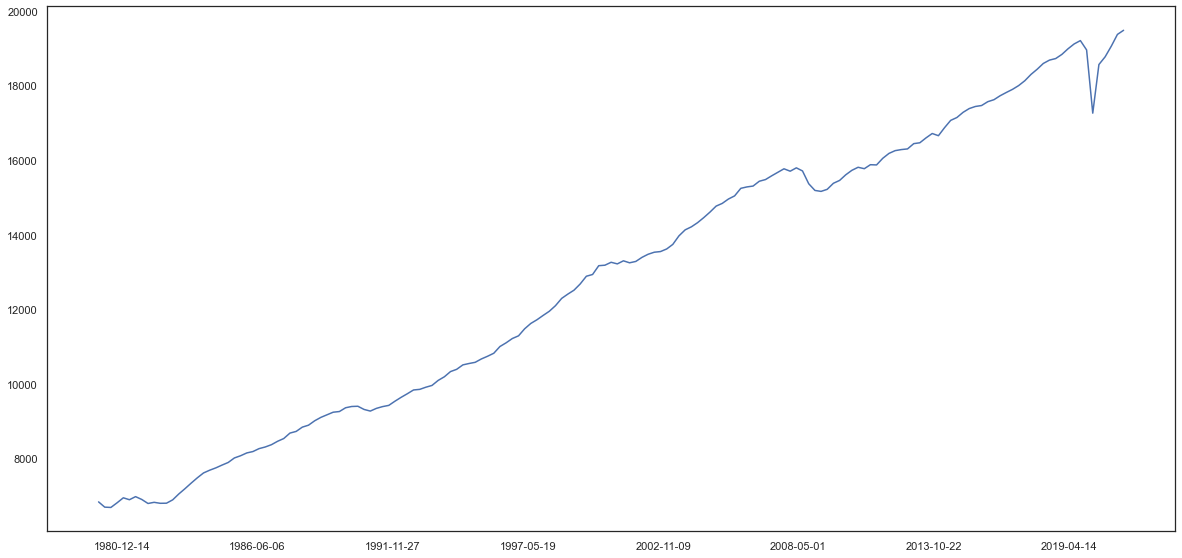

In [46]:
fig, ax = plt.subplots()
ax.plot(gdpc1.index.values, gdpc1['GDPC1'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Potential GDP

In [47]:
# Load Real Potential GDP
# Billions of Chained 2012 Dollars, Not Seasonally Adjusted, adjusted for inflation 

filename = '../data/MarketData/Quandl/FRED_GDPPOT.csv'

gdppot = pd.read_csv(filename, names=['DATE', 'GDPPOT'], header=0)
gdppot = gdppot.set_index(pd.to_datetime(gdppot['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
gdppot['diff_prev'] = gdppot['GDPPOT'].diff() / gdppot['GDPPOT'].shift(1) * 100
gdppot['diff_year'] = gdppot['GDPPOT'].diff(periods=4) / gdppot['GDPPOT'].shift(4) * 100
gdppot

GDPPOT  diff_prev  diff_year
DATE                                          
1980-01-01   6847.481683        NaN        NaN
1980-04-01   6890.146039   0.623066        NaN
1980-07-01   6928.061362   0.550283        NaN
1980-10-01   6968.010712   0.576631        NaN
1981-01-01   7012.104757   0.632807   2.404140
...                  ...        ...        ...
2030-10-01  23423.370000   0.423458   1.708386
2031-01-01  23522.550000   0.423423   1.706249
2031-04-01  23622.050000   0.422998   1.704632
2031-07-01  23721.650000   0.421640   1.702280
2031-10-01  23821.310000   0.420123   1.698902

[208 rows x 3 columns]

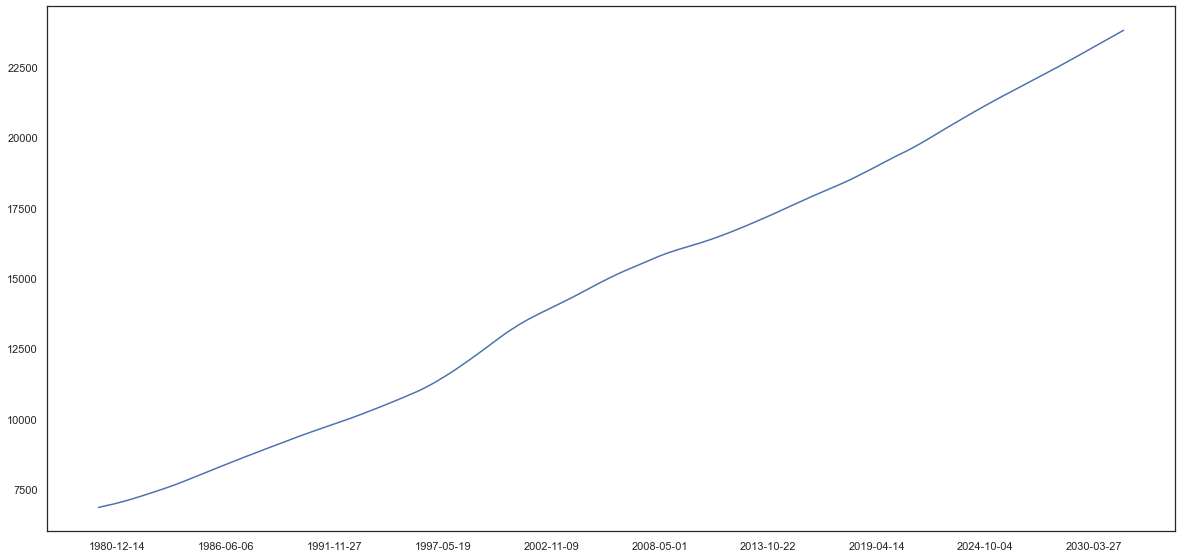

In [48]:
fig, ax = plt.subplots()
ax.plot(gdppot.index.values, gdppot['GDPPOT'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Personal Consumption: PCE

Use Core PCE excluding Food and Energy as FRB takes this index as important indicator. <BR />
It is announced monthly around the last working days of each month for the previous month.

In [49]:
# Load Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index)
# Index 2012=100, Seasonally Adjusted, Monthly 

filename = '../data/MarketData/Quandl/FRED_PCEPILFE.csv'

pcepilfe = pd.read_csv(filename, names=['DATE', 'PCEPILFE'], header=0)
pcepilfe = pcepilfe.set_index(pd.to_datetime(pcepilfe['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
pcepilfe['diff_prev'] = pcepilfe['PCEPILFE'].diff() / pcepilfe['PCEPILFE'].shift(1) * 100
pcepilfe['diff_year'] = pcepilfe['PCEPILFE'].diff(periods=12) / pcepilfe['PCEPILFE'].shift(12) * 100
pcepilfe

PCEPILFE  diff_prev  diff_year
DATE                                      
1980-01-01    39.095        NaN        NaN
1980-02-01    39.485   0.997570        NaN
1980-03-01    39.851   0.926934        NaN
1980-04-01    40.056   0.514416        NaN
1980-05-01    40.378   0.803875        NaN
...              ...        ...        ...
2021-07-01   117.704   0.321324   3.603556
2021-08-01   118.073   0.313498   3.599161
2021-09-01   118.357   0.240529   3.702763
2021-10-01   118.921   0.476524   4.191454
2021-11-01   119.470   0.461651   4.675206

[503 rows x 3 columns]

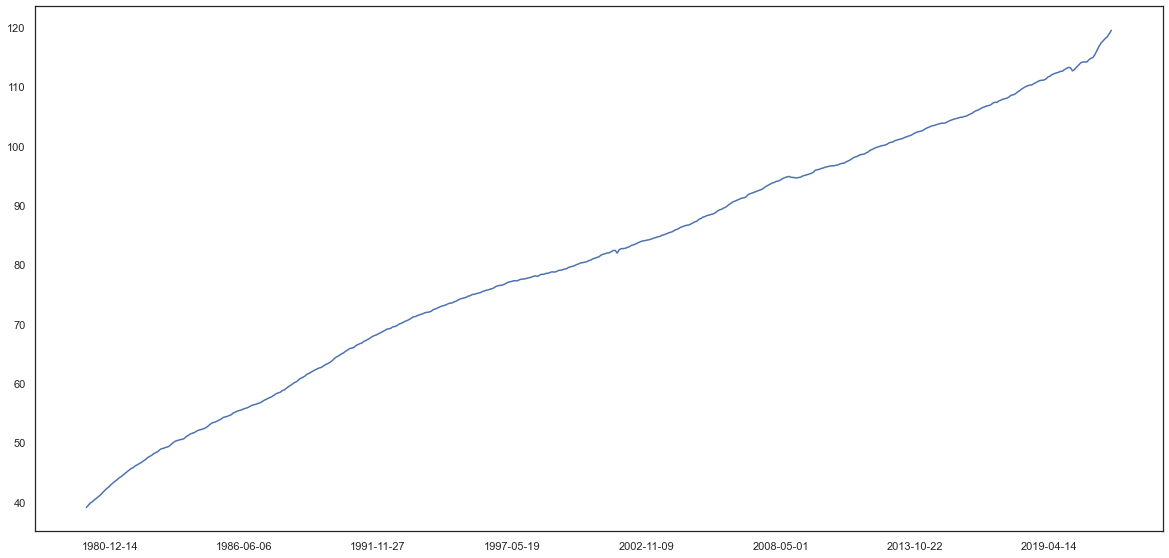

In [50]:
fig, ax = plt.subplots()
ax.plot(pcepilfe.index.values, pcepilfe['PCEPILFE'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Personal Consumption: CPI

CPI's coverage is less than PCE but announced monthly around 10th of each month for the previous month, which is earlier than PCE. <BR />
As this is available to some meetings even before PCE announcement, take this index as well.

In [51]:
# Load Consumer Price Index for All Urban Consumers: All Items in U.S. City Average
# Index 1982-1984=100, Seasonally Adjusted

filename = '../data/MarketData/Quandl/FRED_CPIAUCSL.csv'

cpiaucsl = pd.read_csv(filename, names=['DATE', 'CPIAUCSL'], header=0)
cpiaucsl = cpiaucsl.set_index(pd.to_datetime(cpiaucsl['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
cpiaucsl['diff_prev'] = cpiaucsl['CPIAUCSL'].diff() / cpiaucsl['CPIAUCSL'].shift(1) * 100
cpiaucsl['diff_year'] = cpiaucsl['CPIAUCSL'].diff(periods=12) / cpiaucsl['CPIAUCSL'].shift(12) * 100
cpiaucsl


CPIAUCSL  diff_prev  diff_year
DATE                                      
1980-01-01    78.000        NaN        NaN
1980-02-01    79.000   1.282051        NaN
1980-03-01    80.100   1.392405        NaN
1980-04-01    80.900   0.998752        NaN
1980-05-01    81.700   0.988875        NaN
...              ...        ...        ...
2021-08-01   273.012   0.274365   5.202477
2021-09-01   274.138   0.412436   5.377303
2021-10-01   276.724   0.943321   6.243521
2021-11-01   278.880   0.779116   6.880468
2021-12-01   280.192   0.470453   7.123413

[504 rows x 3 columns]

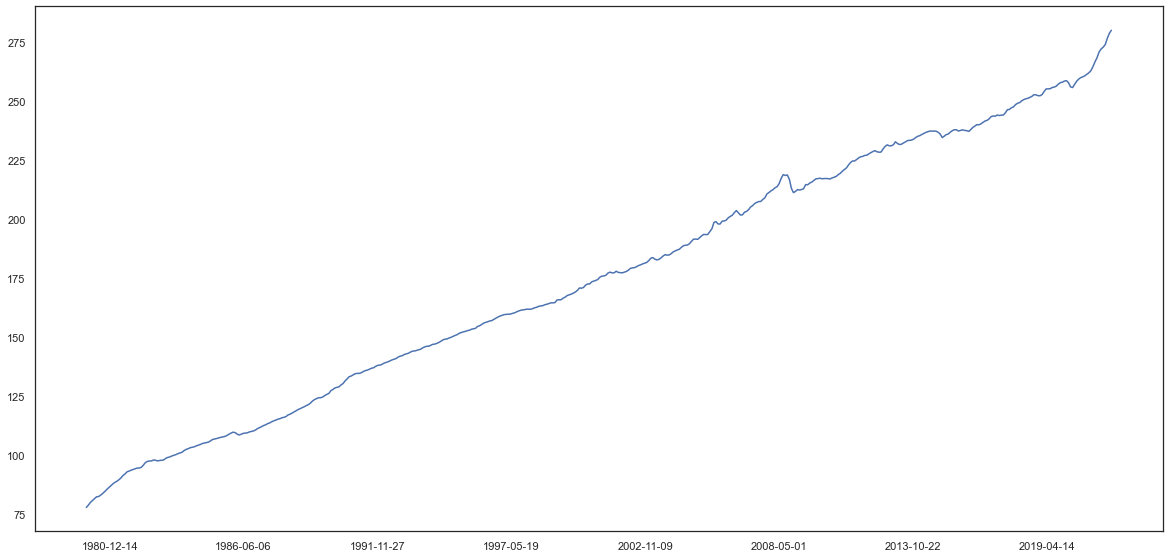

In [52]:
fig, ax = plt.subplots()
ax.plot(cpiaucsl.index.values, cpiaucsl['CPIAUCSL'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Unemployment

Takes unemployment rate as important input for FRB's decision. Real Potential GDP is quarterly and usually two month after each quarter. On the other hand, unemployment is annnounced monthly, around a week after the end of each month and can be more real-time. <BR />
As bigger number indicates negative, turn the sign to have negative number.

In [53]:
# Load Unemployment
# Percent, Seasonally Adjusted

filename = '../data/MarketData/Quandl/FRED_UNRATE.csv'

unrate = pd.read_csv(filename, names=['DATE', 'UNRATE'], header=0)
unrate = unrate.set_index(pd.to_datetime(unrate['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
unrate['UNRATE'] = unrate['UNRATE'] * -1
# Add difference from previous value
unrate['diff_prev'] = unrate['UNRATE'].diff()
unrate['diff_year'] = unrate['UNRATE'].diff(periods=12)
unrate

UNRATE  diff_prev  diff_year
DATE                                    
1980-01-01    -6.3        NaN        NaN
1980-02-01    -6.3        0.0        NaN
1980-03-01    -6.3        0.0        NaN
1980-04-01    -6.9       -0.6        NaN
1980-05-01    -7.5       -0.6        NaN
...            ...        ...        ...
2021-08-01    -5.2        0.2        3.2
2021-09-01    -4.7        0.5        3.2
2021-10-01    -4.6        0.1        2.3
2021-11-01    -4.2        0.4        2.5
2021-12-01    -3.9        0.3        2.8

[504 rows x 3 columns]

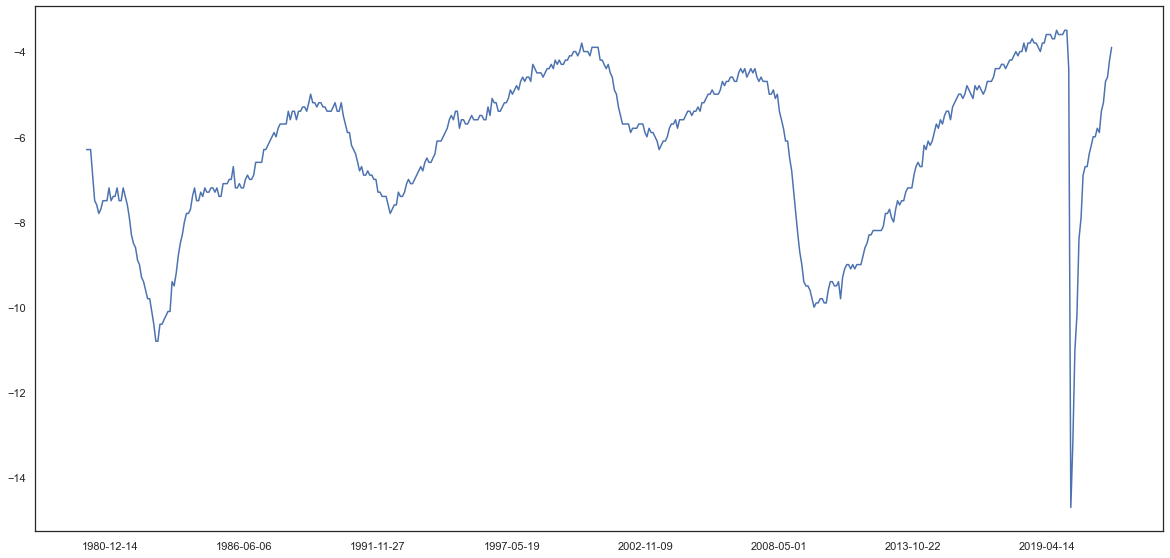

In [54]:
fig, ax = plt.subplots()
ax.plot(unrate.index.values, unrate['UNRATE'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Employment

Total Nonfarm, commonly known as Total Nonfarm Payroll, is a measure of the number of U.S. workers in the economy that excludes proprietors, private household employees, unpaid volunteers, farm employees, and the unincorporated self-employed. This measure accounts for approximately 80 percent of the workers who contribute to Gross Domestic Product (GDP).

In [55]:
# Load Employment
# Seasonally Adjusted

filename = '../data/MarketData/Quandl/FRED_PAYEMS.csv'

payems = pd.read_csv(filename, names=['DATE', 'PAYEMS'], header=0)
payems = payems.set_index(pd.to_datetime(payems['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
payems['diff_prev'] = payems['PAYEMS'].diff()
payems['diff_year'] = payems['PAYEMS'].diff(periods=12)
payems

PAYEMS  diff_prev  diff_year
DATE                                      
1980-01-01   90800.0        NaN        NaN
1980-02-01   90883.0       83.0        NaN
1980-03-01   90994.0      111.0        NaN
1980-04-01   90849.0     -145.0        NaN
1980-05-01   90420.0     -429.0        NaN
...              ...        ...        ...
2021-08-01  147476.0      483.0     6327.0
2021-09-01  147855.0      379.0     5990.0
2021-10-01  148503.0      648.0     5958.0
2021-11-01  148752.0      249.0     5943.0
2021-12-01  148951.0      199.0     6448.0

[504 rows x 3 columns]

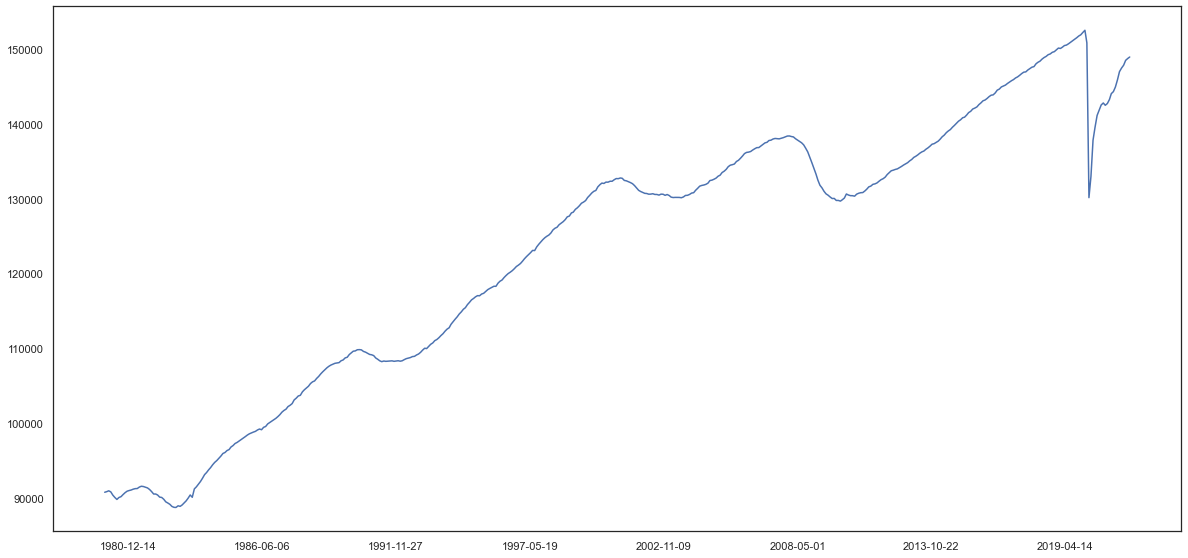

In [56]:
fig, ax = plt.subplots()
ax.plot(payems.index.values, payems['PAYEMS'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

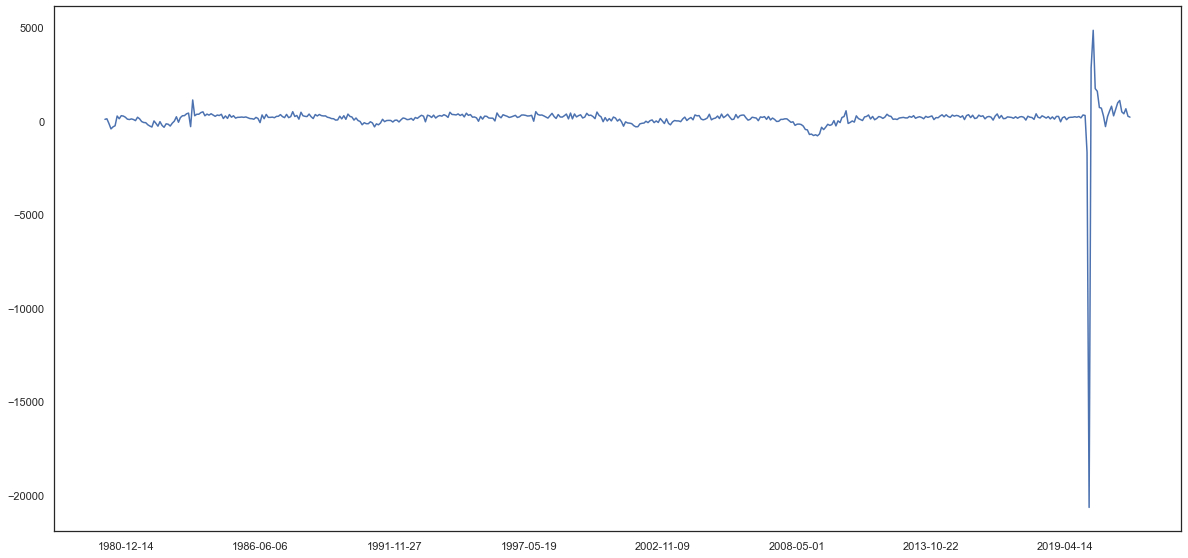

In [57]:
fig, ax = plt.subplots()
ax.plot(payems.index.values, payems['diff_prev'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### ISM Purchasing Managers Index / Non-manufacturing Index

Another important indicator of the economy, also announced monthly right after the end of each month.

In [58]:
# Load ISM (Institute for Summply Management) PMI
filename = '../data/MarketData/Quandl/ISM_MAN_PMI.csv'

ism_pmi = pd.read_csv(filename, names=['Date', 'PMI'], header=0)
ism_pmi = ism_pmi.sort_values(by=['Date'], ascending=True)
ism_pmi = ism_pmi.set_index(pd.to_datetime(ism_pmi['Date'], format="%Y-%m-%d")).drop(columns=['Date'])
# Add difference from previous value
ism_pmi['diff_prev'] = ism_pmi['PMI'].diff()
ism_pmi['diff_year'] = ism_pmi['PMI'].diff(periods=12)
ism_pmi

PMI  diff_prev  diff_year
Date                                  
1980-01-01  46.2        NaN        NaN
1980-02-01  50.2        4.0        NaN
1980-03-01  43.6       -6.6        NaN
1980-04-01  37.4       -6.2        NaN
1980-05-01  29.4       -8.0        NaN
...          ...        ...        ...
2021-08-01  59.9        0.4        4.3
2021-09-01  61.1        1.2        5.4
2021-10-01  60.8       -0.3        2.0
2021-11-01  61.1        0.3        3.4
2021-12-01  58.7       -2.4       -1.8

[504 rows x 3 columns]

In [59]:
# Load ISM NMI
filename = '../data/MarketData/Quandl/ISM_NONMAN_NMI.csv'

ism_nmi = pd.read_csv(filename, names=['Date', 'NMI'], header=0)
ism_nmi = ism_nmi.sort_values(by=['Date'], ascending=True)
ism_nmi.columns = ['Date', 'NMI']
ism_nmi = ism_nmi.set_index(pd.to_datetime(ism_nmi['Date'], format="%Y-%m-%d")).drop(columns=['Date'])
# Add difference from previous value
ism_nmi['diff_prev'] = ism_nmi['NMI'].diff()
ism_nmi['diff_year'] = ism_nmi['NMI'].diff(periods=12)
ism_nmi

NMI  diff_prev  diff_year
Date                                  
2008-01-01  45.0        NaN        NaN
2008-02-01  49.9        4.9        NaN
2008-03-01  49.4       -0.5        NaN
2008-04-01  51.8        2.4        NaN
2008-05-01  51.4       -0.4        NaN
...          ...        ...        ...
2021-08-01  61.7       -2.4        4.5
2021-09-01  61.9        0.2        4.7
2021-10-01  66.7        4.8       10.5
2021-11-01  69.1        2.4       12.3
2021-12-01  62.0       -7.1        4.3

[168 rows x 3 columns]

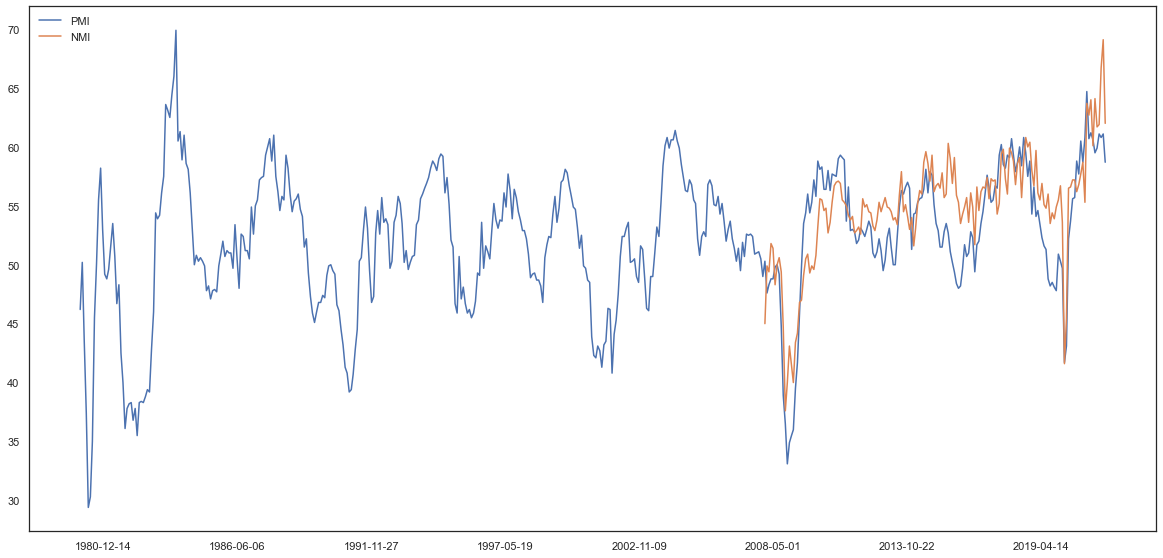

In [60]:
fig, ax = plt.subplots()
ax.plot(ism_pmi.index.values, ism_pmi['PMI'].values)
ax.plot(ism_nmi.index.values, ism_nmi['NMI'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
ax.legend(['PMI', 'NMI'])
plt.show()


Non-manufacturing index (NMI) is available only post 2008. <br /> It cannot cover a lot percentage of the target period, decided not to use it.

### Retail Sales
Retail sales is an important indicator of the current economic situation.
It is usually announced around the middle of each month (15th) for the previous month.

In [61]:
# Load Advance Real Retail and Food Services Sales
# Millions of 1982-84 CPI Adjusted Dollars, Seasonally Adjusted

filename = '../data/MarketData/Quandl/FRED_RRSFS.csv'

rrsfs = pd.read_csv(filename, names=['DATE', 'RRSFS'], header=0)
rrsfs = rrsfs.set_index(pd.to_datetime(rrsfs['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
rrsfs['diff_prev'] = rrsfs['RRSFS'].diff() / rrsfs['RRSFS'].shift(1) * 100
rrsfs['diff_year'] = rrsfs['RRSFS'].diff(periods=12) / rrsfs['RRSFS'].shift(12) * 100
rrsfs


RRSFS  diff_prev  diff_year
DATE                                      
1992-01-01  118651.0        NaN        NaN
1992-02-01  118480.0  -0.144120        NaN
1992-03-01  117700.0  -0.658339        NaN
1992-04-01  118156.0   0.387426        NaN
1992-05-01  118548.0   0.331765        NaN
...              ...        ...        ...
2021-08-01  227969.0   0.882398   9.967922
2021-09-01  228717.0   0.328115   8.338149
2021-10-01  230591.0   0.819353   9.413434
2021-11-01  229155.0  -0.622748  10.625941
2021-12-01  223716.0  -2.373503   9.172893

[360 rows x 3 columns]

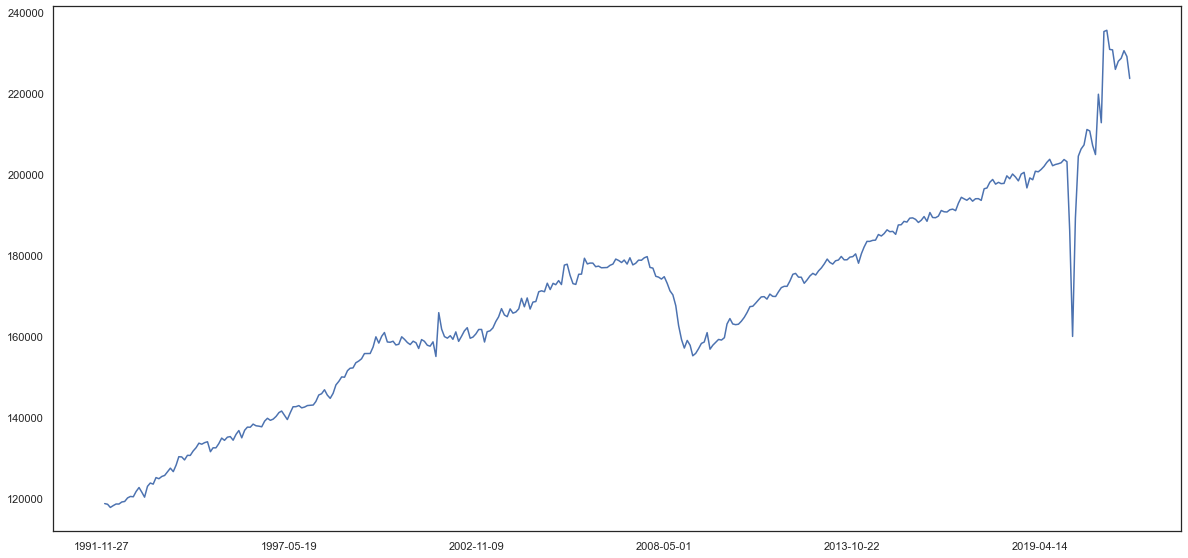

In [62]:
fig, ax = plt.subplots()
ax.plot(rrsfs.index.values, rrsfs['RRSFS'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### New Home Sales
New home sales is another important index to know the retail sales figure. <br />
It is usually announced around a week before the end of each month for the previous month.

In [63]:
filename = '../data/MarketData/Quandl/FRED_HSN1F.csv'

hsn1f = pd.read_csv(filename, names=['DATE', 'HSN1F'], header=0)
hsn1f = hsn1f.set_index(pd.to_datetime(hsn1f['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
hsn1f['diff_prev'] = hsn1f['HSN1F'].diff() / hsn1f['HSN1F'].shift(1) * 100
hsn1f['diff_year'] = hsn1f['HSN1F'].diff(periods=12) / hsn1f['HSN1F'].shift(12) * 100
hsn1f

HSN1F  diff_prev  diff_year
DATE                                   
1980-01-01  592.0        NaN        NaN
1980-02-01  541.0  -8.614865        NaN
1980-03-01  474.0 -12.384473        NaN
1980-04-01  370.0 -21.940928        NaN
1980-05-01  469.0  26.756757        NaN
...           ...        ...        ...
2021-07-01  704.0   3.074671 -27.572016
2021-08-01  668.0  -5.113636 -31.627431
2021-09-01  723.0   8.233533 -25.540680
2021-10-01  662.0  -8.437068 -31.682147
2021-11-01  744.0  12.386707 -13.988439

[503 rows x 3 columns]

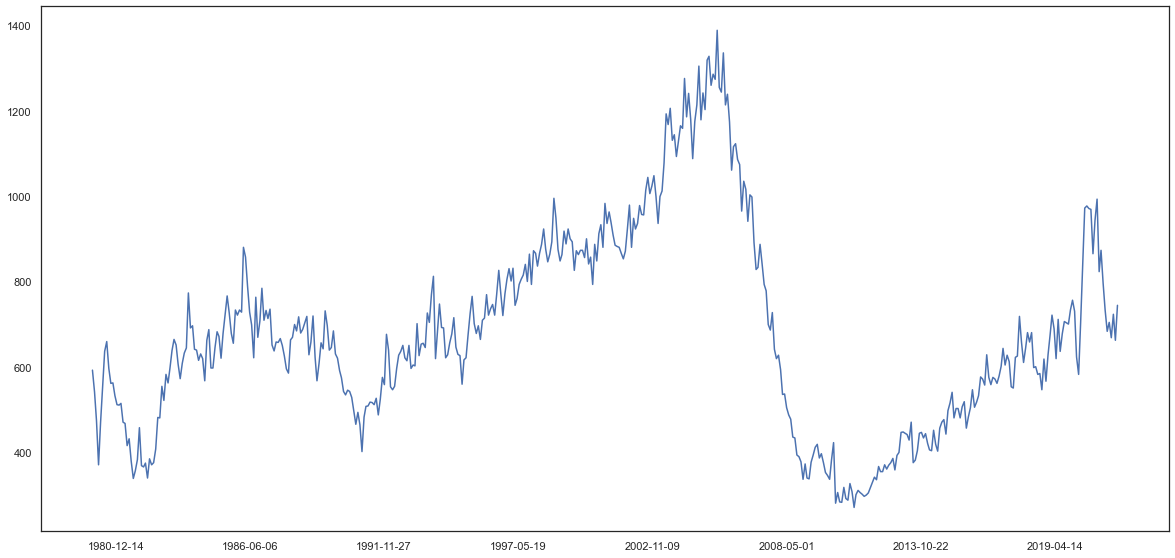

In [64]:
fig, ax = plt.subplots()
ax.plot(hsn1f.index.values, hsn1f['HSN1F'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Treasury Yield
#### Use Quandl

In [65]:
filename = '../data/MarketData/Quandl/USTREASURY_YIELD.csv'

treasury_q = pd.read_csv(filename, header=0)

treasury_q = treasury_q.set_index(pd.to_datetime(treasury_q['Date'], format="%Y-%m-%d")).drop(columns=['Date'])
treasury_q


1 MO  2 MO  3 MO  6 MO  1 YR  2 YR  3 YR  5 YR  7 YR  10 YR  \
Date                                                                      
1990-01-02   NaN   NaN  7.83  7.89  7.81  7.87  7.90  7.87  7.98   7.94   
1990-01-03   NaN   NaN  7.89  7.94  7.85  7.94  7.96  7.92  8.04   7.99   
1990-01-04   NaN   NaN  7.84  7.90  7.82  7.92  7.93  7.91  8.02   7.98   
1990-01-05   NaN   NaN  7.79  7.85  7.79  7.90  7.94  7.92  8.03   7.99   
1990-01-08   NaN   NaN  7.79  7.88  7.81  7.90  7.95  7.92  8.05   8.02   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...    ...   
2022-01-13  0.05  0.05  0.12  0.28  0.47  0.91  1.18  1.47  1.64   1.70   
2022-01-14  0.05  0.05  0.13  0.30  0.51  0.99  1.26  1.55  1.72   1.78   
2022-01-18  0.05  0.06  0.16  0.37  0.58  1.06  1.35  1.65  1.82   1.87   
2022-01-19  0.05  0.06  0.17  0.36  0.57  1.04  1.33  1.62  1.78   1.83   
2022-01-20  0.05  0.09  0.17  0.36  0.60  1.08  1.34  1.62  1.77   1.83   

            20 YR  30 YR  
Date                      
1990-01-02    NaN   8.00  
1990-01-03    NaN   8.04  
1990-01-04    NaN   8.04  
1990-01-05    NaN   8.06  
1990-01-08    NaN   8.09  
...           ...    ...  
2022-01-13   2.10   2.05  
2022-01-14   2.18   2.12  
2022-01-18   2.24   2.18  
2022-01-19   2.20   2.14  
2022-01-20   2.19   2.14  

[8021 rows x 12 columns]

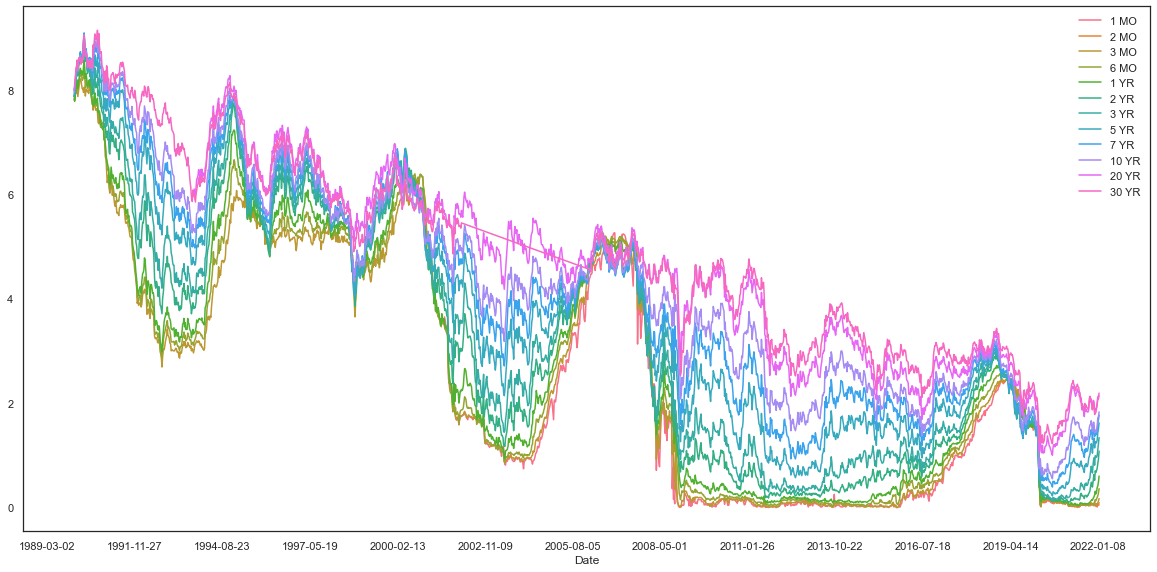

In [66]:
# Use every 5th row as it has too many data points
treasury_q_5 = treasury_q.iloc[::5, :]

fig, ax = plt.subplots()
ax = sns.lineplot(data = treasury_q_5, dashes=False)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.show()

# Process the data

## Add Rate and Decisions

In [67]:
# The target range was changed a couple of days after the announcement in the past,
#  while it is immediately put in effect on the day recently.
# Use the target rate three days after the meeting as target announced,
#  compare it with previous day's rate to check if rate has been changed.
#   -1: Rate lower
#    0: No change
#   +1: Rate hike

rate_list = []
decision_list = []
rate_diff_list = []

for i in tqdm(range(len(fomc_calendar))):
    not_found = True
    for j in range(len(fedrate_df)):
        if fomc_calendar.index[i] == fedrate_df.index[j]:
            not_found = False
            rate_list.append(float(fedrate_df['Rate'].iloc[j+3]))
            rate_diff_list.append(float(fedrate_df['Rate'].iloc[j+3]) - float(fedrate_df['Rate'].iloc[j-1]))
            if fedrate_df['Rate'].iloc[j-1] == fedrate_df['Rate'].iloc[j+3]:
                decision_list.append(0)
            elif fedrate_df['Rate'].iloc[j-1] < fedrate_df['Rate'].iloc[j+3]:
                decision_list.append(1)
            elif fedrate_df['Rate'].iloc[j-1] > fedrate_df['Rate'].iloc[j+3]:
                decision_list.append(-1)
            break
    if not_found:
        rate_list.append(np.nan)
        decision_list.append(np.nan)
        rate_diff_list.append(np.nan)

fomc_calendar.loc[:,'Rate'] = rate_list
fomc_calendar.loc[:,'RateDiff'] = rate_diff_list
fomc_calendar.loc[:,'RateDecision'] = decision_list
fomc_calendar['RateDecision'] = fomc_calendar['RateDecision'].astype('Int8')

fomc_calendar

  0%|          | 0/403 [00:00<?, ?it/s]

/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/var/folders/mb/399h735x1zs3yswdfj_tqm68jcd560/T/ipykernel_8728/2190436413.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fomc_calendar['RateDecision'] = fomc_calendar['RateDecision'].astype('Int8')


unscheduled  forecast  confcall  Rate  RateDiff  RateDecision
date                                                                     
1982-10-05        False     False     False   9.5      -0.5            -1
1982-11-16        False     False     False   9.0      -0.5            -1
1982-12-21        False     False     False   8.5       0.0             0
1983-01-14        False     False      True   8.5       0.0             0
1983-01-21        False     False      True   8.5       0.0             0
...                 ...       ...       ...   ...       ...           ...
2022-06-15        False      True     False   NaN       NaN          <NA>
2022-07-27        False     False     False   NaN       NaN          <NA>
2022-09-21        False      True     False   NaN       NaN          <NA>
2022-11-02        False     False     False   NaN       NaN          <NA>
2022-12-14        False      True     False   NaN       NaN          <NA>

[403 rows x 6 columns]

In [68]:
fomc_calendar.loc[fomc_calendar['Rate'].isnull()]

unscheduled  forecast  confcall  Rate  RateDiff  RateDecision
date                                                                     
2022-01-26        False     False     False   NaN       NaN          <NA>
2022-03-16        False      True     False   NaN       NaN          <NA>
2022-05-04        False     False     False   NaN       NaN          <NA>
2022-06-15        False      True     False   NaN       NaN          <NA>
2022-07-27        False     False     False   NaN       NaN          <NA>
2022-09-21        False      True     False   NaN       NaN          <NA>
2022-11-02        False     False     False   NaN       NaN          <NA>
2022-12-14        False      True     False   NaN       NaN          <NA>

In [69]:
# Remove the future date
fomc_calendar = fomc_calendar.loc[fomc_calendar.index < dt.datetime.now()]

# Confirm no null rate remains
fomc_calendar.loc[fomc_calendar['Rate'].isnull()]

unscheduled  forecast  confcall  Rate  RateDiff  RateDecision
date                                                                     
2022-01-26        False     False     False   NaN       NaN          <NA>

In [70]:
# # Calculate the next business day (not used for now)
# from pandas.tseries.holiday import USFederalHolidayCalendar
# cal = USFederalHolidayCalendar()
# holidays = cal.holidays(start='1982-01-01', end='2020-12-31').strftime('%Y-%m-%d')
# bdd = np.busdaycalendar(weekmask='1111100', holidays=holidays)

# np.busday_offset('2011-01-01', np.arange(366), roll='forward', busdaycal=bdd)
# np.busday_offset('1982-10-06', 0, roll='forward', busdaycal=bdd)

Though this is not perfect as Target Rate was sometimes changed between FOMC meetings, enough to analyze the impact of FOMC Meetings.

## Add Quantitative Easing as a Lower event
Between 2008 and 2016 saw zero interest rate. Main monetary measure shifted to quantity from rate. Thus, add "lower" events when those QE was announced.

In [71]:
# Add 2008-11-25 to fomc_calendar when QE was first announced but not in FOMC Calendar
# Mark RateDecision = -1 (lower) even when rate is not changed but additional quantitative measures were announced

# QE1 Announced
rec_20081125 = pd.Series([True, False, False, 'Ben Bernanke', 0, -1, -1], index=['unscheduled', 'forecast', 'confcall', 'ChairPerson', 'Rate', 'RateDiff', 'RateDecision'], name=dt.datetime.strptime('2008-11-25', '%Y-%m-%d'))

if fomc_calendar.loc[fomc_calendar.index == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    fomc_calendar = fomc_calendar.append(rec_20081125)

# Make the other timings of QE Expansion lowering events (consider the effect as -0.5%)
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2009,3,18), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE1 Expanded
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2010,11,3), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE2 Announced
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2011,9,21), ['RateDecision', 'RateDiff']] = (-1, -0.5) # Operation Twist Announced
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2012,6,20), ['RateDecision', 'RateDiff']] = (-1, -0.5) # Operation Twist Extended
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2012,9,13), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE3 Announced
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2012,12,12), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE3 Expanded

# It was announced QE ends - regard this as hike
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2013,6,19), ['RateDecision', 'RateDiff']] = (1, 1) # Tapering Announced
fomc_calendar.loc['2013-12-18', ['RateDecision', 'RateDiff']] = (1, 1) # Tapering Begins
fomc_calendar.loc['2014-10-29', ['RateDecision', 'RateDiff']] = (1, 0.5) # QE3 Terminated
fomc_calendar.loc['2017-06-14', ['RateDecision', 'RateDiff']] = (1, 0.5) # Signaled Balance Sheet Normalization
fomc_calendar.loc['2017-09-20', ['RateDecision', 'RateDiff']] = (1, 0.5) # Stated Balance Sheet Normalization Begins in Oct
fomc_calendar.sort_index(ascending=True, inplace=True)
fomc_calendar


unscheduled  forecast  confcall  Rate  RateDiff  RateDecision  \
date                                                                        
1982-10-05        False     False     False   9.5      -0.5            -1   
1982-11-16        False     False     False   9.0      -0.5            -1   
1982-12-21        False     False     False   8.5       0.0             0   
1983-01-14        False     False      True   8.5       0.0             0   
1983-01-21        False     False      True   8.5       0.0             0   
...                 ...       ...       ...   ...       ...           ...   
2021-07-28        False     False     False   0.0       0.0             0   
2021-09-22        False      True     False   0.0       0.0             0   
2021-11-03        False     False     False   0.0       0.0             0   
2021-12-15        False      True     False   0.0       0.0             0   
2022-01-26        False     False     False   NaN       NaN          <NA>   

           ChairPerson  
date                    
1982-10-05         NaN  
1982-11-16         NaN  
1982-12-21         NaN  
1983-01-14         NaN  
1983-01-21         NaN  
...                ...  
2021-07-28         NaN  
2021-09-22         NaN  
2021-11-03         NaN  
2021-12-15         NaN  
2022-01-26         NaN  

[397 rows x 7 columns]

In [82]:
fomc_calendar.dropna(axis = 0, subset = ['RateDecision'], inplace = True) # delete rows where Rate Decision is missing 

In [84]:
# Add binary column to see if rate is changed
fomc_calendar['RateChanged'] = fomc_calendar['RateDecision'].apply(lambda x: 0 if x == 0 else 1)


<AxesSubplot:xlabel='date', ylabel='RateDecision'>

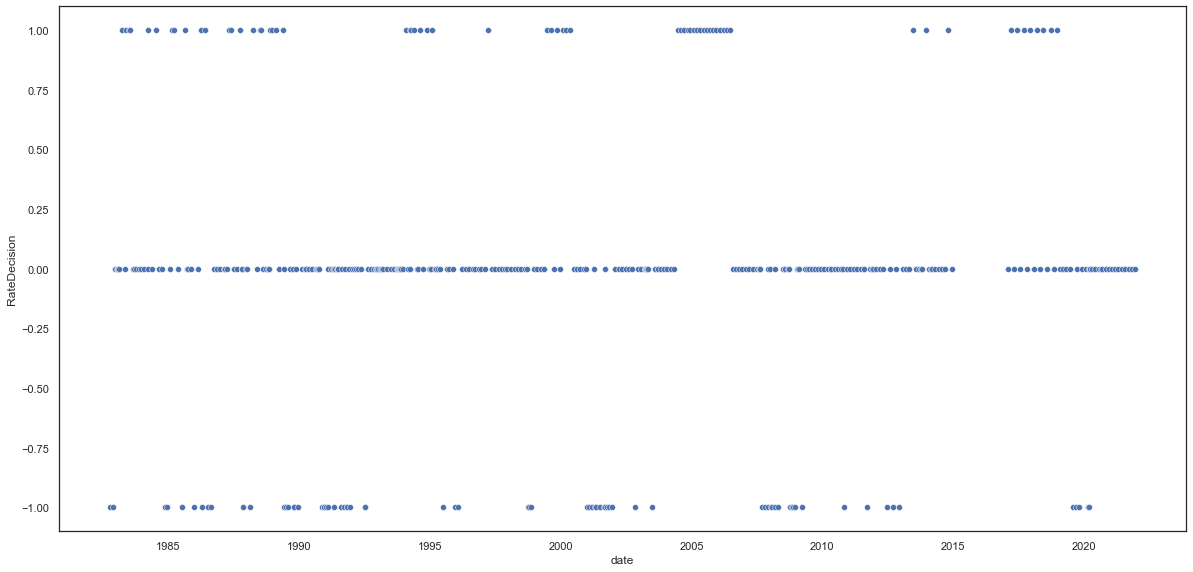

In [85]:
sns.scatterplot(x=fomc_calendar.index, y=fomc_calendar['RateDecision'].apply(lambda x: float(x)))

## Add major economic indices

In [87]:
def get_available_latest(train_df, index_df, value_col, diff_prev_col, diff_year_col, date_offset):
    '''
    Returns the latest available ecoonmic index for each row of train_df
    INPUTS:
        train_df: Index must be in datetime format
        idex_df: Index must be in datetime format
        value_col: The column name of the value in index_df
        diff_prev_col: The column name of the difference from previous period in index_df
        diff_year_col: The column name of the difference from the same priod in previous year in index_df
        date_offset: Use relativedelta for the offset when the index is published
    OUTPUTS:
        date_list: List of date matched with train_df.index
        value_list: List of values for the date_list
        diff_list: List of diff values for the date_list
    '''
    
    date_list, value_list, diff_prev_list, diff_year_list = [], [], [], []
    
    for i, row_data in tqdm(train_df.iterrows(), total=train_df.shape[0]):
        #print(row_data.name)
        not_available = True
        for j, row_index in index_df.sort_index(ascending=False).iterrows():
            if row_data.name > row_index.name + date_offset:
                #print("   matched: ", row_index.name)
                date_list.append(row_index.name)
                value_list.append(row_index[value_col])
                diff_prev_list.append(row_index[diff_prev_col])
                diff_year_list.append(row_index[diff_year_col])
                not_available = False
                break
        if not_available:
            date_list.append(None)
            value_list.append(None)
            diff_prev_list.append(None)
            diff_year_list.append(None)
    if train_df.shape[0] != len(date_list):
        print("train_df has {} rows but returned {} rows from index_df!".format(train_df.shape[0], len(date_list)))
    
    return date_list, value_list, diff_prev_list, diff_year_list

In [88]:
def add_market_data(calendar_df, window=1):
    '''
    Search the latest available market data using get_available_latest and retun a new dataframe with the market data.
    Moving average is applied to market data for the give window size.
    '''
    # First copy the caleander dataframe and drop Rate is NaN because this is the answer
    df = calendar_df.copy(deep=True)
    df.dropna(subset=['Rate'], inplace=True)
    
    # GDP is announced quarterly, the end of following month (preliminary)
    print("Processing GDP...")
    df['GDP_date'], df['GDP_value'], df['GDP_diff_prev'], df['GDP_diff_year'] \
    = get_available_latest(df, gdpc1.rolling(window).mean(), 'GDPC1', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))

    print("Processing Potential GDP...")
    df['GDPPOT_date'], df['GDPPOT_value'], df['GDPPOT_diff_prev'], df['GDPPOT_diff_year'] \
    = get_available_latest(df, gdppot.rolling(window).mean(), 'GDPPOT', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))

    # PCE is announced monthly, at the end of following month
    print("Processing PCE...")
    df['PCE_date'], df['PCE_value'], df['PCE_diff_prev'], df['PCE_diff_year'] \
    = get_available_latest(df, pcepilfe.rolling(window).mean(), 'PCEPILFE', 'diff_prev', 'diff_year', relativedelta(months=+2, days=-1))

    # CPI is announced monthly, around 10th of the following month
    print("Processing CPI...")
    df['CPI_date'], df['CPI_value'], df['CPI_diff_prev'], df['CPI_diff_year'] \
    = get_available_latest(df, cpiaucsl.rolling(window).mean(), 'CPIAUCSL', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+9))

    # Employment statistics is announced monthly, around 3rd of the following month
    print("Processing Unemployemnt...")
    df['Unemp_date'], df['Unemp_value'], df['Unemp_diff_prev'], df['Unemp_diff_year'] \
    = get_available_latest(df, unrate.rolling(window).mean(), 'UNRATE', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # Employment statistics is announced monthly, around 3rd of the following month
    print("Processing Employment...")
    df['Employ_date'], df['Employ_value'], df['Employ_diff_prev'], df['Employ_diff_year'] \
    = get_available_latest(df, payems.rolling(window).mean(), 'PAYEMS', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # ISM PMI is areannounced monthly, around 1st of the following month
    print("Processing ISM PMI...")
    df['PMI_date'], df['PMI_value'], df['PMI_diff_prev'], df['PMI_diff_year'] \
    = get_available_latest(df, ism_pmi.rolling(window).mean(), 'PMI', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # ISM NMI is areannounced monthly, around 1st of the following month
    print("Processing ISM NMI...")
    df['NMI_date'], df['NMI_value'], df['NMI_diff_prev'], df['NMI_diff_year'] \
    = get_available_latest(df, ism_nmi.rolling(window).mean(), 'NMI', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # Retail Sales is announced monthly, around 15th of the following month
    print("Processing Retail Sales...")
    df['Rsales_date'], df['Rsales_value'], df['Rsales_diff_prev'], df['Rsales_diff_year'] \
    = get_available_latest(df, rrsfs.rolling(window).mean(), 'RRSFS', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # New Home Sales is announced monthly, around a week before the end of the following month
    print("Processing New Home Sales...")
    df['Hsales_date'], df['Hsales_value'], df['Hsales_diff_prev'], df['Hsales_diff_year'] \
    = get_available_latest(df, hsn1f.rolling(window).mean(), 'HSN1F', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))
    
    return df

In [89]:
nontext_data = add_market_data(fomc_calendar)

Processing GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Potential GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing PCE...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing CPI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Unemployemnt...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Employment...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM PMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM NMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Retail Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing New Home Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

In [90]:
nontext_ma2 = add_market_data(fomc_calendar, 2)
nontext_ma3 = add_market_data(fomc_calendar, 3)
nontext_ma6 = add_market_data(fomc_calendar, 6)
nontext_ma12 = add_market_data(fomc_calendar, 12)

Processing GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Potential GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing PCE...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing CPI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Unemployemnt...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Employment...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM PMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM NMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Retail Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing New Home Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Potential GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing PCE...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing CPI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Unemployemnt...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Employment...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM PMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM NMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Retail Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing New Home Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Potential GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing PCE...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing CPI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Unemployemnt...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Employment...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM PMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM NMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Retail Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing New Home Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Potential GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing PCE...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing CPI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Unemployemnt...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Employment...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM PMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM NMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Retail Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing New Home Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

## Add Taylor Rule
After EDA in Notebook No.4, it was found the individual economic index data has little to do with the rate decision. As FED has released how policymakers use these data here, try to calculate them and use instead of raw data. <BR />
https://www.federalreserve.gov/monetarypolicy/policy-rules-and-how-policymakers-use-them.htm

In [91]:
# Create taylor dataframe
taylor = fedrate_df.copy(deep=True)

# Obtain available index used to calculate Taylor rule each day
_, taylor['Y'],_,_ = get_available_latest(taylor, gdpc1, 'GDPC1', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))
_, taylor['Yp'],_,_ = get_available_latest(taylor, gdppot, 'GDPPOT', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))
taylor['Y-Yp'] = (np.log(taylor['Y']*10**9) - np.log(taylor['Yp']*10**9)) * 100

_, _,_, taylor['Pi'] = get_available_latest(taylor, pcepilfe, 'PCEPILFE', 'diff_prev', 'diff_year', relativedelta(months=+2, days=-1))
taylor['Pi*'] = 2
taylor['Pi-Pi*'] = taylor['Pi'] - taylor['Pi*']

taylor['r'] = 2


  0%|          | 0/14360 [00:00<?, ?it/s]

  0%|          | 0/14360 [00:00<?, ?it/s]

  0%|          | 0/14360 [00:00<?, ?it/s]

In [92]:
# Calculate Taylor Rule
taylor['Taylor'] = taylor['r'] + taylor['Pi'] + 0.5 * taylor['Pi-Pi*'] + 0.5 * taylor['Y-Yp']

# Calculate Balanced-approach Rule
taylor['Balanced'] = (taylor['r'] + taylor['Pi'] + 0.5 * taylor['Pi-Pi*'] + taylor['Y-Yp']).map(lambda x: 0 if x < 0 else x)

# Calculate Inertia Rule
taylor['Inertia'] = 0.85 * taylor['Rate'] - 0.15 * taylor['Balanced']

# Drop unnecessary columns
taylor = taylor.drop(columns = ['Y', 'Yp', 'Y-Yp', 'Pi', 'Pi*', 'Pi-Pi*', 'r', 'diff'])

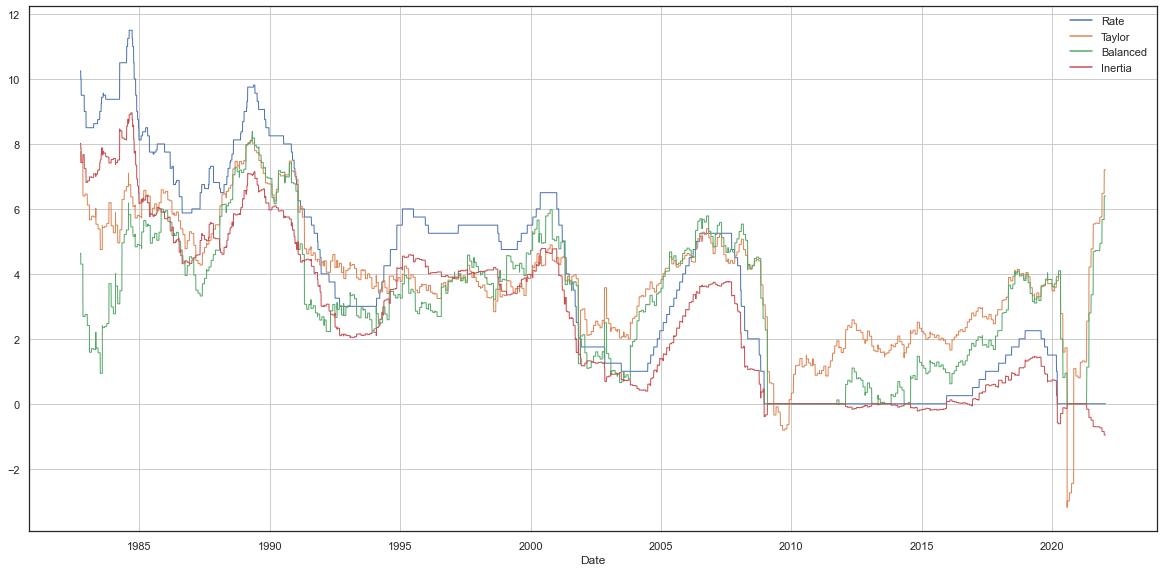

In [93]:
# Plot
# Use every 5th row as it has too many data points
# taylor_5 = taylor.iloc[::5, :]

fig, ax = plt.subplots()
ax = sns.lineplot(data=taylor, dashes=False, lw=1)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.grid(True)
plt.show()

In [94]:
# Deviation from Rate, which may trigger the rate change
taylor['Taylor-Rate'] = taylor['Taylor'] - taylor['Rate']
taylor['Balanced-Rate'] = taylor['Balanced'] - taylor['Rate']
taylor['Inertia-Rate'] = taylor['Inertia'] - taylor['Rate']

taylor['Taylor_diff'] = taylor['Taylor'].diff(1)
taylor['Balanced_diff'] = taylor['Balanced'].diff(1)
taylor['Inertia_diff'] = taylor['Inertia'].diff(1)

taylor

Rate    Taylor  Balanced   Inertia  Taylor-Rate  Balanced-Rate  \
Date                                                                          
1982-09-27  10.25  7.761471  4.633424  8.017486    -2.488529      -5.616576   
1982-09-28  10.25  7.761471  4.633424  8.017486    -2.488529      -5.616576   
1982-09-29  10.25  7.761471  4.633424  8.017486    -2.488529      -5.616576   
1982-09-30  10.25  7.761471  4.633424  8.017486    -2.488529      -5.616576   
1982-10-01  10.00  7.428054  4.300007  7.854999    -2.571946      -5.699993   
...           ...       ...       ...       ...          ...            ...   
2022-01-15   0.00  7.205843  6.398876 -0.959831     7.205843       6.398876   
2022-01-16   0.00  7.205843  6.398876 -0.959831     7.205843       6.398876   
2022-01-17   0.00  7.205843  6.398876 -0.959831     7.205843       6.398876   
2022-01-18   0.00  7.205843  6.398876 -0.959831     7.205843       6.398876   
2022-01-19   0.00  7.205843  6.398876 -0.959831     7.205843       6.398876   

            Inertia-Rate  Taylor_diff  Balanced_diff  Inertia_diff  
Date                                                                
1982-09-27     -2.232514          NaN            NaN           NaN  
1982-09-28     -2.232514     0.000000       0.000000      0.000000  
1982-09-29     -2.232514     0.000000       0.000000      0.000000  
1982-09-30     -2.232514     0.000000       0.000000      0.000000  
1982-10-01     -2.145001    -0.333417      -0.333417     -0.162487  
...                  ...          ...            ...           ...  
2022-01-15     -0.959831     0.000000       0.000000      0.000000  
2022-01-16     -0.959831     0.000000       0.000000      0.000000  
2022-01-17     -0.959831     0.000000       0.000000      0.000000  
2022-01-18     -0.959831     0.000000       0.000000      0.000000  
2022-01-19     -0.959831     0.000000       0.000000      0.000000  

[14360 rows x 10 columns]

In [95]:
# Add the calculated values to the dataframe
def add_taylor(df, window=1):
    taylor_ma = taylor.rolling(window).mean()
    df['Taylor'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Taylor'].values[0])
    df['Balanced'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Balanced'].values[0])
    df['Inertia'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Inertia'].values[0])
    df['Taylor-Rate'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Taylor-Rate'].values[0])
    df['Balanced-Rate'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Balanced-Rate'].values[0])
    df['Inertia-Rate'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Inertia-Rate'].values[0])
    df['Taylor_diff'] = df['Taylor'].diff(1)
    df['Balanced_diff'] = df['Balanced'].diff(1)
    df['Inertia_diff'] = df['Inertia'].diff(1)
    
    

In [96]:
add_taylor(nontext_data)
add_taylor(nontext_ma2, 60)
add_taylor(nontext_ma3, 90)
add_taylor(nontext_ma6, 180)
add_taylor(nontext_ma12, 360)

In [97]:
fomc_calendar.index.get_level_values(0).values

array(['1982-10-05T00:00:00.000000000', '1982-11-16T00:00:00.000000000',
       '1982-12-21T00:00:00.000000000', '1983-01-14T00:00:00.000000000',
       '1983-01-21T00:00:00.000000000', '1983-01-28T00:00:00.000000000',
       '1983-02-09T00:00:00.000000000', '1983-03-29T00:00:00.000000000',
       '1983-04-29T00:00:00.000000000', '1983-05-24T00:00:00.000000000',
       '1983-06-23T00:00:00.000000000', '1983-07-13T00:00:00.000000000',
       '1983-08-23T00:00:00.000000000', '1983-09-08T00:00:00.000000000',
       '1983-10-04T00:00:00.000000000', '1983-11-15T00:00:00.000000000',
       '1983-12-20T00:00:00.000000000', '1984-01-31T00:00:00.000000000',
       '1984-03-20T00:00:00.000000000', '1984-03-27T00:00:00.000000000',
       '1984-05-22T00:00:00.000000000', '1984-07-17T00:00:00.000000000',
       '1984-08-21T00:00:00.000000000', '1984-10-02T00:00:00.000000000',
       '1984-11-07T00:00:00.000000000', '1984-12-18T00:00:00.000000000',
       '1985-01-18T00:00:00.000000000', '1985-02-13

In [98]:
fomc_calendar.loc['2020-06-10', 'Rate'] = 0
fomc_calendar.loc['2020-07-29', 'Rate'] = 0
fomc_calendar.loc['2020-06-10', 'RateDiff'] = 0
fomc_calendar.loc['2020-07-29', 'RateDiff'] = 0


## Save the train data

In [99]:
def save_data(df, file_name, dir_name='../data/preprocessed/'):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [100]:
# Save data
save_data(nontext_data, 'nontext_data')
save_data(nontext_ma2, 'nontext_ma2')
save_data(nontext_ma3, 'nontext_ma3')
save_data(nontext_ma6, 'nontext_ma6')
save_data(nontext_ma12, 'nontext_ma12')
save_data(treasury_q, 'treasury')
save_data(fomc_calendar, 'fomc_calendar')

# Clean Text Data

In [ ]:
# # Check module locations if required
# import sys
# import pprint
# pprint.pprint(sys.path)

In [101]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
import pickle
from tqdm.notebook import tqdm

import nltk

In [102]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

## Define Utility Functions

In [103]:
# Functions for map() or apply()

def get_word_count(x):
    '''
    Retun the number of words for the given text x.
    '''
    x = x.replace("[SECTION]", "")
    return len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', x))
        
def get_rate_change(x):
    '''
    Returns rate change decision of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
    
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['RateDecision']
    else:        
        return None

def get_rate(x):
    '''
    Returns rate of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
        
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['Rate']
    else:        
        return None

def get_next_meeting_date(x):
    '''
    Returns the next fomc meeting date for the given date x, referring to fomc_calendar DataFrame.
    Usually FOMC Meetings takes two days, so it starts searching from x+2.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None

    # Add two days to get the day after next
    x = x + dt.timedelta(days=2)
    
    # Just in case, sort fomc_calendar from older to newer
    fomc_calendar.sort_index(ascending=True, inplace=True)
    
    if fomc_calendar.index[0] > x:
        # If the date is older than the first FOMC Meeting, do not return any date.
        return None
    else:
        for i in range(len(fomc_calendar)):
            if x < fomc_calendar.index[i]:
                return fomc_calendar.index[i]
        # If x is greater than the newest FOMC meeting date, do not return any date.
        return None
    
def get_chairperson(x):
    '''
    Return a tuple of chairperson's Fullname for the given date x.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
        except:
            return None
    
    chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

In [104]:
def reorganize_df(df, doc_type):
    '''
    Reorganize the loaded dataframe, which has been obrained by FomcGetData for further processing
        - Add type
        - Add word count
        - Add rate, decision (for meeting documents, None for the others)
        - Add next meeting date, rate and decision
        - Copy contents to org_text
        - Remove line breaks from contents in text
        - Split contents by "[SECTION]" to list in text_sections
    '''
    
    if doc_type in ('statement', 'minutes', 'presconf_script', 'meeting_script'):
        is_meeting_doc = True
    elif doc_type in ('speech', 'testimony'):
        is_meeting_doc = False
    else:
        print("Invalid doc_type [{}] is given!".format(doc_type))
        return None
    
    dict = {
        'type': doc_type,
        'date': df['date'],
        'title': df['title'],
        'speaker': df['speaker'],
        'word_count': df['contents'].map(get_word_count),
        'decision': df['date'].map(lambda x: get_rate_change(x) if is_meeting_doc else None),
        'rate': df['date'].map(lambda x: get_rate(x) if is_meeting_doc else None),
        'next_meeting': df['date'].map(get_next_meeting_date),
        'next_decision': df['date'].map(get_next_meeting_date).map(get_rate_change),
        'next_rate': df['date'].map(get_next_meeting_date).map(get_rate),        
        'text': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip()),
        'text_sections': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
        'org_text': df['contents']
    }

    new_df = pd.DataFrame(dict)
    new_df['decision'] = new_df['decision'].astype('Int8')
    new_df['next_decision'] = new_df['next_decision'].astype('Int8')
    print("No rate decision found: ", new_df['decision'].isnull().sum())
    print("Shape of the dataframe: ", new_df.shape)
    #new_df.dropna(subset=['decision'], axis=0, inplace=True)
    return new_df

In [105]:
# Split functions to process long text in machine learning based NLP

def get_split(text, split_len=200, overlap=50):
    '''
    Returns a list of split text of $split_len with overlapping of $overlap.
    Each item of the list will have around split_len length of text.
    '''
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
        
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=200, overlap=50):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            #print(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)))
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    split_df['decision'] = split_df['decision'].astype('Int8')
    split_df['next_decision'] = split_df['next_decision'].astype('Int8')

    return split_df

In [106]:
def remove_short_section(df, min_words=50):
    '''
    Using 'text_sections' of the given dataframe, remove sections having less than min_words.
    It concatinate sections with a space, which exceeds min_words and update 'text'.
    As a fallback, keep a text which concatinates sections having more than 20 words and use it
     if there is no section having more than min_words.
    If there is no sections having more than 20 words, remove the row.
    '''
    new_df = df.copy()
    new_text_list = []
    new_text_section_list = []
    new_wc_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_text = ""
        bk_text = ""
        new_text_section = []
        bk_text_section = []
                
        for section in row['text_sections']:
            num_words = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section))
            if num_words > min_words:
                new_text += " " + section
                new_text_section.append(section)
            elif num_words > 20:
                bk_text += " " + section
                bk_text_section.append(section)
                
        
        new_text = new_text.strip()
        bk_text = bk_text.strip()
        
        if len(new_text) > 0:
            new_text_list.append(new_text)
            new_text_section_list.append(new_text_section)
        elif len(bk_text) > 0:
            new_text_list.append(bk_text)
            new_text_section_list.append(bk_text_section)
        else:
            new_text_list.append("")
            new_text_section_list.append("")
        
        # Update the word count
        new_wc_list.append(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', new_text_list[-1])))
        
    new_df['text'] = new_text_list
    new_df['word_count'] = new_wc_list
    
    return new_df.loc[new_df['word_count'] > 0]

def remove_short_nokeyword(df, keywords = ['rate', 'rates', 'federal fund', 'outlook', 'forecast', 'employ', 'economy'], min_times=2, min_words=50):
    '''
    Drop sections which do not have any one of keywords for min_times times
     before applying remove_short_section()
    '''
    
    new_df = df.copy()
    new_section_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_section = []
                
        for section in row['text_sections']:
            if len(set(section.split()).intersection(keywords)) >= min_times:
                new_section.append(section)
        
        new_section_list.append(new_section)
    
    new_df['text_sections'] = new_section_list
    
    return remove_short_section(new_df, min_words=min_words)

## Load Data

### Chairpersons

In [107]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2022,2,5)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

Surname FirstName   FromDate     ToDate
0    Volcker      Paul 1979-08-06 1987-08-10
1  Greenspan      Alan 1987-08-11 2006-01-31
2   Bernanke       Ben 2006-02-01 2014-01-31
3     Yellen     Janet 2014-02-03 2018-02-03
4     Powell    Jerome 2018-02-05 2022-02-05

### Load Calendar

In [108]:
file = open('../data/preprocessed/fomc_calendar.pickle', 'rb')

fomc_calendar = pd.read_pickle(file)
file.close()

print(fomc_calendar.shape)
fomc_calendar

(396, 8)


unscheduled  forecast  confcall  Rate  RateDiff  RateDecision  \
date                                                                        
1982-10-05        False     False     False   9.5      -0.5            -1   
1982-11-16        False     False     False   9.0      -0.5            -1   
1982-12-21        False     False     False   8.5       0.0             0   
1983-01-14        False     False      True   8.5       0.0             0   
1983-01-21        False     False      True   8.5       0.0             0   
...                 ...       ...       ...   ...       ...           ...   
2021-06-16        False      True     False   0.0       0.0             0   
2021-07-28        False     False     False   0.0       0.0             0   
2021-09-22        False      True     False   0.0       0.0             0   
2021-11-03        False     False     False   0.0       0.0             0   
2021-12-15        False      True     False   0.0       0.0             0   

           ChairPerson  RateChanged  
date                                 
1982-10-05         NaN            1  
1982-11-16         NaN            1  
1982-12-21         NaN            0  
1983-01-14         NaN            0  
1983-01-21         NaN            0  
...                ...          ...  
2021-06-16         NaN            0  
2021-07-28         NaN            0  
2021-09-22         NaN            0  
2021-11-03         NaN            0  
2021-12-15         NaN            0  

[396 rows x 8 columns]

### Statement

In [109]:
file = open('../data/FOMC/statement.pickle', 'rb')

statement_df = pd.read_pickle(file)
file.close()

print(statement_df.shape)
statement_df

(194, 4)


date  \
0   1994-02-04   
1   1994-03-22   
2   1994-04-18   
3   1994-05-17   
4   1994-08-16   
..         ...   
189 2021-06-16   
190 2021-07-28   
191 2021-09-22   
192 2021-11-03   
193 2021-12-15   

                                                                                                                                                                                                    contents  \
0    \n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...   
1    \n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...   
2    \n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...   
3    \n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...   
4    \n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...   
..                                                                                                                                                                                                       ...   
189  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
190  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
191  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
192  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
193  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   

            speaker           title  
0    Alan Greenspan  FOMC Statement  
1    Alan Greenspan  FOMC Statement  
2    Alan Greenspan  FOMC Statement  
3    Alan Greenspan  FOMC Statement  
4    Alan Greenspan  FOMC Statement  
..              ...             ...  
189   Jerome Powell  FOMC Statement  
190   Jerome Powell  FOMC Statement  
191   Jerome Powell  FOMC Statement  
192   Jerome Powell  FOMC Statement  
193   Jerome Powell  FOMC Statement  

[194 rows x 4 columns]

In [110]:
# Sample Contents - the 2nd last
print(statement_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Meeting Minutes

In [111]:
file = open('../data/FOMC/minutes.pickle', 'rb')

minutes_df = pd.read_pickle(file)
file.close()

print(minutes_df.shape)
minutes_df

(223, 4)


date  \
0   1993-02-03   
1   1993-03-23   
2   1993-05-18   
3   1993-07-07   
4   1993-08-17   
..         ...   
218 2021-06-16   
219 2021-07-28   
220 2021-09-22   
221 2021-11-03   
222 2021-12-15   

                                                                                                                                                                                                    contents  \
0    A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System in \r\n    Washington, D.C., on Tuesday, February 2, 1993, at...   
1    A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System in \r\n    Washington, D.C.,  on Tuesday, March 23,  1993,  a...   
2    A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System \r\n    in Washington, D.C.,  on Tuesday, May 18,  1993,  at ...   
3    A meeting of the Federal Open Market Committee was held in the \r\n    offices of the Board of Governors of the Federal Reserve System in \r\n    Washington, D.C., on Tuesday, July 6, 1993, at 2:3...   
4    A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System \r\n    in Washington, D.C., on Tuesday, August 17, 1993, at ...   
..                                                                                                                                                                                                       ...   
218  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
219  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
220  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
221  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
222  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   

            speaker                 title  
0    Alan Greenspan  FOMC Meeting Minutes  
1    Alan Greenspan  FOMC Meeting Minutes  
2    Alan Greenspan  FOMC Meeting Minutes  
3    Alan Greenspan  FOMC Meeting Minutes  
4    Alan Greenspan  FOMC Meeting Minutes  
..              ...                   ...  
218   Jerome Powell  FOMC Meeting Minutes  
219   Jerome Powell  FOMC Meeting Minutes  
220   Jerome Powell  FOMC Meeting Minutes  
221   Jerome Powell  FOMC Meeting Minutes  
222   Jerome Powell  FOMC Meeting Minutes  

[223 rows x 4 columns]

In [112]:
# Sample Contents - the 2nd last
print(minutes_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Meeting Transcripts

In [113]:
file = open('../data/FOMC/meeting_script.pickle', 'rb')

meeting_script_df = pd.read_pickle(file)
file.close()

print(meeting_script_df.shape)
meeting_script_df

(282, 4)


date  \
0   1980-01-09   
1   1980-02-05   
2   1980-03-18   
3   1980-04-22   
4   1980-05-20   
..         ...   
277 2014-06-18   
278 2014-07-30   
279 2014-09-17   
280 2014-10-29   
281 2014-12-17   

                                                                                                                                                                                                    contents  \
0    MR. STERNLIGHT.  [Statement--see  Appendix.]\n\n[SECTION]\n\nCHAIRMAN VOLCKER.  [That  was  the change  in  System holdings ofsecurities]  since when?\n\n[SECTION]\n\nMR. STERNLIGHT.  That  was  f...   
1    CHAIRMAN VOLCKER.  I will  call  the non-meeting  to  order.  Weare not  in  a meeting at  this point  anyway;  we may be  in  a meetinglater.  I would just  remind all of  you that  I sent  out  ...   
2    CHAIRMAN VOLCKER.  The  meeting can  come  to  order,  gentlemenand  lady.  We  have  a  lot  of  business  to  dispose  of  at  the  start  and Iwill  try  to  find my agenda,  if  you will  excu...   
3    CHAIRMAN VOLCKER. Can we  come  to  order,  ladies andgentlemen?  I am  delighted  to  say that  our  Vice  Chairman, Mr.  Solomon,who was  duly elected  in  absentia  last  time,  is  with us  to...   
4    CHAIRMAN VOLCKER.  Let  us proceed, ladies  and  gentlemen.  Weneed to  approve  the  minutes.\n\n[SECTION]\n\nMR.  SCHULTZ.  So  moved.\n\n[SECTION]\n\nCHAIRMAN VOLCKER.  Do  we have  a  second?\...   
..                                                                                                                                                                                                       ...   
277  CHAIR YELLEN.  I’d like to begin by welcoming three people to the table today:  Stan   Fischer, Lael Brainard, and Loretta Mester.  This is the first FOMC meeting for both Stan and     Lael, but b...   
278  CHAIR YELLEN.  Good morning, everybody.  I would like to begin today’s meeting by  giving the floor to President Fisher, who asked if he could take a minute to address the group. \n\n[SECTION]\n\n...   
279  CHAIR YELLEN.  Good morning, everybody. Our first two items this morning will be conducted in a joint meeting between the FOMC and the Board.  I need a motion to close the Board meeting. \n\n[SECT...   
280  CHAIR YELLEN.  I’d like to call this meeting to order.  Before turning to our agenda, I’d like to say a few words about our communications with the public.  Many of you will recall that in June 20...   
281  CHAIR YELLEN.  Good afternoon, everyone.  I think we are ready to begin.  The first item we are going to consider is in a joint Board and FOMC meeting, so I need a motion to close the Board meetin...   

          speaker                    title  
0           other  FOMC Meeting Transcript  
1           other  FOMC Meeting Transcript  
2           other  FOMC Meeting Transcript  
3           other  FOMC Meeting Transcript  
4           other  FOMC Meeting Transcript  
..            ...                      ...  
277  Janet Yellen  FOMC Meeting Transcript  
278  Janet Yellen  FOMC Meeting Transcript  
279  Janet Yellen  FOMC Meeting Transcript  
280  Janet Yellen  FOMC Meeting Transcript  
281  Janet Yellen  FOMC Meeting Transcript  

[282 rows x 4 columns]

In [114]:
# Sample Contents - the 2nd last
print(meeting_script_df['contents'].iloc[-1])

CHAIR YELLEN.  Good afternoon, everyone.  I think we are ready to begin.  The first item we are going to consider is in a joint Board and FOMC meeting, so I need a motion to close the Board meeting. 

[SECTION]

MR. FISCHER.  So moved. 

[SECTION]

CHAIR YELLEN.  Without objection, thank you.  I’m going to start off by calling on Simon to give us his report on market developments. 

[SECTION]

MR. POTTER.1  Thank you, Madam Chair.  Lorie and I will be splitting the Desk briefing into two parts.  I will discuss financial market developments and some issues related to open market operations.  After questions and answers on this section, Lorie will discuss testing and some related issues with supplementary normalization tools. Over the intermeeting period, U.S. economic data were generally viewed as positive and changes in financial conditions were mixed.  International developments were in focus with more-accommodative policy adopted or communicated by major central banks, driven by conc

### Press Conference Transcripts

In [115]:
file = open('../data/FOMC/presconf_script.pickle', 'rb')

presconf_script_df = pd.read_pickle(file)
file.close()

print(presconf_script_df.shape)
presconf_script_df

(49, 4)


date  \
0  2011-04-27   
1  2011-06-22   
2  2011-11-02   
3  2012-01-25   
4  2012-04-25   
..        ...   
44 2021-06-16   
45 2021-07-28   
46 2021-09-22   
47 2021-11-03   
48 2021-12-15   

                                                                                                                                                                                                   contents  \
0   CHAIRMAN BERNANKE.  Good afternoon.  Welcome.  In my opening remarks, I’d like to briefly first review today’s policy decision.  I’ll then turn next to the Federal Open Market Committee’s quarterl...   
1   CHAIRMAN BERNANKE.  Good afternoon and welcome.   In my opening remarks today, I’ll briefly review today’s policy decision.  And I’ll place the decision in the context of our economic projections ...   
2   CHAIRMAN BERNANKE.  Good afternoon, everybody.  Welcome.  In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy.  I will then be glad to take...   
3   CHAIRMAN BERNANKE.  Good afternoon and welcome.   In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...   
4   CHAIRMAN BERNANKE.  Good afternoon.  Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th...   
..                                                                                                                                                                                                      ...   
44  CHAIR POWELL.  Good afternoon.  At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us:  maximum employment and price stability. Today ...   
45  CHAIR POWELL.  Good afternoon.  At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us:  maximum employment and price stability. Today ...   
46  CHAIR POWELL. Good afternoon.  At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us:  maximum employment and price stability. Today, ...   
47  CHAIR POWELL.  Good afternoon.  At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us:  maximum employment and price stability. Today,...   
48  CHAIR POWELL.  Good afternoon.  At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us:  maximum employment and price stability. Today,...   

          speaker                             title  
0    Ben Bernanke  FOMC Press Conference Transcript  
1    Ben Bernanke  FOMC Press Conference Transcript  
2    Ben Bernanke  FOMC Press Conference Transcript  
3    Ben Bernanke  FOMC Press Conference Transcript  
4    Ben Bernanke  FOMC Press Conference Transcript  
..            ...                               ...  
44  Jerome Powell  FOMC Press Conference Transcript  
45  Jerome Powell  FOMC Press Conference Transcript  
46  Jerome Powell  FOMC Press Conference Transcript  
47  Jerome Powell  FOMC Press Conference Transcript  
48  Jerome Powell  FOMC Press Conference Transcript  

[49 rows x 4 columns]

In [116]:
# Sample Contents - the 2nd last
print(presconf_script_df['contents'].iloc[-1])

CHAIR POWELL.  Good afternoon.  At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us:  maximum employment and price stability. Today, in support of these goals, the Federal Open Market Committee kept interest rates near zero and updated its assessment of the progress that the economy has made toward the criteria specified in the Committee’s forward guidance for interest rates.  In addition, in light of the strengthening labor market and elevated inflation pressures, we decided to speed up the reductions in our asset purchases.  As I will explain, economic developments and changes in the outlook warrant this evolution of monetary policy, which will continue to provide appropriate support for the economy.   Economic activity is on track to expand at a robust pace this year, reflecting progress on vaccinations and the reopening of the economy.  Aggregate demand remains very strong, buoyed by fiscal and monetary policy support 

### Speech

In [117]:
file = open('../data/FOMC/speech.pickle', 'rb')

speech_df = pd.read_pickle(file)
file.close()

print(speech_df.shape)
speech_df

(1565, 4)


date  \
0    1996-06-13   
1    1996-06-18   
2    1996-09-08   
3    1996-09-19   
4    1996-10-02   
...         ...   
1560 2021-11-29   
1561 2021-11-29   
1562 2021-11-30   
1563 2021-12-02   
1564 2021-12-17   

                                                                                                                                                                                                     contents  \
0     Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...   
1     Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...   
2     Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment.  But I al...   
3     Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...   
4     Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...   
...                                                                                                                                                                                                       ...   
1560  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
1561  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
1562  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
1563  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
1564  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   

                             speaker  \
0            Chairman Alan Greenspan   
1     Governor Edward W. Kelley, Jr.   
2         Governor Laurence H. Meyer   
3            Chairman Alan Greenspan   
4       Governor Lawrence B. Lindsey   
...                              ...   
1560          Chair Jerome H. Powell   
1561     Governor Michelle W. Bowman   
1562   Vice Chair Richard H. Clarida   
1563      Governor Randal K. Quarles   
1564  Governor Christopher J. Waller   

                                                                                                              title  
0                                                                               Bank supervision in a world economy  
1                                                                      Developments in electronic money and banking  
2                                                                           Monetary policy objectives and strategy  
3                                                                         Regulation and electronic payment systems  
4                                                                                    Small business is big business  
...                                                                                 

In [118]:
# Sample Contents - the 2nd last
print(speech_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Testimony

In [119]:
file = open('../data/FOMC/testimony.pickle', 'rb')

testimony_df = pd.read_pickle(file)
file.close()

print(testimony_df.shape)
testimony_df

(453, 4)


date  \
0   1996-06-26   
1   1996-07-17   
2   1996-07-18   
3   1996-07-24   
4   1996-07-26   
..         ...   
448 2021-07-14   
449 2021-09-28   
450 2021-11-30   
451 2022-01-11   
452 2022-01-13   

                                                                                                                                                                                                    contents  \
0    \n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n     the supervision of bank sales practices on behalf of ...   
1    \n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n     and Urban Affairs to discuss actions that the Feder...   
2    Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT...   
3    \n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...   
4    \n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...   
..                                                                                                                                                                                                       ...   
448  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
449  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
450  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
451  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
452  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   

                                                                                         speaker  \
0                                                                 Governor Edward W. Kelley, Jr.   
1    Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation   
2                                                                        Chairman Alan Greenspan   
3                                                                       Governor Janet L. Yellen   
4                                                                        Chairman Alan Greenspan   
..                                                                                           ...   
448                                                                       Chair Jerome H. Powell   
449                                                                       Chair Jerome H. Powell   
450                                                                       Chair Jerome H. Powell   
451                                                                       Chair Jerome H. Powell   
452                                                                       Governor Lael Brainard   

                                                 title  
0                  Supervision of bank

In [120]:
# Sample Contents - the 2nd last
print(testimony_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

## Statements DataFrame

In [121]:
statement_df.head()

date  \
0 1994-02-04   
1 1994-03-22   
2 1994-04-18   
3 1994-05-17   
4 1994-08-16   

                                                                                                                                                                                                  contents  \
0  \n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...   
1  \n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...   
2  \n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...   
3  \n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...   
4  \n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...   

          speaker           title  
0  Alan Greenspan  FOMC Statement  
1  Alan Greenspan  FOMC Statement  
2  Alan Greenspan  FOMC Statement  
3  Alan Greenspan  FOMC Statement  
4  Alan Greenspan  FOMC Statement

### Add Quantitative Easing as a Lower event

In [122]:
# Add When QE was first announced on 2008-11-25. No statemenet on that day.

if statement_df.loc[statement_df['date'] == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    qe_text = "The Federal Reserve announced on Tuesday that it will initiate a program "\
              "to purchase the direct obligations of housing-related government-sponsored "\
              "enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks "\
              "--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, "\
              "and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages "\
              "have widened appreciably of late.  This action is being taken to reduce the cost "\
              "and increase the availability of credit for the purchase of houses, which in turn "\
              "should support housing markets and foster improved conditions in financial markets "\
              "more generally. Purchases of up to $100 billion in GSE direct obligations under "\
              "the program will be conducted with the Federal Reserve's primary dealers through "\
              "a series of competitive auctions and will begin next week.  Purchases of up to "\
              "$500 billion in MBS will be conducted by asset managers selected via a competitive "\
              "process with a goal of beginning these purchases before year-end.  "\
              "Purchases of both direct obligations and MBS are expected to take place over "\
              "several quarters.  Further information regarding the operational details of this "\
              "program will be provided after consultation with market participants."
    statement_df = statement_df.append(
        pd.Series([dt.datetime.strptime('2008-11-25', '%Y-%m-%d'), qe_text, 'Ben Bernanke', 'FOMC statement'], index=statement_df.columns),
        ignore_index=True
    )
    

### Process the dataframe

In [123]:
# Reorganize the dataframe
proc_statement_df = reorganize_df(statement_df, 'statement')

No rate decision found:  0
Shape of the dataframe:  (195, 13)


In [124]:
# Check the returned dataframe
proc_statement_df

type       date           title         speaker  word_count  \
0    statement 1994-02-04  FOMC Statement  Alan Greenspan          99   
1    statement 1994-03-22  FOMC Statement  Alan Greenspan          40   
2    statement 1994-04-18  FOMC Statement  Alan Greenspan          37   
3    statement 1994-05-17  FOMC Statement  Alan Greenspan         160   
4    statement 1994-08-16  FOMC Statement  Alan Greenspan         137   
..         ...        ...             ...             ...         ...   
190  statement 2021-07-28  FOMC Statement   Jerome Powell         638   
191  statement 2021-09-22  FOMC Statement   Jerome Powell         656   
192  statement 2021-11-03  FOMC Statement   Jerome Powell         762   
193  statement 2021-12-15  FOMC Statement   Jerome Powell         673   
194  statement 2008-11-25  FOMC statement    Ben Bernanke         192   

     decision  rate next_meeting  next_decision  next_rate  \
0           1  3.25   1994-02-28              0       3.25   
1           1  3.50   1994-04-18              1       3.75   
2           1  3.75   1994-05-17              1       4.25   
3           1  4.25   1994-07-06              0       4.25   
4           1  4.75   1994-09-27              0       4.75   
..        ...   ...          ...            ...        ...   
190         0  0.00   2021-09-22              0       0.00   
191         0  0.00   2021-11-03              0       0.00   
192         0  0.00   2021-12-15              0       0.00   
193         0  0.00          NaT           <NA>        NaN   
194        -1  0.00   2008-12-16             -1       0.00   

                                                                                                                                                                                                        text  \
0    [SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be assoc...   
1    [SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be asso...   
2    [SECTION]Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small ...   
3    [SECTION]The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.[SECTION]The Board approved an increase in th...   
4    [SECTION]The Federal Reserve announced today the following monetary policy actions:[SECTION]These measures were taken against the background of evidence of continuing strength in the economic expa...   
..                                                                                                                                                                                                       ...   
190  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...   
191  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...   
192  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...   
193  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...   
194  The Federal Reserve announced on Tuesday that it will initiate a program to purchase the direct

In [125]:
# Check which row does not have rate
proc_statement_df.loc[proc_statement_df['rate'].isnull()]

Empty DataFrame
Columns: [type, date, title, speaker, word_count, decision, rate, next_meeting, next_decision, next_rate, text, text_sections, org_text]
Index: []

In [126]:
x = dt.datetime.strptime('2019-01-01', '%Y-%m-%d')
fomc_calendar.loc[fomc_calendar.index > x]

unscheduled  forecast  confcall  Rate  RateDiff  RateDecision  \
date                                                                        
2019-01-30        False     False     False  2.25      0.00             0   
2019-03-20        False      True     False  2.25      0.00             0   
2019-05-01        False     False     False  2.25      0.00             0   
2019-06-19        False      True     False  2.25      0.00             0   
2019-07-31        False     False     False  2.00     -0.25            -1   
...                 ...       ...       ...   ...       ...           ...   
2021-06-16        False      True     False  0.00      0.00             0   
2021-07-28        False     False     False  0.00      0.00             0   
2021-09-22        False      True     False  0.00      0.00             0   
2021-11-03        False     False     False  0.00      0.00             0   
2021-12-15        False      True     False  0.00      0.00             0   

           ChairPerson  RateChanged  
date                                 
2019-01-30         NaN            0  
2019-03-20         NaN            0  
2019-05-01         NaN            0  
2019-06-19         NaN            0  
2019-07-31         NaN            1  
...                ...          ...  
2021-06-16         NaN            0  
2021-07-28         NaN            0  
2021-09-22         NaN            0  
2021-11-03         NaN            0  
2021-12-15         NaN            0  

[30 rows x 8 columns]

In [127]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_statement_df = remove_short_section(proc_statement_df, min_words=50)
proc_statement_df


  0%|          | 0/195 [00:00<?, ?it/s]

type       date           title         speaker  word_count  \
0    statement 1994-02-04  FOMC Statement  Alan Greenspan          99   
1    statement 1994-03-22  FOMC Statement  Alan Greenspan          40   
2    statement 1994-04-18  FOMC Statement  Alan Greenspan          37   
3    statement 1994-05-17  FOMC Statement  Alan Greenspan          57   
4    statement 1994-08-16  FOMC Statement  Alan Greenspan          51   
..         ...        ...             ...             ...         ...   
190  statement 2021-07-28  FOMC Statement   Jerome Powell         368   
191  statement 2021-09-22  FOMC Statement   Jerome Powell         386   
192  statement 2021-11-03  FOMC Statement   Jerome Powell         484   
193  statement 2021-12-15  FOMC Statement   Jerome Powell         442   
194  statement 2008-11-25  FOMC statement    Ben Bernanke         192   

     decision  rate next_meeting  next_decision  next_rate  \
0           1  3.25   1994-02-28              0       3.25   
1           1  3.50   1994-04-18              1       3.75   
2           1  3.75   1994-05-17              1       4.25   
3           1  4.25   1994-07-06              0       4.25   
4           1  4.75   1994-09-27              0       4.75   
..        ...   ...          ...            ...        ...   
190         0  0.00   2021-09-22              0       0.00   
191         0  0.00   2021-11-03              0       0.00   
192         0  0.00   2021-12-15              0       0.00   
193         0  0.00          NaT           <NA>        NaN   
194        -1  0.00   2008-12-16             -1       0.00   

                                                                                                                                                                                                        text  \
0    Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...   
1    Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...   
2    Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...   
3    In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...   
4    In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...   
..                                                                                                                                                                                                       ...   
190  With progress on vaccinations and strong policy support, indicators of economic activity and employment have continued to strengthen. The sectors most adversely affected by the pandemic have shown...   
191  With progress on vaccinations and strong policy support, indicators of economic activity and employment have continued to strengthen. The sectors most adversely affected by the pandemic have impro...   
192  With progress on vaccinations and strong policy support, indicators of economic activity and employment have continued to strengthen. The sectors most adversely affected by the pandemic have impro...   
193  With progress on vaccinations and strong policy support, indicators of economic activity and employment have continued to strengthen. The sectors most adversely affected by the pandemic have impro...   
194  The Federal Reserve announced on Tuesday that it will initiate a program to purchase the direct

/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

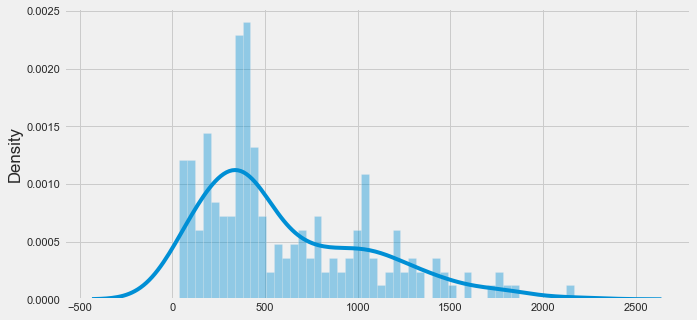

In [128]:
plt.figure(figsize=(10,5))
sns.distplot(proc_statement_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [129]:
split_statement_df = get_split_df(proc_statement_df)
split_statement_df.tail(10)

  0%|          | 0/195 [00:00<?, ?it/s]

type       date           title        speaker  word_count  \
820  statement 2021-09-22  FOMC Statement  Jerome Powell         200   
821  statement 2021-09-22  FOMC Statement  Jerome Powell         200   
822  statement 2021-09-22  FOMC Statement  Jerome Powell          86   
823  statement 2021-11-03  FOMC Statement  Jerome Powell         200   
824  statement 2021-11-03  FOMC Statement  Jerome Powell         200   
825  statement 2021-11-03  FOMC Statement  Jerome Powell         184   
826  statement 2021-12-15  FOMC Statement  Jerome Powell         200   
827  statement 2021-12-15  FOMC Statement  Jerome Powell         200   
828  statement 2021-12-15  FOMC Statement  Jerome Powell         142   
829  statement 2008-11-25  FOMC statement   Ben Bernanke         192   

     decision  rate next_meeting  next_decision  next_rate  \
820         0   0.0   2021-11-03              0        0.0   
821         0   0.0   2021-11-03              0        0.0   
822         0   0.0   2021-11-03              0        0.0   
823         0   0.0   2021-12-15              0        0.0   
824         0   0.0   2021-12-15              0        0.0   
825         0   0.0   2021-12-15              0        0.0   
826         0   0.0          NaT           <NA>        NaN   
827         0   0.0          NaT           <NA>        NaN   
828         0   0.0          NaT           <NA>        NaN   
829        -1   0.0   2008-12-16             -1        0.0   

                                                                                                                                                                                                        text  \
820  With progress on vaccinations and strong policy support indicators of economic activity and employment have continued to strengthen The sectors most adversely affected by the pandemic have improve...   
821  keep the target range for the federal funds rate at to percent and expects it will be appropriate to maintain this target range until labor market conditions have reached levels consistent with th...   
822  flow of credit to households and businesses In assessing the appropriate stance of monetary policy the Committee will continue to monitor the implications of incoming information for the economic ...   
823  With progress on vaccinations and strong policy support indicators of economic activity and employment have continued to strengthen The sectors most adversely affected by the pandemic have improve...   
824  and term inflation expectations remain well anchored at percent The Committee expects to maintain an accommodative stance of monetary policy until these outcomes are achieved The Committee decided...   
825  backed securities by at least billion per month Beginning in December the Committee will increase its holdings of Treasury securities by at least billion per month and of agency mortgage backed se...   
826  With progress on vaccinations and strong policy support indicators of economic activity and employment have continued to strengthen The sectors most adversely affected by the pandemic have improve...   
827  new variants of the virus The Committee seeks to achieve maximum employment and inflation at the rate of percent over the longer run In support of these goals the Committee decided to keep the tar...   
828  similar reductions in the pace of net asset purchases will likely be appropriate each month but it is prepared to adjust the pace of purchases if warranted by changes in the economic outlook The F...   
829  The Federal Reserve announced on Tuesday that it will initiate a program to purchase the direct obligations of housing related government sponsored enterprises GSEs Fannie Mae Freddie Mac and the ...   

                                                                                                                                                                                               text_sections  \
820  [The Federal Reserve, the centra

### Filter out by keywords

In [130]:
# Keep sections having keywords and long enough
keyword_statement_df = remove_short_nokeyword(proc_statement_df)
keyword_statement_df.reset_index(drop=True, inplace=True)
print(keyword_statement_df.shape)
keyword_statement_df

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

(105, 13)


type       date           title         speaker  word_count  \
0    statement 1994-05-17  FOMC Statement  Alan Greenspan          38   
1    statement 1994-11-15  FOMC Statement  Alan Greenspan          27   
2    statement 1996-01-31  FOMC Statement  Alan Greenspan         391   
3    statement 1997-03-25  FOMC Statement  Alan Greenspan         405   
4    statement 1998-09-29  FOMC Statement  Alan Greenspan         373   
..         ...        ...             ...             ...         ...   
100  statement 2021-06-16  FOMC Statement   Jerome Powell          39   
101  statement 2021-07-28  FOMC Statement   Jerome Powell         223   
102  statement 2021-09-22  FOMC Statement   Jerome Powell         234   
103  statement 2021-11-03  FOMC Statement   Jerome Powell         303   
104  statement 2021-12-15  FOMC Statement   Jerome Powell         155   

     decision  rate next_meeting  next_decision  next_rate  \
0           1  4.25   1994-07-06              0       4.25   
1           1  5.50   1994-12-20              0       5.50   
2          -1  5.25   1996-03-26              0       5.25   
3           1  5.50   1997-05-20              0       5.50   
4          -1  5.25   1998-10-15             -1       5.00   
..        ...   ...          ...            ...        ...   
100         0  0.00   2021-07-28              0       0.00   
101         0  0.00   2021-09-22              0       0.00   
102         0  0.00   2021-11-03              0       0.00   
103         0  0.00   2021-12-15              0       0.00   
104         0  0.00          NaT           <NA>        NaN   

                                                                                                                                                                                                        text  \
0    The Board approved an increase in the discount rate from 3 percent to 3-1/2 percent, effective immediately, and the Federal Open Market Committee agreed that this increase should be allowed to sho...   
1                                        In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.   
2    For immediate releaseThe Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective im...   
3    For immediate release\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage point to around 5-1/2 pe...   
4    For immediate releaseThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1/...   
..                                                                                                                                                                                                       ...   
100  The path of the economy will depend significantly on the course of the virus. Progress on vaccinations will likely continue to reduce the effects of the public health crisis on the economy, but ri...   
101  The Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run. With inflation having run persistently below this longer-run goal, the Committee will ...   
102  The Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run. With inflation having run persistently below this longer-run goal, the Committee will ...   
103  The Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run. With inflation having run persistently below this longer-run goal, the Committee will ...   
104  With progress on vaccinations and strong policy support, indicators of economic activity and em

In [131]:
# Drop text during the process to reduce the output size
proc_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Minutes DataFrame

In [132]:
minutes_df.head()

date  \
0 1993-02-03   
1 1993-03-23   
2 1993-05-18   
3 1993-07-07   
4 1993-08-17   

                                                                                                                                                                                                  contents  \
0  A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System in \r\n    Washington, D.C., on Tuesday, February 2, 1993, at...   
1  A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System in \r\n    Washington, D.C.,  on Tuesday, March 23,  1993,  a...   
2  A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System \r\n    in Washington, D.C.,  on Tuesday, May 18,  1993,  at ...   
3  A meeting of the Federal Open Market Committee was held in the \r\n    offices of the Board of Governors of the Federal Reserve System in \r\n    Washington, D.C., on Tuesday, July 6, 1993, at 2:3...   
4  A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System \r\n    in Washington, D.C., on Tuesday, August 17, 1993, at ...   

          speaker                 title  
0  Alan Greenspan  FOMC Meeting Minutes  
1  Alan Greenspan  FOMC Meeting Minutes  
2  Alan Greenspan  FOMC Meeting Minutes  
3  Alan Greenspan  FOMC Meeting Minutes  
4  Alan Greenspan  FOMC Meeting Minutes

In [133]:
# Reorganize the dataframe
proc_minutes_df = reorganize_df(minutes_df, 'minutes')

No rate decision found:  0
Shape of the dataframe:  (223, 13)


In [134]:
# Check the returned dataframe
proc_minutes_df

type       date                 title         speaker  word_count  \
0    minutes 1993-02-03  FOMC Meeting Minutes  Alan Greenspan       10241   
1    minutes 1993-03-23  FOMC Meeting Minutes  Alan Greenspan        5792   
2    minutes 1993-05-18  FOMC Meeting Minutes  Alan Greenspan        5001   
3    minutes 1993-07-07  FOMC Meeting Minutes  Alan Greenspan        7064   
4    minutes 1993-08-17  FOMC Meeting Minutes  Alan Greenspan        4679   
..       ...        ...                   ...             ...         ...   
218  minutes 2021-06-16  FOMC Meeting Minutes   Jerome Powell        9442   
219  minutes 2021-07-28  FOMC Meeting Minutes   Jerome Powell       10415   
220  minutes 2021-09-22  FOMC Meeting Minutes   Jerome Powell        8692   
221  minutes 2021-11-03  FOMC Meeting Minutes   Jerome Powell        8138   
222  minutes 2021-12-15  FOMC Meeting Minutes   Jerome Powell        9253   

     decision  rate next_meeting  next_decision  next_rate  \
0           0   3.0   1993-02-18              0        3.0   
1           0   3.0   1993-05-18              0        3.0   
2           0   3.0   1993-07-07              0        3.0   
3           0   3.0   1993-08-17              0        3.0   
4           0   3.0   1993-09-21              0        3.0   
..        ...   ...          ...            ...        ...   
218         0   0.0   2021-07-28              0        0.0   
219         0   0.0   2021-09-22              0        0.0   
220         0   0.0   2021-11-03              0        0.0   
221         0   0.0   2021-12-15              0        0.0   
222         0   0.0          NaT           <NA>        NaN   

                                                                                                                                                                                                        text  \
0    A meeting of the Federal Open Market Committee was held in     the offices of the Board of Governors of the Federal Reserve System in     Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p....   
1    A meeting of the Federal Open Market Committee was held in     the offices of the Board of Governors of the Federal Reserve System in     Washington, D.C.,  on Tuesday, March 23,  1993,  at  9:00 ...   
2    A meeting of the Federal Open Market Committee was held in     the offices of the Board of Governors of the Federal Reserve System     in Washington, D.C.,  on Tuesday, May 18,  1993,  at  9:00 a....   
3    A meeting of the Federal Open Market Committee was held in the     offices of the Board of Governors of the Federal Reserve System in     Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. a...   
4    A meeting of the Federal Open Market Committee was held in     the offices of the Board of Governors of the Federal Reserve System     in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a.m...   
..                                                                                                                                                                                                       ...   
218  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...   
219  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...   
220  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...   
221  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...   
222  The Federal Reserve, the central bank of the 

In [135]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

Empty DataFrame
Columns: [type, date, title, speaker, word_count, decision, rate, next_meeting, next_decision, next_rate, text, text_sections, org_text]
Index: []

/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

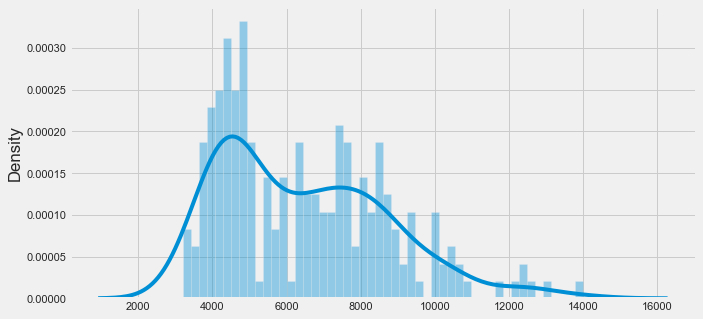

In [136]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [137]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

Empty DataFrame
Columns: [type, date, title, speaker, word_count, decision, rate, next_meeting, next_decision, next_rate, text, text_sections, org_text]
Index: []

Meeting minutes includes various topics, so it makes sense to extract relevant sections. <br />
Check some common sections.

In [138]:
# Check what kind of sections are in common

a = minutes_df.contents.str.lower().str.count('staff economic outlook')
b = minutes_df.contents.str.lower().str.count('developments in financial markets')
c = minutes_df.contents.str.lower().str.count('staff review of the economic situation')
d = minutes_df.contents.str.lower().str.count('staff review of the financial situation')
e = minutes_df.contents.str.lower().str.count('participants\' views on current condition')
f = minutes_df.contents.str.lower().str.count('committee policy action')
g = minutes_df.contents.str.lower().str.count('voting for this action')
h = minutes_df.contents.str.lower().str.count('federal fund')

pd.options.display.max_rows = 300
pd.DataFrame({'date': minutes_df['date'], 'a': a, 'b':b, 'c':c, 'd':d, 'e':e, 'f':f, 'g':g, 'h':h})

date  a  b  c  d  e  f  g   h
0   1993-02-03  0  0  0  0  0  0  0   1
1   1993-03-23  0  0  0  0  0  0  0   3
2   1993-05-18  0  0  0  0  0  0  0   1
3   1993-07-07  0  0  0  0  0  0  0   3
4   1993-08-17  0  0  0  0  0  0  0   1
5   1993-09-21  0  0  0  0  0  0  0   1
6   1993-11-16  0  0  0  0  0  0  0   1
7   1993-12-21  0  0  0  0  0  0  0   2
8   1994-02-04  0  1  0  0  0  0  0   0
9   1994-03-22  0  0  0  0  0  0  0   2
10  1994-03-22  0  0  0  0  0  0  0   2
11  1994-05-17  0  0  0  0  0  0  0   1
12  1994-07-06  0  0  0  0  0  0  0   1
13  1994-08-16  0  0  0  0  0  0  0   1
14  1994-09-27  0  0  0  0  0  0  0   2
15  1994-11-15  0  0  0  0  0  0  0   1
16  1994-12-20  0  0  0  0  0  0  0   0
17  1995-02-01  0  0  0  0  0  0  0   1
18  1995-03-28  0  1  0  0  0  0  0   1
19  1995-05-23  0  2  0  0  0  0  0   1
20  1995-07-06  0  0  0  0  0  0  0   2
21  1995-08-22  0  0  0  0  0  0  0   1
22  1995-09-26  0  0  0  0  0  0  0   1
23  1995-11-15  0  0  0  0  0  0  0   2
24  1995-12-19  0  0  0  0  0  0  0   3
25  1996-01-31  0  0  0  0  0  0  0   3
26  1996-03-26  0  0  0  0  0  0  0   1
27  1996-05-21  0  0  0  0  0  0  0   2
28  1996-07-03  0  0  0  0  0  0  0   2
29  1996-08-20  0  0  0  0  0  0  0   1
30  1996-09-24  0  0  0  0  0  0  0   1
31  1996-11-13  0  0  0  0  0  0  0   1
32  1996-12-17  0  0  0  0  0  0  0   1
33  1997-02-05  0  0  0  0  0  0  0   1
34  1997-03-25  0  0  0  0  0  0  0   1
35  1997-05-20  0  0  0  0  0  0  0   0
36  1997-07-02  0  0  0  0  0  0  0   1
37  1997-08-19  0  0  0  0  0  0  0   9
38  1997-09-30  0  0  0  0  0  0  0   8
39  1997-11-12  0  0  0  0  0  0  0   8
40  1997-12-16  0  0  0  0  0  0  0   8
41  1998-02-04  0  0  0  0  0  0  0   8
42  1998-03-31  0  0  0  0  0  0  0   8
43  1998-05-19  0  0  0  0  0  0  0   9
44  1998-07-01  0  0  0  0  0  0  0   8
45  1998-08-18  0  1  0  0  0  0  0   7
46  1998-09-29  0  1  0  0  0  0  0  10
47  1998-11-17  0  0  0  0  0  0  0  13
48  1998-12-22  0  0  0  0  0  0  0   4
49  1999-02-03  0  0  0  0  0  0  0   3
50  1999-03-30  0  0  0  0  0  0  0   4
51  1999-05-18  0  0  0  0  0  0  0   5
52  1999-06-30  0  0  0  0  0  0  0   5
53  1999-08-24  0  0  0  0  0  0  0   5
54  1999-10-05  0  0  0  0  0  0  0   4
55  1999-11-16  0  0  0  0  0  0  0   5
56  1999-12-21  0  0  0  0  0  0  0   6
57  2000-02-02  0  0  0  0  0  0  0   7
58  2000-03-21  0  0  0  0  0  0  0   4
59  2000-05-16  0  0  0  0  0  0  0   4
60  2000-06-28  0  0  0  0  0  0  0   5
61  2000-08-22  0  0  0  0  0  0  0   4
62  2000-10-03  0  0  0  0  0  0  0   3
63  2000-11-15  0  0  0  0  0  0  0   4
64  2000-12-19  0  1  0  0  0  0  0   7
65  2000-12-19  0  1  0  0  0  0  0   7
66  2001-01-31  0  0  0  0  0  0  0   7
67  2001-03-20  0  0  0  0  0  0  0   8
68  2001-03-20  0  0  0  0  0  0  0   8
69  2001-03-20  0  0  0  0  0  0  0   8
70  2001-05-15  0  1  0  0  0  0  0   9
71  2001-06-27  0  0  0  0  0  0  0   6
72  2001-08-21  0  0  0  0  0  0  0   7
73  2001-08-21  0  0  0  0  0  0  0   7
74  2001-08-21  0  0  0  0  0  0  0   7
75  2001-10-02  0  0  0  0  0  0  0  10
76  2001-11-06  0  0  0  0  0  0  0   7
77  2001-12-11  0  0  0  0  0  0  0   7
78  2002-01-30  0  0  0  0  0  0  0   6
79  2002-03-19  0  0  0  0  0  0  0   5
80  2002-05-07  0  0  0  0  0  0  0   4
81  2002-06-26  0  0  0  0  0  0  0   4
82  2002-08-13  0  0  0  0  0  0  0   4
83  2002-09-24  0  0  0  0  0  0  0   2
84  2002-11-06  0  0  0  0  0  0  0   7
85  2002-12-10  0  0  0  0  0  0  0   3
86  2003-01-29  0  0  0  0  0  0  0   5
87  2003-03-18  0  0  0  0  0  0  0   2
88  2003-05-06  0  0  0  0  0  0  0   3
89  2003-06-25  0  0  0  0  0  0  0  12
90  2003-08-12  0  0  0  0  0  0  0   4
91  2003-09-16  0  0  0  0  0  0  0   5
92  2003-10-28  0  0  0  0  0  0  0   6
93  2003-12-09  0  0  0  0  0  0  0   5
94  2004-01-28  0  0  0  0  0  0  0   3
95  2004-03-16  0  0  0  0  0  0  0   4
96  2004-05-04  0  0  0  0  0  0  0   5
97  2004-06-30  0  0  0  0  0  0  0   4
98  2004-08-10  0  0  0  0  0  0  0   4
99  2004-0

In [139]:
pd.options.display.max_rows = 20

Sections are added from time to time. For example, quarterly economic forcast started in 2009. Leave manually handling those for now, take another approach to filter sentenses by length and key words here.

In [140]:
proc_minutes_df = remove_short_section(proc_minutes_df, min_words=50)

  0%|          | 0/223 [00:00<?, ?it/s]

### Split contents to max 200 words

In [142]:
split_minutes_df = get_split_df(proc_minutes_df)
print(split_minutes_df.shape)
split_minutes_df.tail(10)

  0%|          | 0/223 [00:00<?, ?it/s]

(8242, 13)


type       date                 title        speaker  word_count  \
8232  minutes 2021-12-15  FOMC Meeting Minutes  Jerome Powell         200   
8233  minutes 2021-12-15  FOMC Meeting Minutes  Jerome Powell         200   
8234  minutes 2021-12-15  FOMC Meeting Minutes  Jerome Powell         200   
8235  minutes 2021-12-15  FOMC Meeting Minutes  Jerome Powell         200   
8236  minutes 2021-12-15  FOMC Meeting Minutes  Jerome Powell         200   
8237  minutes 2021-12-15  FOMC Meeting Minutes  Jerome Powell         200   
8238  minutes 2021-12-15  FOMC Meeting Minutes  Jerome Powell         200   
8239  minutes 2021-12-15  FOMC Meeting Minutes  Jerome Powell         200   
8240  minutes 2021-12-15  FOMC Meeting Minutes  Jerome Powell         200   
8241  minutes 2021-12-15  FOMC Meeting Minutes  Jerome Powell          96   

      decision  rate next_meeting  next_decision  next_rate  \
8232         0   0.0          NaT           <NA>        NaN   
8233         0   0.0          NaT           <NA>        NaN   
8234         0   0.0          NaT           <NA>        NaN   
8235         0   0.0          NaT           <NA>        NaN   
8236         0   0.0          NaT           <NA>        NaN   
8237         0   0.0          NaT           <NA>        NaN   
8238         0   0.0          NaT           <NA>        NaN   
8239         0   0.0          NaT           <NA>        NaN   
8240         0   0.0          NaT           <NA>        NaN   
8241         0   0.0          NaT           <NA>        NaN   

                                                                                                                                                                                                         text  \
8232  January Participants also expected that economic conditions would evolve in a manner such that similar reductions in the pace of net asset purchases would be appropriate each subsequent month resu...   
8233  participants also noted that it could be appropriate to begin to reduce the size of the Federal Reserve's balance sheet relatively soon after beginning to raise the federal funds rate Some partici...   
8234  had been solid in recent months and the unemployment rate had declined substantially They remarked that supply and demand imbalances related to the pandemic and the reopening of the economy had co...   
8235  in the postmeeting statement and instead note that supply and demand imbalances have continued to contribute to elevated inflation Members also agreed that with the emergence of the Omicron varian...   
8236  inflation criteria in the guidance had been met and that the postmeeting statement should note that with inflation having exceeded percent for some time the Committee expected that it would be app...   
8237  holdings would cease by mid March under the Committee's outlook a few months sooner than had been anticipated at the previous meeting Members noted that the Committee was prepared to adjust the pa...   
8238  emerged that could impede the attainment of the Committee's goals They also concurred that in assessing the appropriate stance of monetary policy they would take into account a wide range of infor...   
8239  businesses The path of the economy continues to depend on the course of the virus Progress on vaccinations and an easing of supply constraints are expected to support continued gains in economic a...   
8240  of its net asset purchases by billion for Treasury securities and billion for agency mortgage backed securities Beginning in January the Committee will increase its holdings of Treasury securities...   
8241  if risks emerge that could impede the attainment of the Committee's goals The Committee's assessments will take into account a wide range of information including readings on public health labor m...   

                                                                                                                                                                       

### Filter out by keywords

In [143]:
# Keep sections having keywords and long enough
keyword_minutes_df = remove_short_nokeyword(proc_minutes_df)
keyword_minutes_df.reset_index(drop=True, inplace=True)
print(keyword_minutes_df.shape)
keyword_minutes_df

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

(223, 13)


type       date                 title         speaker  word_count  \
0    minutes 1993-02-03  FOMC Meeting Minutes  Alan Greenspan        2119   
1    minutes 1993-03-23  FOMC Meeting Minutes  Alan Greenspan        1770   
2    minutes 1993-05-18  FOMC Meeting Minutes  Alan Greenspan        1182   
3    minutes 1993-07-07  FOMC Meeting Minutes  Alan Greenspan        2636   
4    minutes 1993-08-17  FOMC Meeting Minutes  Alan Greenspan        1272   
..       ...        ...                   ...             ...         ...   
218  minutes 2021-06-16  FOMC Meeting Minutes   Jerome Powell        2273   
219  minutes 2021-07-28  FOMC Meeting Minutes   Jerome Powell        2637   
220  minutes 2021-09-22  FOMC Meeting Minutes   Jerome Powell        2198   
221  minutes 2021-11-03  FOMC Meeting Minutes   Jerome Powell        2445   
222  minutes 2021-12-15  FOMC Meeting Minutes   Jerome Powell        2393   

     decision  rate next_meeting  next_decision  next_rate  \
0           0   3.0   1993-02-18              0        3.0   
1           0   3.0   1993-05-18              0        3.0   
2           0   3.0   1993-07-07              0        3.0   
3           0   3.0   1993-08-17              0        3.0   
4           0   3.0   1993-09-21              0        3.0   
..        ...   ...          ...            ...        ...   
218         0   0.0   2021-07-28              0        0.0   
219         0   0.0   2021-09-22              0        0.0   
220         0   0.0   2021-11-03              0        0.0   
221         0   0.0   2021-12-15              0        0.0   
222         0   0.0          NaT           <NA>        NaN   

                                                                                                                                                                                                        text  \
0    The nominal U.S. merchandise trade deficit widened slightly     in November. For October and November together, however, the deficit     narrowed a little from its average rate in the third quarte...   
1    In foreign exchange markets, the trade-weighted value of the     dollar in terms of the other G-10 currencies fell on balance over the     intermeeting period. The dollar depreciated through late ...   
2    In foreign exchange markets, the trade-weighted value of the     dollar in terms of the other G-10 currencies declined somewhat on     balance over the intermeeting period. The dollar depreciated ...   
3    Other short-term interest rates also were little changed on     balance over the period since the May meeting. Early in the period,     unexpectedly robust employment data for May, coupled with me...   
4    Money market interest rates were little changed on balance     over the intermeeting period, while rates on intermediate-term U.S.     Treasury obligations and on fixed-rate mortgages dropped slig...   
..                                                                                                                                                                                                       ...   
218  Over the period, market participants focused on data showing lower employment growth and higher inflation readings than had been expected. The median 2021 core personal consumption expenditures (P...   
219  Developments in Financial Markets and Open Market OperationsThe manager turned first to a discussion of developments in financial markets. Although there were notable moves in some asset prices ov...   
220  Regarding the outlook for monetary policy, market participants noted policymaker communications suggesting that tapering of asset purchases could begin this year and end by mid-2022. Around half o...   
221  Policy sensitive rates increased across most advanced economies. The central banks of Norway and New Zealand raised their policy rates early in the period, and policy communications from the Bank ...   
222  Developments in Financial Markets and Open Ma

/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

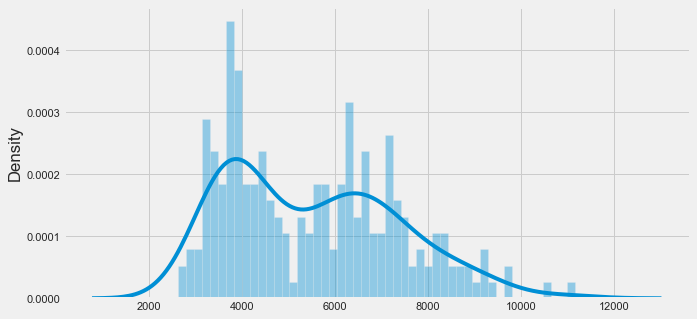

In [144]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [145]:
# Drop text during the process to reduce the output size
proc_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Press Conference Script DataFrame
Press Conference transcripts are available only from 2011

In [146]:
# Sample
print(presconf_script_df['contents'][2])

CHAIRMAN BERNANKE.  Good afternoon, everybody.  Welcome.  In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy.  I will then be glad to take your questions.   As indicated in its statement, the Committee decided today to maintain the policies that were initiated at previous meetings.  In particular, the Committee is keeping the target range for the federal funds rate at 0 to ¼ percent and continues to anticipate that economic conditions are likely to warrant exceptionally low levels for the federal funds rate at least through mid-2013. The Committee will continue the program that we announced in September to extend the average maturity of the Federal Reserve’s holdings of securities by purchasing longer-term Treasury securities and selling an equal amount of shorter-term Treasury securities.  Our purchases of longer-term securities exert downward pressures on longer-term interest rates; at the same time, our guidance about the lik

In [147]:
# Reorganize the dataframe
proc_presconf_script_df = reorganize_df(presconf_script_df, 'presconf_script')


No rate decision found:  0
Shape of the dataframe:  (49, 13)


In [148]:
# Check the returned dataframe
proc_presconf_script_df

type       date                             title  \
0   presconf_script 2011-04-27  FOMC Press Conference Transcript   
1   presconf_script 2011-06-22  FOMC Press Conference Transcript   
2   presconf_script 2011-11-02  FOMC Press Conference Transcript   
3   presconf_script 2012-01-25  FOMC Press Conference Transcript   
4   presconf_script 2012-04-25  FOMC Press Conference Transcript   
..              ...        ...                               ...   
44  presconf_script 2021-06-16  FOMC Press Conference Transcript   
45  presconf_script 2021-07-28  FOMC Press Conference Transcript   
46  presconf_script 2021-09-22  FOMC Press Conference Transcript   
47  presconf_script 2021-11-03  FOMC Press Conference Transcript   
48  presconf_script 2021-12-15  FOMC Press Conference Transcript   

          speaker  word_count  decision  rate next_meeting  next_decision  \
0    Ben Bernanke        8763         0   0.0   2011-06-22              0   
1    Ben Bernanke        7364         0   0.0   2011-08-01              0   
2    Ben Bernanke        7360         0   0.0   2011-11-28              0   
3    Ben Bernanke       10135         0   0.0   2012-03-13              0   
4    Ben Bernanke        7680         0   0.0   2012-06-20             -1   
..            ...         ...       ...   ...          ...            ...   
44  Jerome Powell       10716         0   0.0   2021-07-28              0   
45  Jerome Powell        9775         0   0.0   2021-09-22              0   
46  Jerome Powell        9284         0   0.0   2021-11-03              0   
47  Jerome Powell        9863         0   0.0   2021-12-15              0   
48  Jerome Powell       10830         0   0.0          NaT           <NA>   

    next_rate  \
0         0.0   
1         0.0   
2         0.0   
3         0.0   
4         0.0   
..        ...   
44        0.0   
45        0.0   
46        0.0   
47        0.0   
48        NaN   

                                                                                                                                                                                                       text  \
0   CHAIRMAN BERNANKE.  Good afternoon.  Welcome.  In my opening remarks, I’d like to briefly first review today’s policy decision.  I’ll then turn next to the Federal Open Market Committee’s quarterl...   
1   CHAIRMAN BERNANKE.  Good afternoon and welcome.   In my opening remarks today, I’ll briefly review today’s policy decision.  And I’ll place the decision in the context of our economic projections ...   
2   CHAIRMAN BERNANKE.  Good afternoon, everybody.  Welcome.  In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy.  I will then be glad to take...   
3   CHAIRMAN BERNANKE.  Good afternoon and welcome.   In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...   
4   CHAIRMAN BERNANKE.  Good afternoon.  Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th...   
..                                                                                                                                                                                                      ...   
44  CHAIR POWELL.  Good afternoon.  At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us:  maximum employment and price stability. Today ...   
45  CHAIR POWELL.  Good afternoon.  At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us:  maximum employment and price stability. Today ...   
46  CHAIR POWELL. Good afternoon.  At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us:  maximum employment and price stability. Today, ...  

In [149]:
# Check which row does not have rate
proc_presconf_script_df.loc[proc_presconf_script_df['rate'].isnull()]

Empty DataFrame
Columns: [type, date, title, speaker, word_count, decision, rate, next_meeting, next_decision, next_rate, text, text_sections, org_text]
Index: []

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [150]:
script_data_list = []

for i, row in tqdm(proc_presconf_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_presconf_script_df.columns

presconf_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
presconf_script_speaker_df

0it [00:00, ?it/s]

type       date                             title  \
0     presconf_script 2011-04-27  FOMC Press Conference Transcript   
1     presconf_script 2011-04-27  FOMC Press Conference Transcript   
2     presconf_script 2011-04-27  FOMC Press Conference Transcript   
3     presconf_script 2011-04-27  FOMC Press Conference Transcript   
4     presconf_script 2011-04-27  FOMC Press Conference Transcript   
...               ...        ...                               ...   
2622  presconf_script 2021-12-15  FOMC Press Conference Transcript   
2623  presconf_script 2021-12-15  FOMC Press Conference Transcript   
2624  presconf_script 2021-12-15  FOMC Press Conference Transcript   
2625  presconf_script 2021-12-15  FOMC Press Conference Transcript   
2626  presconf_script 2021-12-15  FOMC Press Conference Transcript   

                speaker  word_count  decision  rate next_meeting  \
0     CHAIRMAN BERNANKE        1617         0   0.0   2011-06-22   
1              QUESTION          64         0   0.0   2011-06-22   
2     CHAIRMAN BERNANKE         198         0   0.0   2011-06-22   
3              QUESTION          56         0   0.0   2011-06-22   
4     CHAIRMAN BERNANKE         322         0   0.0   2011-06-22   
...                 ...         ...       ...   ...          ...   
2622          GREG ROBB          77         0   0.0          NaT   
2623       CHAIR POWELL         123         0   0.0          NaT   
2624          GREG ROBB           2         0   0.0          NaT   
2625       CHAIR POWELL           2         0   0.0          NaT   
2626     MICHELLE SMITH           7         0   0.0          NaT   

     next_decision  next_rate  \
0                0        0.0   
1                0        0.0   
2                0        0.0   
3                0        0.0   
4                0        0.0   
...            ...        ...   
2622          <NA>        NaN   
2623          <NA>        NaN   
2624          <NA>        NaN   
2625          <NA>        NaN   
2626          <NA>        NaN   

                                                                                                                                                                                                         text  \
0      Good afternoon.  Welcome.  In my opening remarks, I’d like to briefly first review today’s policy decision.  I’ll then turn next to the Federal Open Market Committee’s quarterly economic projecti...   
1      Mr. Chairman, tomorrow we’re going to get a pretty weak first-quarter GDP number.  Your own projections for the year have been downgraded in this meeting.  How—first of all, what do you see as th...   
2      You’re correct.  We haven’t seen the GDP number yet.  But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe something a little under 2 ...   
3      Mr. Chairman, given what you know about the pace of the economy now, what is your best guess for how soon the Fed needs to begin to withdraw its extraordinary stimulus for the economy?  And could...   
4      Well, currently as the statement suggests, we are in a moderate recovery.  We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is.  And we’ll...   
...                                                                                                                                                                                                       ...   
2622   Just a quick follow-up.  I guess that some people are saying that it was the, you know, the stimulus in March that was sort of over—we didn’t really need all that stimulus, and that there was tal...   
2623   I didn’t push back at all.  And the reason I didn’t—and there was no—there was lots of talk about that, but not from the Fed, because that is not our job.  We are not the CBO, and we’re not elect...   
2624                                                                             

In [151]:
# Filter by the word count
presconf_script_speaker_df = presconf_script_speaker_df.loc[presconf_script_speaker_df['word_count'] >= 50]

(1876, 13)


/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

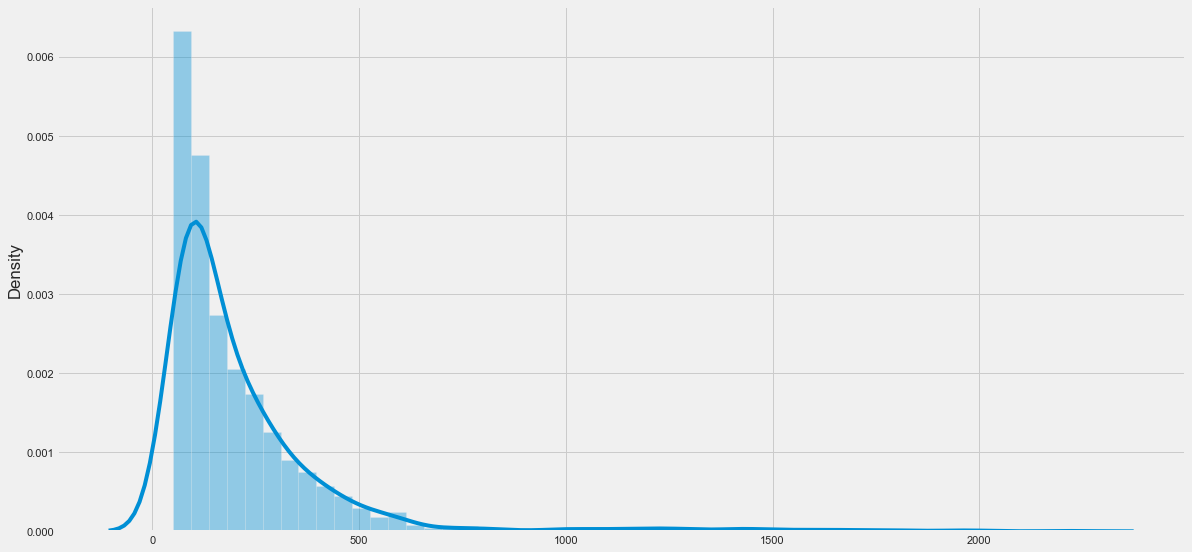

In [152]:
print(presconf_script_speaker_df.shape)
sns.distplot(presconf_script_speaker_df["word_count"].values, bins=50)

In [153]:
# Filter to have only chairperson's speak

tmp_list = []
for i, row in presconf_script_speaker_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = presconf_script_speaker_df.columns
presconf_script_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
presconf_script_chair_df

type       date                             title  \
0     presconf_script 2011-04-27  FOMC Press Conference Transcript   
1     presconf_script 2011-04-27  FOMC Press Conference Transcript   
2     presconf_script 2011-04-27  FOMC Press Conference Transcript   
3     presconf_script 2011-04-27  FOMC Press Conference Transcript   
4     presconf_script 2011-04-27  FOMC Press Conference Transcript   
...               ...        ...                               ...   
1088  presconf_script 2021-12-15  FOMC Press Conference Transcript   
1089  presconf_script 2021-12-15  FOMC Press Conference Transcript   
1090  presconf_script 2021-12-15  FOMC Press Conference Transcript   
1091  presconf_script 2021-12-15  FOMC Press Conference Transcript   
1092  presconf_script 2021-12-15  FOMC Press Conference Transcript   

            speaker  word_count  decision  rate next_meeting next_decision  \
0      Ben Bernanke        1617         0   0.0   2011-06-22             0   
1      Ben Bernanke         198         0   0.0   2011-06-22             0   
2      Ben Bernanke         322         0   0.0   2011-06-22             0   
3      Ben Bernanke         207         0   0.0   2011-06-22             0   
4      Ben Bernanke         167         0   0.0   2011-06-22             0   
...             ...         ...       ...   ...          ...           ...   
1088  Jerome Powell         156         0   0.0          NaT          <NA>   
1089  Jerome Powell         445         0   0.0          NaT          <NA>   
1090  Jerome Powell         375         0   0.0          NaT          <NA>   
1091  Jerome Powell         219         0   0.0          NaT          <NA>   
1092  Jerome Powell         123         0   0.0          NaT          <NA>   

      next_rate  \
0           0.0   
1           0.0   
2           0.0   
3           0.0   
4           0.0   
...         ...   
1088        NaN   
1089        NaN   
1090        NaN   
1091        NaN   
1092        NaN   

                                                                                                                                                                                                         text  \
0      Good afternoon.  Welcome.  In my opening remarks, I’d like to briefly first review today’s policy decision.  I’ll then turn next to the Federal Open Market Committee’s quarterly economic projecti...   
1      You’re correct.  We haven’t seen the GDP number yet.  But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe something a little under 2 ...   
2      Well, currently as the statement suggests, we are in a moderate recovery.  We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is.  And we’ll...   
3      Thanks, Steve.  First, I should start by saying that the Secretary of the Treasury, of course, is the spokesperson for U.S. policy on the dollar and Secretary Geithner had some words yesterday.  ...   
4      Well, the dollar—the dollar fluctuates.  One factor, for example, that has caused fluctuations that have been quite extreme during the crisis has been the safe-haven effect.  So, for example, dur...   
...                                                                                                                                                                                                       ...   
1088   So, you know, with the balance sheet, we did have a balance sheet discussion, sort of a prelim—a first, first discussion of balance sheet issues today, [balance] sheet issues, at our meeting this...   
1089   No, I’m not expressing any judgment about, about the stimulus in, in that comment.  What I’m saying is, there’s a—there’s a sense among some that “you wanted inflation, this is what you wanted, h...   
1090   So I, I think the short-end actions are easy to understand, which is, you know, they’re basically very [monetary] policy-s

In [154]:
# Combine scripts of the same speaker for the same day.
tmp_date = ''
tmp_speaker = ''
tmp_data = []

print('Before: ', presconf_script_chair_df.shape)

for i, row in tqdm(presconf_script_chair_df.iterrows()):
    if (row['date'] == tmp_date) and (row['speaker'] == tmp_speaker):
        tmp_data[-1]['text'] += row['text']
        tmp_data[-1]['word_count'] += row['word_count']
        tmp_data[-1]['text_sections'].append(row['text'])
    else:
        tmp_date = row['date']
        tmp_speaker = row['speaker']
        row['text_sections'] = [row['text']]
        tmp_data.append(row)

presconf_script_chair_day_df = pd.DataFrame(tmp_data)

print('After', presconf_script_chair_day_df.shape)
presconf_script_chair_day_df.head()

Before:  (1093, 13)


0it [00:00, ?it/s]

After (49, 13)


type       date                             title  \
0   presconf_script 2011-04-27  FOMC Press Conference Transcript   
21  presconf_script 2011-06-22  FOMC Press Conference Transcript   
40  presconf_script 2011-11-02  FOMC Press Conference Transcript   
62  presconf_script 2012-01-25  FOMC Press Conference Transcript   
81  presconf_script 2012-04-25  FOMC Press Conference Transcript   

         speaker  word_count  decision  rate next_meeting next_decision  \
0   Ben Bernanke        7504         0   0.0   2011-06-22             0   
21  Ben Bernanke        6002         0   0.0   2011-08-01             0   
40  Ben Bernanke        5875         0   0.0   2011-11-28             0   
62  Ben Bernanke        7970         0   0.0   2012-03-13             0   
81  Ben Bernanke        5854         0   0.0   2012-06-20            -1   

    next_rate  \
0         0.0   
21        0.0   
40        0.0   
62        0.0   
81        0.0   

                                                                                                                                                                                                       text  \
0    Good afternoon.  Welcome.  In my opening remarks, I’d like to briefly first review today’s policy decision.  I’ll then turn next to the Federal Open Market Committee’s quarterly economic projecti...   
21   Good afternoon and welcome.   In my opening remarks today, I’ll briefly review today’s policy decision.  And I’ll place the decision in the context of our economic projections and our policy stra...   
40   Good afternoon, everybody.  Welcome.  In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy.  I will then be glad to take your questions.   ...   
62   Good afternoon and welcome.   In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy.  And f...   
81   Good afternoon.  Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in the context of our ec...   

                                                                                                                                                                                              text_sections  \
0   [ Good afternoon.  Welcome.  In my opening remarks, I’d like to briefly first review today’s policy decision.  I’ll then turn next to the Federal Open Market Committee’s quarterly economic project...   
21  [ Good afternoon and welcome.   In my opening remarks today, I’ll briefly review today’s policy decision.  And I’ll place the decision in the context of our economic projections and our policy str...   
40  [ Good afternoon, everybody.  Welcome.  In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy.  I will then be glad to take your questions.  ...   
62  [ Good afternoon and welcome.   In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy.  And ...   
81  [ Good afternoon.  Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in the context of our e...   

                                                                                                                                                                                                   org_text  
0   CHAIRMAN BERNANKE.  Good afternoon.  Welcome.  In my opening remarks, I’d like to briefly first review today’s policy decision.  I’ll then turn next to the Federal Open Market Committee’s quarterl...  
21  CHAIRMAN BERNANKE.  Good afternoon and welcome.   In my opening remarks today, I’ll briefly review today’s policy decision.  And I’ll place the decisi

/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

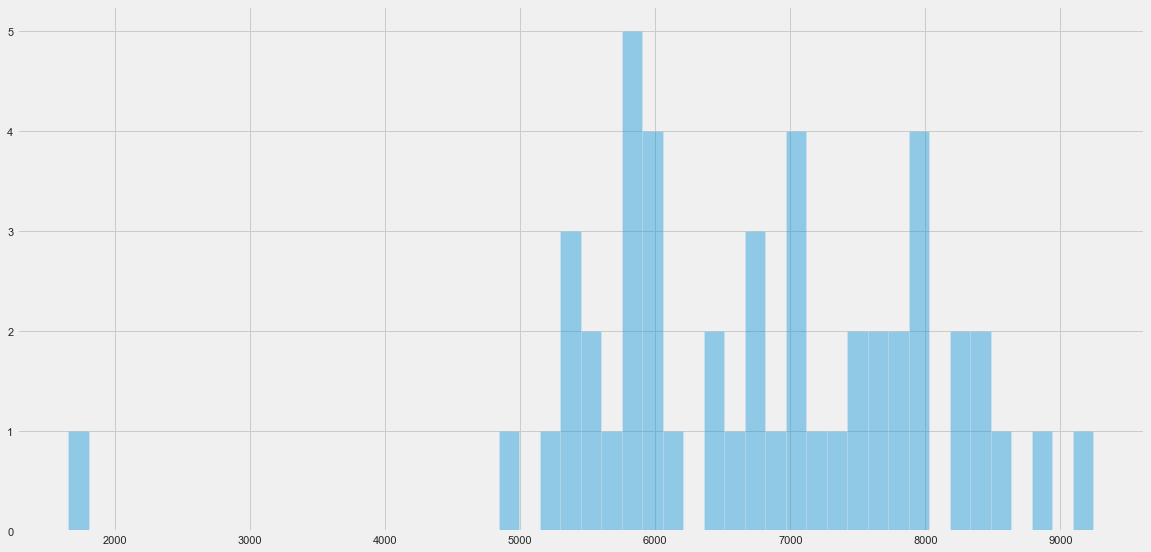

In [155]:
sns.distplot(list(presconf_script_chair_day_df['word_count']), bins=50, kde=False)

In [156]:
# # Check text
# print(presconf_script_chair_day_df['text'][0])

### Split contents to max 200 words

In [157]:
presconf_script_split_df = get_split_df(presconf_script_chair_day_df)
print(presconf_script_split_df.shape)
presconf_script_split_df.tail()

  0%|          | 0/49 [00:00<?, ?it/s]

(2215, 13)


type       date                             title  \
2210  presconf_script 2021-12-15  FOMC Press Conference Transcript   
2211  presconf_script 2021-12-15  FOMC Press Conference Transcript   
2212  presconf_script 2021-12-15  FOMC Press Conference Transcript   
2213  presconf_script 2021-12-15  FOMC Press Conference Transcript   
2214  presconf_script 2021-12-15  FOMC Press Conference Transcript   

            speaker  word_count  decision  rate next_meeting  next_decision  \
2210  Jerome Powell         200         0   0.0          NaT           <NA>   
2211  Jerome Powell         200         0   0.0          NaT           <NA>   
2212  Jerome Powell         200         0   0.0          NaT           <NA>   
2213  Jerome Powell         200         0   0.0          NaT           <NA>   
2214  Jerome Powell          54         0   0.0          NaT           <NA>   

      next_rate  \
2210        NaN   
2211        NaN   
2212        NaN   
2213        NaN   
2214        NaN   

                                                                                                                                                                                                         text  \
2210  just look at global sovereign yields around the world Look at JGBs look at bunds and they re so much lower You can get you can get you know a much higher yield on U S Treasuries by buying USTs rat...   
2211  about that But and I would just say that we you know we write down our own estimates of the of the terminal rate or the neutral rate of interest Those are highly uncertain And you know we ll make ...   
2212  financial conditions and we re focused on maximum employment and price stability Sure I d be happy to talk about that So as I mentioned we got the ECI reading just before the November meeting We g...   
2213  doesn t happen by accident They were out talking about a faster taper before the President made his decision So it s a were talking about it publicly So that s what happened And it had absolutely ...   
2214  own assessments inside the Fed but it s really not our role And I think very important that we stay out of that business no matter who s in the White House who s in Congress It s just it s just no...   

                                                                                                                                                                                                text_sections  \
2210  [ Good afternoon.  At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us:  maximum employment and price stability. Today, in support o...   
2211  [ Good afternoon.  At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us:  maximum employment and price stability. Today, in support o...   
2212  [ Good afternoon.  At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us:  maximum employment and price stability. Today, in support o...   
2213  [ Good afternoon.  At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us:  maximum employment and price stability. Today, in support o...   
2214  [ Good afternoon.  At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us:  maximum employment and price stability. Today, in support o...   

                                                                                                                                                                                                     org_text  
2210  CHAIR POWELL.  Good afternoon.  At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us:  maximum employment and price stability. Today,...  
2211  CHAIR POWELL.  Good afternoon.  At the Federal Reserve, we are strongly co

### Filter out by keywords

In [158]:
# Keep sections having keywords and long enough
presconf_script_keyword_df = remove_short_nokeyword(presconf_script_chair_day_df)
presconf_script_keyword_df.reset_index(drop=True, inplace=True)
print(presconf_script_keyword_df.shape)
presconf_script_keyword_df

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

(49, 13)


type       date                             title  \
0   presconf_script 2011-04-27  FOMC Press Conference Transcript   
1   presconf_script 2011-06-22  FOMC Press Conference Transcript   
2   presconf_script 2011-11-02  FOMC Press Conference Transcript   
3   presconf_script 2012-01-25  FOMC Press Conference Transcript   
4   presconf_script 2012-04-25  FOMC Press Conference Transcript   
..              ...        ...                               ...   
44  presconf_script 2021-06-16  FOMC Press Conference Transcript   
45  presconf_script 2021-07-28  FOMC Press Conference Transcript   
46  presconf_script 2021-09-22  FOMC Press Conference Transcript   
47  presconf_script 2021-11-03  FOMC Press Conference Transcript   
48  presconf_script 2021-12-15  FOMC Press Conference Transcript   

          speaker  word_count  decision  rate next_meeting next_decision  \
0    Ben Bernanke        3758         0   0.0   2011-06-22             0   
1    Ben Bernanke        2322         0   0.0   2011-08-01             0   
2    Ben Bernanke        2432         0   0.0   2011-11-28             0   
3    Ben Bernanke        5123         0   0.0   2012-03-13             0   
4    Ben Bernanke        2179         0   0.0   2012-06-20            -1   
..            ...         ...       ...   ...          ...           ...   
44  Jerome Powell        3857         0   0.0   2021-07-28             0   
45  Jerome Powell        2366         0   0.0   2021-09-22             0   
46  Jerome Powell        2669         0   0.0   2021-11-03             0   
47  Jerome Powell        3420         0   0.0   2021-12-15             0   
48  Jerome Powell        2897         0   0.0          NaT          <NA>   

    next_rate  \
0         0.0   
1         0.0   
2         0.0   
3         0.0   
4         0.0   
..        ...   
44        0.0   
45        0.0   
46        0.0   
47        0.0   
48        NaN   

                                                                                                                                                                                                       text  \
0   Good afternoon.  Welcome.  In my opening remarks, I’d like to briefly first review today’s policy decision.  I’ll then turn next to the Federal Open Market Committee’s quarterly economic projectio...   
1   Good afternoon and welcome.   In my opening remarks today, I’ll briefly review today’s policy decision.  And I’ll place the decision in the context of our economic projections and our policy strat...   
2   Good afternoon, everybody.  Welcome.  In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy.  I will then be glad to take your questions.   A...   
3   Good afternoon and welcome.   In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy.  And fi...   
4   Good afternoon.  Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in the context of our eco...   
..                                                                                                                                                                                                      ...   
44  Good afternoon.  At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us:  maximum employment and price stability. Today the Federal Ope...   
45  Good afternoon.  At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us:  maximum employment and price stability. Today the Federal Ope...   
46  Good afternoon.  At the Federal Reserve, we are strongly committed to achieving the monetary policy goals that Congress has given us:  maximum employment and price stability. Today, the Federal Op...   
47  Good a

/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

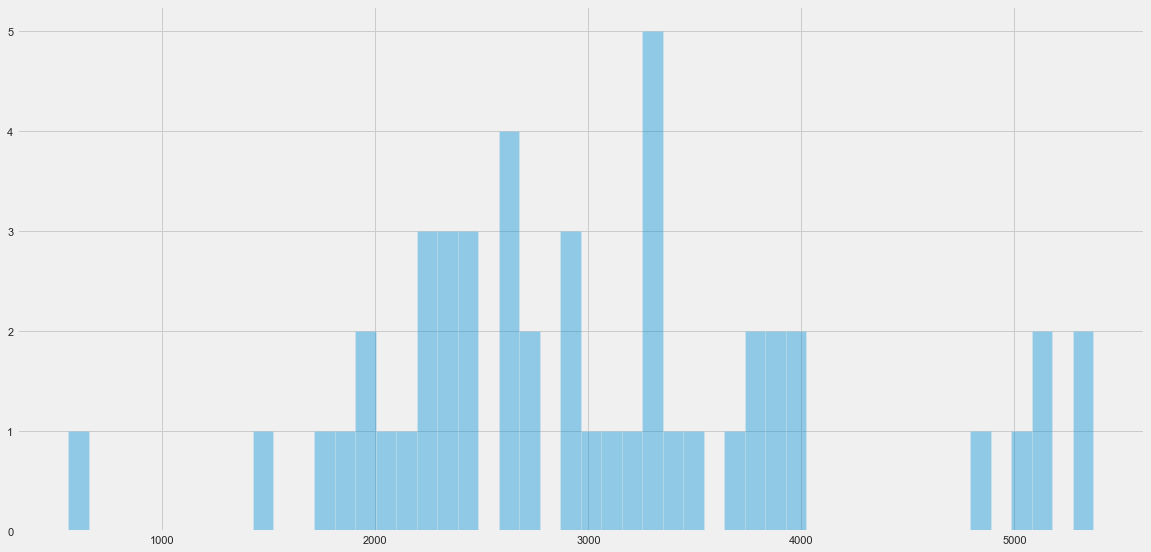

In [159]:
sns.distplot(list(presconf_script_keyword_df['word_count']), bins=50, kde=False)

In [160]:
# Drop text during the process to reduce the output size
presconf_script_chair_day_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Meeting Script DataFrame

In [161]:
# Sample
print(meeting_script_df['contents'][2])

CHAIRMAN VOLCKER.  The  meeting can  come  to  order,  gentlemenand  lady.  We  have  a  lot  of  business  to  dispose  of  at  the  start  and Iwill  try  to  find my agenda,  if  you will  excuse me a moment.  We  havethe  election  of  officers.  First  of  all,  we  have  the  election  of  theChairman--I  keep getting  reminded  that  this  position  is  not  statutory--and we need a nomination.

[SECTION]

MR. SCHULTZ.  Mr. Chairman, after  great  soul-searching untillate  last  night, and  contrary  to  the exhortations  of  many peoplearound this  table,  I have decided  to  nominate  Paul  Volcker as  Chairmanof  the  FOMC!

[SECTION]

CHAIRMAN VOLCKER.  Do we  have  a  second?

[SECTION]

MR. PARTEE.  Second.  You  saved him, Fred!

[SECTION]

MR. SCHULTZ.  Pressure will  do  it  every  time!

[SECTION]

CHAIRMAN  VOLCKER.  Is  there  an  objection?  I shouldn't put  itthat  way!Chairman.

[SECTION]

MR. TIMLEN.  I move  that  the  nominations be  closed.

[SECTION]

CHAIRMA

In [162]:
# Reorganize the dataframe
proc_meeting_script_df = reorganize_df(meeting_script_df, 'meeting_script')


No rate decision found:  23
Shape of the dataframe:  (282, 13)


In [163]:
# Check the returned dataframe
proc_meeting_script_df

type       date                    title       speaker  \
0    meeting_script 1980-01-09  FOMC Meeting Transcript         other   
1    meeting_script 1980-02-05  FOMC Meeting Transcript         other   
2    meeting_script 1980-03-18  FOMC Meeting Transcript         other   
3    meeting_script 1980-04-22  FOMC Meeting Transcript         other   
4    meeting_script 1980-05-20  FOMC Meeting Transcript         other   
..              ...        ...                      ...           ...   
277  meeting_script 2014-06-18  FOMC Meeting Transcript  Janet Yellen   
278  meeting_script 2014-07-30  FOMC Meeting Transcript  Janet Yellen   
279  meeting_script 2014-09-17  FOMC Meeting Transcript  Janet Yellen   
280  meeting_script 2014-10-29  FOMC Meeting Transcript  Janet Yellen   
281  meeting_script 2014-12-17  FOMC Meeting Transcript  Janet Yellen   

     word_count  decision  rate next_meeting  next_decision  next_rate  \
0         42076      <NA>   NaN          NaT           <NA>        NaN   
1         37053      <NA>   NaN          NaT           <NA>        NaN   
2         22394      <NA>   NaN          NaT           <NA>        NaN   
3         19777      <NA>   NaN          NaT           <NA>        NaN   
4         22711      <NA>   NaN          NaT           <NA>        NaN   
..          ...       ...   ...          ...            ...        ...   
277       84860         0   0.0   2014-07-30              0        0.0   
278       86445         0   0.0   2014-09-17              0        0.0   
279       62270         0   0.0   2014-10-29              1        0.0   
280       70890         1   0.0   2014-12-17              0        0.0   
281       57137         0   0.0   2017-02-01              0        0.5   

                                                                                                                                                                                                        text  \
0    MR. STERNLIGHT.  [Statement--see  Appendix.][SECTION]CHAIRMAN VOLCKER.  [That  was  the change  in  System holdings ofsecurities]  since when?[SECTION]MR. STERNLIGHT.  That  was  for  all  of  '79...   
1    CHAIRMAN VOLCKER.  I will  call  the non-meeting  to  order.  Weare not  in  a meeting at  this point  anyway;  we may be  in  a meetinglater.  I would just  remind all of  you that  I sent  out  ...   
2    CHAIRMAN VOLCKER.  The  meeting can  come  to  order,  gentlemenand  lady.  We  have  a  lot  of  business  to  dispose  of  at  the  start  and Iwill  try  to  find my agenda,  if  you will  excu...   
3    CHAIRMAN VOLCKER. Can we  come  to  order,  ladies andgentlemen?  I am  delighted  to  say that  our  Vice  Chairman, Mr.  Solomon,who was  duly elected  in  absentia  last  time,  is  with us  to...   
4    CHAIRMAN VOLCKER.  Let  us proceed, ladies  and  gentlemen.  Weneed to  approve  the  minutes.[SECTION]MR.  SCHULTZ.  So  moved.[SECTION]CHAIRMAN VOLCKER.  Do  we have  a  second?[SECTION]MS.  TEE...   
..                                                                                                                                                                                                       ...   
277  CHAIR YELLEN.  I’d like to begin by welcoming three people to the table today:  Stan   Fischer, Lael Brainard, and Loretta Mester.  This is the first FOMC meeting for both Stan and     Lael, but b...   
278  CHAIR YELLEN.  Good morning, everybody.  I would like to begin today’s meeting by  giving the floor to President Fisher, who asked if he could take a minute to address the group. [SECTION]MR. FISH...   
279  CHAIR YELLEN.  Good morning, everybody. Our first two items this morning will be conducted in a joint meeting between the FOMC and the Board.  I need a motion to close the Board meeting. [SECTION]...   
280  CHAIR YELLEN.  I’d like to call this meeting to order.  Before turning to our agenda, I’d like to say a few words about our communications with the public.  Many of

In [164]:
# Check which row does not have rate
proc_meeting_script_df.loc[proc_meeting_script_df['rate'].isnull()]

type       date                    title speaker  word_count  \
0   meeting_script 1980-01-09  FOMC Meeting Transcript   other       42076   
1   meeting_script 1980-02-05  FOMC Meeting Transcript   other       37053   
2   meeting_script 1980-03-18  FOMC Meeting Transcript   other       22394   
3   meeting_script 1980-04-22  FOMC Meeting Transcript   other       19777   
4   meeting_script 1980-05-20  FOMC Meeting Transcript   other       22711   
..             ...        ...                      ...     ...         ...   
18  meeting_script 1982-02-02  FOMC Meeting Transcript   other       51534   
19  meeting_script 1982-03-30  FOMC Meeting Transcript   other       30513   
20  meeting_script 1982-05-18  FOMC Meeting Transcript   other       22897   
21  meeting_script 1982-07-01  FOMC Meeting Transcript   other       46755   
22  meeting_script 1982-08-24  FOMC Meeting Transcript   other       18810   

    decision  rate next_meeting  next_decision  next_rate  \
0       <NA>   NaN          NaT           <NA>        NaN   
1       <NA>   NaN          NaT           <NA>        NaN   
2       <NA>   NaN          NaT           <NA>        NaN   
3       <NA>   NaN          NaT           <NA>        NaN   
4       <NA>   NaN          NaT           <NA>        NaN   
..       ...   ...          ...            ...        ...   
18      <NA>   NaN          NaT           <NA>        NaN   
19      <NA>   NaN          NaT           <NA>        NaN   
20      <NA>   NaN          NaT           <NA>        NaN   
21      <NA>   NaN          NaT           <NA>        NaN   
22      <NA>   NaN          NaT           <NA>        NaN   

                                                                                                                                                                                                       text  \
0   MR. STERNLIGHT.  [Statement--see  Appendix.][SECTION]CHAIRMAN VOLCKER.  [That  was  the change  in  System holdings ofsecurities]  since when?[SECTION]MR. STERNLIGHT.  That  was  for  all  of  '79...   
1   CHAIRMAN VOLCKER.  I will  call  the non-meeting  to  order.  Weare not  in  a meeting at  this point  anyway;  we may be  in  a meetinglater.  I would just  remind all of  you that  I sent  out  ...   
2   CHAIRMAN VOLCKER.  The  meeting can  come  to  order,  gentlemenand  lady.  We  have  a  lot  of  business  to  dispose  of  at  the  start  and Iwill  try  to  find my agenda,  if  you will  excu...   
3   CHAIRMAN VOLCKER. Can we  come  to  order,  ladies andgentlemen?  I am  delighted  to  say that  our  Vice  Chairman, Mr.  Solomon,who was  duly elected  in  absentia  last  time,  is  with us  to...   
4   CHAIRMAN VOLCKER.  Let  us proceed, ladies  and  gentlemen.  Weneed to  approve  the  minutes.[SECTION]MR.  SCHULTZ.  So  moved.[SECTION]CHAIRMAN VOLCKER.  Do  we have  a  second?[SECTION]MS.  TEE...   
..                                                                                                                                                                                                      ...   
18  MESSRS.  KICHLINE,  ZEISEL,  TRUMAN  and  PRELL.  [Statements  andrelated  charts--see Appendix.][SECTION]CHAIRMAN  VOLCKER.  Do  we  have  any  comments  or  questions  onhow  these  people  see ...   
19  CHAIRMAN  VOLCKER.  We  have  some  items  to  take  care  of  at  thebeginning  of  this  meeting.  First,  the  election  of  officers.  We  needto  nominate  a Chairman  and  a Vice  Chairman i...   
20  CHAIRMAN VOLCKER.  I want  to  start  off  with  a couple  ofspecial  items.  The  first  item  is  welcoming  Mrs.  Horn  to  our  littlegroup.  This  is  going to  be  a slightly  abnormal  meet...   
21  CHAIRMAN VOLCKER.  We  can  call  the meeting  to  order  and  seekapproval  of  the  minutes,  if  someone  wants  to  propose  that.[SECTION]MR.  MARTIN.  So  moved.[SECTION]SPEAKER(?).  Second....   
22  CHAIRMAN VOLCKER.  Would  someone  like  to  propose  approval 

(282, 13)


/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

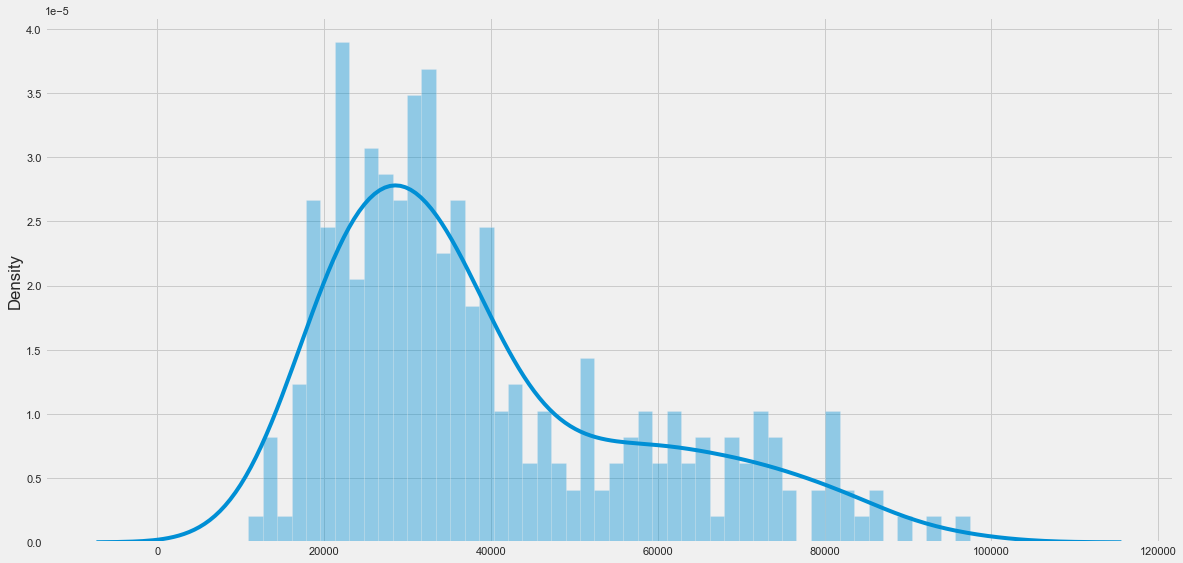

In [165]:
print(proc_meeting_script_df.shape)
sns.distplot(proc_meeting_script_df["word_count"].values, bins=50)

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [166]:
script_data_list = []

for i, row in tqdm(proc_meeting_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_meeting_script_df.columns

meeting_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
meeting_script_speaker_df

0it [00:00, ?it/s]

not matched:  SPEAKER(?).  If  it  wasn't a coincidence,  it's  wonderful.
1980-01-09 00:00:00

not matched:  [CHAIRMAN VOLCKER].  If  it  was  far off,  the staff would sayit  was a coincidence!
1980-01-09 00:00:00

not matched:  [CHAIRMAN VOLCKER.  Mr. Willes.]
1980-01-09 00:00:00

not matched:  SPEAKER(?).  Yes,  I'd do  that  too, but we  still  don't knowwhat  the  limits  are.  I don't  think we know the magnitude  of  theproblems  yet  and at what point  the problems become  a policy decisionrather  than a technical  adjustment.1/8-9/80-17-
1980-01-09 00:00:00

not matched:  MR. KICHLINE(?).  Well,  that's part  of  it,  but  it's not  amajor cranking up  of  the  tandem plan.  As you know, the budgetaryimpact  there  is  quite variable;  it  depends  on when the  governmentsells  those mortgages.  It's  an  interest  [subsidy]  that  ultimatelyshows  up  in  the  federal  expenditures.  On the  authorizations,  that's  adifficult  question because we  have built  in  a signifi

type       date                    title  \
0       meeting_script 1980-01-09  FOMC Meeting Transcript   
1       meeting_script 1980-01-09  FOMC Meeting Transcript   
2       meeting_script 1980-01-09  FOMC Meeting Transcript   
3       meeting_script 1980-01-09  FOMC Meeting Transcript   
4       meeting_script 1980-01-09  FOMC Meeting Transcript   
...                ...        ...                      ...   
109606  meeting_script 2014-12-17  FOMC Meeting Transcript   
109607  meeting_script 2014-12-17  FOMC Meeting Transcript   
109608  meeting_script 2014-12-17  FOMC Meeting Transcript   
109609  meeting_script 2014-12-17  FOMC Meeting Transcript   
109610  meeting_script 2014-12-17  FOMC Meeting Transcript   

                     speaker  word_count decision  rate next_meeting  \
0             MR. STERNLIGHT           3     <NA>   NaN          NaT   
1           CHAIRMAN VOLCKER          10     <NA>   NaN          NaT   
2             MR. STERNLIGHT           5     <NA>   NaN          NaT   
3           CHAIRMAN VOLCKER          25     <NA>   NaN          NaT   
4                MR. AXILROD        1206     <NA>   NaN          NaT   
...                      ...         ...      ...   ...          ...   
109606  VICE CHAIRMAN DUDLEY        1396        0   0.0   2017-02-01   
109607          CHAIR YELLEN          84        0   0.0   2017-02-01   
109608            MR. LUECKE          58        0   0.0   2017-02-01   
109609          CHAIR YELLEN          85        0   0.0   2017-02-01   
109610           MR. FISCHER           4        0   0.0   2017-02-01   

       next_decision  next_rate  \
0               <NA>        NaN   
1               <NA>        NaN   
2               <NA>        NaN   
3               <NA>        NaN   
4               <NA>        NaN   
...              ...        ...   
109606             0        0.5   
109607             0        0.5   
109608             0        0.5   
109609             0        0.5   
109610             0        0.5   

                                                                                                                                                                                                           text  \
0                                                                                                                                                                                   [Statement--see  Appendix.]   
1                                                                                                                                        [That  was  the change  in  System holdings ofsecurities]  since when?   
2                                                                                                                                                                                 That  was  for  all  of  '79.   
3                                                             Steve,  if you want  to  add  something  thatbears upon  the  nature  of  the  operations,  this  is  probably as  good atime as  any to  do  it.   
4        Mr. Chairman, we  have  some  tables we  could passout,  which are  somewhat  similar  to  the  ones  that  we made  available  tothe  Committee  at  the  last meeting and which might  be helpful...   
...                                                                                                                                                                                                         ...   
109606   No worries.  It happened one time under Chairman Bernanke’s watch, too.  So you can do it once. [Laughter.]  I support alternative B, and I am “patient” language.  I think “at least the next coup...   
109607   Thank you.  Okay.  I think the main open issue in the statement is the bracketed word “somewhat” in paragraph 1, and I heard one, two, three, four, five, six—eight people propose removing it.  I’...   
109608   This vote, as Chair Yellen indicated, will be on alternative B, depicted on pag

Some are not matching the defined patterns but those unmatched ones do not look importnant. Thus ignore them here.

In [167]:
# Filter by word count having 20 or more.
print("Before: ", meeting_script_speaker_df.shape)
meeting_script_speaker_df = meeting_script_speaker_df.loc[meeting_script_speaker_df['word_count'] >= 20]
print("After: ", meeting_script_speaker_df.shape)

Before:  (109611, 13)
After:  (51363, 13)


/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

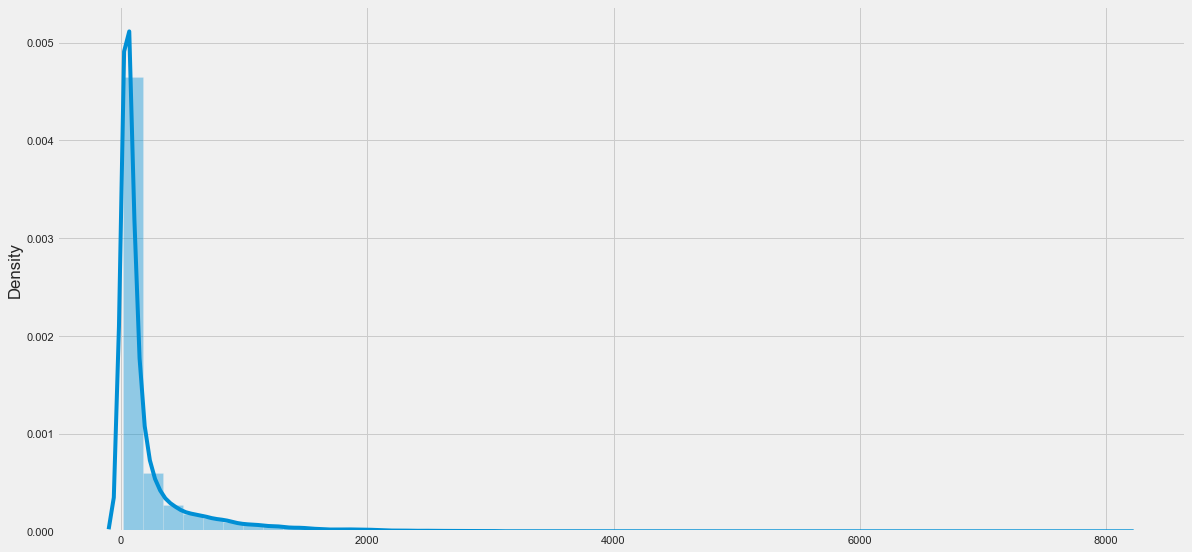

In [168]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

In [169]:
# Combine scripts for the same day.
meeting_script_speaker_df = meeting_script_speaker_df.groupby(['type', 'date', 'title', 'speaker', 'decision', 'rate', 'next_meeting', 'next_decision', 'next_rate'])['text'].apply('[SECTION]'.join).reset_index()
meeting_script_speaker_df['text_sections'] = meeting_script_speaker_df['text'].map(lambda x: x.split("[SECTION]"))
meeting_script_speaker_df['text'] = meeting_script_speaker_df['text'].map(lambda x: x.replace("[SECTION]", ""))
meeting_script_speaker_df['word_count'] = meeting_script_speaker_df['text'].map(get_word_count)
meeting_script_speaker_df


type       date                    title  \
0     meeting_script 1982-10-05  FOMC Meeting Transcript   
1     meeting_script 1982-10-05  FOMC Meeting Transcript   
2     meeting_script 1982-10-05  FOMC Meeting Transcript   
3     meeting_script 1982-10-05  FOMC Meeting Transcript   
4     meeting_script 1982-10-05  FOMC Meeting Transcript   
...              ...        ...                      ...   
8648  meeting_script 2014-12-17  FOMC Meeting Transcript   
8649  meeting_script 2014-12-17  FOMC Meeting Transcript   
8650  meeting_script 2014-12-17  FOMC Meeting Transcript   
8651  meeting_script 2014-12-17  FOMC Meeting Transcript   
8652  meeting_script 2014-12-17  FOMC Meeting Transcript   

                                             speaker  decision  rate  \
0                                  CHAIRMAN  VOLCKER        -1   9.5   
1     CHAIRMAN  VOLCKER.  It  was  a  group  of  ABA        -1   9.5   
2                                   CHAIRMAN VOLCKER        -1   9.5   
3                                       MR.  AXILROD        -1   9.5   
4                                        MR.  BALLES        -1   9.5   
...                                              ...       ...   ...   
8648                                      MS. GEORGE         0   0.0   
8649                                        MS. KLEE         0   0.0   
8650                                       MS. LOGAN         0   0.0   
8651                                      MS. MESTER         0   0.0   
8652                            VICE CHAIRMAN DUDLEY         0   0.0   

     next_meeting  next_decision  next_rate  \
0      1982-11-16             -1        9.0   
1      1982-11-16             -1        9.0   
2      1982-11-16             -1        9.0   
3      1982-11-16             -1        9.0   
4      1982-11-16             -1        9.0   
...           ...            ...        ...   
8648   2017-02-01              0        0.5   
8649   2017-02-01              0        0.5   
8650   2017-02-01              0        0.5   
8651   2017-02-01              0        0.5   
8652   2017-02-01              0        0.5   

                                                                                                                                                                                                         text  \
0      I  thought  it  had  been  level  for  a  longwhile but  it  may  be  that  it  got  back  to  where  it  was  a  year  ago.  Itsurprised  me  that  they  were  up  that  much  in  a  year. Well,...   
1     bankers,  but  that'sincidental.  It  is  going  on.  That  is  why  all  these  South  Americancountries  together  suddenly  can't  find  financing  or  financing  inanywhere  near  the  volume ...   
2      Well,  I want  to  come  back to  some  of  thesequestions  later.  I think  it's  better  to  take  them up  later  in  thecontext  of  the  whole  policy  problem.  But  immediately,  we  inter...   
3      If  there  were  not  a specification  for  M1  andthere were  for  M2  or  M3,  we  would  draw  them  on  the  basis  of  the  M2  orM3  specifications  and  we  would  draw an  M1  path,  unle...   
4      Well,  coming  at  this  confidence  factor  from  alittle  different  direction,  since  as  we  all  know  both  consumerconfidence  and  business  confidence  do  play  a key  part  in  what  ...   
...                                                                                                                                                                                                       ...   
8648   Thank you, Madam Chair.  The Tenth District economy has continued to expand at a relatively steady pace, with the exception of energy and agricultural production.  Most of our industry contacts n...   
8649   Thank you.  I will be referring to the packet labeled “Material for Briefing on the Summary of Economic Projections.” Exhibit 1 shows the broad trajectories of your forecasts under your 

/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

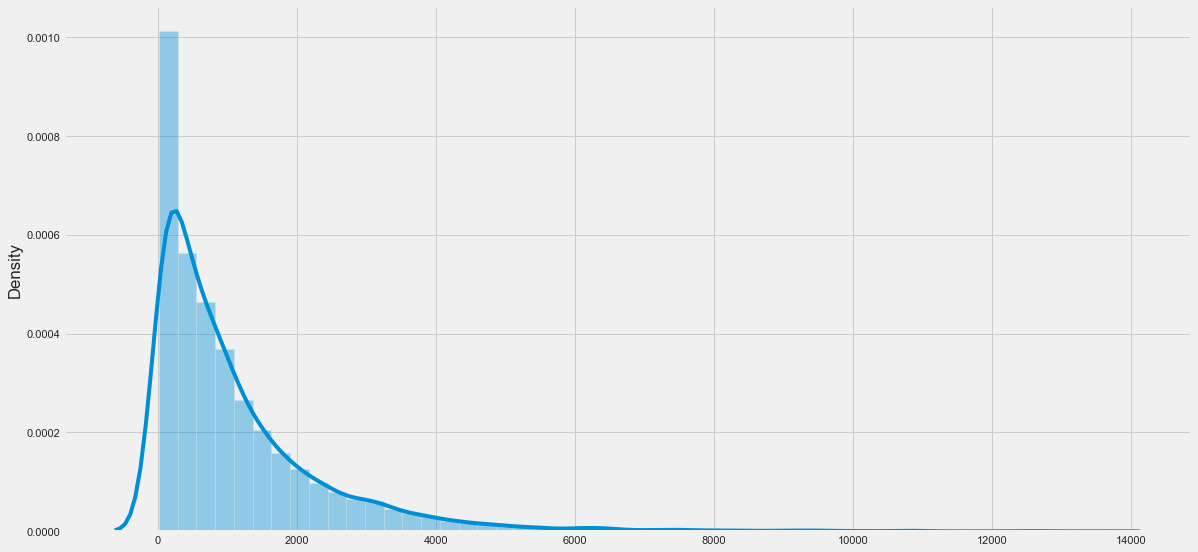

In [170]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [171]:
meeting_script_split_df = get_split_df(meeting_script_speaker_df)
print(meeting_script_split_df.shape)
meeting_script_split_df

  0%|          | 0/8653 [00:00<?, ?it/s]

(66797, 12)


type       date                    title  \
0      meeting_script 1982-10-05  FOMC Meeting Transcript   
1      meeting_script 1982-10-05  FOMC Meeting Transcript   
2      meeting_script 1982-10-05  FOMC Meeting Transcript   
3      meeting_script 1982-10-05  FOMC Meeting Transcript   
4      meeting_script 1982-10-05  FOMC Meeting Transcript   
...               ...        ...                      ...   
66792  meeting_script 2014-12-17  FOMC Meeting Transcript   
66793  meeting_script 2014-12-17  FOMC Meeting Transcript   
66794  meeting_script 2014-12-17  FOMC Meeting Transcript   
66795  meeting_script 2014-12-17  FOMC Meeting Transcript   
66796  meeting_script 2014-12-17  FOMC Meeting Transcript   

                    speaker  decision  rate next_meeting  next_decision  \
0         CHAIRMAN  VOLCKER        -1   9.5   1982-11-16             -1   
1         CHAIRMAN  VOLCKER        -1   9.5   1982-11-16             -1   
2         CHAIRMAN  VOLCKER        -1   9.5   1982-11-16             -1   
3         CHAIRMAN  VOLCKER        -1   9.5   1982-11-16             -1   
4         CHAIRMAN  VOLCKER        -1   9.5   1982-11-16             -1   
...                     ...       ...   ...          ...            ...   
66792  VICE CHAIRMAN DUDLEY         0   0.0   2017-02-01              0   
66793  VICE CHAIRMAN DUDLEY         0   0.0   2017-02-01              0   
66794  VICE CHAIRMAN DUDLEY         0   0.0   2017-02-01              0   
66795  VICE CHAIRMAN DUDLEY         0   0.0   2017-02-01              0   
66796  VICE CHAIRMAN DUDLEY         0   0.0   2017-02-01              0   

       next_rate  \
0            9.0   
1            9.0   
2            9.0   
3            9.0   
4            9.0   
...          ...   
66792        0.5   
66793        0.5   
66794        0.5   
66795        0.5   
66796        0.5   

                                                                                                                                                                                                          text  \
0      I thought it had been level for a longwhile but it may be that it got back to where it was a year ago Itsurprised me that they were up that much in a year Well yes and no is the answer I think Obv...   
1      to give us an answer in a month before we the new instrument I think is totally unwarranted just by thenature of the problem that we face We can now have a general discussion Atsome point I will g...   
2      all Idetected no leaks after the last meeting We are discussing obviouslyhighly sensitive subjects in this particular meeting and I can timpress that too strongly upon you I m talking about some o...   
3      at some point I think it's possible that we will have tomake a decision within the confines of this room as to whether wecontribute to them too simply in order to get the money big enough And that...   
4      with banks orsomething like that When you re dealing with that many banks aroundthe world not just all over the United States but all over the world and I mean banks you ve never heard the name of...   
...                                                                                                                                                                                                        ...   
66792  of monetary policy because all that the first hikes are going to do is to be a very slight removal of a very high level of accommodation So I think we need to monetary policy will still be very su...   
66793  which has been the situation since we began to end the asset purchase program then we need to move more quickly And I think we need to get market participants sensitized to this that financial mar...   
66794  that we try to have liftoff occur with as little drama as possible There s already going to be plenty of drama in lifting off with a new set of tools and in a regime shift of raising short term ra...   
66795  June conditional on the data coming

### Filter out by keywords

In [172]:
# Keep sections having keywords and long enough
meeting_script_keyword_df = remove_short_nokeyword(meeting_script_speaker_df)
meeting_script_keyword_df.reset_index(drop=True, inplace=True)
print(meeting_script_keyword_df.shape)
meeting_script_keyword_df

  0%|          | 0/8653 [00:00<?, ?it/s]

  0%|          | 0/8653 [00:00<?, ?it/s]

(5136, 12)


type       date                    title  \
0     meeting_script 1982-10-05  FOMC Meeting Transcript   
1     meeting_script 1982-10-05  FOMC Meeting Transcript   
2     meeting_script 1982-10-05  FOMC Meeting Transcript   
3     meeting_script 1982-10-05  FOMC Meeting Transcript   
4     meeting_script 1982-10-05  FOMC Meeting Transcript   
...              ...        ...                      ...   
5131  meeting_script 2014-12-17  FOMC Meeting Transcript   
5132  meeting_script 2014-12-17  FOMC Meeting Transcript   
5133  meeting_script 2014-12-17  FOMC Meeting Transcript   
5134  meeting_script 2014-12-17  FOMC Meeting Transcript   
5135  meeting_script 2014-12-17  FOMC Meeting Transcript   

                                             speaker  decision  rate  \
0                                  CHAIRMAN  VOLCKER        -1   9.5   
1     CHAIRMAN  VOLCKER.  It  was  a  group  of  ABA        -1   9.5   
2                                   CHAIRMAN VOLCKER        -1   9.5   
3                                         MR.  BLACK        -1   9.5   
4                                        MR.  BOEHNE        -1   9.5   
...                                              ...       ...   ...   
5131                                      MS. GEORGE         0   0.0   
5132                                        MS. KLEE         0   0.0   
5133                                       MS. LOGAN         0   0.0   
5134                                      MS. MESTER         0   0.0   
5135                            VICE CHAIRMAN DUDLEY         0   0.0   

     next_meeting  next_decision  next_rate  \
0      1982-11-16             -1        9.0   
1      1982-11-16             -1        9.0   
2      1982-11-16             -1        9.0   
3      1982-11-16             -1        9.0   
4      1982-11-16             -1        9.0   
...           ...            ...        ...   
5131   2017-02-01              0        0.5   
5132   2017-02-01              0        0.5   
5133   2017-02-01              0        0.5   
5134   2017-02-01              0        0.5   
5135   2017-02-01              0        0.5   

                                                                                                                                                                                                         text  \
0     Yes,  I  am  totally  dissatisfied.  What wedid  last  time  was  unacceptable  to  me.  I  just  want  to  make that  plain.I  think  we  made  a  mistake  last  time.  I  think we  would  not  h...   
1     bankers,  but  that'sincidental.  It  is  going  on.  That  is  why  all  these  South  Americancountries  together  suddenly  can't  find  financing  or  financing  inanywhere  near  the  volume ...   
2     I think  there  will  be  a tendency  amongsome  to  pay a money  market  funds  rate  plus;  the  question  is  whetherthe  market  gets  driven  there.  I'm  just  guessing.  Among  other  thing...   
3     Mr.  Chairman,  we  are  all  in  agreement  on  only  onething,  I  think:  that  we  would  like  to  see  interest  rates  come  down.I  would  like  to  raise  the  question  of whether  it  m...   
4     Well,  I think  how  one  comes  out  on  this  dependson  whether  one wants  to  take  the  risks  on  rules  or  on  the  side  ofdiscretion.  It  does  seem  to  me  that  we  have  pushed  th...   
...                                                                                                                                                                                                       ...   
5131  Thank you, Madam Chair.  The Tenth District economy has continued to expand at a relatively steady pace, with the exception of energy and agricultural production.  Most of our industry contacts no...   
5132  Thank you.  I will be referring to the packet labeled “Material for Briefing on the Summary of Economic Projections.” Exhibit 1 shows the broad trajectories of your forecasts under your i

In [173]:
# Drop text during the process to reduce the output size
meeting_script_speaker_df.drop(columns=['text_sections'], inplace=True)
meeting_script_split_df.drop(columns=['text_sections'], inplace=True)
meeting_script_keyword_df.drop(columns=['text_sections'], inplace=True)

## Speech DataFrame

In [174]:
# Reorganize the dataframe
proc_speech_df = reorganize_df(speech_df, 'speech')

No rate decision found:  1565
Shape of the dataframe:  (1565, 13)


In [175]:
# Check the returned dataframe
# Note that rate and decision are not applicable because speech is not at FOMC meeting
proc_speech_df

type       date  \
0     speech 1996-06-13   
1     speech 1996-06-18   
2     speech 1996-09-08   
3     speech 1996-09-19   
4     speech 1996-10-02   
...      ...        ...   
1560  speech 2021-11-29   
1561  speech 2021-11-29   
1562  speech 2021-11-30   
1563  speech 2021-12-02   
1564  speech 2021-12-17   

                                                                                                              title  \
0                                                                               Bank supervision in a world economy   
1                                                                      Developments in electronic money and banking   
2                                                                           Monetary policy objectives and strategy   
3                                                                         Regulation and electronic payment systems   
4                                                                                    Small business is big business   
...                                                                                                             ...   
1560                                                                                                Opening Remarks   
1561  Engagement, Research and Policy: Integrating Indigenous Voices into Economic Inclusion at the Federal Reserve   
1562                                                 Federal Reserve Independence: Foundations and Responsibilities   
1563                                      Between the Hither and the Farther Shore: Thoughts on Unfinished Business   
1564                         A Hopeless and Imperative Endeavor: Lessons from the Pandemic for Economic Forecasters   

                             speaker  word_count  decision  rate next_meeting  \
0            Chairman Alan Greenspan        3211      <NA>  None   1996-07-03   
1     Governor Edward W. Kelley, Jr.        2694      <NA>  None   1996-07-03   
2         Governor Laurence H. Meyer        2902      <NA>  None   1996-09-24   
3            Chairman Alan Greenspan        1988      <NA>  None   1996-09-24   
4       Governor Lawrence B. Lindsey        2180      <NA>  None   1996-11-13   
...                              ...         ...       ...   ...          ...   
1560          Chair Jerome H. Powell         656      <NA>  None   2021-12-15   
1561     Governor Michelle W. Bowman        1540      <NA>  None   2021-12-15   
1562   Vice Chair Richard H. Clarida        2953      <NA>  None   2021-12-15   
1563      Governor Randal K. Quarles        6228      <NA>  None   2021-12-15   
1564  Governor Christopher J. Waller        3599      <NA>  None          NaT   

      next_decision  next_rate  \
0                 0       5.25   
1                 0       5.25   
2                 0       5.25   
3                 0       5.25   
4                 0       5.25   
...             ...        ...   
1560              0       0.00   
1561              0       0.00   
1562              0       0.00   
1563              0       0.00   
1564           <NA>        NaN   

                                                                                                                                                                                                         text  \
0     Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996[SECTION][SECTION]I am honored to present...   
1     Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996[SECTION][SECTION]It is a pleasure to be here th...   
2     Monetary Policy Objectives and Strategy[SECTION]I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment.  But I also want ...   
3     Remarks by Chairman Alan Green

(1565, 13)


/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

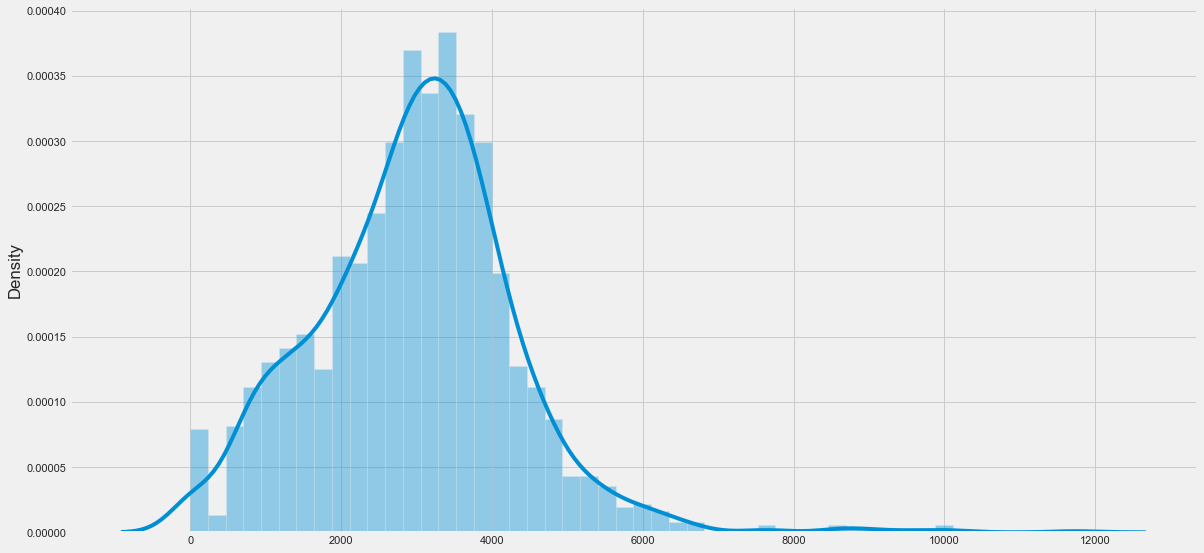

In [176]:
print(proc_speech_df.shape)
sns.distplot(proc_speech_df["word_count"].values, bins=50)

In [177]:
# Check records where speaker is null
proc_speech_df['speaker'].isnull().sum()

0

In [178]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_speech_df = remove_short_section(proc_speech_df, min_words=50)
proc_speech_df


  0%|          | 0/1565 [00:00<?, ?it/s]

type       date  \
0     speech 1996-06-13   
1     speech 1996-06-18   
2     speech 1996-09-08   
3     speech 1996-09-19   
4     speech 1996-10-02   
...      ...        ...   
1560  speech 2021-11-29   
1561  speech 2021-11-29   
1562  speech 2021-11-30   
1563  speech 2021-12-02   
1564  speech 2021-12-17   

                                                                                                              title  \
0                                                                               Bank supervision in a world economy   
1                                                                      Developments in electronic money and banking   
2                                                                           Monetary policy objectives and strategy   
3                                                                         Regulation and electronic payment systems   
4                                                                                    Small business is big business   
...                                                                                                             ...   
1560                                                                                                Opening Remarks   
1561  Engagement, Research and Policy: Integrating Indigenous Voices into Economic Inclusion at the Federal Reserve   
1562                                                 Federal Reserve Independence: Foundations and Responsibilities   
1563                                      Between the Hither and the Farther Shore: Thoughts on Unfinished Business   
1564                         A Hopeless and Imperative Endeavor: Lessons from the Pandemic for Economic Forecasters   

                             speaker  word_count  decision  rate next_meeting  \
0            Chairman Alan Greenspan        3095      <NA>  None   1996-07-03   
1     Governor Edward W. Kelley, Jr.        2659      <NA>  None   1996-07-03   
2         Governor Laurence H. Meyer        2729      <NA>  None   1996-09-24   
3            Chairman Alan Greenspan        1586      <NA>  None   1996-09-24   
4       Governor Lawrence B. Lindsey        2002      <NA>  None   1996-11-13   
...                              ...         ...       ...   ...          ...   
1560          Chair Jerome H. Powell         346      <NA>  None   2021-12-15   
1561     Governor Michelle W. Bowman        1308      <NA>  None   2021-12-15   
1562   Vice Chair Richard H. Clarida        2778      <NA>  None   2021-12-15   
1563      Governor Randal K. Quarles        5947      <NA>  None   2021-12-15   
1564  Governor Christopher J. Waller        3361      <NA>  None          NaT   

      next_decision  next_rate  \
0                 0       5.25   
1                 0       5.25   
2                 0       5.25   
3                 0       5.25   
4                 0       5.25   
...             ...        ...   
1560              0       0.00   
1561              0       0.00   
1562              0       0.00   
1563              0       0.00   
1564           <NA>        NaN   

                                                                                                                                                                                                         text  \
0     I am honored to present the William Taylor Memorial     Lecture to such a distinguished group of senior bank supervisors     from around the world.  I am especially delighted to have with us     B...   
1     It is a pleasure to be here this afternoon to provide     the Federal Reserve's perspective on recent developments in the     field of electronic money and banking.  To begin, let me remind     yo...   
2     I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment.  But I also want to emphasize the importance of setting monetary ...   
3     You have heard many points of 

In [179]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_speech_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_speech_df.columns
speech_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)

print(speech_chair_df.shape)
speech_chair_df

(439, 13)


type       date  \
0    speech 1996-06-13   
1    speech 1996-09-19   
2    speech 1996-10-05   
3    speech 1996-10-07   
4    speech 1996-10-16   
..      ...        ...   
434  speech 2021-08-27   
435  speech 2021-09-24   
436  speech 2021-11-08   
437  speech 2021-11-09   
438  speech 2021-11-29   

                                                                title  \
0                                 Bank supervision in a world economy   
1                           Regulation and electronic payment systems   
2                              Bank supervision, regulation, and risk   
3    U.S. Treasury securities market: Lessons from Alexander Hamilton   
4                             Technological advances and productivity   
..                                                                ...   
434                              Monetary Policy in the Time of COVID   
435                                              Introductory Remarks   
436                                                   Opening Remarks   
437                                                   Opening Remarks   
438                                                   Opening Remarks   

            speaker  word_count decision  rate next_meeting  next_decision  \
0    Alan Greenspan        3095     <NA>  None   1996-07-03              0   
1    Alan Greenspan        1586     <NA>  None   1996-09-24              0   
2    Alan Greenspan        2183     <NA>  None   1996-11-13              0   
3    Alan Greenspan         985     <NA>  None   1996-11-13              0   
4    Alan Greenspan        1615     <NA>  None   1996-11-13              0   
..              ...         ...      ...   ...          ...            ...   
434   Jerome Powell        2405     <NA>  None   2021-09-22              0   
435   Jerome Powell         333     <NA>  None   2021-11-03              0   
436   Jerome Powell         441     <NA>  None   2021-12-15              0   
437   Jerome Powell         874     <NA>  None   2021-12-15              0   
438   Jerome Powell         346     <NA>  None   2021-12-15              0   

     next_rate  \
0         5.25   
1         5.25   
2         5.25   
3         5.25   
4         5.25   
..         ...   
434       0.00   
435       0.00   
436       0.00   
437       0.00   
438       0.00   

                                                                                                                                                                                                        text  \
0    I am honored to present the William Taylor Memorial     Lecture to such a distinguished group of senior bank supervisors     from around the world.  I am especially delighted to have with us     B...   
1    You have heard many points of view today on electronic moneyand banking.  New products are being designed to challenge theuse of currency and checks in millions of routine consumertransactions.  O...   
2    You may well wonder why a regulator is the first speaker at a conference in which amajor theme is maximizing shareholder value.  I hope that by the end of my remarks thismorning it will be clear t...   
3    I thank the members of the Public Securities Association for bestowing upon me this award for distinguished public service.  I am particularly honored by the company that I keep as a winner of thi...   
4    The Conference Board has been an important institution in my life.  It was where I started as an economist.  It was where I came into contact with a business world I had never known before.  The y...   
..                                                                                                                                                                                                       ...   
434  The path of recovery has been a difficult one, and a good place to begin is by thanking those on the front line fighting the pandemic: the essential workers who kept the economy going, those who h...   

### Split contents to max 200 words

In [180]:
speech_split_df = get_split_df(speech_chair_df)
speech_split_df.reset_index(drop=True, inplace=True)
print(speech_split_df.shape)
speech_split_df

  0%|          | 0/439 [00:00<?, ?it/s]

(7146, 13)


type       date                                title         speaker  \
0     speech 1996-06-13  Bank supervision in a world economy  Alan Greenspan   
1     speech 1996-06-13  Bank supervision in a world economy  Alan Greenspan   
2     speech 1996-06-13  Bank supervision in a world economy  Alan Greenspan   
3     speech 1996-06-13  Bank supervision in a world economy  Alan Greenspan   
4     speech 1996-06-13  Bank supervision in a world economy  Alan Greenspan   
...      ...        ...                                  ...             ...   
7141  speech 2021-11-09                      Opening Remarks   Jerome Powell   
7142  speech 2021-11-09                      Opening Remarks   Jerome Powell   
7143  speech 2021-11-09                      Opening Remarks   Jerome Powell   
7144  speech 2021-11-29                      Opening Remarks   Jerome Powell   
7145  speech 2021-11-29                      Opening Remarks   Jerome Powell   

      word_count  decision  rate next_meeting  next_decision  next_rate  \
0            200      <NA>  None   1996-07-03              0       5.25   
1            200      <NA>  None   1996-07-03              0       5.25   
2            200      <NA>  None   1996-07-03              0       5.25   
3            200      <NA>  None   1996-07-03              0       5.25   
4            200      <NA>  None   1996-07-03              0       5.25   
...          ...       ...   ...          ...            ...        ...   
7141         200      <NA>  None   2021-12-15              0       0.00   
7142         200      <NA>  None   2021-12-15              0       0.00   
7143         124      <NA>  None   2021-12-15              0       0.00   
7144         200      <NA>  None   2021-12-15              0       0.00   
7145         196      <NA>  None   2021-12-15              0       0.00   

                                                                                                                                                                                                         text  \
0     I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world I am especially delighted to have with us Bill's wife Sha...   
1     best from himself and from those around him He understood that a safe and sound banking system was essential to a healthy market system and he was committed to maintaining such a system His contri...   
2     reflect the increased efficiency of financial markets worldwide which have helped to bring about expanded international trade and economic growth However by strengthening the interdependencies amo...   
3     relationship we may have a better framework for considering how to supervise and regulate our financial institutions A Leveraged Banking System In addressing these issues it is important to rememb...   
4     of intermediation with the founding of the Riksbank more than years ago as a private institution Of course this same leverage and risk taking also greatly increases the possibility of bank failure...   
...                                                                                                                                                                                                       ...   
7141  than just the headline numbers Diversity and inclusion play a role in policymaking as well As policymakers working on behalf of the entire public we benefit greatly by seeking out and listening to...   
7142  and affords us an opportunity to help influence and shape the evolution of the profession Throughout my career in both the public and the private sectors I have seen that the best and most success...   
7143  as by hosting events to promote career opportunities at the Fed My colleagues and I know that both the opportunities and the challenges are great and that the work is never truly done Whether you ...   
7144  The pace of technological change and innovation ov

### Filter out by keyword

In [181]:
# Keep sections having keywords and long enough
speech_keyword_df = remove_short_nokeyword(speech_chair_df)
speech_keyword_df.reset_index(drop=True, inplace=True)
print(speech_keyword_df.shape)
speech_keyword_df

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

(224, 13)


type       date  \
0    speech 1996-10-05   
1    speech 1996-12-06   
2    speech 1997-01-14   
3    speech 1997-02-21   
4    speech 1997-04-29   
..      ...        ...   
219  speech 2020-08-27   
220  speech 2020-10-06   
221  speech 2021-02-10   
222  speech 2021-05-03   
223  speech 2021-08-27   

                                                            title  \
0                          Bank supervision, regulation, and risk   
1                                                 Social security   
2                              Central banking and global finance   
3                  Government regulation and derivative contracts   
4                                     G-7 economic summit meeting   
..                                                            ...   
219  New Economic Challenges and the Fed's Monetary Policy Review   
220         Recent Economic Developments and the Challenges Ahead   
221                         Getting Back to a Strong Labor Market   
222                                         Community Development   
223                          Monetary Policy in the Time of COVID   

            speaker  word_count decision  rate next_meeting  next_decision  \
0    Alan Greenspan         136     <NA>  None   1996-11-13              0   
1    Alan Greenspan         253     <NA>  None   1996-12-17              0   
2    Alan Greenspan         133     <NA>  None   1997-02-05              0   
3    Alan Greenspan         212     <NA>  None   1997-03-25              1   
4    Alan Greenspan         142     <NA>  None   1997-05-20              0   
..              ...         ...      ...   ...          ...            ...   
219   Jerome Powell        1172     <NA>  None   2020-09-16              0   
220   Jerome Powell         413     <NA>  None   2020-11-05              0   
221   Jerome Powell         433     <NA>  None   2021-03-17              0   
222   Jerome Powell          83     <NA>  None   2021-06-16              0   
223   Jerome Powell         184     <NA>  None   2021-09-22              0   

     next_rate  \
0         5.25   
1         5.25   
2         5.25   
3         5.50   
4         5.50   
..         ...   
219       0.00   
220       0.00   
221       0.00   
222       0.00   
223       0.00   

                                                                                                                                                                                                        text  \
0    While awaiting perfection, it is useful to underline that regulators and banks have acommon interest in using the evolving new technologies to meet their own separateobjectives:  maximizing shareh...   
1    While such evaluations are based on an uncertain future, the benefit per current retiree under existing law, adjusted for inflation, can be forecast with some precision over the next thirty years....   
2    In theory, the allocation of responsibility for risk-bearing between the private sectorand the central bank depends upon an evaluation of the private cost of capital.  In order toattract, or at le...   
3    In the case of the institutional off-exchange derivatives markets, it seems abundantly clear that private market regulation is quite effectively and efficiently achieving what have been identified...   
4    In theory, the allocation of responsibility for risk-bearing between the private sector and the central bank depends upon an evaluation of the private cost of capital.  In order to attract, or at ...   
..                                                                                                                                                                                                       ...   
219  Our evolving understanding of four key economic developments motivated our review. First, assessments of the potential, or longer-run, growth rate of the economy have declined. For example, since ...   
220  The Pre-COVID EconomyAs the coronavirus sp

In [182]:
# Drop text_sections
speech_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Testimony DataFrame

In [183]:
# Reorganize the dataframe
# Note that rate and decision are not applicable because testimony is not at FOMC meeting
proc_testimony_df = reorganize_df(testimony_df, 'testimony')

No rate decision found:  453
Shape of the dataframe:  (453, 13)


In [184]:
# Check the returned dataframe
proc_testimony_df

type       date                                              title  \
0    testimony 1996-06-26                Supervision of bank sales practices   
1    testimony 1996-07-17                               "Prime bank" schemes   
2    testimony 1996-07-18   The Federal Reserve's semiannual monetary report   
3    testimony 1996-07-24                         Trends in consumer lending   
4    testimony 1996-07-26       Recent reports on Federal Reserve operations   
..         ...        ...                                                ...   
448  testimony 2021-07-14  Semiannual Monetary Policy Report to the Congress   
449  testimony 2021-09-28                          Coronavirus and CARES Act   
450  testimony 2021-11-30                          Coronavirus and CARES Act   
451  testimony 2022-01-11                                 Nomination hearing   
452  testimony 2022-01-13                                 Nomination hearing   

                                                                                         speaker  \
0                                                                 Governor Edward W. Kelley, Jr.   
1    Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation   
2                                                                        Chairman Alan Greenspan   
3                                                                       Governor Janet L. Yellen   
4                                                                        Chairman Alan Greenspan   
..                                                                                           ...   
448                                                                       Chair Jerome H. Powell   
449                                                                       Chair Jerome H. Powell   
450                                                                       Chair Jerome H. Powell   
451                                                                       Chair Jerome H. Powell   
452                                                                       Governor Lael Brainard   

     word_count  decision  rate next_meeting  next_decision  next_rate  \
0          2298      <NA>  None   1996-07-03              0       5.25   
1          1227      <NA>  None   1996-08-20              0       5.25   
2          3372      <NA>  None   1996-08-20              0       5.25   
3          2878      <NA>  None   1996-08-20              0       5.25   
4          3764      <NA>  None   1996-08-20              0       5.25   
..          ...       ...   ...          ...            ...        ...   
448        1259      <NA>  None   2021-07-28              0       0.00   
449        1225      <NA>  None   2021-11-03              0       0.00   
450         844      <NA>  None   2021-12-15              0       0.00   
451        1069      <NA>  None          NaT           <NA>        NaN   
452         744      <NA>  None          NaT           <NA>        NaN   

                                                                                                                                                                                                        text  \
0    [SECTION][SECTION][SECTION][SECTION]It is a pleasure to appear before this Subcommittee to discuss     the supervision of bank sales practices on behalf of the Federal     Reserve.  The recent pub...   
1    [SECTION][SECTION][SECTION][SECTION]I am pleased to appear before the Committee on Banking, Housing,     and Urban Affairs to discuss actions that the Federal Reserve has     taken over the past s...   
2    Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996[SECTION]Before I t...   
3    [SECTION][SECTION][SECTION][SECTION]I am pleased to appear before this Subcommittee today to discuss trendsin consumer len

(453, 13)


/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

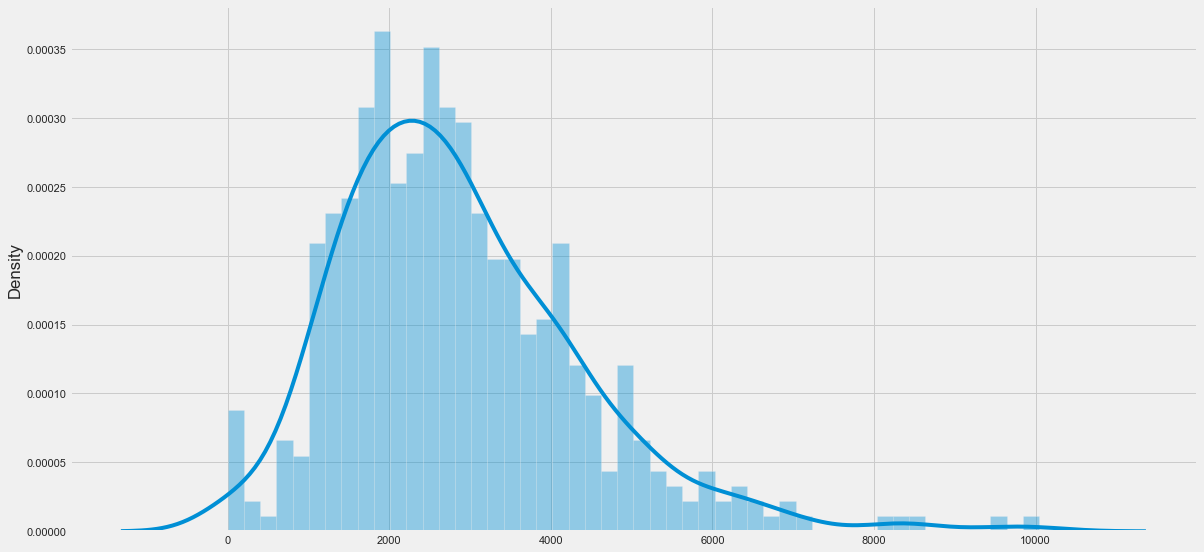

In [185]:
print(proc_testimony_df.shape)
sns.distplot(proc_testimony_df["word_count"].values, bins=50)

In [186]:
# Check records where speaker is null
proc_testimony_df['speaker'].isnull().sum()

0

In [187]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_testimony_df = remove_short_section(proc_testimony_df, min_words=50)
proc_testimony_df

  0%|          | 0/453 [00:00<?, ?it/s]

type       date                                              title  \
0    testimony 1996-06-26                Supervision of bank sales practices   
1    testimony 1996-07-17                               "Prime bank" schemes   
2    testimony 1996-07-18   The Federal Reserve's semiannual monetary report   
3    testimony 1996-07-24                         Trends in consumer lending   
4    testimony 1996-07-26       Recent reports on Federal Reserve operations   
..         ...        ...                                                ...   
448  testimony 2021-07-14  Semiannual Monetary Policy Report to the Congress   
449  testimony 2021-09-28                          Coronavirus and CARES Act   
450  testimony 2021-11-30                          Coronavirus and CARES Act   
451  testimony 2022-01-11                                 Nomination hearing   
452  testimony 2022-01-13                                 Nomination hearing   

                                                                                         speaker  \
0                                                                 Governor Edward W. Kelley, Jr.   
1    Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation   
2                                                                        Chairman Alan Greenspan   
3                                                                       Governor Janet L. Yellen   
4                                                                        Chairman Alan Greenspan   
..                                                                                           ...   
448                                                                       Chair Jerome H. Powell   
449                                                                       Chair Jerome H. Powell   
450                                                                       Chair Jerome H. Powell   
451                                                                       Chair Jerome H. Powell   
452                                                                       Governor Lael Brainard   

     word_count  decision  rate next_meeting  next_decision  next_rate  \
0          2071      <NA>  None   1996-07-03              0       5.25   
1           959      <NA>  None   1996-08-20              0       5.25   
2          2966      <NA>  None   1996-08-20              0       5.25   
3          2601      <NA>  None   1996-08-20              0       5.25   
4          3308      <NA>  None   1996-08-20              0       5.25   
..          ...       ...   ...          ...            ...        ...   
448         991      <NA>  None   2021-07-28              0       0.00   
449         931      <NA>  None   2021-11-03              0       0.00   
450         507      <NA>  None   2021-12-15              0       0.00   
451         654      <NA>  None          NaT           <NA>        NaN   
452         339      <NA>  None          NaT           <NA>        NaN   

                                                                                                                                                                                                        text  \
0    It is a pleasure to appear before this Subcommittee to discuss     the supervision of bank sales practices on behalf of the Federal     Reserve.  The recent publication of various survey results h...   
1    I am pleased to appear before the Committee on Banking, Housing,     and Urban Affairs to discuss actions that the Federal Reserve has     taken over the past several years to address the problem ...   
2    Before I take this opportunity to discuss the performance of the U.S.economy and the conduct of monetary policy, I would first like to thank theChairman and the other members of this Committee for...   
3    I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's

In [188]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_testimony_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_testimony_df.columns
testimony_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
testimony_chair_df

type       date  \
0    testimony 1996-07-18   
1    testimony 1996-07-26   
2    testimony 1997-01-21   
3    testimony 1997-01-30   
4    testimony 1997-02-13   
..         ...        ...   
180  testimony 2021-06-22   
181  testimony 2021-07-14   
182  testimony 2021-09-28   
183  testimony 2021-11-30   
184  testimony 2022-01-11   

                                                              title  \
0                  The Federal Reserve's semiannual monetary report   
1                      Recent reports on Federal Reserve operations   
2                                                  January 21, 1997   
3                                          The comsumer price index   
4                             Modernization of the financial system   
..                                                              ...   
180  The Federal Reserve&#39;s Response to the Coronavirus Pandemic   
181               Semiannual Monetary Policy Report to the Congress   
182                                       Coronavirus and CARES Act   
183                                       Coronavirus and CARES Act   
184                                              Nomination hearing   

            speaker  word_count decision  rate next_meeting next_decision  \
0    Alan Greenspan        2966     <NA>  None   1996-08-20             0   
1    Alan Greenspan        3308     <NA>  None   1996-08-20             0   
2    Alan Greenspan        2854     <NA>  None   1997-02-05             0   
3    Alan Greenspan        2692     <NA>  None   1997-02-05             0   
4    Alan Greenspan        4100     <NA>  None   1997-03-25             1   
..              ...         ...      ...   ...          ...           ...   
180   Jerome Powell        1353     <NA>  None   2021-07-28             0   
181   Jerome Powell         991     <NA>  None   2021-07-28             0   
182   Jerome Powell         931     <NA>  None   2021-11-03             0   
183   Jerome Powell         507     <NA>  None   2021-12-15             0   
184   Jerome Powell         654     <NA>  None          NaT          <NA>   

     next_rate  \
0         5.25   
1         5.25   
2         5.25   
3         5.25   
4         5.50   
..         ...   
180       0.00   
181       0.00   
182       0.00   
183       0.00   
184        NaN   

                                                                                                                                                                                                        text  \
0    Before I take this opportunity to discuss the performance of the U.S.economy and the conduct of monetary policy, I would first like to thank theChairman and the other members of this Committee for...   
1    We are strongly committed to ensuring that the Federal Reserve Systemis managed efficiently and effectively.  It is most important to us at the FederalReserve Board and the Reserve Banks, not only...   
2    Mr. Chairman and members of the Committee, I am pleased to appear here today.  In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress.  ...   
3    Mr. Chairman and members of the Committee, I appreciate the opportunity to appear before you today.  The Committee is faced with a number of complex policy issues that will have an important beari...   
4    Madam Chairwoman, members of the Subcommittee on Financial Institutions and Consumer Credit, it is a pleasure to appear here today to present the views of the Federal Reserve Board on some broad i...   
..                                                                                                                                                                                                       ...   
180  Since we last met, the economy has shown sustained improvement. Widespread vaccinations have joined unprecedented monetary and fiscal policy actions in providing strong support to the recovery. In...   
18

### Split contents to max 200 words

In [189]:
testimony_split_df = get_split_df(testimony_chair_df)
testimony_split_df.reset_index(drop=True, inplace=True)
print(testimony_split_df.shape)
testimony_split_df

  0%|          | 0/185 [00:00<?, ?it/s]

(2893, 13)


type       date                                             title  \
0     testimony 1996-07-18  The Federal Reserve's semiannual monetary report   
1     testimony 1996-07-18  The Federal Reserve's semiannual monetary report   
2     testimony 1996-07-18  The Federal Reserve's semiannual monetary report   
3     testimony 1996-07-18  The Federal Reserve's semiannual monetary report   
4     testimony 1996-07-18  The Federal Reserve's semiannual monetary report   
...         ...        ...                                               ...   
2888  testimony 2022-01-11                                Nomination hearing   
2889  testimony 2022-01-11                                Nomination hearing   
2890  testimony 2022-01-11                                Nomination hearing   
2891  testimony 2022-01-11                                Nomination hearing   
2892  testimony 2022-01-11                                Nomination hearing   

             speaker  word_count  decision  rate next_meeting  next_decision  \
0     Alan Greenspan         200      <NA>  None   1996-08-20              0   
1     Alan Greenspan         200      <NA>  None   1996-08-20              0   
2     Alan Greenspan         200      <NA>  None   1996-08-20              0   
3     Alan Greenspan         200      <NA>  None   1996-08-20              0   
4     Alan Greenspan         200      <NA>  None   1996-08-20              0   
...              ...         ...       ...   ...          ...            ...   
2888   Jerome Powell         200      <NA>  None          NaT           <NA>   
2889   Jerome Powell         200      <NA>  None          NaT           <NA>   
2890   Jerome Powell         200      <NA>  None          NaT           <NA>   
2891   Jerome Powell         200      <NA>  None          NaT           <NA>   
2892   Jerome Powell          54      <NA>  None          NaT           <NA>   

      next_rate  \
0          5.25   
1          5.25   
2          5.25   
3          5.25   
4          5.25   
...         ...   
2888        NaN   
2889        NaN   
2890        NaN   
2891        NaN   
2892        NaN   

                                                                                                                                                                                                         text  \
0     Before I take this opportunity to discuss the performance of the U S economy and the conduct of monetary policy I would first like to thank theChairman and the other members of this Committee for ...   
1     above their postwar averages About million workers have beenadded to nonfarm payrolls in the first six months of the year and theunemployment rate fell to percent in June Even though the U S econo...   
2     be better than manyanalysts expected An important supporting factor as I pointed out in February wasfavorable conditions in financial markets in the latter part of and early Intermediate and longe...   
3     better than those of many ofour major trading partners The rise in the dollar helps to keep down pricepressures but it also tends to divert domestic demand toward imported goods anddamp exports so...   
4     less rapidly asfinal demand slows some While these are all good reasons to anticipate that economic growth willmoderate some the timing and extent of that downshift are uncertain We havenot as yet...   
...                                                                                                                                                                                                       ...   
2888  Chairman Brown Ranking Member Toomey and other members of the Committee thank you for the opportunity to appear before you today I would like to thank President Biden for nominating me to serve a ...   
2889  On the eve of the pandemic the U S economy was enjoying its year of expansion the longest on record Unemployment was at year lows and the economic benefits were reaching those most o

### Filter out by keyword

In [190]:
# Keep sections having keywords and long enough
testimony_keyword_df = remove_short_nokeyword(testimony_chair_df)
testimony_keyword_df.reset_index(drop=True, inplace=True)
print(testimony_keyword_df.shape)
testimony_keyword_df

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

(129, 13)


type       date  \
0    testimony 1996-07-18   
1    testimony 1997-01-21   
2    testimony 1997-02-26   
3    testimony 1997-03-20   
4    testimony 1997-07-22   
..         ...        ...   
124  testimony 2020-12-01   
125  testimony 2021-02-23   
126  testimony 2021-06-22   
127  testimony 2021-07-14   
128  testimony 2021-09-28   

                                                              title  \
0                  The Federal Reserve's semiannual monetary report   
1                                                  January 21, 1997   
2           The Federal Reserve's semiannual monetary policy report   
3                                   Performance of the U.S. economy   
4           The Federal Reserve's semiannual monetary policy report   
..                                                              ...   
124              Coronavirus Aid, Relief, and Economic Security Act   
125               Semiannual Monetary Policy Report to the Congress   
126  The Federal Reserve&#39;s Response to the Coronavirus Pandemic   
127               Semiannual Monetary Policy Report to the Congress   
128                                       Coronavirus and CARES Act   

            speaker  word_count decision  rate next_meeting next_decision  \
0    Alan Greenspan         628     <NA>  None   1996-08-20             0   
1    Alan Greenspan         549     <NA>  None   1997-02-05             0   
2    Alan Greenspan         286     <NA>  None   1997-03-25             1   
3    Alan Greenspan         160     <NA>  None   1997-03-25             1   
4    Alan Greenspan        1068     <NA>  None   1997-08-19             0   
..              ...         ...      ...   ...          ...           ...   
124   Jerome Powell          52     <NA>  None   2020-12-16             0   
125   Jerome Powell         179     <NA>  None   2021-03-17             0   
126   Jerome Powell         214     <NA>  None   2021-07-28             0   
127   Jerome Powell         474     <NA>  None   2021-07-28             0   
128   Jerome Powell         172     <NA>  None   2021-11-03             0   

     next_rate  \
0         5.25   
1         5.25   
2         5.50   
3         5.50   
4         5.50   
..         ...   
124       0.00   
125       0.00   
126       0.00   
127       0.00   
128       0.00   

                                                                                                                                                                                                        text  \
0    Even though the U.S. economy is using its productive resources intensively,inflation has remained quiescent.  The core inflation rate, measured by the consumerprice index less food and energy pric...   
1    Mr. Chairman and members of the Committee, I am pleased to appear here today.  In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress.  ...   
2    The performance of the U.S. economy over the past    year has been quite favorable.  Real GDP growth picked    up to more than three percent over the four quarters of    1996, as the economy progr...   
3    Indeed, the labor markets bear especially careful watching for signs that such a process is under way.  So far this year, the demand for labor has stayed strong.  Payroll employment grew briskly i...   
4    This strong expansion has produced a          remarkable increase in work opportunities for          Americans.  A net of more than thirteen          million jobs has been created since the       ...   
..                                                                                                                                                                                                       ...   
124  Economic activity has continued to recover from its depressed second-quarter level. The reopening of the economy led to a rapid rebound in activity, and real gross domestic product, or GDP, rose a...   
12

In [191]:
# Drop text sections
testimony_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Save the train data

In [192]:
# Combine dataframes
text_no_split = pd.concat([proc_statement_df, 
                           proc_minutes_df, 
                           presconf_script_chair_day_df, 
                           meeting_script_speaker_df, 
                           speech_chair_df,
                           testimony_chair_df], sort=False)
text_no_split.reset_index(drop=True, inplace=True)

text_split_200 = pd.concat([split_statement_df, 
                            split_minutes_df, 
                            presconf_script_split_df, 
                            meeting_script_split_df, 
                            speech_split_df, 
                            testimony_split_df], sort=False)
text_split_200.reset_index(drop=True, inplace=True)

text_keyword = pd.concat([keyword_statement_df,
                          keyword_minutes_df,
                          presconf_script_keyword_df,
                          meeting_script_keyword_df, 
                          speech_keyword_df, 
                          testimony_keyword_df], sort=False)
text_keyword.reset_index(drop=True, inplace=True)

In [193]:
def save_data(df, file_name, dir_name='../data/preprocessed/'):
    '''
    Save the given df to pickle file and csv file in the given directory.
    '''
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print("Data Saved to a pickle file in {} !".format(dir_name))

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)
    print("Data Saved to a csv file in {} !".format(dir_name))
    

In [194]:
save_data(text_no_split, 'text_no_split')
save_data(text_split_200, 'text_split_200')
save_data(text_keyword, 'text_keyword')

Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !


# EDA and Feature Engineering for Meta Data
## Import necessary libraries

In [195]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
from collections import defaultdict
from collections import Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')
sns.set(style='white', context='notebook', palette='deep')

## Load preprocessed data

In [196]:
# Load nontext data
file = open('../data/preprocessed/nontext_data.pickle', 'rb')
nontext_data = pickle.load(file)
file.close()

print(nontext_data.shape)
nontext_data.head()

(396, 57)


unscheduled  forecast  confcall  Rate  RateDiff  RateDecision  \
date                                                                        
1982-10-05        False     False     False   9.5      -0.5            -1   
1982-11-16        False     False     False   9.0      -0.5            -1   
1982-12-21        False     False     False   8.5       0.0             0   
1983-01-14        False     False      True   8.5       0.0             0   
1983-01-21        False     False      True   8.5       0.0             0   

           ChairPerson  RateChanged   GDP_date  GDP_value  ...  \
date                                                       ...   
1982-10-05         NaN            1 1982-04-01   6830.251  ...   
1982-11-16         NaN            1 1982-07-01   6804.139  ...   
1982-12-21         NaN            0 1982-07-01   6804.139  ...   
1983-01-14         NaN            0 1982-07-01   6804.139  ...   
1983-01-21         NaN            0 1982-07-01   6804.139  ...   

            Hsales_diff_year    Taylor  Balanced   Inertia  Taylor-Rate  \
date                                                                      
1982-10-05         42.307692  7.428054  4.300007  7.854999    -2.571946   
1982-11-16         34.831461  6.397952  2.690992  7.671351    -3.102048   
1982-12-21         45.026178  6.456348  2.749388  6.812592    -2.043652   
1983-01-14         14.004376  6.117343  2.410384  6.863442    -2.382657   
1983-01-21         14.004376  6.117343  2.410384  6.863442    -2.382657   

            Balanced-Rate Inertia-Rate  Taylor_diff  Balanced_diff  \
date                                                                 
1982-10-05      -5.699993    -2.145001          NaN            NaN   
1982-11-16      -6.809008    -1.828649    -1.030102      -1.609015   
1982-12-21      -5.750612    -1.687408     0.058396       0.058396   
1983-01-14      -6.089616    -1.636558    -0.339005      -0.339005   
1983-01-21      -6.089616    -1.636558     0.000000       0.000000   

            Inertia_diff  
date                      
1982-10-05           NaN  
1982-11-16     -0.183648  
1982-12-21     -0.858759  
1983-01-14      0.050851  
1983-01-21      0.000000  

[5 rows x 57 columns]

In [197]:
# Load nontext moving average data
file = open('../data/preprocessed/nontext_ma2.pickle', 'rb')
nontext_ma2 = pickle.load(file)
file.close()
file = open('../data/preprocessed/nontext_ma3.pickle', 'rb')
nontext_ma3 = pickle.load(file)
file.close()
file = open('../data/preprocessed/nontext_ma6.pickle', 'rb')
nontext_ma6 = pickle.load(file)
file.close()
file = open('../data/preprocessed/nontext_ma12.pickle', 'rb')
nontext_ma12 = pickle.load(file)
file.close()

# EDA on nontext dataset

In [198]:
# Add previous rate decision to see inertia effect
nontext_data['prev_decision'] = nontext_data['RateDecision'].shift(1)
nontext_data['next_decision'] = nontext_data['RateDecision'].shift(-1)
nontext_data[['RateDecision', 'prev_decision', 'next_decision']].head()

RateDecision  prev_decision  next_decision
date                                                  
1982-10-05            -1           <NA>             -1
1982-11-16            -1             -1              0
1982-12-21             0             -1              0
1983-01-14             0              0              0
1983-01-21             0              0              0

In [199]:
# # Take the same period as text dataset (--> Removed as it is determined later)
# nontext_data = nontext_data.loc[nontext_data.index > dt.datetime(1994,1,1)]
# nontext_ma2 = nontext_ma2.loc[nontext_ma2.index > dt.datetime(1994,1,1)]
# nontext_ma3 = nontext_ma3.loc[nontext_ma3.index > dt.datetime(1994,1,1)]
# nontext_ma6 = nontext_ma6.loc[nontext_ma6.index > dt.datetime(1994,1,1)]
# nontext_ma12 = nontext_ma12.loc[nontext_ma12.index > dt.datetime(1994,1,1)]

In [200]:
nontext_data.describe()

Rate    RateDiff  RateDecision  RateChanged     GDP_value  \
count  396.000000  396.000000    396.000000   396.000000    396.000000   
mean     4.072917   -0.025884     -0.022727     0.340909  12575.672538   
std      3.082876    0.237631      0.584170     0.474614   3635.483983   
min      0.000000   -1.000000     -1.000000     0.000000   6804.139000   
25%      1.250000    0.000000      0.000000     0.000000   9347.597000   
50%      4.250000    0.000000      0.000000     0.000000  12514.408000   
75%      6.000000    0.000000      0.000000     1.000000  15671.605000   
max     11.500000    1.125000      1.000000     1.000000  19478.893000   

       GDP_diff_prev  GDP_diff_year  GDPPOT_value  GDPPOT_diff_prev  \
count     396.000000     396.000000    396.000000        396.000000   
mean        0.658001       2.508496  12774.117540          0.652395   
std         1.109926       2.249009   3689.869111          0.185497   
min        -8.937251      -9.083737   7271.207419          0.318708   
25%         0.403529       1.661217   9535.845016          0.486275   
50%         0.682268       2.716863  12361.805820          0.652033   
75%         0.999375       3.974084  15902.955480          0.781116   
max         7.547535      12.226677  19795.820000          1.058177   

       GDPPOT_diff_year  ...    Balanced     Inertia  Taylor-Rate  \
count        396.000000  ...  396.000000  396.000000   396.000000   
mean           2.653750  ...    3.373716    2.978460    -0.061389   
std            0.756491  ...    2.040641    2.405248     1.851875   
min            1.303969  ...    0.000000   -0.850987    -4.920215   
25%            1.944195  ...    2.117084    0.726102    -1.530858   
50%            2.638584  ...    3.452404    3.065620    -0.088408   
75%            3.163300  ...    4.726928    4.589334     1.320271   
max            4.280368  ...    8.183339    8.901506     6.480214   

       Balanced-Rate  Inertia-Rate  Taylor_diff  Balanced_diff  Inertia_diff  \
count     396.000000    396.000000   395.000000     395.000000    395.000000   
mean       -0.725716     -1.120972    -0.002400       0.003477     -0.022040   
std         2.118360      0.716768     0.479895       0.470554      0.206712   
min        -8.061836     -2.699376    -4.719386      -3.285667     -1.073513   
25%        -1.770800     -1.597392    -0.154975      -0.128830     -0.047706   
50%        -0.413256     -1.209902     0.000000       0.000000      0.000000   
75%         0.333976     -0.571086     0.137957       0.130327      0.034058   
max         5.673248      0.000000     3.823485       2.794548      0.674873   

       prev_decision  next_decision  
count     395.000000     395.000000  
mean       -0.022785      -0.020253  
std         0.584910       0.582830  
min        -1.000000      -1.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000  

[8 rows x 45 columns]

In [201]:
nontext_data.isnull().sum()

unscheduled      0
forecast         0
confcall         0
Rate             0
RateDiff         0
                ..
Taylor_diff      1
Balanced_diff    1
Inertia_diff     1
prev_decision    1
next_decision    1
Length: 59, dtype: int64

Count: 
 0    261
-1     72
 1     63
Name: RateDecision, dtype: Int64
Percent: 
 0    66.0
-1    18.0
 1    16.0
Name: RateDecision, dtype: Float64


Text(0.5, 1.0, 'nontext_data')

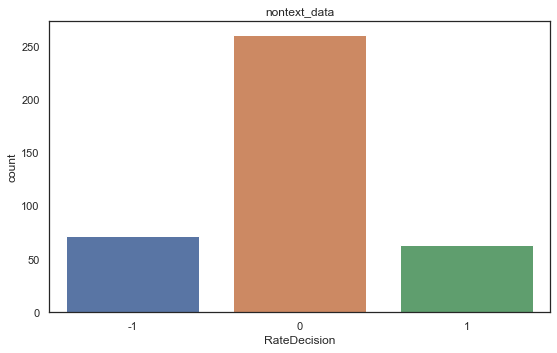

In [202]:
# The number of data per Target Labels
x = nontext_data['RateDecision'].value_counts()
print("Count: ")
print(x)
print("Percent: ")
print(round(x/sum(x) * 100))
# sns.barplot(x.index, x)
# plt.gca().set_ylabel('number of samples')
plt.figure(figsize=(8,5))
ax = sns.countplot(x='RateDecision', data=nontext_data)
ax.set_title('nontext_data')

Highly imbalanced to 0 (hold), so need to consider this point. Always predicting 0 (hold) will result in the accuracy of more than 60%. 

## Correlation

In [203]:
nontext_data.columns.values

array(['unscheduled', 'forecast', 'confcall', 'Rate', 'RateDiff',
       'RateDecision', 'ChairPerson', 'RateChanged', 'GDP_date',
       'GDP_value', 'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_date',
       'GDPPOT_value', 'GDPPOT_diff_prev', 'GDPPOT_diff_year', 'PCE_date',
       'PCE_value', 'PCE_diff_prev', 'PCE_diff_year', 'CPI_date',
       'CPI_value', 'CPI_diff_prev', 'CPI_diff_year', 'Unemp_date',
       'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year', 'Employ_date',
       'Employ_value', 'Employ_diff_prev', 'Employ_diff_year', 'PMI_date',
       'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 'NMI_date',
       'NMI_value', 'NMI_diff_prev', 'NMI_diff_year', 'Rsales_date',
       'Rsales_value', 'Rsales_diff_prev', 'Rsales_diff_year',
       'Hsales_date', 'Hsales_value', 'Hsales_diff_prev',
       'Hsales_diff_year', 'Taylor', 'Balanced', 'Inertia', 'Taylor-Rate',
       'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff',
       'Inertia_diff', 'prev_decision'

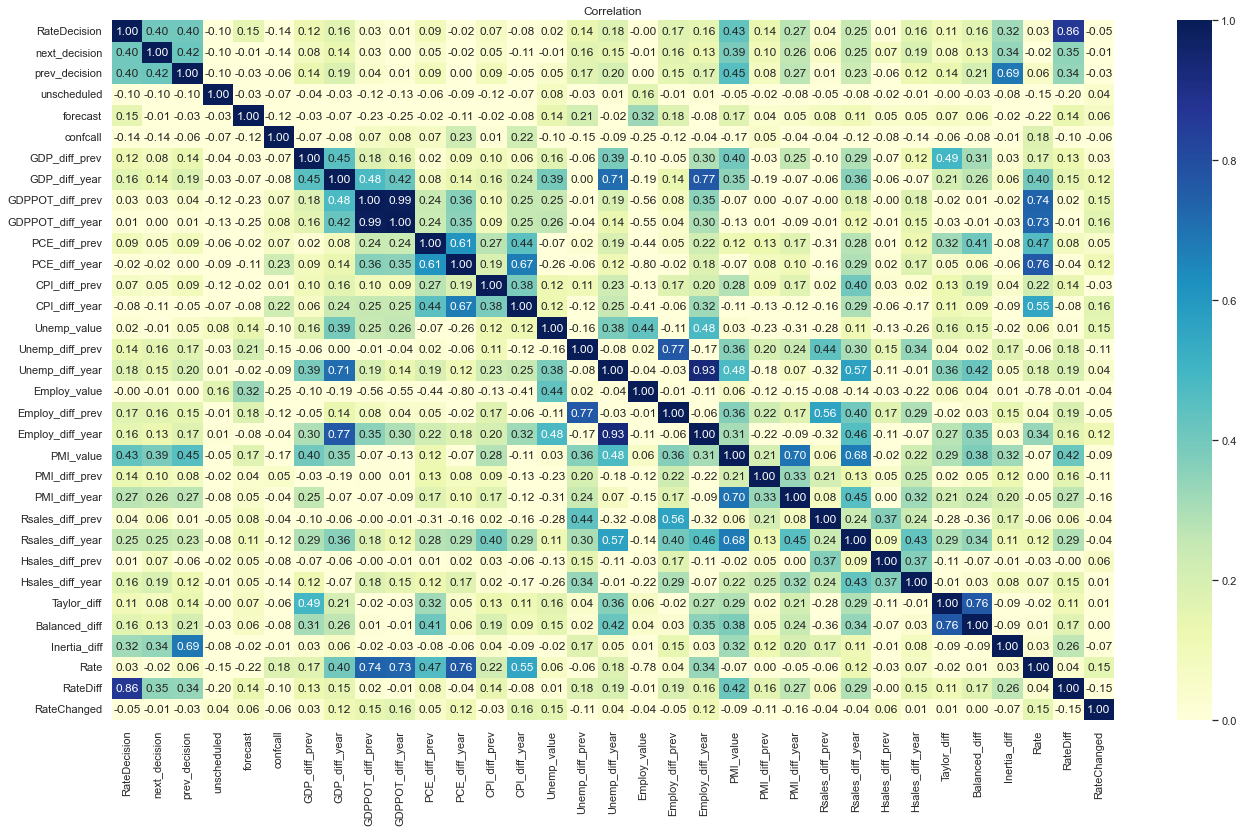

In [204]:
# Per document type
corr_columns = ['RateDecision', 'next_decision', 'prev_decision', 'unscheduled', 'forecast', 'confcall', 
                'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                'Taylor_diff', 'Balanced_diff', 'Inertia_diff', 'Rate', 'RateDiff', 'RateChanged']

fig, ax = plt.subplots(1, 1, figsize=(20, 12))

sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax)
ax.set_title("Correlation")
plt.show()

### Moving average

In [205]:
corr_columns = ['RateDecision',
                'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                'Taylor_diff', 'Balanced_diff', 'Inertia_diff', 'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate']

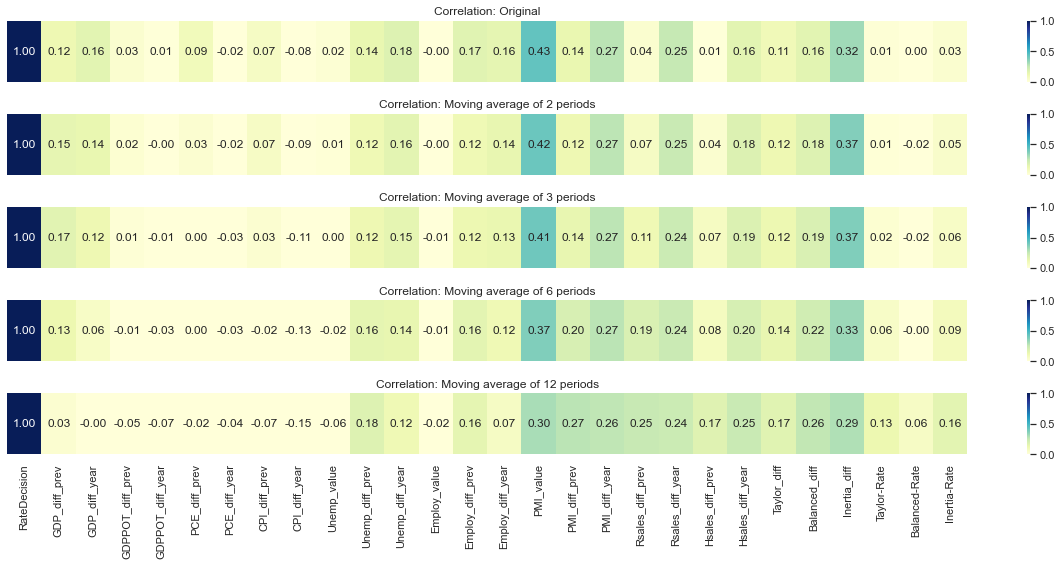

In [206]:
# Moving average (window = 2)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(17,8))

sns.heatmap(nontext_data[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax1)
ax1.set_title("Correlation: Original")
ax1.set_xticks([])
ax1.set_yticks([])
sns.heatmap(nontext_ma2[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax2)
ax2.set_title("Correlation: Moving average of 2 periods")
ax2.set_xticks([])
ax2.set_yticks([])
sns.heatmap(nontext_ma3[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax3)
ax3.set_title("Correlation: Moving average of 3 periods")
ax3.set_xticks([])
ax3.set_yticks([])
sns.heatmap(nontext_ma6[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax4)
ax4.set_title("Correlation: Moving average of 6 periods")
ax4.set_xticks([])
ax4.set_yticks([])
sns.heatmap(nontext_ma12[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax5)
ax5.set_title("Correlation: Moving average of 12 periods")
ax5.set_yticks([])

fig.tight_layout(pad=1.0)
plt.show()


Not much improvement. The followings can be used:
 * Unemp_diff_prev for previous 3 period
 * Emp_diff_prev for previous 2 period
 * Rsales_diff_year for previous 2 period
 * Hsales_diff_year for previous 12 period
 * Balanced_diff for previous 12 period
 * Intertia_diff for previous 3 period

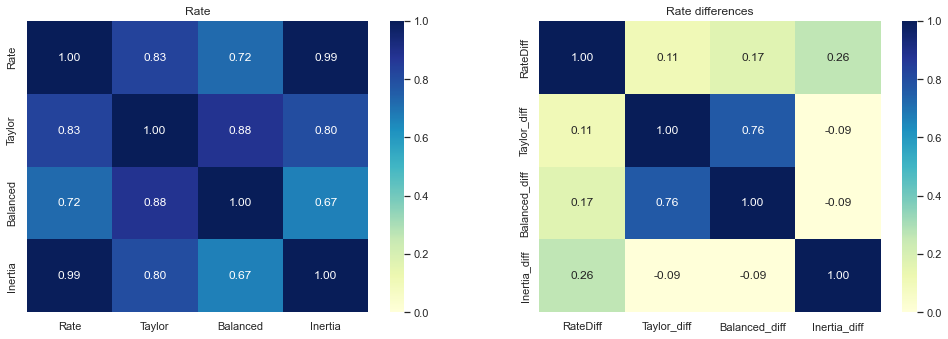

In [207]:
# Correlation between Taylor rule and actual rates are quite high

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

corr_columns = ['Rate', 'Taylor', 'Balanced', 'Inertia']
sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax1)
ax1.set_title("Rate")

corr_columns = ['RateDiff', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff']
sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax2)
ax2.set_title("Rate differences")

plt.show()

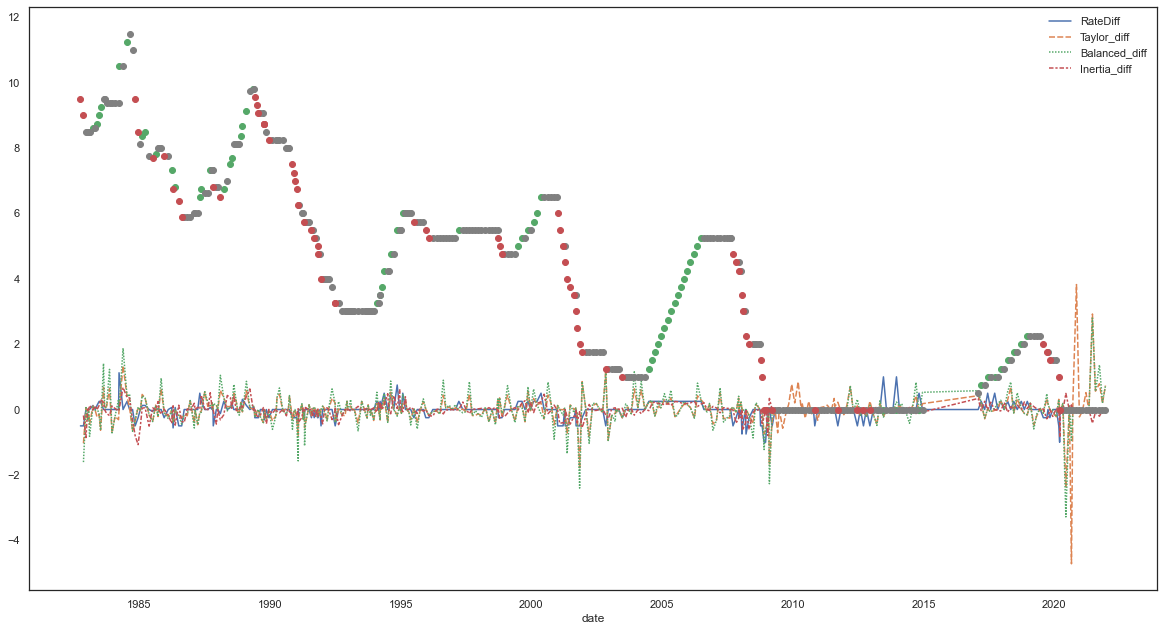

In [208]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.lineplot(data=nontext_data[corr_columns], ax=ax)

decision_raise = nontext_data.loc[nontext_data['RateDecision'] == 1]
decision_hold = nontext_data.loc[nontext_data['RateDecision'] == 0]
decision_lower = nontext_data.loc[nontext_data['RateDecision'] == -1]

ax.plot(decision_raise.index.values, decision_raise['Rate'], 'o', color="g", label="Raise")
ax.plot(decision_hold.index.values, decision_hold['Rate'], 'o', color="grey", label="Hold")
ax.plot(decision_lower.index.values, decision_lower['Rate'], 'o', color="r", label="Lower")


### Check individual columns

In [209]:
def plot_distribution(df, columns):
    for col in columns:        
        fig, ax = plt.subplots(figsize=(10, 5))
        g = sns.kdeplot(df[col][(df["RateDecision"] == -1) & (df[col].notnull())], color="Red", shade=True)
        g = sns.kdeplot(df[col][(df["RateDecision"] == 0) & (df[col].notnull())], ax=g, color="Blue", shade=True)
        g = sns.kdeplot(df[col][(df["RateDecision"] == 1) & (df[col].notnull())], ax=g, color="Green", shade=True)
        g.set_xlabel(col)
        g.set_ylabel("Frequency")
        g.set_title("Distribution for " + col, fontsize=14)
        g = g.legend(["Lower", "Hold", "Raise"])
        
        g = sns.FacetGrid(df, col='RateDecision', height=3, aspect=1)
        g.map(sns.distplot, col)


/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

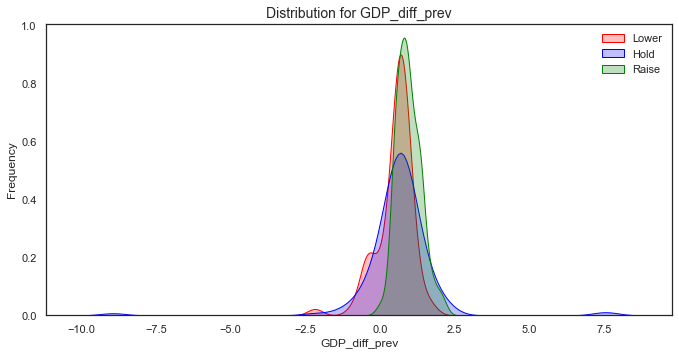

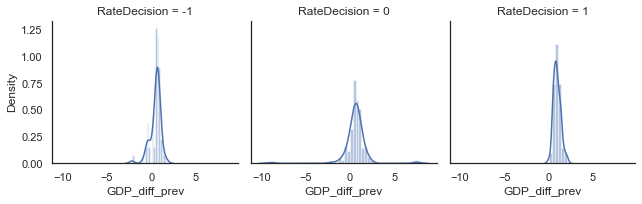

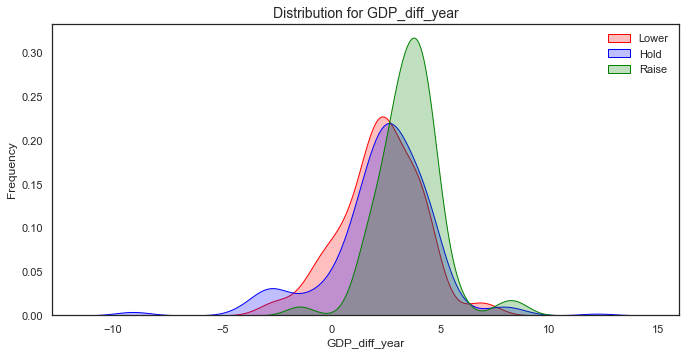

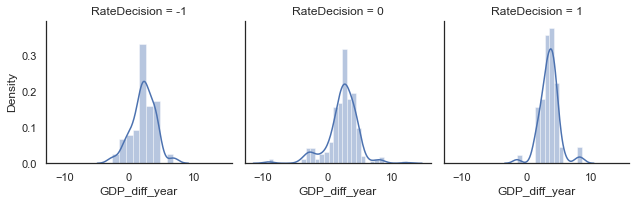

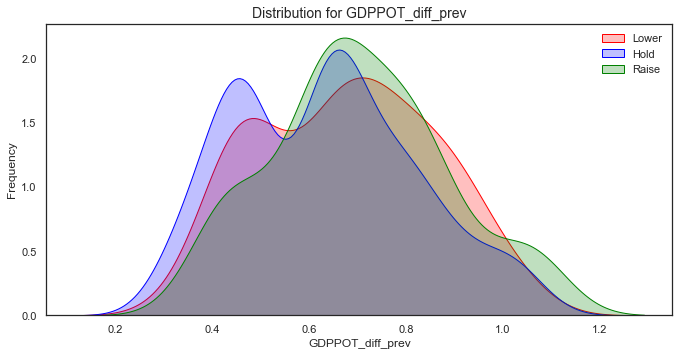

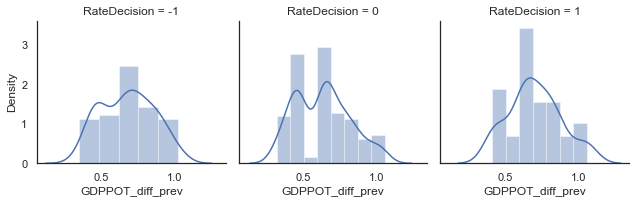

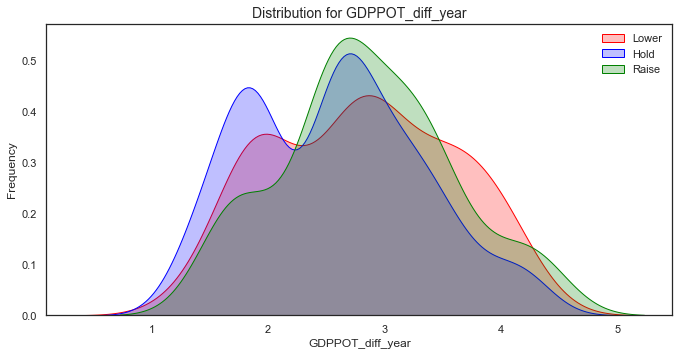

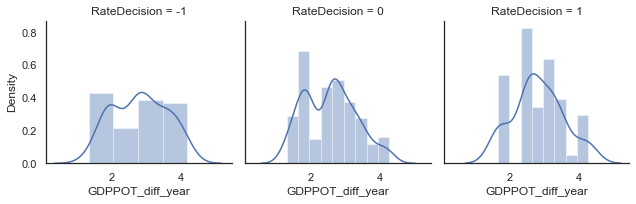

In [210]:
plot_distribution(nontext_data, ["GDP_diff_prev", "GDP_diff_year", "GDPPOT_diff_prev", "GDPPOT_diff_year"])

/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

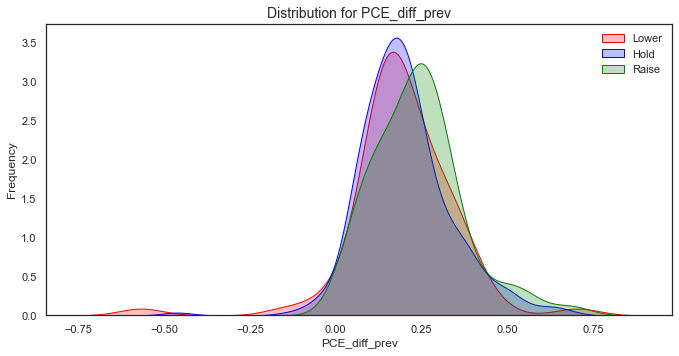

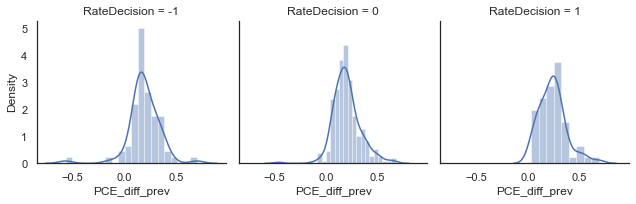

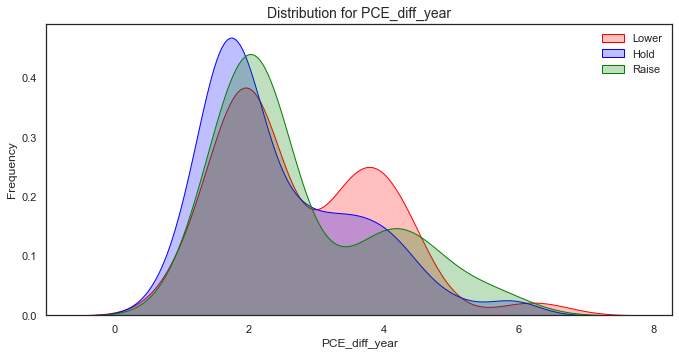

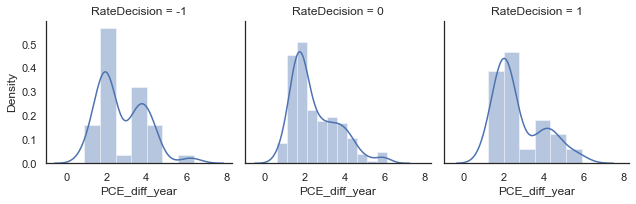

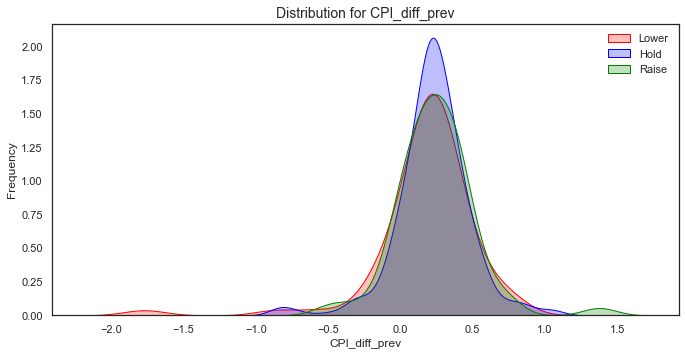

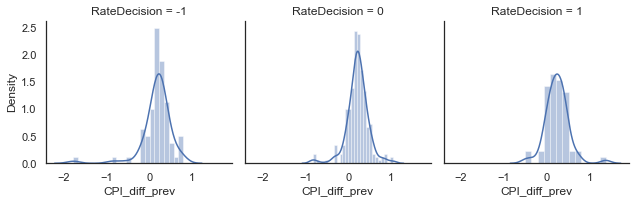

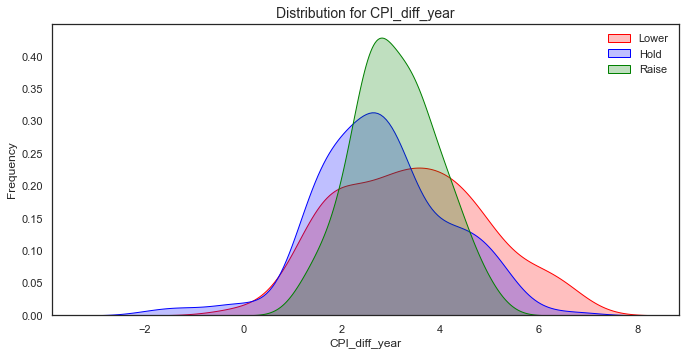

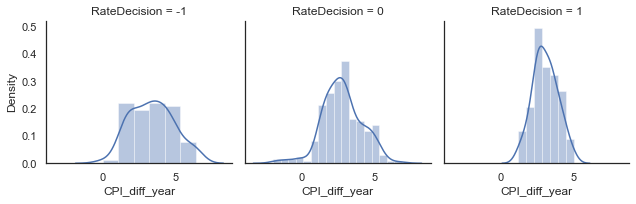

In [211]:
plot_distribution(nontext_data, ["PCE_diff_prev", "PCE_diff_year", "CPI_diff_prev", "CPI_diff_year"])

/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

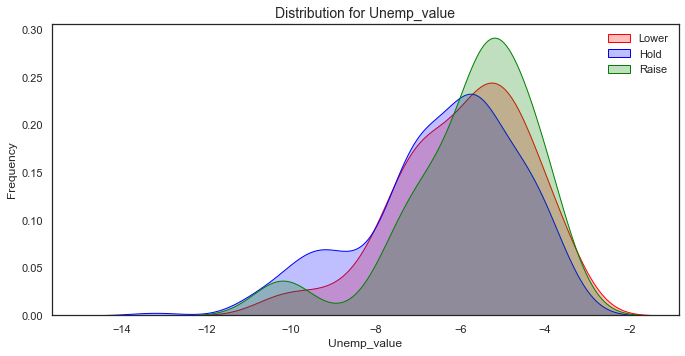

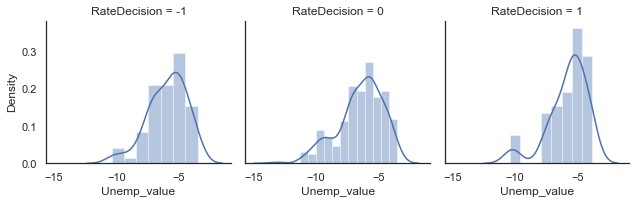

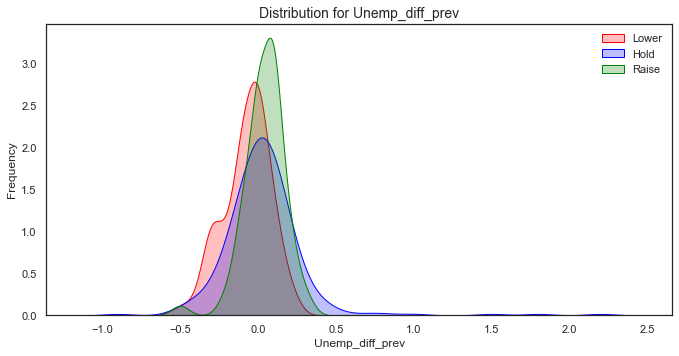

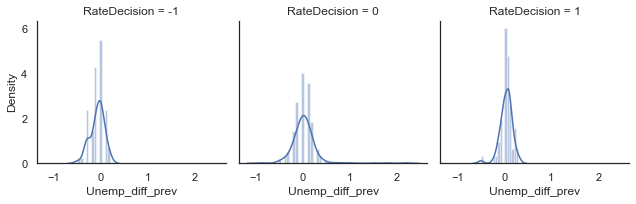

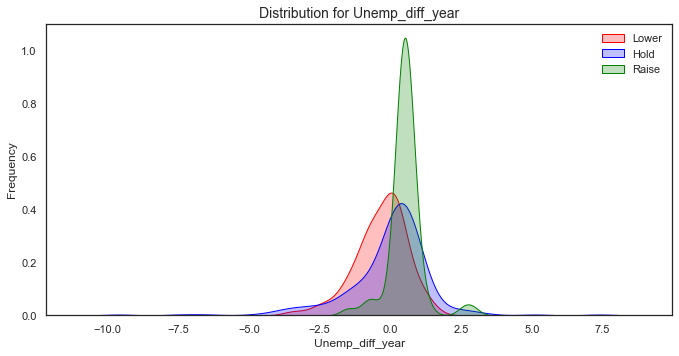

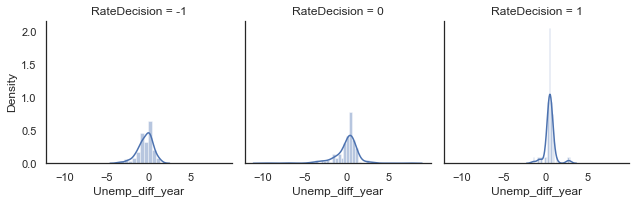

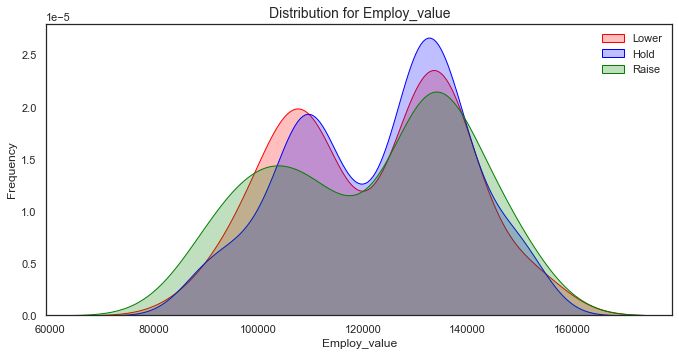

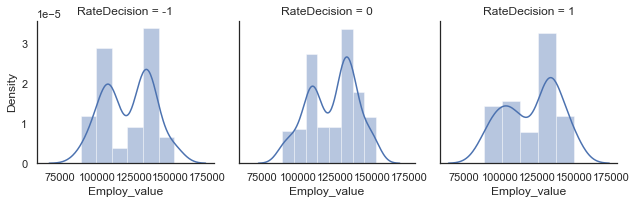

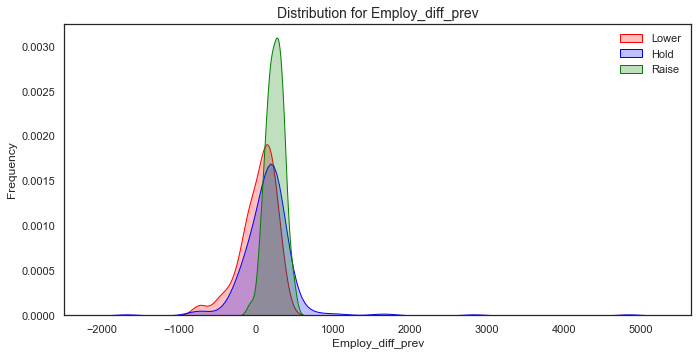

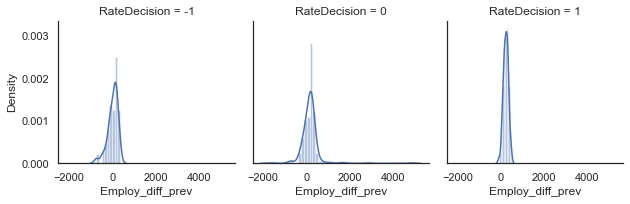

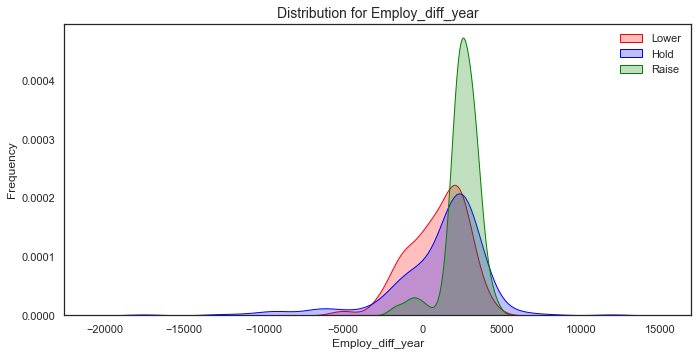

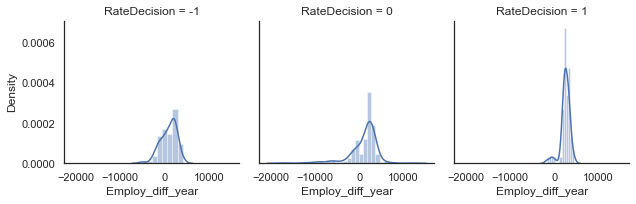

In [212]:
plot_distribution(nontext_data, ["Unemp_value", "Unemp_diff_prev", "Unemp_diff_year", "Employ_value", "Employ_diff_prev", "Employ_diff_year"])

/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

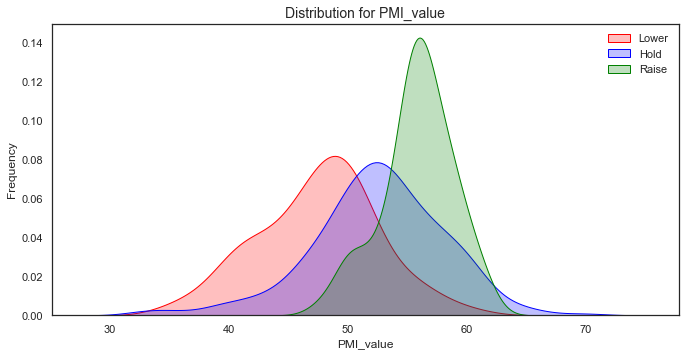

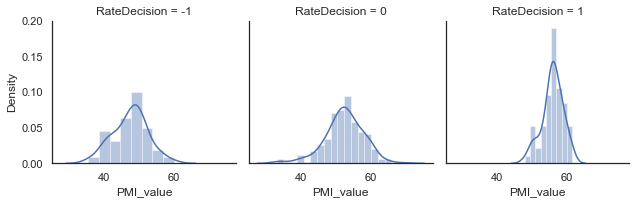

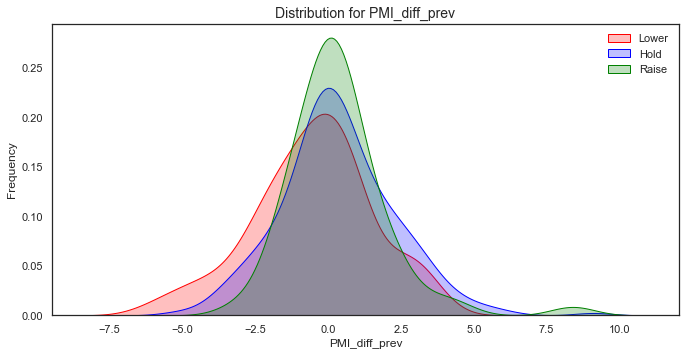

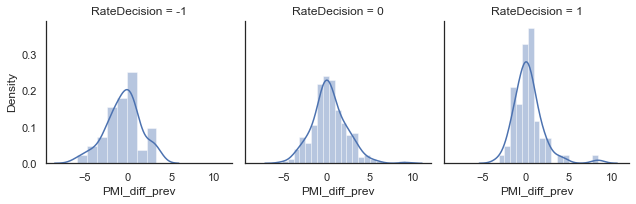

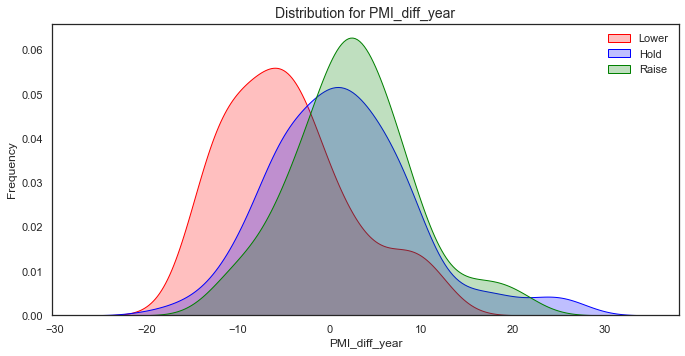

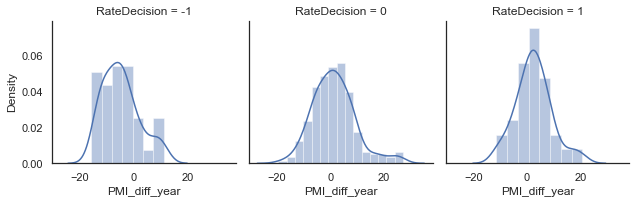

In [213]:
plot_distribution(nontext_data, ["PMI_value", "PMI_diff_prev", "PMI_diff_year"])

/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

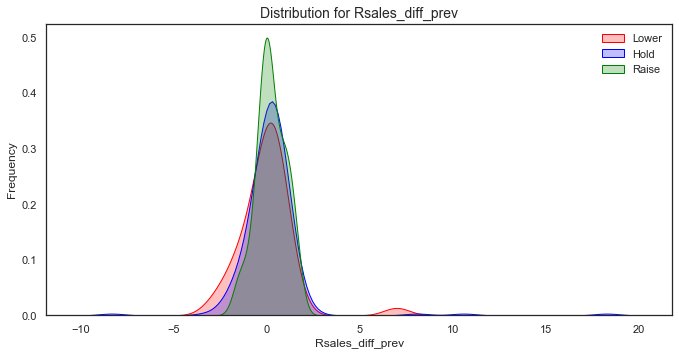

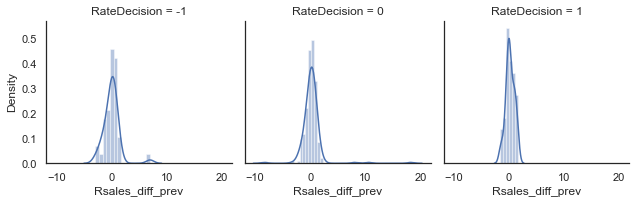

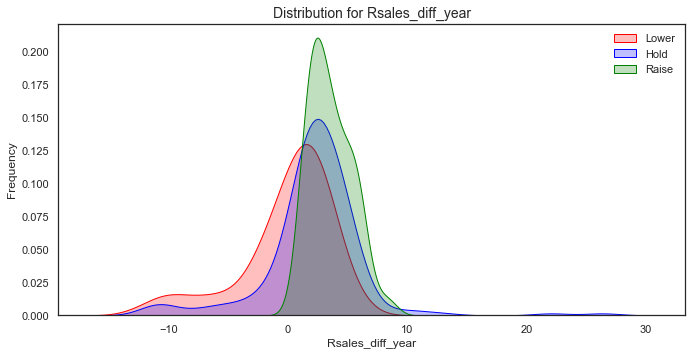

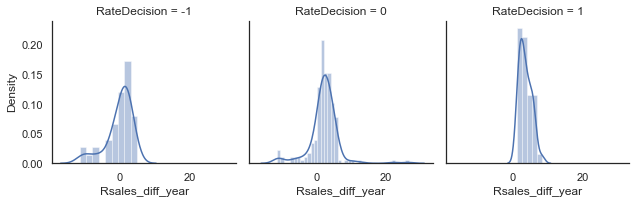

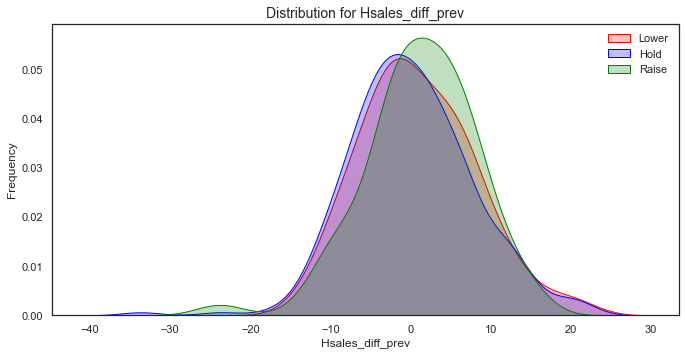

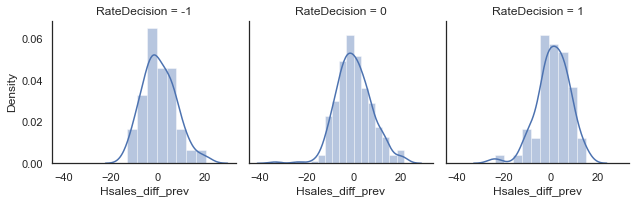

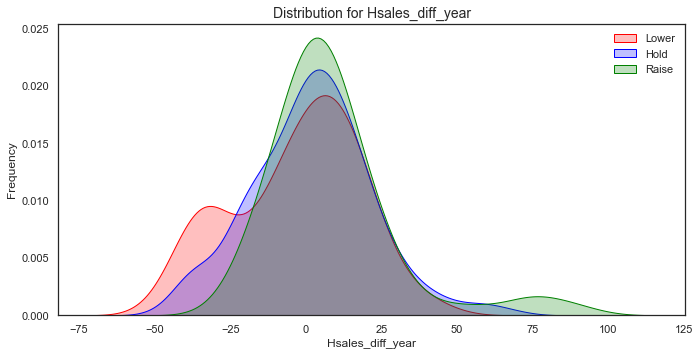

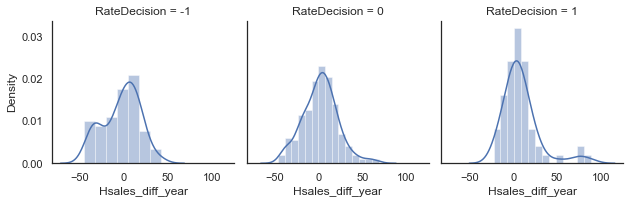

In [214]:
plot_distribution(nontext_data, ["Rsales_diff_prev", "Rsales_diff_year", "Hsales_diff_prev", "Hsales_diff_year"])

/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

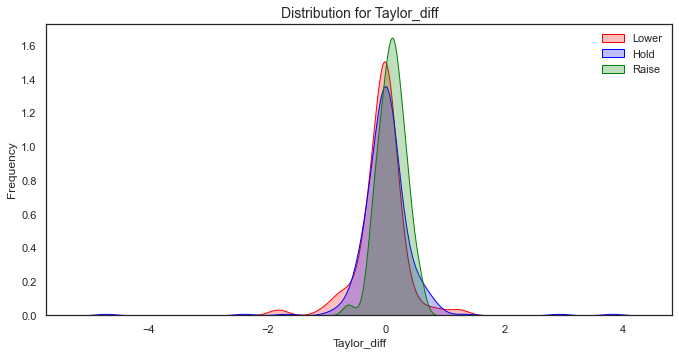

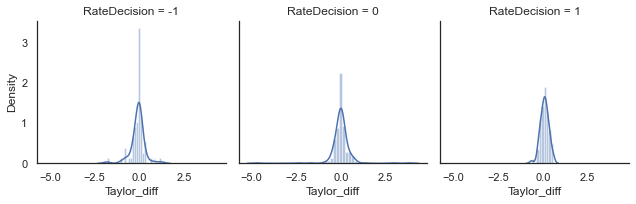

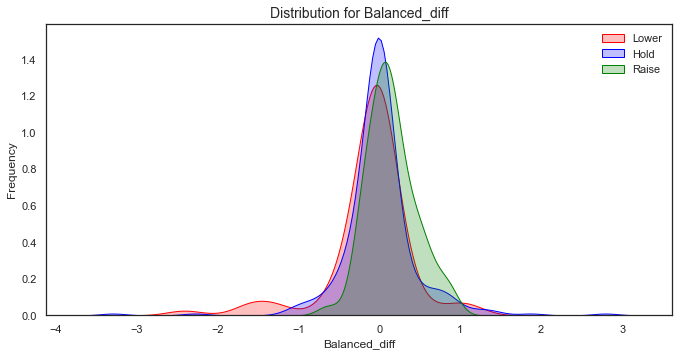

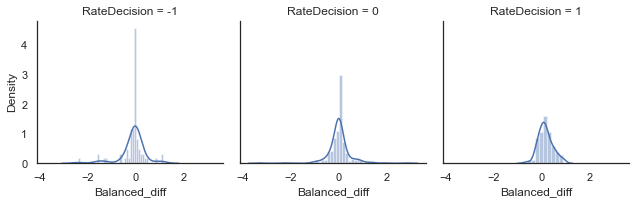

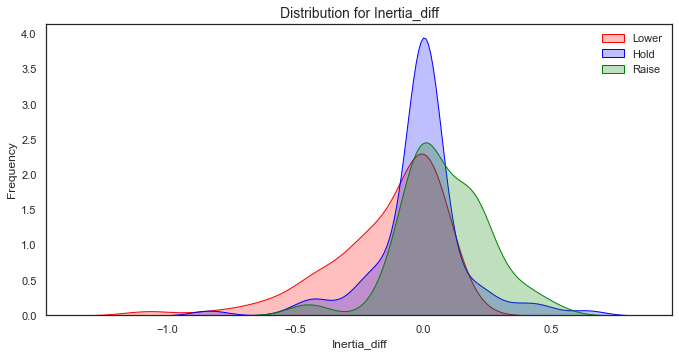

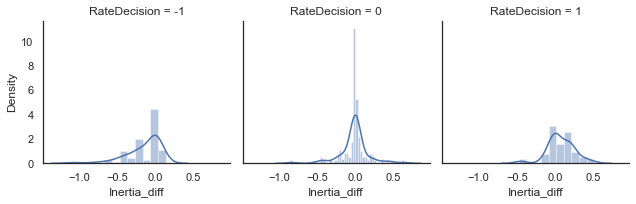

In [215]:
plot_distribution(nontext_data, ["Taylor_diff", "Balanced_diff", "Inertia_diff"])

## Create Training Data Set

In [216]:
nontext_train_small = pd.concat([nontext_data[['RateDecision', 'prev_decision', 'GDP_diff_prev', 'PMI_value']],
                                 nontext_ma2[['Employ_diff_prev', 'Rsales_diff_year']], 
                                 nontext_ma3[['Unemp_diff_prev', 'Inertia_diff']], 
                                 nontext_ma12[['Hsales_diff_year', 'Balanced_diff']]], axis=1)
nontext_train_small.rename(columns={'RateDecision': 'target'}, inplace=True)

In [217]:
nontext_train_small.isnull().sum()

target                0
prev_decision         1
GDP_diff_prev         0
PMI_value             0
Employ_diff_prev      0
Rsales_diff_year    131
Unemp_diff_prev       0
Inertia_diff          4
Hsales_diff_year      0
Balanced_diff        15
dtype: int64

In [218]:
# Large dataset to include all the latest figures plus 3 months rolling average

latest_columns = ['RateDecision', 'prev_decision',
                  'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                  'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                  'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                  'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                  'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                  'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                  'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff']

ma3_columns = ['GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
               'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
               'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
               'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
               'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
               'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
               'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff']

nontext_train_large = pd.concat([nontext_data[latest_columns], nontext_ma3[ma3_columns].add_suffix('_ma3')], axis=1)
nontext_train_large.rename(columns={'RateDecision': 'target'}, inplace=True)
print(nontext_data[latest_columns].shape)
print(nontext_ma3[ma3_columns].shape)
print(nontext_train_large.shape)

(396, 29)
(396, 27)
(396, 56)


In [219]:
nontext_train_large.isnull().sum()

target               0
prev_decision        1
GDP_diff_prev        0
GDP_diff_year        0
GDPPOT_diff_prev     0
                    ..
Balanced-Rate_ma3    3
Inertia-Rate_ma3     3
Taylor_diff_ma3      4
Balanced_diff_ma3    4
Inertia_diff_ma3     4
Length: 56, dtype: int64

### Missing Values

In [220]:
# As most likely the decision is 0 (hold), fill prev_decision of the first row
nontext_train_small['prev_decision'].fillna(0, inplace=True)
nontext_train_large['prev_decision'].fillna(0, inplace=True)

(0.0, 400.0)

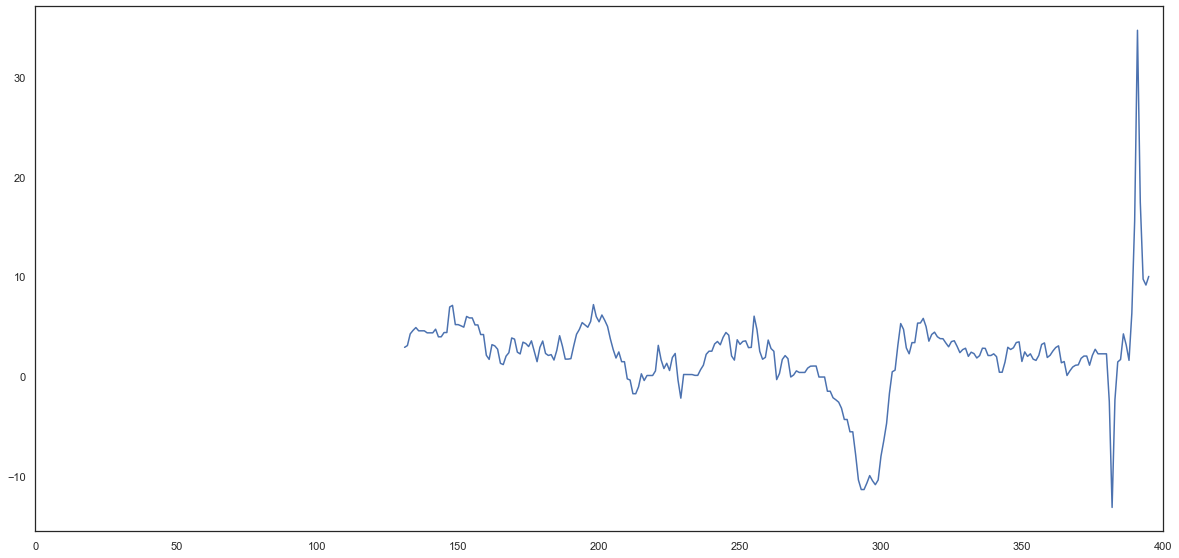

In [221]:
ax = sns.lineplot(data=nontext_train_small['Rsales_diff_year'].values)
ax.set_xlim(0, 400)

(0.0, 400.0)

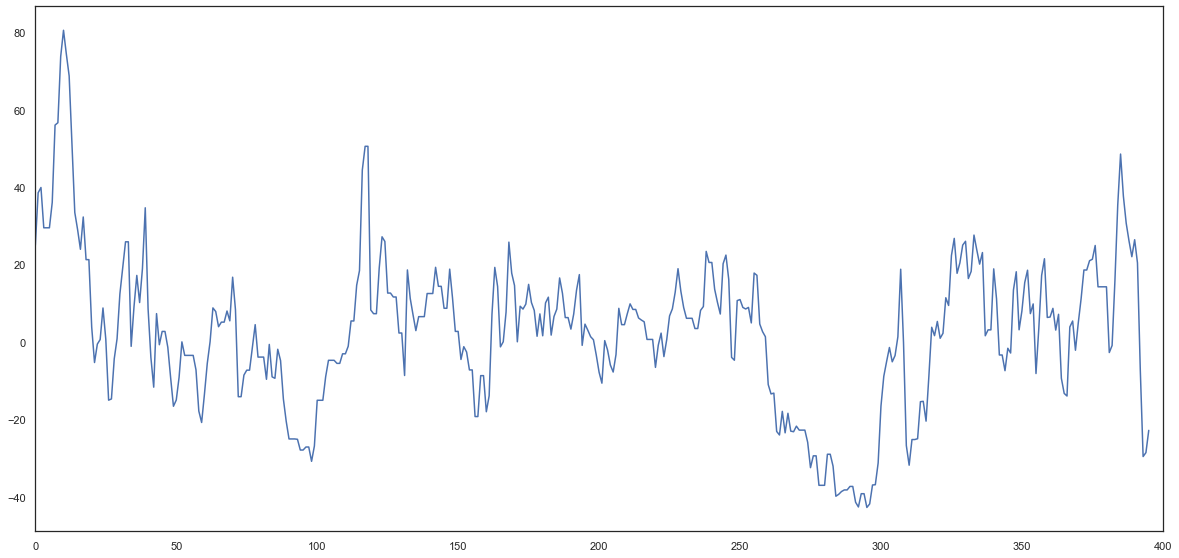

In [222]:
ax = sns.lineplot(data=nontext_ma2['Hsales_diff_year'].values)
ax.set_xlim(0, 400)

In [223]:
# Retail sales growth ratio is difficult to estimate. Though it is not ideal, simply use the average
nontext_train_small['Rsales_diff_year'].fillna(nontext_train_small['Rsales_diff_year'].mean(), inplace=True)
nontext_train_large['Rsales_diff_prev'].fillna(nontext_train_large['Rsales_diff_prev'].mean(), inplace=True)
nontext_train_large['Rsales_diff_year'].fillna(nontext_train_large['Rsales_diff_year'].mean(), inplace=True)

nontext_train_small['Inertia_diff'].fillna(nontext_train_small['Inertia_diff'].mean(), inplace=True)
nontext_train_small['Balanced_diff'].fillna(nontext_train_small['Balanced_diff'].mean(), inplace=True)
nontext_train_large['Inertia_diff'].fillna(nontext_train_large['Inertia_diff'].mean(), inplace=True)
nontext_train_large['Balanced_diff'].fillna(nontext_train_large['Balanced_diff'].mean(), inplace=True)
nontext_train_large['Taylor_diff'].fillna(nontext_train_large['Taylor_diff'].mean(), inplace=True)

nontext_train_large['Rsales_diff_prev_ma3'].fillna(nontext_train_large['Rsales_diff_prev_ma3'].mean(), inplace=True)
nontext_train_large['Rsales_diff_year_ma3'].fillna(nontext_train_large['Rsales_diff_year_ma3'].mean(), inplace=True)

nontext_train_large['Inertia_diff_ma3'].fillna(nontext_train_large['Inertia_diff_ma3'].mean(), inplace=True)
nontext_train_large['Balanced_diff_ma3'].fillna(nontext_train_large['Balanced_diff_ma3'].mean(), inplace=True)
nontext_train_large['Taylor_diff_ma3'].fillna(nontext_train_large['Taylor_diff_ma3'].mean(), inplace=True)
nontext_train_large['Inertia-Rate_ma3'].fillna(nontext_train_large['Inertia-Rate_ma3'].mean(), inplace=True)
nontext_train_large['Balanced-Rate_ma3'].fillna(nontext_train_large['Balanced-Rate_ma3'].mean(), inplace=True)
nontext_train_large['Taylor-Rate_ma3'].fillna(nontext_train_large['Taylor-Rate_ma3'].mean(), inplace=True)


In [224]:
nontext_train_small.isnull().sum()

target              0
prev_decision       0
GDP_diff_prev       0
PMI_value           0
Employ_diff_prev    0
Rsales_diff_year    0
Unemp_diff_prev     0
Inertia_diff        0
Hsales_diff_year    0
Balanced_diff       0
dtype: int64

In [225]:
nontext_train_large.isnull().sum()

target               0
prev_decision        0
GDP_diff_prev        0
GDP_diff_year        0
GDPPOT_diff_prev     0
                    ..
Balanced-Rate_ma3    0
Inertia-Rate_ma3     0
Taylor_diff_ma3      0
Balanced_diff_ma3    0
Inertia_diff_ma3     0
Length: 56, dtype: int64

### One-hot encoding

In [226]:
# nontext_train['Lower'] = nontext_train['RateDecision'].apply(lambda x: 1 if x == -1 else 0)
# nontext_train['Hold'] = nontext_train['RateDecision'].apply(lambda x: 1 if x == 0 else 0)
# nontext_train['Raise'] = nontext_train['RateDecision'].apply(lambda x: 1 if x == 1 else 0)
# nontext_train

# Save Data

In [227]:
def save_data(df, file_name, dir_name='../data/train_data/'):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [228]:
# Save non-text data
save_data(nontext_train_small, 'nontext_train_small')
save_data(nontext_train_large, 'nontext_train_large')

In [229]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from pprint import pprint

import pickle
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models

import string

import warnings
warnings.simplefilter('ignore')
from itertools import chain
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from tqdm.auto import tqdm

import datetime as dt
import os
from dateutil.relativedelta import *

In [230]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Define Functions

In [231]:
def clean(text):
#     from nltk.corpus import stopwords
#     from nltk.stem import WordNetLemmatizer
    
    exclude = set(string.punctuation)
    stop = set(stopwords.words('english'))
    lemma = WordNetLemmatizer()
    
    text = re.sub('[^A-z,.-]+', ' ', text)

    stop_free = ' '.join([word for word in text.lower().split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = ' '.join([lemma.lemmatize(word) for word in punc_free.split()])
    return normalized.split()

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod
    
def get_corpus(text_clean):
    bigram_mod = bigrams(text_clean)
    bigram = [bigram_mod[review] for review in text_clean]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    from gensim.models.ldamodel import LdaModel
    """
    # From https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
    
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes = 4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

## Load Preprocessed Data

In [232]:
# Load nontext data
file = open('../data/preprocessed/nontext_data.pickle', 'rb')
nontext_data = pd.read_pickle(file)
file.close()

print(nontext_data.shape)
nontext_data.head()

(396, 57)


unscheduled  forecast  confcall  Rate  RateDiff  RateDecision  \
date                                                                        
1982-10-05        False     False     False   9.5      -0.5            -1   
1982-11-16        False     False     False   9.0      -0.5            -1   
1982-12-21        False     False     False   8.5       0.0             0   
1983-01-14        False     False      True   8.5       0.0             0   
1983-01-21        False     False      True   8.5       0.0             0   

           ChairPerson  RateChanged   GDP_date  GDP_value  ...  \
date                                                       ...   
1982-10-05         NaN            1 1982-04-01   6830.251  ...   
1982-11-16         NaN            1 1982-07-01   6804.139  ...   
1982-12-21         NaN            0 1982-07-01   6804.139  ...   
1983-01-14         NaN            0 1982-07-01   6804.139  ...   
1983-01-21         NaN            0 1982-07-01   6804.139  ...   

            Hsales_diff_year    Taylor  Balanced   Inertia  Taylor-Rate  \
date                                                                      
1982-10-05         42.307692  7.428054  4.300007  7.854999    -2.571946   
1982-11-16         34.831461  6.397952  2.690992  7.671351    -3.102048   
1982-12-21         45.026178  6.456348  2.749388  6.812592    -2.043652   
1983-01-14         14.004376  6.117343  2.410384  6.863442    -2.382657   
1983-01-21         14.004376  6.117343  2.410384  6.863442    -2.382657   

            Balanced-Rate Inertia-Rate  Taylor_diff  Balanced_diff  \
date                                                                 
1982-10-05      -5.699993    -2.145001          NaN            NaN   
1982-11-16      -6.809008    -1.828649    -1.030102      -1.609015   
1982-12-21      -5.750612    -1.687408     0.058396       0.058396   
1983-01-14      -6.089616    -1.636558    -0.339005      -0.339005   
1983-01-21      -6.089616    -1.636558     0.000000       0.000000   

            Inertia_diff  
date                      
1982-10-05           NaN  
1982-11-16     -0.183648  
1982-12-21     -0.858759  
1983-01-14      0.050851  
1983-01-21      0.000000  

[5 rows x 57 columns]

In [233]:
# Load text data
file = open('../data/preprocessed/text_no_split.pickle', 'rb')
text_data = pd.read_pickle(file)
file.close()

print(text_data.shape)
text_data.head()

(9744, 11)


type       date           title         speaker  word_count decision  \
0  statement 1994-02-04  FOMC Statement  Alan Greenspan          99        1   
1  statement 1994-03-22  FOMC Statement  Alan Greenspan          40        1   
2  statement 1994-04-18  FOMC Statement  Alan Greenspan          37        1   
3  statement 1994-05-17  FOMC Statement  Alan Greenspan          57        1   
4  statement 1994-08-16  FOMC Statement  Alan Greenspan          51        1   

   rate next_meeting next_decision  next_rate  \
0  3.25   1994-02-28             0       3.25   
1   3.5   1994-04-18             1       3.75   
2  3.75   1994-05-17             1       4.25   
3  4.25   1994-07-06             0       4.25   
4  4.75   1994-09-27             0       4.75   

                                                                                                                                                                                                      text  
0  Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...  
1  Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...  
2  Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...  
3  In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...  
4  In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...

## Review text types

In [234]:
# Frequency of text-data type
text_data.type.value_counts()

meeting_script     8653
speech              439
minutes             223
statement           195
testimony           185
presconf_script      49
Name: type, dtype: int64

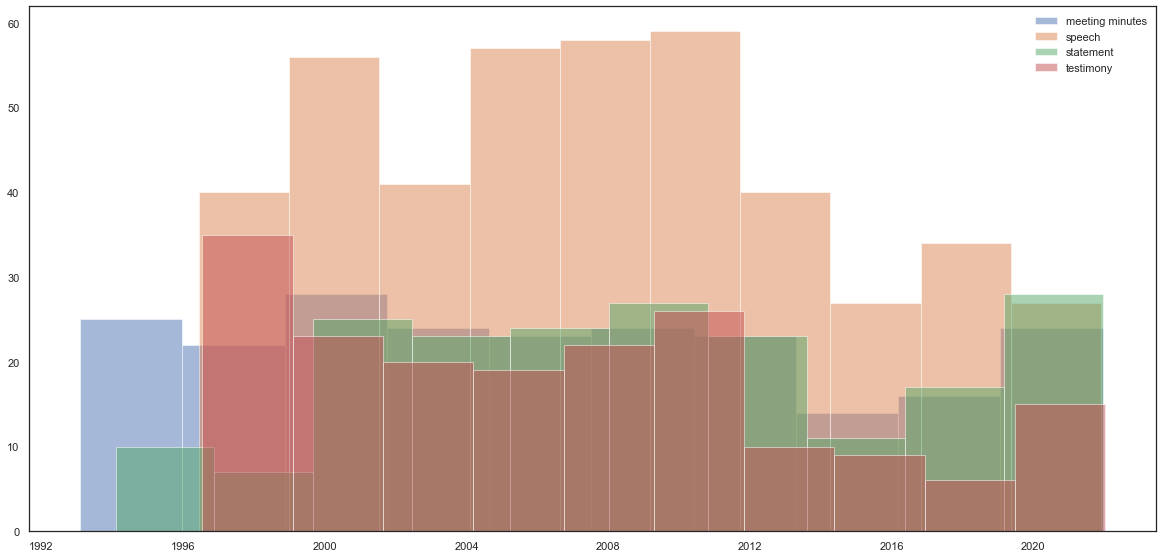

In [235]:
# show timing of types -- drop meeting transcripts due to delay in release, press conference transcripts as only began in 2011
plt.hist(text_data[text_data.type == 'minutes'].date, alpha = 0.5, label = 'meeting minutes')
plt.hist(text_data[text_data.type == 'speech'].date, alpha = 0.5, label = 'speech')
plt.hist(text_data[text_data.type == 'statement'].date, alpha = 0.5, label = 'statement')
plt.hist(text_data[text_data.type == 'testimony'].date, alpha = 0.5, label = 'testimony')

plt.legend()

## Keep only Meeting Minutes, Speech, Statement, Testimony

In [236]:
text_filtered = text_data[text_data.type.isin(['minutes', 'speech', 'statement', 'testimony'])]
text_filtered.shape

(1042, 11)

## Clean text

In [237]:
text_filtered.head(2)

type       date           title         speaker  word_count decision  \
0  statement 1994-02-04  FOMC Statement  Alan Greenspan          99        1   
1  statement 1994-03-22  FOMC Statement  Alan Greenspan          40        1   

   rate next_meeting next_decision  next_rate  \
0  3.25   1994-02-28             0       3.25   
1   3.5   1994-04-18             1       3.75   

                                                                                                                                                                                                      text  
0  Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...  
1  Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...

In [238]:
text_filtered['text_clean'] = text_filtered['text'].apply(clean) # clean text

text_filtered.head(1)

type       date           title         speaker  word_count decision  \
0  statement 1994-02-04  FOMC Statement  Alan Greenspan          99        1   

   rate next_meeting next_decision  next_rate  \
0  3.25   1994-02-28             0       3.25   

                                                                                                                                                                                                      text  \
0  Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...   

                                                                                                                                                                                                text_clean  
0  [chairman, alan, greenspan, announced, today, federal, open, market, committee, decided, increase, slightly, degree, pressure, reserve, position, action, expected, associated, small, increase, sho...

## Split into Bigrams

In [239]:
corpus, id2word, bigram_text = get_corpus(text_filtered.text_clean)

In [240]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1)]

## Apply LDA

### Choose number of topics

In [241]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=bigram_text, start=5, limit=30, step=2)

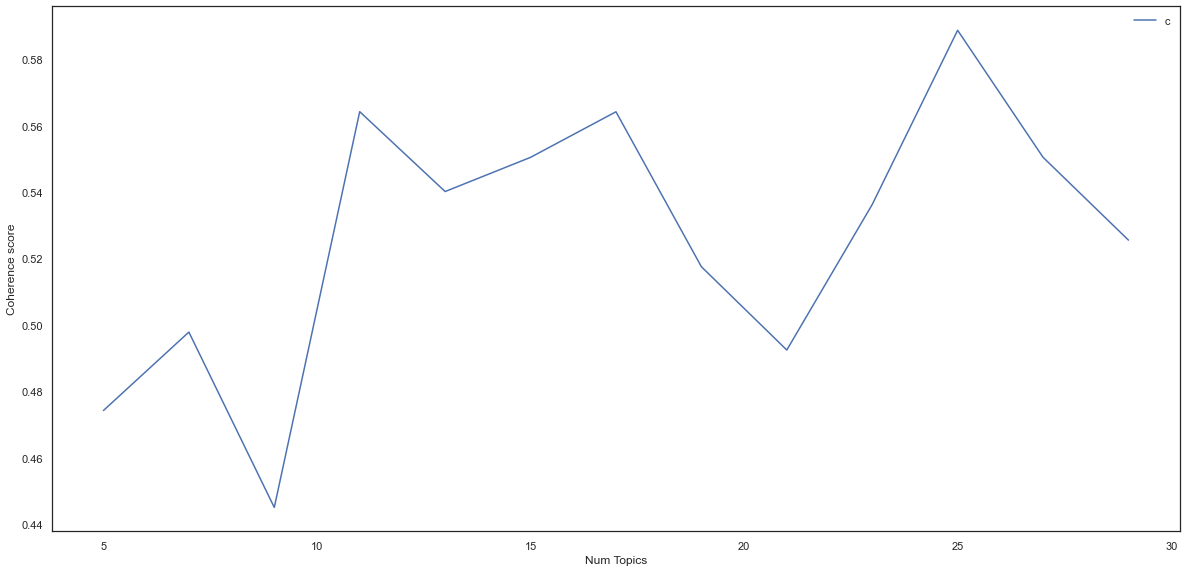

In [242]:
# Coherence score plot
limit=30; start=5; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Choose 8 topics -- highest coherence score

### Model

In [243]:
# Number of Topics
num_topics = 8
# Build LDA model
lda_model_8 = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=num_topics, 
                                        passes=50)

### Words in Topics

In [244]:
#pip install wordcloud

In [245]:
from wordcloud import WordCloud, STOPWORDS

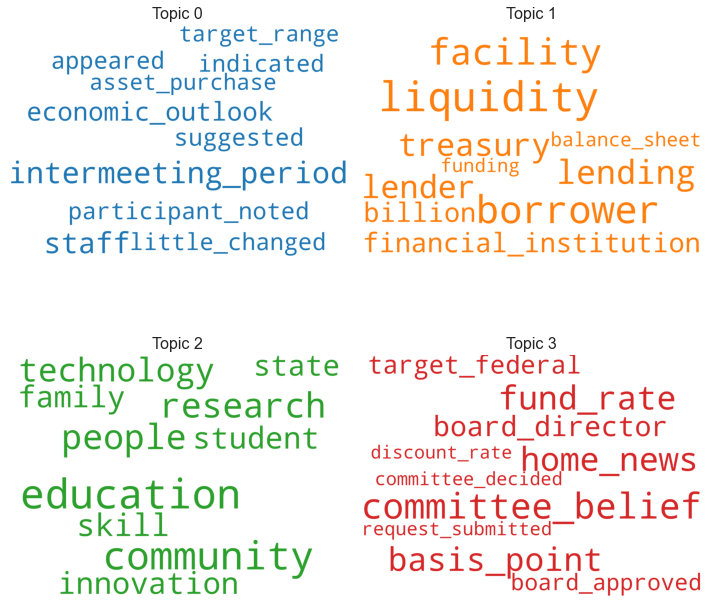

In [246]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,# changed for STOPWORDS
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_8.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Keywords for each topic

In [247]:
# Print the Keyword in the topics
pprint(lda_model_8.print_topics())
doc_lda = lda_model_8[corpus]

[(0,
  '0.006*"intermeeting_period" + 0.006*"staff" + 0.005*"economic_outlook" + '
  '0.004*"suggested" + 0.004*"appeared" + 0.004*"participant_noted" + '
  '0.004*"little_changed" + 0.004*"indicated" + 0.004*"asset_purchase" + '
  '0.003*"target_range"'),
 (1,
  '0.010*"liquidity" + 0.008*"borrower" + 0.007*"facility" + 0.006*"lending" + '
  '0.006*"lender" + 0.006*"treasury" + 0.005*"financial_institution" + '
  '0.005*"billion" + 0.005*"balance_sheet" + 0.005*"funding"'),
 (2,
  '0.006*"education" + 0.006*"community" + 0.004*"people" + 0.004*"research" + '
  '0.004*"technology" + 0.004*"skill" + 0.003*"innovation" + 0.003*"student" + '
  '0.003*"family" + 0.003*"state"'),
 (3,
  '0.013*"committee_belief" + 0.011*"home_news" + 0.011*"fund_rate" + '
  '0.011*"basis_point" + 0.011*"board_director" + 0.011*"target_federal" + '
  '0.011*"board_approved" + 0.011*"request_submitted" + '
  '0.010*"committee_decided" + 0.010*"discount_rate"'),
 (4,
  '0.011*"fomc" + 0.006*"recovery" + 0.006*

## Assess topic coherence

In [248]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_8.log_perplexity(corpus))  # Measure of how good the model is. Lower is better.

# Compute Coherence Score
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model_8, texts=bigram_text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda) # Want above .5


Perplexity:  -7.934202806247308

Coherence Score:  0.6142749403863337


In [249]:
# VISUALIZE LDA OUTPUT AS HTML-PAGE
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_8, corpus, dictionary=lda_model_8.id2word)
vis

# output results
pyLDAvis.save_html(vis, '../img/bigram.lda8-50.html')

/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-

## Add LDA Topics to dataframe

In [250]:
# ADD LDA TOPICS TO DATAFRAME
# REFERENCE CODE: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

data = text_filtered['text_clean']
def format_topics_sentences(ldamodel=lda_model_8, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# Run function to create new df
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_8, corpus=corpus, texts=bigram_text)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.head()


Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             7.0              0.5837   
1            1             7.0              0.4452   
2            2             7.0              0.4873   
3            3             3.0              0.9327   
4            4             3.0              0.9125   

                                                                                                                                                   Keywords  \
0                               intermeeting_period, appeared, inventory, suggested, consumer_spending, anticipated, quarter, fourth_quarter, july, reserve   
1                               intermeeting_period, appeared, inventory, suggested, consumer_spending, anticipated, quarter, fourth_quarter, july, reserve   
2                               intermeeting_period, appeared, inventory, suggested, consumer_spending, anticipated, quarter, fourth_quarter, july, reserve   
3  committee_belief, home_news, fund_rate, basis_point, board_director, target_federal, board_approved, request_submitted, committee_decided, discount_rate   
4  committee_belief, home_news, fund_rate, basis_point, board_director, target_federal, board_approved, request_submitted, committee_decided, discount_rate   

                                                                                                                                                                                                      Text  
0  [chairman, alan_greenspan, announced, today, federal_open, market, committee_decided, increase, slightly, degree_pressure, reserve_position, action, expected, associated, small, increase, shortter...  
1  [chairman, alan_greenspan, announced, today, federal_open, market, committee_decided, increase, slightly, degree_pressure, reserve_position, action, expected, associated, small, increase, shortter...  
2  [chairman, alan_greenspan, announced, today, federal_reserve, increase, slightly, degree_pressure, reserve_position, action, expected, associated, small, increase, shortterm, money_market, interes...  
3  [taking_discount, action_board, approved_request, submitted_board, director, eleven, federal_reserve, bank_boston, new_york, philadelphia, richmond_atlanta, chicago_st, louis_minneapolis, kansa_ci...  
4  [taking_discount, rate, action_board, approved_request, submitted_board, director_federal, reserve_bank, boston_new, york, richmond, kansa_city, dallas, discount_rate, interest_rate, charged_depos...

In [251]:
# This command prints out the topics in a text and the percent of the text from each topic

# if you want to make a list for each doc-topic pair
l = [lda_model_8.get_document_topics(item) for item in corpus]

# Create a list of lists (list of topics inside each doc)
topic_distribution = list()
for num in range(len(text_filtered['text_clean'])):
    props = [0] * 18  # create empty list
    doc = num
    for item in lda_model_8[corpus[num]]:
        topic = item[0]
        props[topic] = item[1]
    topic_distribution.append(props)
    
# Turn list of lists into dataframe
topic_dist = pd.DataFrame(topic_distribution)

In [252]:
# combine topics across transcript, minutes, etc. for each meeting date
final_text = text_filtered.join(topic_dist)
final_text = final_text.groupby('next_meeting').mean()

print(final_text.shape)
final_text.head()

(243, 20)


word_count  next_rate    0    1    2    3         4         5  \
next_meeting                                                                  
1993-02-18        8452.0        3.0  0.0  0.0  0.0  0.0  0.000000  0.010573   
1993-05-18        5253.0        3.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
1993-07-07        4414.0        3.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
1993-08-17        6309.0        3.0  0.0  0.0  0.0  0.0  0.031083  0.000000   
1993-09-21        4220.0        3.0  0.0  0.0  0.0  0.0  0.000000  0.000000   

                6         7    8    9   10   11   12   13   14   15   16   17  
next_meeting                                                                   
1993-02-18    0.0  0.979781  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1993-05-18    0.0  0.999379  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1993-07-07    0.0  0.999252  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1993-08-17    0.0  0.968376  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1993-09-21    0.0  0.999204  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [253]:
# find na's
na_rows = final_text[final_text.isna().any(axis=1)]

print(na_rows.shape)
display(na_rows)

(11, 20)


word_count  next_rate   0   1   2   3   4   5   6   7   8   9  \
next_meeting                                                                   
1998-09-29    1736.000000       5.25 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2003-04-01    1802.000000       1.25 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2003-04-08    1787.500000       1.25 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2003-04-16    2315.000000       1.25 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2003-05-06     864.000000       1.25 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2008-01-21    2805.000000       3.50 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2009-03-18    2733.000000       0.00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2009-06-24    1502.333333       0.00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2010-11-03    1844.333333       0.00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2013-10-30    1294.000000       0.00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2014-03-19     746.000000       0.00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   

              10  11  12  13  14  15  16  17  
next_meeting                                  
1998-09-29   NaN NaN NaN NaN NaN NaN NaN NaN  
2003-04-01   NaN NaN NaN NaN NaN NaN NaN NaN  
2003-04-08   NaN NaN NaN NaN NaN NaN NaN NaN  
2003-04-16   NaN NaN NaN NaN NaN NaN NaN NaN  
2003-05-06   NaN NaN NaN NaN NaN NaN NaN NaN  
2008-01-21   NaN NaN NaN NaN NaN NaN NaN NaN  
2009-03-18   NaN NaN NaN NaN NaN NaN NaN NaN  
2009-06-24   NaN NaN NaN NaN NaN NaN NaN NaN  
2010-11-03   NaN NaN NaN NaN NaN NaN NaN NaN  
2013-10-30   NaN NaN NaN NaN NaN NaN NaN NaN  
2014-03-19   NaN NaN NaN NaN NaN NaN NaN NaN

In [254]:
final_text = final_text.fillna(0)

In [255]:
# join LDA and nontext data
joined_data = final_text.join(nontext_data)

print(joined_data.shape)
joined_data.tail()

(243, 77)


word_count  next_rate         0         1        2    3  \
next_meeting                                                             
2021-06-16    2939.000000        0.0  0.960124  0.028961  0.00000  0.0   
2021-07-28    2716.500000        0.0  0.965266  0.025540  0.00000  0.0   
2021-09-22    3146.000000        0.0  0.977887  0.000000  0.00000  0.0   
2021-11-03    2272.750000        0.0  0.977192  0.000000  0.00666  0.0   
2021-12-15    1592.833333        0.0  0.976769  0.006543  0.00000  0.0   

                     4         5    6    7  ...  Hsales_diff_year    Taylor  \
next_meeting                                ...                               
2021-06-16    0.000000  0.005220  0.0  0.0  ...          4.119318  4.209310   
2021-07-28    0.000000  0.000000  0.0  0.0  ...        -18.593564  4.771125   
2021-09-22    0.000000  0.012653  0.0  0.0  ...        -31.627431  5.563014   
2021-11-03    0.007253  0.000000  0.0  0.0  ...        -25.540680  5.747177   
2021-12-15    0.000000  0.012312  0.0  0.0  ...        -13.988439  6.480214   

              Balanced   Inertia  Taylor-Rate  Balanced-Rate  Inertia-Rate  \
next_meeting                                                                 
2021-06-16    2.794548 -0.419182     4.209310       2.794548     -0.419182   
2021-07-28    3.356363 -0.503454     4.771125       3.356363     -0.503454   
2021-09-22    4.720695 -0.708104     5.563014       4.720695     -0.708104   
2021-11-03    4.940210 -0.741032     5.747177       4.940210     -0.741032   
2021-12-15    5.673248 -0.850987     6.480214       5.673248     -0.850987   

              Taylor_diff  Balanced_diff  Inertia_diff  
next_meeting                                            
2021-06-16       2.922618       2.794548     -0.419182  
2021-07-28       0.561815       0.561815     -0.084272  
2021-09-22       0.791889       1.364332     -0.204650  
2021-11-03       0.184163       0.219515     -0.032927  
2021-12-15       0.733037       0.733037     -0.109956  

[5 rows x 77 columns]

## Modify rate decision

In [256]:
# change target variable from -1 to 1 to 1 to 3
def convert_class(x):
    if x == 1:
        return 3
    elif x == 0:
        return 2
    elif x == -1:
        return 1

joined_data['RateDecision'] = joined_data.RateDecision.apply(convert_class)
joined_data['next_decision'] = joined_data['RateDecision'].shift(1)

# drop NA caused by shifting
joined_data = joined_data.dropna(subset = ['next_decision'])

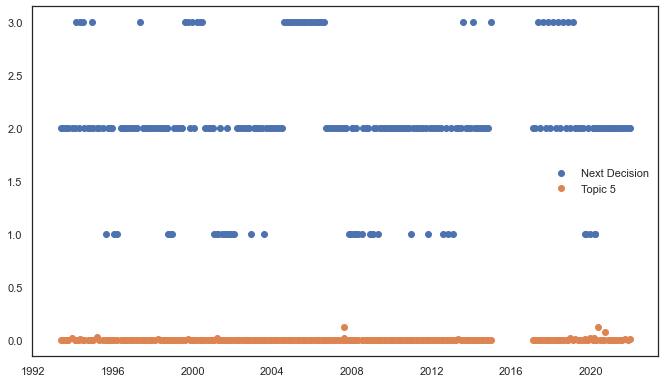

In [257]:
plt.figure(figsize=(10,6))
plt.plot(joined_data.index, joined_data.next_decision, 'o', label = 'Next Decision')
#plt.plot(joined_data.index, joined_data[0], 'o', label = 'Topic 0')
#plt.plot(joined_data.index, joined_data[1], 'o', label = 'Topic 1')
#plt.plot(joined_data.index, joined_data[2], 'o', label = 'Topic 2')
#plt.plot(joined_data.index, joined_data[3], 'o', label = 'Topic 3')
#plt.plot(joined_data.index, joined_data[4], 'o', label = 'Topic 4')
plt.plot(joined_data.index, joined_data[5], 'o', label = 'Topic 5')
#plt.plot(joined_data.index, joined_data[6], 'o', label = 'Topic 6')
#plt.plot(joined_data.index, joined_data[7], 'o', label = 'Topic 7')
plt.legend();

## Write data

In [258]:
def save_data(df, file_name, dir_name='../data/'):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [259]:
# Final Text Data
save_data(final_text, 'text_w_lda')

# Final joined data
save_data(joined_data, 'final_fed_data')

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import datetime

import random 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score, plot_confusion_matrix, roc_auc_score, roc_curve, auc, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from collections import Counter


In [261]:
# Load data
file = open('../data/final_fed_data.pickle', 'rb')
data = pd.read_pickle(file)
file.close()

print(data.shape)
data.tail()

(242, 78)


word_count  next_rate         0         1        2    3  \
next_meeting                                                             
2021-06-16    2939.000000        0.0  0.960124  0.028961  0.00000  0.0   
2021-07-28    2716.500000        0.0  0.965266  0.025540  0.00000  0.0   
2021-09-22    3146.000000        0.0  0.977887  0.000000  0.00000  0.0   
2021-11-03    2272.750000        0.0  0.977192  0.000000  0.00666  0.0   
2021-12-15    1592.833333        0.0  0.976769  0.006543  0.00000  0.0   

                     4         5    6    7  ...    Taylor  Balanced   Inertia  \
next_meeting                                ...                                 
2021-06-16    0.000000  0.005220  0.0  0.0  ...  4.209310  2.794548 -0.419182   
2021-07-28    0.000000  0.000000  0.0  0.0  ...  4.771125  3.356363 -0.503454   
2021-09-22    0.000000  0.012653  0.0  0.0  ...  5.563014  4.720695 -0.708104   
2021-11-03    0.007253  0.000000  0.0  0.0  ...  5.747177  4.940210 -0.741032   
2021-12-15    0.000000  0.012312  0.0  0.0  ...  6.480214  5.673248 -0.850987   

              Taylor-Rate  Balanced-Rate  Inertia-Rate  Taylor_diff  \
next_meeting                                                          
2021-06-16       4.209310       2.794548     -0.419182     2.922618   
2021-07-28       4.771125       3.356363     -0.503454     0.561815   
2021-09-22       5.563014       4.720695     -0.708104     0.791889   
2021-11-03       5.747177       4.940210     -0.741032     0.184163   
2021-12-15       6.480214       5.673248     -0.850987     0.733037   

              Balanced_diff  Inertia_diff  next_decision  
next_meeting                                              
2021-06-16         2.794548     -0.419182            2.0  
2021-07-28         0.561815     -0.084272            2.0  
2021-09-22         1.364332     -0.204650            2.0  
2021-11-03         0.219515     -0.032927            2.0  
2021-12-15         0.733037     -0.109956            2.0  

[5 rows x 78 columns]

In [262]:
# fed calendar
file = open('../data/preprocessed/fomc_calendar.pickle', 'rb')
fomc_cal = pd.read_pickle(file)
file.close()

print(fomc_cal.shape)
fomc_cal.tail()

(396, 8)


unscheduled  forecast  confcall  Rate  RateDiff  RateDecision  \
date                                                                        
2021-06-16        False      True     False   0.0       0.0             0   
2021-07-28        False     False     False   0.0       0.0             0   
2021-09-22        False      True     False   0.0       0.0             0   
2021-11-03        False     False     False   0.0       0.0             0   
2021-12-15        False      True     False   0.0       0.0             0   

           ChairPerson  RateChanged  
date                                 
2021-06-16         NaN            0  
2021-07-28         NaN            0  
2021-09-22         NaN            0  
2021-11-03         NaN            0  
2021-12-15         NaN            0

In [263]:
# model features
feature_columns = ['GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                  'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                  'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                  'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                  'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                  'Rsales_diff_prev', 'Hsales_diff_prev', 'Hsales_diff_year',
                  'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff',
                  0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17
                  ]

X = data.dropna(subset = ['next_decision'])
X = X[feature_columns]
X = X.dropna(axis='columns')

In [264]:
feature_list = list(X.columns)

X = np.array(X)
y = np.array(data['next_decision'])

In [265]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
rand_seed = 42

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = random.randint(0,1000), shuffle = False)

Class=2, n=131 (67.876%)
Class=3, n=30 (15.544%)
Class=1, n=32 (16.580%)


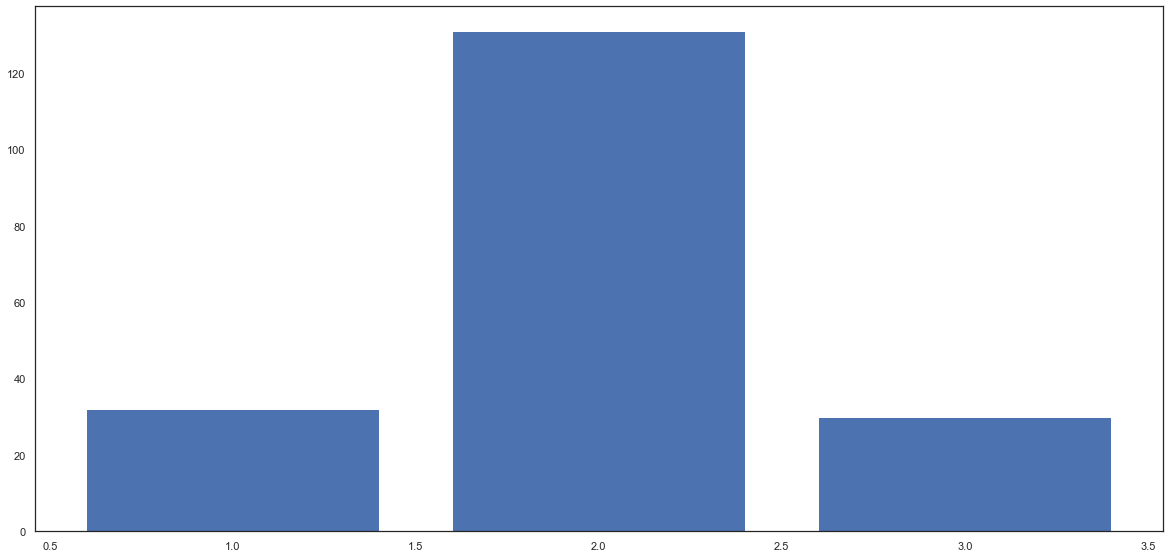

In [266]:
# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

Class=2, n=131 (33.333%)
Class=3, n=131 (33.333%)
Class=1, n=131 (33.333%)


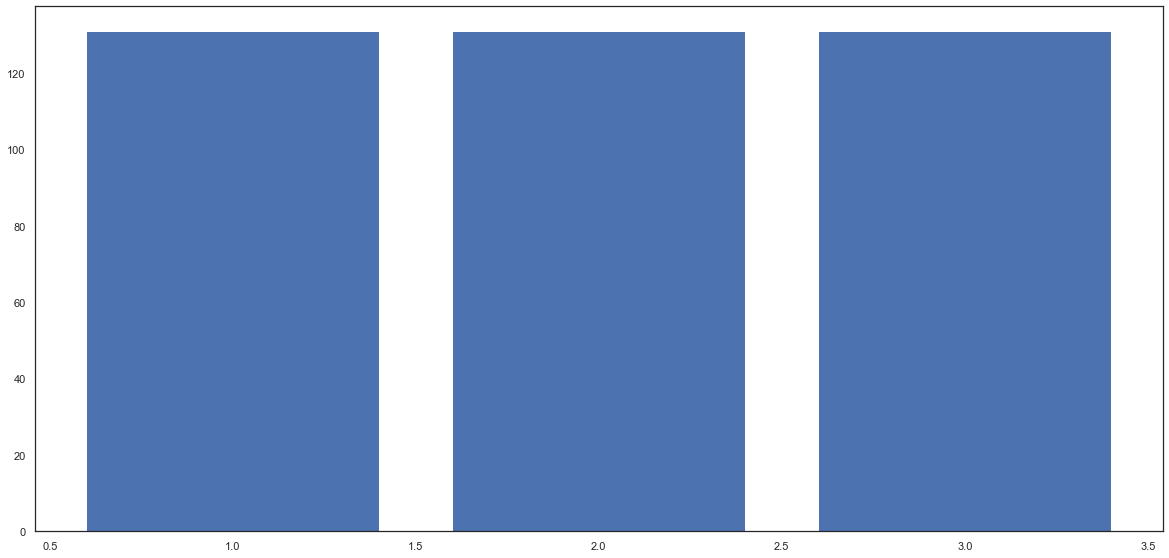

In [267]:
# oversample using SMOTE
# reference: https://machinelearningmastery.com/multi-class-imbalanced-classification/
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)
# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [268]:
#pip install imblearn

In [269]:
import time
import logging

# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.DEBUG)
timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(ch)

# Use Stratified KFold Cross Validation
n_fold = 7
kfold = StratifiedKFold(n_splits=n_fold)
kfold
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(x_train, y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(x_train)
    pred_test = best_estimator.predict(x_test)

    acc, f1 = metric(y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, x_train, y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, x_train, y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, x_train, y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, x_train, y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, x_test, y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, x_test, y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


Fitting 7 folds for each of 50 candidates, totalling 350 fits


[2022-01-28 18:25:51,402][INFO] ## Training - acc: 0.97455471, f1: 0.97447612
[2022-01-28 18:25:51,406][INFO] ## Test - acc: 0.83673469, f1: 0.65935673


Best Score:  0.8636455224242565
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 82}


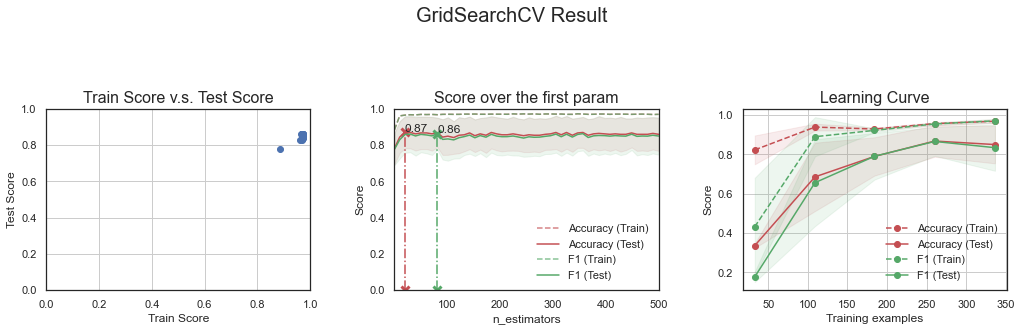

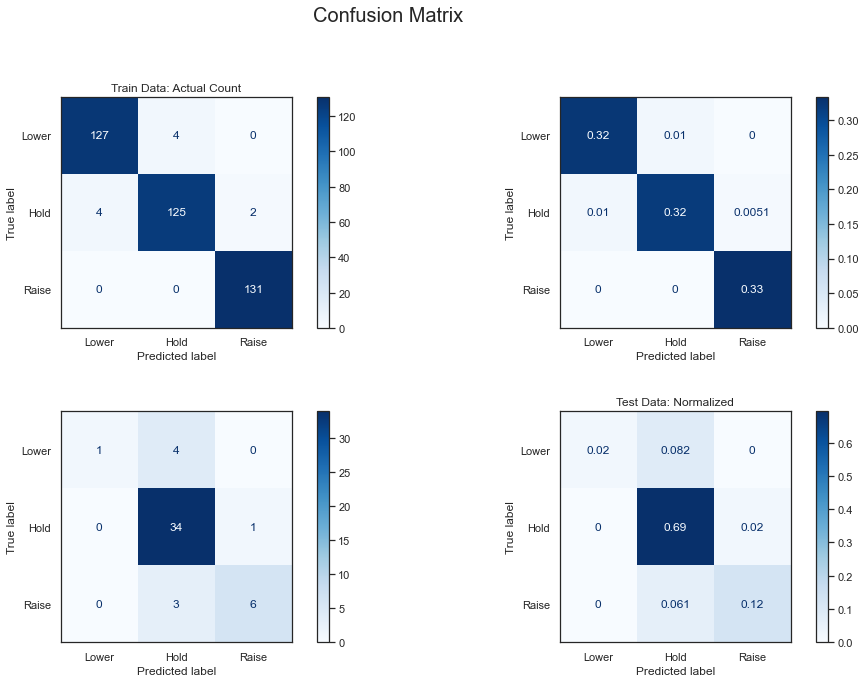

In [270]:
# Random Forest
rf_clf = RandomForestClassifier()


# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 500, 50, dtype=int),
              'min_samples_split': [5],
              'min_samples_leaf': [10],
              'max_features': [8],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

ext_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
ext_best = ext_model.best_estimator_


## Final Model

In [271]:
rf_model = RandomForestClassifier(bootstrap = False, criterion = 'gini', 
                                  max_depth = None, max_features = 8, min_samples_leaf = 10, 
                                  min_samples_split = 5, n_estimators = 357)


rf_model = rf_model.fit(x_train, y_train)
rf_predictions = rf_model.predict(x_test)

# accuracy
scores = rf_model.score(x_test, y_test)
print('Accuracy: ', scores)

# roc 
print('ROC score: ', roc_auc_score(y_test, rf_model.predict_proba(x_test), multi_class='ovr'))

Accuracy:  0.8775510204081632
ROC score:  0.9448790627362055


## Visualize Predictions

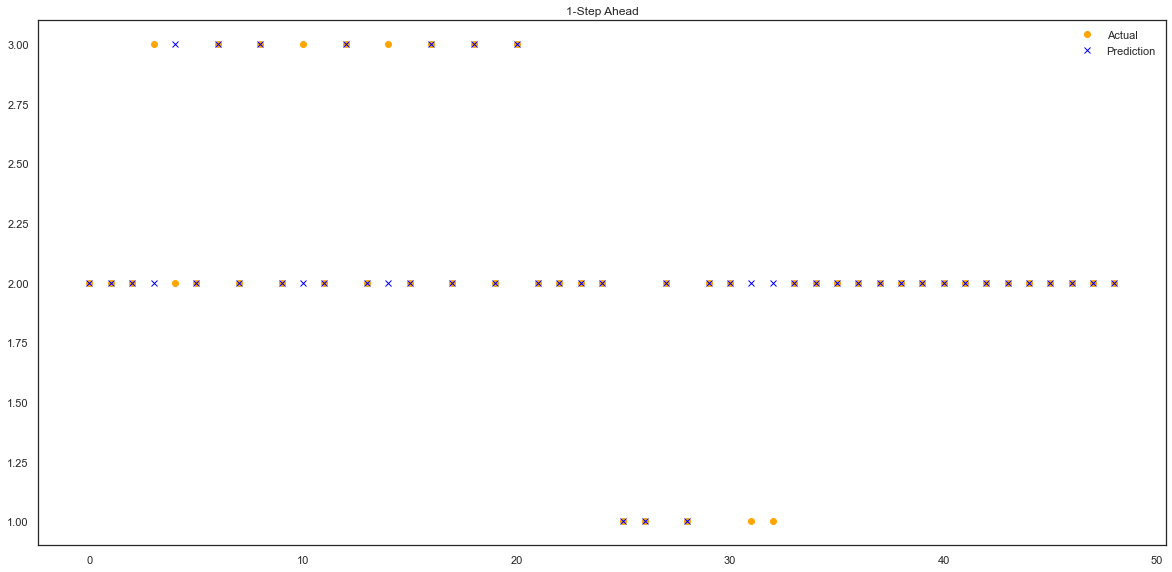

In [272]:
plt.plot(y_test, 'o', color='orange', label = "Actual")
plt.plot(rf_predictions,  'x', color='blue', label = "Prediction")
plt.title('1-Step Ahead')
plt.legend()

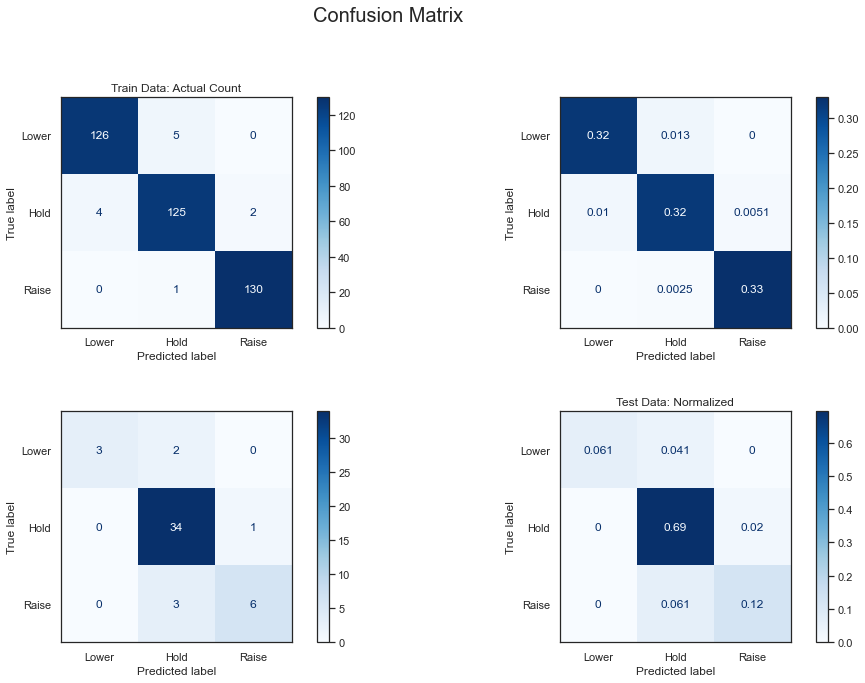

In [273]:
### Confusion Matrix ###
class_names = ['Lower', 'Hold', 'Raise']
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Confusion Matrix", fontsize=20)

plot_confusion_matrix(rf_model, x_train, y_train, display_labels=class_names, 
                      cmap=plt.cm.Blues, normalize=None, ax=ax1)
ax1.set_title("Train Data: Actual Count")
ax1.grid(False)

plot_confusion_matrix(rf_model, x_train, y_train, display_labels=class_names, 
                      cmap=plt.cm.Blues, normalize='all', ax=ax2)
ax2.set_title=("Train Data: Normalized")
ax2.grid(False)

plot_confusion_matrix(rf_model, x_test, y_test, display_labels=class_names, 
                      cmap=plt.cm.Blues, normalize=None, ax=ax3)
ax3.set_title=("Test Data: Actual Count")
ax3.grid(False)

plot_confusion_matrix(rf_model, x_test, y_test, display_labels=class_names, 
                      cmap=plt.cm.Blues, normalize='all', ax=ax4)
ax4.set_title("Test Data: Normalized")
ax4.grid(False)

plt.tight_layout(pad=3.0)
plt.show()
    

## Get numerical feature importances

In [274]:
importances = list(rf_model.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


Variable: Inertia_diff         Importance: 0.31
Variable: PMI_value            Importance: 0.12
Variable:                    3 Importance: 0.09
Variable: Unemp_diff_year      Importance: 0.06
Variable: GDP_diff_year        Importance: 0.05
Variable: Employ_diff_year     Importance: 0.04
Variable:                    6 Importance: 0.04
Variable:                    7 Importance: 0.04
Variable: PMI_diff_year        Importance: 0.03
Variable: Employ_diff_prev     Importance: 0.02
Variable: Inertia-Rate         Importance: 0.02
Variable: GDP_diff_prev        Importance: 0.01
Variable: GDPPOT_diff_prev     Importance: 0.01
Variable: GDPPOT_diff_year     Importance: 0.01
Variable: PCE_diff_year        Importance: 0.01
Variable: CPI_diff_prev        Importance: 0.01
Variable: CPI_diff_year        Importance: 0.01
Variable: Unemp_value          Importance: 0.01
Variable: Unemp_diff_prev      Importance: 0.01
Variable: Employ_value         Importance: 0.01
Variable: Hsales_diff_prev     Importanc

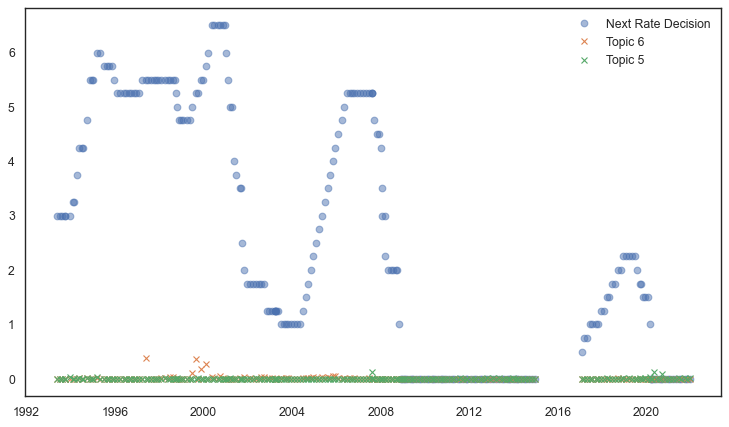

In [275]:
#plt.plot(data.index, data.Inertia_diff, label = 'Inertia Rule')
#plt.plot(data.index, np.log(data.PMI_value), label = 'PMI')

plt.figure(figsize=(10, 6), dpi=80)

plt.plot(data.index, data.next_rate, 'o', alpha = 0.5, label = 'Next Rate Decision')
plt.plot(data.index, data[6], 'x', label = 'Topic 6')
plt.plot(data.index, data[5], 'x', label = 'Topic 5')
plt.legend()

In [276]:
display(data)

word_count  next_rate         0         1         2    3  \
next_meeting                                                              
1993-05-18    5253.000000        3.0  0.000000  0.000000  0.000000  0.0   
1993-07-07    4414.000000        3.0  0.000000  0.000000  0.000000  0.0   
1993-08-17    6309.000000        3.0  0.000000  0.000000  0.000000  0.0   
1993-09-21    4220.000000        3.0  0.000000  0.000000  0.000000  0.0   
1993-10-05    4517.000000        3.0  0.000000  0.000000  0.043925  0.0   
...                   ...        ...       ...       ...       ...  ...   
2021-06-16    2939.000000        0.0  0.960124  0.028961  0.000000  0.0   
2021-07-28    2716.500000        0.0  0.965266  0.025540  0.000000  0.0   
2021-09-22    3146.000000        0.0  0.977887  0.000000  0.000000  0.0   
2021-11-03    2272.750000        0.0  0.977192  0.000000  0.006660  0.0   
2021-12-15    1592.833333        0.0  0.976769  0.006543  0.000000  0.0   

                     4         5    6         7  ...    Taylor  Balanced  \
next_meeting                                     ...                       
1993-05-18    0.000000  0.000000  0.0  0.999379  ...  3.876557  2.706065   
1993-07-07    0.000000  0.000000  0.0  0.999252  ...  4.124328  2.953836   
1993-08-17    0.031083  0.000000  0.0  0.968376  ...  4.113643  2.905487   
1993-09-21    0.000000  0.000000  0.0  0.999204  ...  3.853539  2.645383   
1993-10-05    0.000000  0.000000  0.0  0.955451  ...  3.998580  2.790424   
...                ...       ...  ...       ...  ...       ...       ...   
2021-06-16    0.000000  0.005220  0.0  0.000000  ...  4.209310  2.794548   
2021-07-28    0.000000  0.000000  0.0  0.000000  ...  4.771125  3.356363   
2021-09-22    0.000000  0.012653  0.0  0.000000  ...  5.563014  4.720695   
2021-11-03    0.007253  0.000000  0.0  0.000000  ...  5.747177  4.940210   
2021-12-15    0.000000  0.012312  0.0  0.000000  ...  6.480214  5.673248   

               Inertia  Taylor-Rate  Balanced-Rate  Inertia-Rate  Taylor_diff  \
next_meeting                                                                    
1993-05-18    2.144090     0.876557      -0.293935     -0.855910    -0.412940   
1993-07-07    2.106925     1.124328      -0.046164     -0.893075     0.247771   
1993-08-17    2.114177     1.113643      -0.094513     -0.885823    -0.010685   
1993-09-21    2.153193     0.853539      -0.354617     -0.846807    -0.260104   
1993-10-05    2.131436     0.998580      -0.209576     -0.868564     0.145041   
...                ...          ...            ...           ...          ...   
2021-06-16   -0.419182     4.209310       2.794548     -0.419182     2.922618   
2021-07-28   -0.503454     4.771125       3.356363     -0.503454     0.561815   
2021-09-22   -0.708104     5.563014       4.720695     -0.708104     0.791889   
2021-11-03   -0.741032     5.747177       4.940210     -0.741032     0.184163   
2021-12-15   -0.850987     6.480214       5.673248     -0.850987     0.733037   

              Balanced_diff  Inertia_diff  next_decision  
next_meeting                                              
1993-05-18        -0.651462      0.097719            2.0  
1993-07-07         0.247771     -0.037166            2.0  
1993-08-17        -0.048350      0.007252            2.0  
1993-09-21        -0.260104      0.039016            2.0  
1993-10-05         0.145041     -0.021756            2.0  
...                     ...           ...            ...  
2021-06-16         2.794548     -0.419182            2.0  
2021-07-28         0.561815     -0.084272            2.0  
2021-09-22         1.364332     -0.204650            2.0  
2021-11-03         0.219515     -0.032927            2.0  
2021-12-15         0.733037     -0.109956            2.0  

[242 rows x 78 columns]

## Save Model

In [277]:
# save the model to disk
pickle.dump(rf_model, open('../data/final_fed_model', 'wb'))

## Multi-Step Predictions

In [278]:
feature_columns = ['GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev',
                   'GDPPOT_diff_year', 'PCE_diff_prev', 'PCE_diff_year',
                   'CPI_diff_prev', 'CPI_diff_year', 'Unemp_value',
                   'Unemp_diff_prev', 'Unemp_diff_year', 'Employ_value',
                   'Employ_diff_prev', 'Employ_diff_year', 'PMI_value',
                   'PMI_diff_prev', 'PMI_diff_year', 'Rsales_diff_prev',
                   'Hsales_diff_prev', 'Hsales_diff_year', 'Taylor-Rate',
                   'Balanced-Rate', 'Inertia-Rate',  'Taylor_diff',
                   'Balanced_diff', 'Inertia_diff', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

future_pred = []

def multi_step_pred(y_col, n_steps):
    for step in n_steps:
        col_name = str(y_col) + '_' + str(step)
        data[col_name] = data['RateDecision'].shift(step)
        df = data.dropna(subset = [col_name])

        X = df[feature_columns]
        X = X.dropna(axis='columns')
        feature_list = list(X.columns)
        X = np.array(X)
        y = np.array(df[col_name])

        # set random seed
        random.seed(42)
        np.random.seed(42)
        rand_seed = 42

        # split
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = random.randint(0,1000), shuffle = False)
        x_train, y_train = oversample.fit_resample(x_train, y_train)

        rf_model = RandomForestClassifier(bootstrap = False, criterion = 'gini', 
                                      max_depth = None, max_features = 8, min_samples_leaf = 10, 
                                      min_samples_split = 5, n_estimators = 500)

        rf_model = rf_model.fit(x_train, y_train)
        rf_predictions = rf_model.predict(x_test)

        # performance
        scores = rf_model.score(x_test, y_test)
        print(str(step) + '-Ahead Accuracy: ', scores)
        print(str(step) + '-Ahead ROC score: ', roc_auc_score(y_test, rf_model.predict_proba(x_test), multi_class='ovr'))

        # plot
        plt.plot(y_test, 'o', color='orange', label = "Actual")
        plt.plot(rf_predictions,  'x', color='blue', label = "Prediction")
        plt.title(str(step) + '-Ahead Prediction')
        plt.legend()
        plt.show()

        future_x = data[data.index == '2021-07-28']
        future_x = future_x.dropna(axis = 'columns')
        future_x = future_x[feature_columns]

        prediction = rf_model.predict(np.array(future_x))
        prediction = int(prediction)
        
        future_pred.append(prediction)
       
    return future_pred
    

1-Ahead Accuracy:  0.8571428571428571
1-Ahead ROC score:  0.9433639112210542


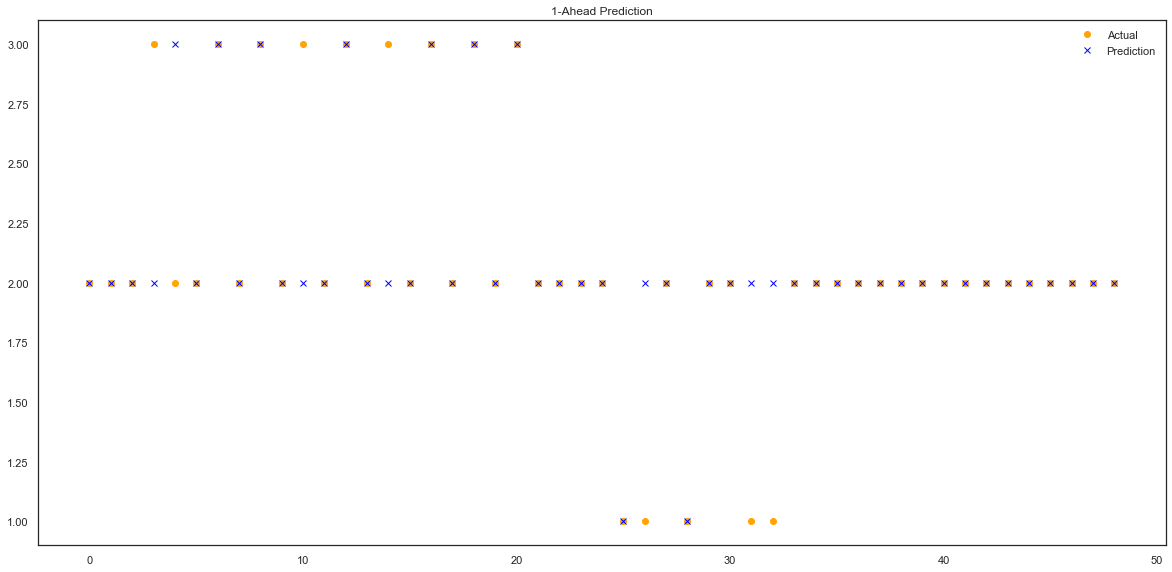

2-Ahead Accuracy:  0.5416666666666666
2-Ahead ROC score:  0.687552292499853


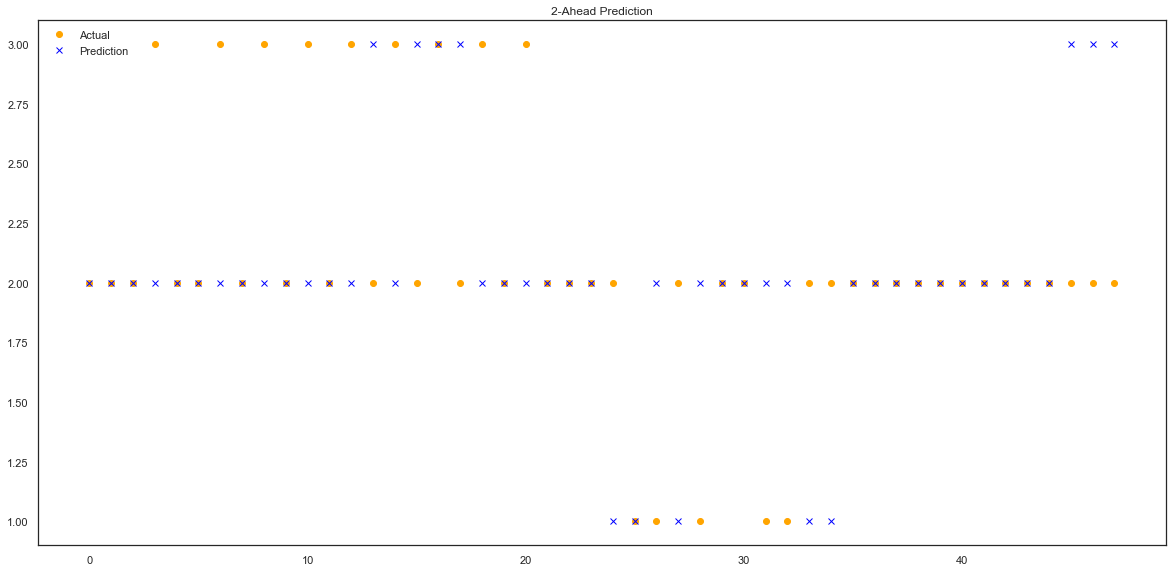

3-Ahead Accuracy:  0.8125
3-Ahead ROC score:  0.821527203606547


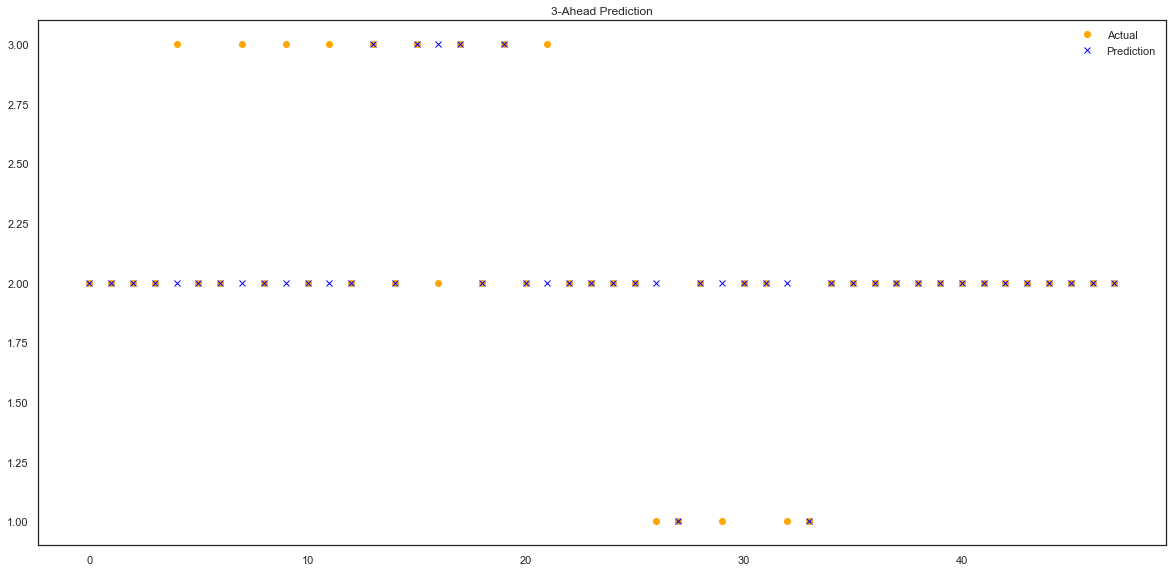

4-Ahead Accuracy:  0.6875
4-Ahead ROC score:  0.7479802720796793


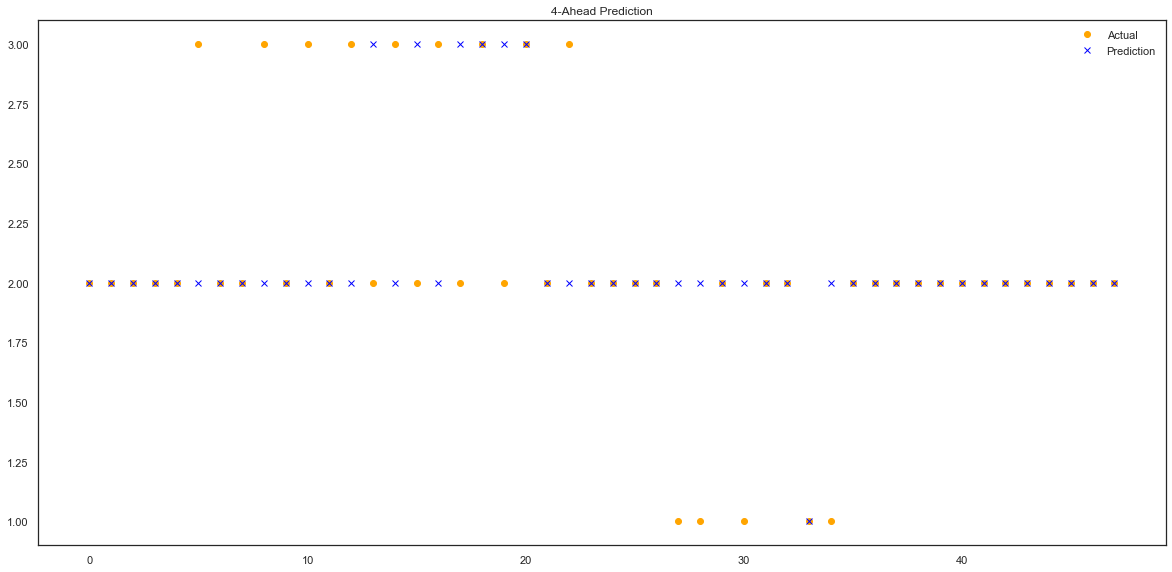

5-Ahead Accuracy:  0.6875
5-Ahead ROC score:  0.7080029865255583


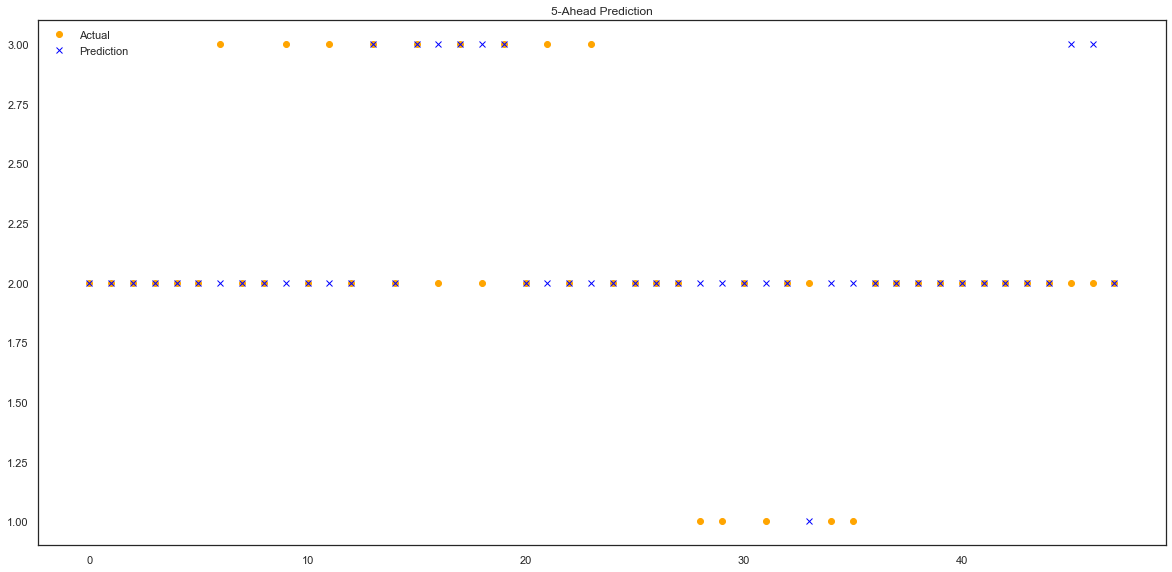

6-Ahead Accuracy:  0.5208333333333334
6-Ahead ROC score:  0.5140367258014317


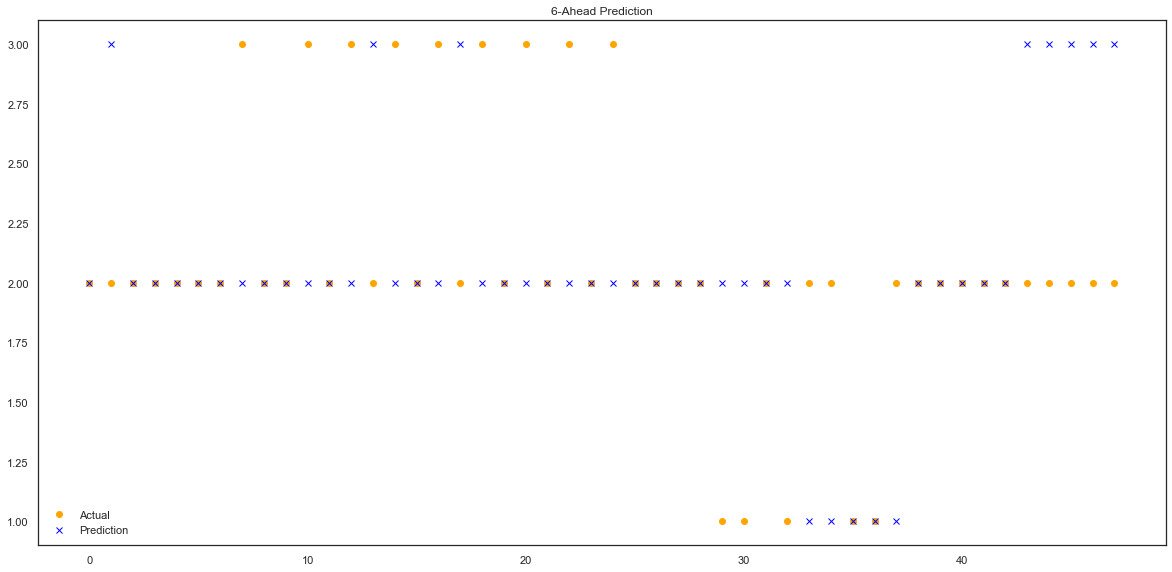

7-Ahead Accuracy:  0.6382978723404256
7-Ahead ROC score:  0.7354370775423407


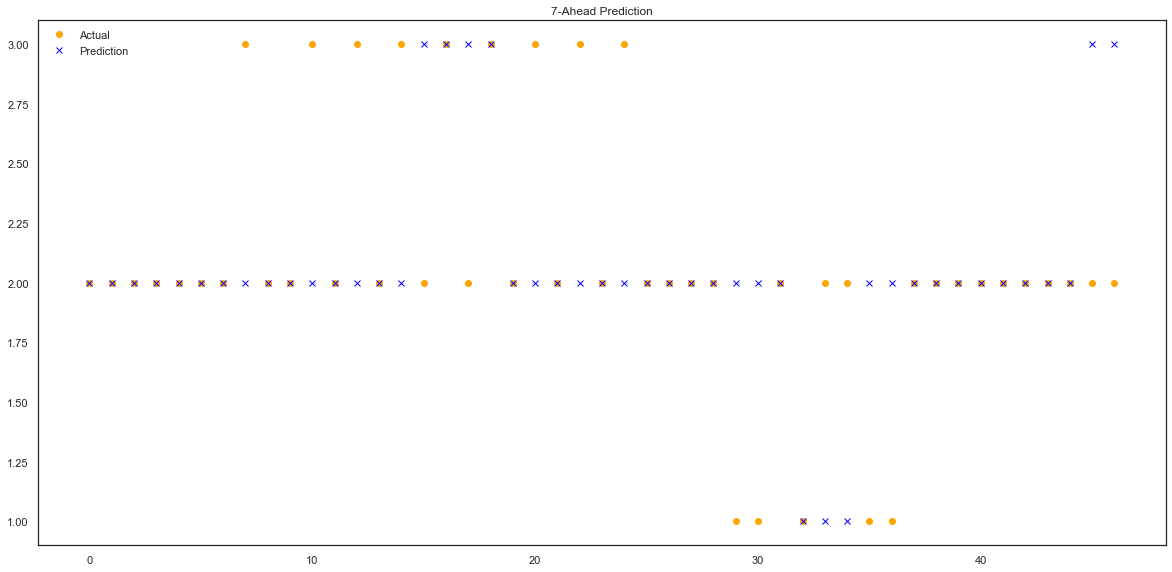

8-Ahead Accuracy:  0.6170212765957447
8-Ahead ROC score:  0.5721605534105535


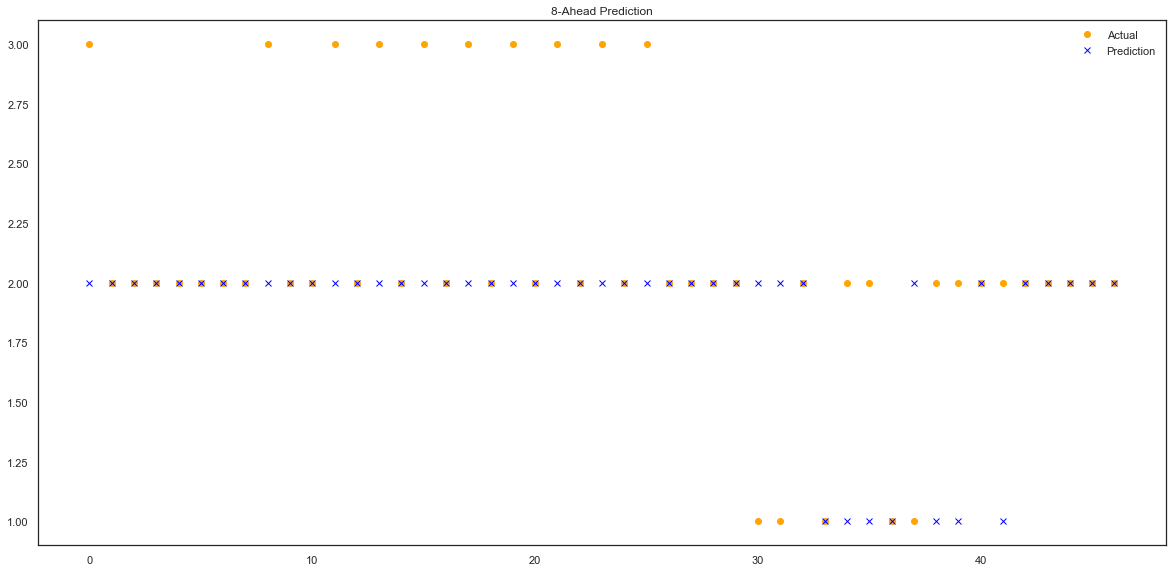

9-Ahead Accuracy:  0.7021276595744681
9-Ahead ROC score:  0.6460129772629774


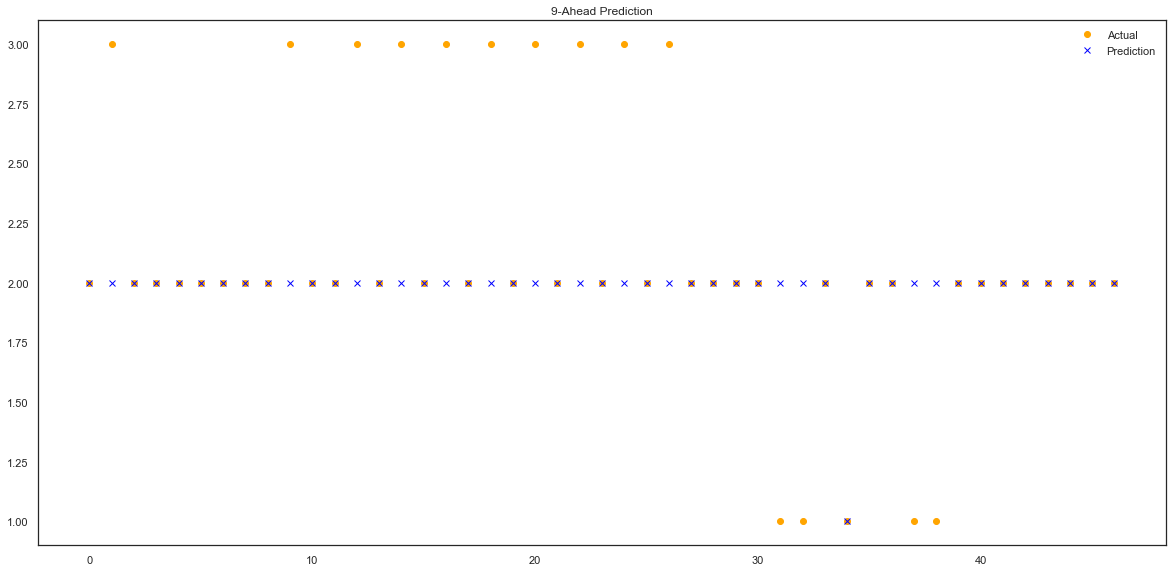

10-Ahead Accuracy:  0.6595744680851063
10-Ahead ROC score:  0.7261234448734449


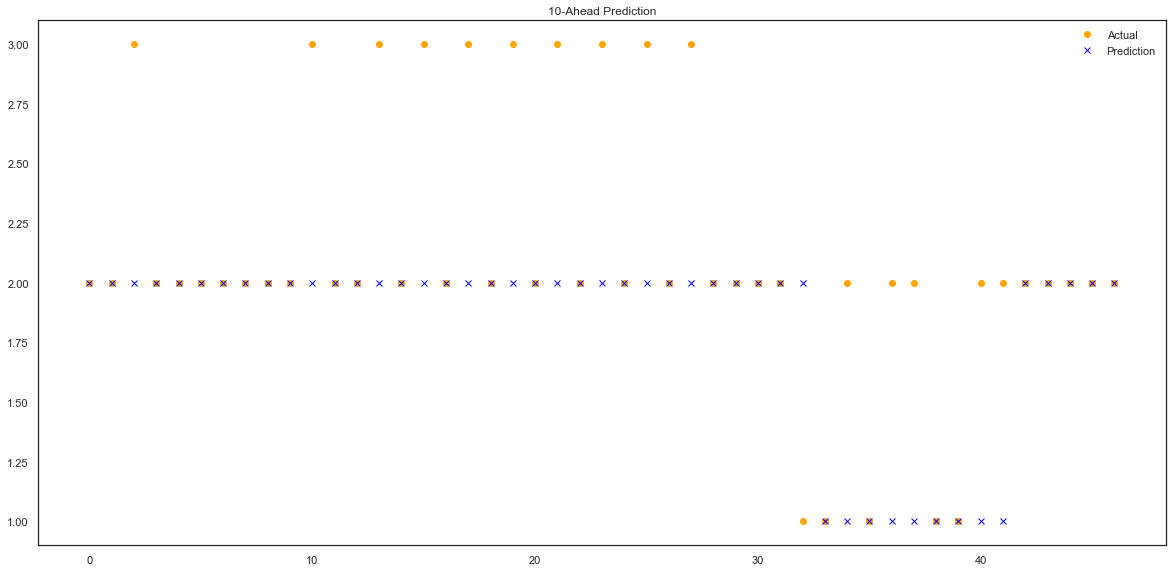

11-Ahead Accuracy:  0.723404255319149
11-Ahead ROC score:  0.8011931574431573


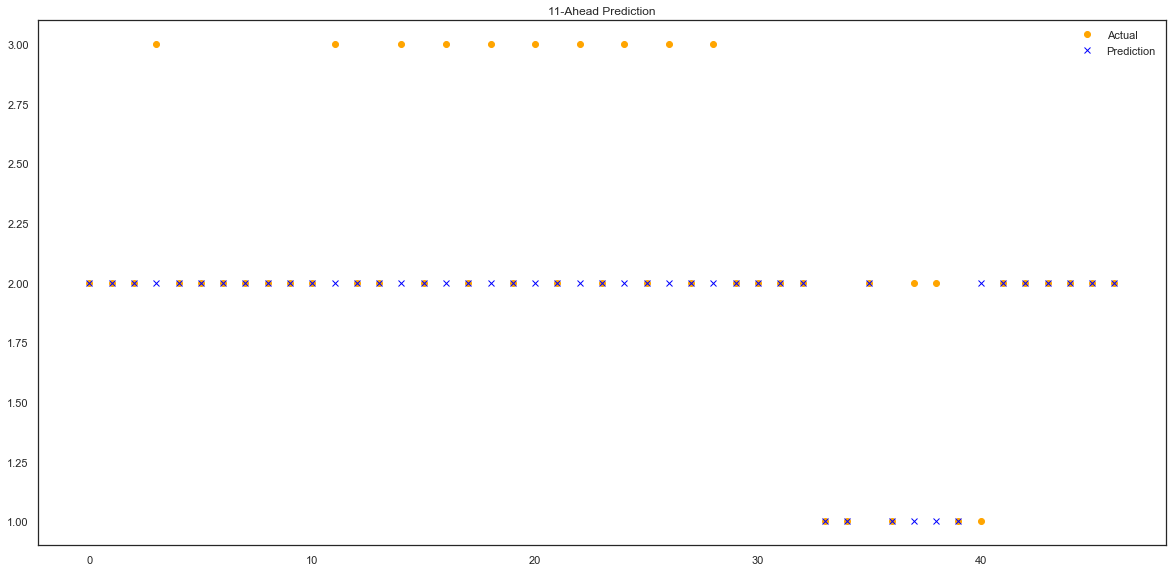

12-Ahead Accuracy:  0.6521739130434783
12-Ahead ROC score:  0.7123721479150276


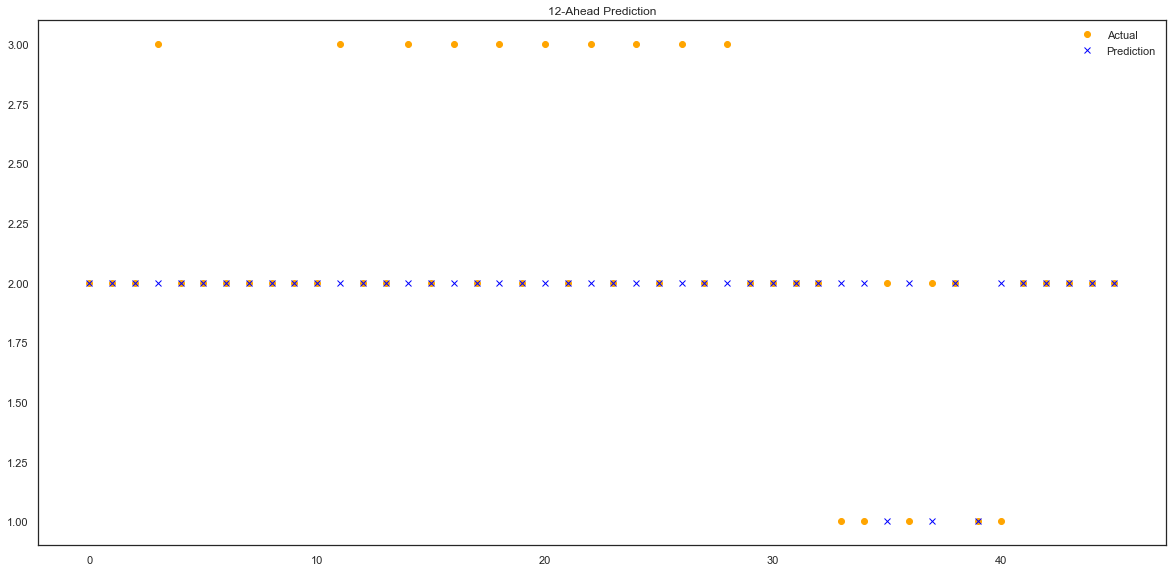

[2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2]

In [279]:
n_steps = list(range(1,13))
multi_step_pred('RateDecision', n_steps)

In [280]:
future_pred = pd.Series(future_pred)
future_pred

0     2
1     2
2     2
3     2
4     2
5     3
6     2
7     2
8     2
9     2
10    2
11    2
dtype: int64

In [281]:
ffr_data = data['RateDecision']
ffr_data = ffr_data.append((future_pred))
ffr_data

1993-05-18 00:00:00    2
1993-07-07 00:00:00    2
1993-08-17 00:00:00    2
1993-09-21 00:00:00    2
1993-10-05 00:00:00    2
                      ..
7                      2
8                      2
9                      2
10                     2
11                     2
Length: 254, dtype: int64

In [282]:
ffr_data.value_counts()

2    177
3     40
1     37
dtype: int64

## Save Output

In [283]:
ffr_data.to_csv('../data/fed_funds_predictions.csv', index=True)